# Call consensus sequences for viral barcodes in each cell
This Python Jupyter notebook corrects/calls consensus viral barcodes in each cell. Viral barcodes are input as UMI count data, assigned to a cell barcode and gene. The notebook uses UMI tools to correct the viral barcodes for each cell; this provides a set of consensus viral barcodes within each cell. The notebook outputs the corrected viral barcode counts and a whitelist of viral barcodes identified on each segment.

## Notes about UMI_tools
* Using directional adjacency method. This has [been demonstrated on simulated data](https://cgatoxford.wordpress.com/2015/08/14/unique-molecular-identifiers-the-problem-the-solution-and-the-proof/) to produce a more accurate estimate of true UMI number than other heuristics.
* Sequence must be input as byte. See definition here: https://stackoverflow.com/questions/6269765/what-does-the-b-character-do-in-front-of-a-string-literal
* The corrected barcode is returned as the first barcode in the group list. See umi_tools API documentation: https://umi-tools.readthedocs.io/en/latest/API.html

Import Python modules:

In [1]:
import gzip

from IPython.display import display

from dms_variants.constants import CBPALETTE

import pandas as pd

import plotnine as p9

from umi_tools import UMIClusterer

Get `snakemake` variables [as described here](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#jupyter-notebook-integration):

In [2]:
viral_bc_by_cell = 'results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_by_cell.csv.gz'
expt = 'scProgenyProduction_trial2'

Set plot style

In [3]:
p9.theme_set(p9.theme_classic())

Import barcode data

In [4]:
viral_bc_df = pd.read_csv(gzip.open(viral_bc_by_cell))
display(viral_bc_df)

gene      cell_barcode     viral_barcode  count
0      fluHA  AAACCCAAGTAGGTTA  ACGTTATTGATTGAGA      1
1      fluHA  AAACCCAAGTAGGTTA  AGAATCGACACATGTC     14
2      fluHA  AAACCCAAGTAGGTTA  AGCCATAGTCTAAAGG      7
3      fluHA  AAACCCAAGTAGGTTA  AGCCATAGTCTACAGG      1
4      fluHA  AAACCCAAGTAGGTTA  AGGATGATTTTTTTAT      1
...      ...               ...               ...    ...
94893  fluNA  TTTGTTGTCTAGGAAA  GAACCCGAAGGGGAAT      1
94894  fluNA  TTTGTTGTCTAGGAAA  GAACCCGATGGGGAAT     25
94895  fluNA  TTTGTTGTCTAGGAAA  TAAGGTAAAATAATAG      1
94896  fluNA  TTTGTTGTCTAGGAAA  TAAGGTATAATTCTAG      4
94897  fluNA  TTTGTTGTCTAGGAAA  TGTTGGGCTTTAAGCA      5

[94898 rows x 4 columns]

Plot number of barcodes identified in each cell.

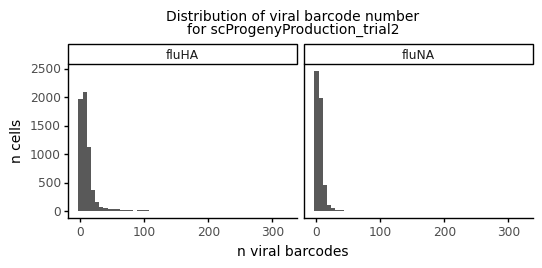

In [5]:
fig = (p9.ggplot((viral_bc_df
                  .groupby(['cell_barcode','gene'])
                  .nunique()
                  .reset_index()),
                 p9.aes(x='viral_barcode')) +
       p9.ggtitle('Distribution of viral barcode number\n'
                  f'for {expt}') +
       p9.geom_histogram(bins=50) +
       p9.facet_grid('~gene') +
       p9.theme(figure_size=(3*(viral_bc_df['gene'].nunique()),
                             2),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.labs(x='n viral barcodes',
               y='n cells'))

# show plot
fig.draw()

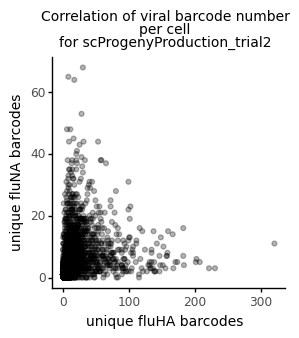

In [21]:
fig = (p9.ggplot((viral_bc_df
                  .groupby(['cell_barcode','gene'])
                  .nunique()
                  .reset_index()
                  .pivot_table(index='cell_barcode',
                               columns='gene',
                               values='viral_barcode')
                  .fillna(0)
                  .reset_index()),
                 p9.aes(x='fluHA',
                        y='fluNA')) +
       p9.ggtitle('Correlation of viral barcode number\n'
                  'per cell\n'
                  f'for {expt}') +
       p9.geom_point(alpha=0.3) +
       p9.theme(figure_size=(3,3),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.labs(x='unique fluHA barcodes',
               y='unique fluNA barcodes'))

# show plot
fig.draw()

Cluster barcodes within each cell

In [26]:
clusterer = UMIClusterer(cluster_method="directional")

lookup_list = []

for (cell_barcode, gene), df in (viral_bc_df
                                .groupby(['cell_barcode',
                                          'gene'])):
    # Convert dataframe to dictionary. Dict requried input for umi_tools.
    viral_bc_dict = (df[['viral_barcode', 'count']]
                     .set_index('viral_barcode')
                     .to_dict(orient='dict'))
    viral_bc_dict = viral_bc_dict['count']

    # Convert barcode strings to byte. Byte required dtype for umi_tools.
    byte_dict = {}
    for key, value in viral_bc_dict.items():
        byte_dict[key.encode("utf-8")] = float(value)

    # Cluster barcodes
    bc_groups = clusterer(byte_dict, threshold=1)
    groups_df = pd.DataFrame(bc_groups)
    groups_df = (groups_df
                 .stack()
                 .str
                 .decode('utf-8')
                 .unstack())  # Convert bytes back to string
    groups_df = groups_df.rename(columns={0: 'corrected_viral_bc'})
    groups_df = groups_df.set_index('corrected_viral_bc', drop=False)

    # Generate lookup table for this sample
    temp_lookup_df = (groups_df.melt(ignore_index=False,
                                     value_name='original_viral_bc')
                      ['original_viral_bc']
                      .dropna()
                      .reset_index())
    temp_lookup_df['gene'] = gene
    temp_lookup_df['cell_barcode'] = cell_barcode
    print(temp_lookup_df)
    lookup_list.append(temp_lookup_df)

lookup_df = pd.concat(lookup_list)
display(lookup_df.describe())

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CTTAACTGTATATTCG  CTTAACTGTATATTCG  fluHA  AAACCCAAGTAGGTTA
1    TGTAAATAGAGTTCGC  TGTAAATAGAGTTCGC  fluHA  AAACCCAAGTAGGTTA
2    AGAATCGACACATGTC  AGAATCGACACATGTC  fluHA  AAACCCAAGTAGGTTA
3    TCTTAAGTATATCAGA  TCTTAAGTATATCAGA  fluHA  AAACCCAAGTAGGTTA
4    CACGGATGGTGTACGA  CACGGATGGTGTACGA  fluHA  AAACCCAAGTAGGTTA
5    AGCCATAGTCTAAAGG  AGCCATAGTCTAAAGG  fluHA  AAACCCAAGTAGGTTA
6    CCTTGCAGTATACCAA  CCTTGCAGTATACCAA  fluHA  AAACCCAAGTAGGTTA
7    GGCGTCCCACTAGGTC  GGCGTCCCACTAGGTC  fluHA  AAACCCAAGTAGGTTA
8    AGGATGATTTTTTTGT  AGGATGATTTTTTTGT  fluHA  AAACCCAAGTAGGTTA
9    TGCACGGTACGGACCC  TGCACGGTACGGACCC  fluHA  AAACCCAAGTAGGTTA
10   ACGTTATTGATTGAGA  ACGTTATTGATTGAGA  fluHA  AAACCCAAGTAGGTTA
11   TGAAAATAGAGTTCGA  TGAAAATAGAGTTCGA  fluHA  AAACCCAAGTAGGTTA
12   TGCCAGGTTAGGACCT  TGCCAGGTTAGGACCT  fluHA  AAACCCAAGTAGGTTA
13   CTTAACTGTATATTCG  CTTAACTGTGTATTCG  fluHA  AAACCCAAGTAGGTTA
14   TCTTAAGTATATCAGA  TC

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AAGCTAGTAGTAAAAC  AAGCTAGTAGTAAAAC  fluHA  AAACGCTCAATCACGT
1    CGAACTGTCCCAAGGT  CGAACTGTCCCAAGGT  fluHA  AAACGCTCAATCACGT
2    GCATTAATGAGATGAG  GCATTAATGAGATGAG  fluHA  AAACGCTCAATCACGT
3    GAGTAAATAGCAATGG  GAGTAAATAGCAATGG  fluHA  AAACGCTCAATCACGT
4    GGTTGTGGAACCCTAC  GGTTGTGGAACCCTAC  fluHA  AAACGCTCAATCACGT
5    TAGACACGTTGAACCA  TAGACACGTTGAACCA  fluHA  AAACGCTCAATCACGT
6    TCGTACATGCAACTGG  TCGTACATGCAACTGG  fluHA  AAACGCTCAATCACGT
7    TGGGTTTGAGTGACCC  TGGGTTTGAGTGACCC  fluHA  AAACGCTCAATCACGT
8    AAAGTTAAGTAAGGAC  AAAGTTAAGTAAGGAC  fluHA  AAACGCTCAATCACGT
9    CTGTTAATTGCGACTA  CTGTTAATTGCGACTA  fluHA  AAACGCTCAATCACGT
10   AATTGAGTCTGAATCC  AATTGAGTCTGAATCC  fluHA  AAACGCTCAATCACGT
11   GAGTCATGGAGGAGAA  GAGTCATGGAGGAGAA  fluHA  AAACGCTCAATCACGT
12   GTGTCTAATCCAAGAC  GTGTCTAATCCAAGAC  fluHA  AAACGCTCAATCACGT
13   TTTCCTTTGGCAATTG  TTTCCTTTGGCAATTG  fluHA  AAACGCTCAATCACGT
14   TCGTACATGCAAATAA  TC

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CGGGCAAGGTTAGAAG  CGGGCAAGGTTAGAAG  fluHA  AAAGGGCCACAACGAG
1    GTGTGACGTCGTTGAC  GTGTGACGTCGTTGAC  fluHA  AAAGGGCCACAACGAG
2    GAGCCTGCAGAATGTT  GAGCCTGCAGAATGTT  fluHA  AAAGGGCCACAACGAG
3    AAACGTTTGAGCGATG  AAACGTTTGAGCGATG  fluHA  AAAGGGCCACAACGAG
4    GTGGAATAATACAAGC  GTGGAATAATACAAGC  fluHA  AAAGGGCCACAACGAG
5    AACCTTTATAGAGCTT  AACCTTTATAGAGCTT  fluHA  AAAGGGCCACAACGAG
6    AACTCCAACGATCTGT  AACTCCAACGATCTGT  fluHA  AAAGGGCCACAACGAG
7    GCATCGCGTATGTGAA  GCATCGCGTATGTGAA  fluHA  AAAGGGCCACAACGAG
8    AAAAGTTTGAGAGATG  AAAAGTTTGAGAGATG  fluHA  AAAGGGCCACAACGAG
9    GTATAAAATCGAAAAC  GTATAAAATCGAAAAC  fluHA  AAAGGGCCACAACGAG
10   GTATGACGACGTTGAC  GTATGACGACGTTGAC  fluHA  AAAGGGCCACAACGAG
11   CGGGCAAGGTTAGAAG  CGGGCAAGGTTATAAG  fluHA  AAAGGGCCACAACGAG
12   GAGCCTGCAGAATGTT  AAGCCTGCAGAATGTT  fluHA  AAAGGGCCACAACGAG
13   GCATCGCGTATGTGAA  GCATCGCGTATGAGAA  fluHA  AAAGGGCCACAACGAG
  corrected_viral_bc orig

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TGAGGTAATGAGTAGA  TGAGGTAATGAGTAGA  fluHA  AAAGTCCAGCTCTATG
1    CGGCCGAAGCTTGTAT  CGGCCGAAGCTTGTAT  fluHA  AAAGTCCAGCTCTATG
2    AGAAACGATTTAGAAA  AGAAACGATTTAGAAA  fluHA  AAAGTCCAGCTCTATG
3    ATTGGCTATCGTACGT  ATTGGCTATCGTACGT  fluHA  AAAGTCCAGCTCTATG
4    GGACCTCATATGTTGG  GGACCTCATATGTTGG  fluHA  AAAGTCCAGCTCTATG
5    AGTAGTGATGCAATGA  AGTAGTGATGCAATGA  fluHA  AAAGTCCAGCTCTATG
6    AAAGATAATGAATAAA  AAAGATAATGAATAAA  fluHA  AAAGTCCAGCTCTATG
7    TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  AAAGTCCAGCTCTATG
8    TGAGGTAATGAGTAGA  AGAGGTAATGAGTAGA  fluHA  AAAGTCCAGCTCTATG
9    CGGCCGAAGCTTGTAT  CGGCCGAAGCTTGTGT  fluHA  AAAGTCCAGCTCTATG
10   AGTAGTGATGCAATGA  AGTAGGGATGCAATGA  fluHA  AAAGTCCAGCTCTATG
11   TGAGGTAATGAGTAGA  TGAGATAATGAGTAGA  fluHA  AAAGTCCAGCTCTATG
12   TGAGGTAATGAGTAGA  TGAGGAAATGAGTAGA  fluHA  AAAGTCCAGCTCTATG
13   TGAGGTAATGAGTAGA  TGCGGTAATGAGTAGA  fluHA  AAAGTCCAGCTCTATG
14   TGAGGTAATGAGTAGA  AG

0   TTATCTTAGAATTGTT  TTATCTTAGAATTGTT  fluHA  AAATGGATCTTGTTAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAATGTCGGGCGCAAT  GAATGTCGGGCGCAAT  fluNA  AAATGGATCTTGTTAC
1   ATTACGGAAGTCATAC  ATTACGGAAGTCATAC  fluNA  AAATGGATCTTGTTAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACGAAGAGGCATTCAA  ACGAAGAGGCATTCAA  fluHA  AACAAAGAGCCTGCCA
1   AGCGTTAAACGAAGGT  AGCGTTAAACGAAGGT  fluHA  AACAAAGAGCCTGCCA
2   CGAACGTGGGAATTCT  CGAACGTGGGAATTCT  fluHA  AACAAAGAGCCTGCCA
3   TTTCGGTTGATTATTA  TTTCGGTTGATTATTA  fluHA  AACAAAGAGCCTGCCA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CGGACATCTGGGAATT  CGGACATCTGGGAATT  fluHA  AACAAAGCACTGCGAC
1    TAGCCGTATTTGAATC  TAGCCGTATTTGAATC  fluHA  AACAAAGCACTGCGAC
2    GAGCTAGTAAATCGAG  GAGCTAGTAAATCGAG  fluHA  AACAAAGCACTGCGAC
3    GGAAGGTTGACCAGAT  GGAAGGTTGACCAGAT  fluHA  AACAAAGCACTGCGAC
4    CCTATAAGTACCTGCT  CCTATAAGTACCTGCT  fluHA  AACAAAGCACTGCGAC
5    GCACAAGAAGGTACTC  GCACAAGAAGG

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ATACCTTCGCATGGTA  ATACCTTCGCATGGTA  fluHA  AACAAGACAGGTGTGA
1    AAACGGTAATCTCTGG  AAACGGTAATCTCTGG  fluHA  AACAAGACAGGTGTGA
2    ACACTTCGTGGTCCGT  ACACTTCGTGGTCCGT  fluHA  AACAAGACAGGTGTGA
3    GCTCACTTGCTGAGAT  GCTCACTTGCTGAGAT  fluHA  AACAAGACAGGTGTGA
4    ACAAGTCAGATGCAAA  ACAAGTCAGATGCAAA  fluHA  AACAAGACAGGTGTGA
..                ...               ...    ...               ...
70   ATACCTTCGCATGGTA  ATAACTTCGCATGATA  fluHA  AACAAGACAGGTGTGA
71   ATACCTTCGCATGGTA  ATTACTTCGCATGGTA  fluHA  AACAAGACAGGTGTGA
72   ATACCTTCGCATGGTA  ATACCTTCCCCTGGTA  fluHA  AACAAGACAGGTGTGA
73   ATACCTTCGCATGGTA  AAGCCATCGCATGGTA  fluHA  AACAAGACAGGTGTGA
74   ATACCTTCGCATGGTA  AAACCTTCACATGGTA  fluHA  AACAAGACAGGTGTGA

[75 rows x 4 columns]
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAGTGACGGAACGCTT  TAGTGACGGAACGCTT  fluNA  AACAAGACAGGTGTGA
1   TTCCATGACGAGAAAA  TTCCATGACGAGAAAA  fluNA  AACAAGACAGGTGTGA
2   T

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGACGAAAGCAGATAT  TGACGAAAGCAGATAT  fluNA  AACACACTCATTACCT
1   GTTTGGAATAACGGCG  GTTTGGAATAACGGCG  fluNA  AACACACTCATTACCT
2   TGACGAAAGCAGATAT  TGACGAAAGTAGATAT  fluNA  AACACACTCATTACCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGCCGGAGTATGACAG  AGCCGGAGTATGACAG  fluHA  AACACACTCCCGAGGT
1   AGCCGGAGTATGACAG  GGCCGGAGTATGACAG  fluHA  AACACACTCCCGAGGT
2   AGCCGGAGTATGACAG  AGCCGGAGGATGACAG  fluHA  AACACACTCCCGAGGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGTATTGTCTGGAAG  GAGTATTGTCTGGAAG  fluNA  AACACACTCCCGAGGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACGGCTCCTTGCATT  AACGGCTCCTTGCATT  fluHA  AACACACTCCGAACGC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATCAAGTAAGGCCTT  GATCAAGTAAGGCCTT  fluHA  AACACACTCTTGCAAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATAACGTCTATAAAGT  ATAACGTCTATAAAGT  fluNA  AACCACACATCCAACA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GCGTGGTTATATTCGG  GCGTGGTTATATTCGG  fluHA  AACCACACATCGATGT
1    GCGACTTCCGAGAACC  GCGACTTCCGAGAACC  fluHA  AACCACACATCGATGT
2    GAGTCCAGTTCTTCAT  GAGTCCAGTTCTTCAT  fluHA  AACCACACATCGATGT
3    ATTAACATATATATGC  ATTAACATATATATGC  fluHA  AACCACACATCGATGT
4    ATACCCAAAGTGATCT  ATACCCAAAGTGATCT  fluHA  AACCACACATCGATGT
5    ATTAACATATATTTTC  ATTAACATATATTTTC  fluHA  AACCACACATCGATGT
6    GAGTACAGTTTTTCAT  GAGTACAGTTTTTCAT  fluHA  AACCACACATCGATGT
7    GCGTGGTTATATTCGG  GCGTGGATATATTCGG  fluHA  AACCACACATCGATGT
8    GCGACTTCCGAGAACC  GCGACTTCCGAGAACA  fluHA  AACCACACATCGATGT
9    ATTAACATATATATGC  TTTAACATATATATGC  fluHA  AACCACACATCGATGT
10   GCGTGGTTATATTCGG  GCGGGGTTATATTCGG  fluHA  AACCACACATCGATGT
11   GCGACTTCCGAGAACC  GCGACTTCCGAGAAAC  fluHA  AACCACACATCGATGT
12   ATTAACATATATATGC  ATTA

1   GGTTGGTGTCAGGCTA  GGTTGGTGTCAGGCTA  fluHA  AACCCAAAGGGACCAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGCGGGTCTGCGTTTG  AGCGGGTCTGCGTTTG  fluNA  AACCCAAAGGGACCAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTACGGTTGATTATTG  TTACGGTTGATTATTG  fluHA  AACCCAACATAGGAGC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCTCGGAGGTCTACCT  GCTCGGAGGTCTACCT  fluHA  AACCCAAGTAGGTACG
1   CGTCGGAGGTCTACCT  CGTCGGAGGTCTACCT  fluHA  AACCCAAGTAGGTACG
2   GAGCCATTTGGAGTTA  GAGCCATTTGGAGTTA  fluHA  AACCCAAGTAGGTACG
3   GCTCGGAGGTCTACCT  GCTCCGAGGTCTACCT  fluHA  AACCCAAGTAGGTACG
4   GCTCGGAGGTCTACCT  GCTCGGAGGTCTGCCT  fluHA  AACCCAAGTAGGTACG
5   GCTCGGAGGTCTACCT  ACTCGGAGGTCTACCT  fluHA  AACCCAAGTAGGTACG
6   GCTCGGAGGTCTACCT  GCTCGGACGTCTACCT  fluHA  AACCCAAGTAGGTACG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGCTCAGCCGGAATCT  CGCTCAGCCGGAATCT  fluNA  AACCCAAGTAGGTACG
1   CGCACCACCGGGATCC  CGCACCACCGGGATCC  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATCAACGGAAATAATG  ATCAACGGAAATAATG  fluHA  AACCTTTTCCAAGAGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAGGTCCCAAATTTGT  TAGGTCCCAAATTTGT  fluHA  AACCTTTTCCTACGGG
1   GATTAAGTGTGCTGGC  GATTAAGTGTGCTGGC  fluHA  AACCTTTTCCTACGGG
2   AAATAAATATGCTAGC  AAATAAATATGCTAGC  fluHA  AACCTTTTCCTACGGG
3   AAGGAACCAAAATTGT  AAGGAACCAAAATTGT  fluHA  AACCTTTTCCTACGGG
4   GAATAAAAAAACTGGC  GAATAAAAAAACTGGC  fluHA  AACCTTTTCCTACGGG
5   TAGGTCCCAAATTTGT  TAGGTCCCCAATTTGT  fluHA  AACCTTTTCCTACGGG
6   GATTAAGTGTGCTGGC  GAGTAAGTGTGCTGGC  fluHA  AACCTTTTCCTACGGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCAGAGGAGACGAGAC  TCAGAGGAGACGAGAC  fluNA  AACCTTTTCCTACGGG
1   CCATCTGTTGGACAAA  CCATCTGTTGGACAAA  fluNA  AACCTTTTCCTACGGG
2   GGAGACGAGACGAGAC  GGAGACGAGACGAGAC  fluNA  AACCTTTTCCTACGGG
3   TCAGCGGGGGCGAGAC  TCAGCGGGGGCGAGAC  fluNA  AACCTTTTCCTACGGG
  corrected_viral_bc original_viral_bc  

8   GGCAAAGAAGGAGAAC  AGCAAAGAAGGAGAAC  fluNA  AACGTCAAGATTAGCA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AAACCTTAATAAATGT  AAACCTTAATAAATGT  fluHA  AACGTCAAGTAGGATT
1    AACCCTTCCTAAATGT  AACCCTTCCTAAATGT  fluHA  AACGTCAAGTAGGATT
2    AAACCTTAATAAATGT  AAACATTAATAAATGT  fluHA  AACGTCAAGTAGGATT
3    AAACCTTAATAAATGT  AAACCTTAATAAATGA  fluHA  AACGTCAAGTAGGATT
4    AAACCTTAATAAATGT  AAACCATAATAAATGT  fluHA  AACGTCAAGTAGGATT
5    AAACCTTAATAAATGT  AAACCTTAATATATGT  fluHA  AACGTCAAGTAGGATT
6    AAACCTTAATAAATGT  AATCCTTAATAAATGT  fluHA  AACGTCAAGTAGGATT
7    AAACCTTAATAAATGT  AAAGCTTAATAAATGT  fluHA  AACGTCAAGTAGGATT
8    AAACCTTAATAAATGT  AAACAATAATAAATGT  fluHA  AACGTCAAGTAGGATT
9    AAACCTTAATAAATGT  AAACCTTAATGAATGT  fluHA  AACGTCAAGTAGGATT
10   AAACCTTAATAAATGT  AAACATTACTAAATGT  fluHA  AACGTCAAGTAGGATT
11   AAACCTTAATAAATGT  GAACCTTAATAAATGT  fluHA  AACGTCAAGTAGGATT
12   AAACCTTAATAAATGT  CAACCATAATAAATGT  fluHA  AACGTCAAGTAGGATT
13   AAACCTTAATAAATGT  AAA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTTAAATGTACCTGG  AGTTAAATGTACCTGG  fluNA  AAGAACAGTTTGAACC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTGCATAAACGTTATA  TTGCATAAACGTTATA  fluHA  AAGAACATCACAAGAA
1   CAAGTAGAGGTTATTG  CAAGTAGAGGTTATTG  fluHA  AAGAACATCACAAGAA
2   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  AAGAACATCACAAGAA
3   CAAGTAGAGGTTATTG  CAAGTAAAGGTTATTG  fluHA  AAGAACATCACAAGAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGACGTGCTAACAAAA  AGACGTGCTAACAAAA  fluNA  AAGAACATCACAAGAA
1   AAAATTCTCGAATTTG  AAAATTCTCGAATTTG  fluNA  AAGAACATCACAAGAA
2   CCTTTGCTACCGTTCC  CCTTTGCTACCGTTCC  fluNA  AAGAACATCACAAGAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGGGAGGGTCAAAGTT  TGGGAGGGTCAAAGTT  fluHA  AAGAACATCCAGCAAT
1   GACAGAGGAAATATAA  GACAGAGGAAATATAA  fluHA  AAGAACATCCAGCAAT
2   AGGGAGGGTAAAAGTT  AGGGAGGGTAAAAGTT  fluHA  AAGAACATCCAGCAAT
3   TGGGAGGGTCAAAGTT  TGGGAGAGTCAAAGTT  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TATCACCCCAGTATGT  TATCACCCCAGTATGT  fluNA  AAGCATCTCTGCGTCT
1   AATTGAGAATTCGAGG  AATTGAGAATTCGAGG  fluNA  AAGCATCTCTGCGTCT
2   AGGTCAATGTAATGTG  AGGTCAATGTAATGTG  fluNA  AAGCATCTCTGCGTCT
3   ATGAGCGAAGTAATAT  ATGAGCGAAGTAATAT  fluNA  AAGCATCTCTGCGTCT
4   CTTGTTTATTGCCCTC  CTTGTTTATTGCCCTC  fluNA  AAGCATCTCTGCGTCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  AAGCCATAGACGAAGA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGGCACGTACGAGTTG  AGGCACGTACGAGTTG  fluHA  AAGCCATAGCTGTACT
1    GCCCGTATAGATACGT  GCCCGTATAGATACGT  fluHA  AAGCCATAGCTGTACT
2    TCCGGGGTTGAGCGGC  TCCGGGGTTGAGCGGC  fluHA  AAGCCATAGCTGTACT
3    AGGAACATACGAGTTG  AGGAACATACGAGTTG  fluHA  AAGCCATAGCTGTACT
4    ATATTCACAGTTAGAA  ATATTCACAGTTAGAA  fluHA  AAGCCATAGCTGTACT
5    ATGATTTCCCGTAGAT  ATGATTTCCCGTAGAT  fluHA  AAGCCATAGCTGTACT
6    CAGCAAAACTGCACAA  CAGCAAAACT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGTAAGCCTAACGGAA  CGTAAGCCTAACGGAA  fluHA  AAGGAATTCATTCGTT
1   TAAAGAGGATTGAAAG  TAAAGAGGATTGAAAG  fluHA  AAGGAATTCATTCGTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAAGGATTACTAAGGA  AAAGGATTACTAAGGA  fluNA  AAGGAATTCATTCGTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  AAGGTAAAGCCTCATA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CATACGGTCTGTAATT  CATACGGTCTGTAATT  fluHA  AAGGTAAAGTCAAGCG
1   AGCCGCAGAAAGGAAC  AGCCGCAGAAAGGAAC  fluHA  AAGGTAAAGTCAAGCG
2   GTGGATGTTGTCGTGC  GTGGATGTTGTCGTGC  fluHA  AAGGTAAAGTCAAGCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTGGGTAGGGTGTCGC  TTGGGTAGGGTGTCGC  fluNA  AAGGTAAAGTCAAGCG
1   GTGCCAGATGTAATGC  GTGCCAGATGTAATGC  fluNA  AAGGTAAAGTCAAGCG
2   TATCGTAATTAATGGA  TATCGTAATTAATGGA  fluNA  AAGGTAAAGTCAAGCG
3   ACAAACTTCTAAACGA  ACAAACTTCTAAACGA  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TAAGCAAGATCGCAAG  TAAGCAAGATCGCAAG  fluNA  AAGTCGTAGTCCGCGT
1    ATTGATAACAAGTGTA  ATTGATAACAAGTGTA  fluNA  AAGTCGTAGTCCGCGT
2    TACTTGACCGTTTTTT  TACTTGACCGTTTTTT  fluNA  AAGTCGTAGTCCGCGT
3    TATATATAGAATTAAG  TATATATAGAATTAAG  fluNA  AAGTCGTAGTCCGCGT
4    ATTTACAGAGTCAAAA  ATTTACAGAGTCAAAA  fluNA  AAGTCGTAGTCCGCGT
5    CAACGAATGAGAATGA  CAACGAATGAGAATGA  fluNA  AAGTCGTAGTCCGCGT
6    CATGCGAGTTCGGTGT  CATGCGAGTTCGGTGT  fluNA  AAGTCGTAGTCCGCGT
7    GTTCTCACATAGCGAG  GTTCTCACATAGCGAG  fluNA  AAGTCGTAGTCCGCGT
8    TAAACCAGAACGCAAG  TAAACCAGAACGCAAG  fluNA  AAGTCGTAGTCCGCGT
9    TAAGCAAGACCGCACG  TAAGCAAGACCGCACG  fluNA  AAGTCGTAGTCCGCGT
10   TAAGCAAGATCTCAAT  TAAGCAAGATCTCAAT  fluNA  AAGTCGTAGTCCGCGT
11   TAAGCAAGATCGCAAG  TAAGCAAGATAGCAAG  fluNA  AAGTCGTAGTCCGCGT
12   TAAGCAAGATCGCAAG  TAAGCCAGATCGCAAG  fluNA  AAGTCGTAGTCCGCGT
13   TAAGCAAGATCGCAAG  TAAGCACGATCGCAAG  fluNA  AAGTCGTAGTCCGCGT
14   TAAGCAAGATCGCAAG  TC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATAAAAACTGATGTTG  ATAAAAACTGATGTTG  fluNA  AAGTTCGTCAAGGTGG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ACAGTCCCGGCTGTTG  ACAGTCCCGGCTGTTG  fluHA  AAGTTCGTCATGCCAA
1    CCGTGATTTTAATGTA  CCGTGATTTTAATGTA  fluHA  AAGTTCGTCATGCCAA
2    TCCCTGTGAATACCTT  TCCCTGTGAATACCTT  fluHA  AAGTTCGTCATGCCAA
3    GGGTGCTCTAAAGTGT  GGGTGCTCTAAAGTGT  fluHA  AAGTTCGTCATGCCAA
4    GTTCTATAAATTGACG  GTTCTATAAATTGACG  fluHA  AAGTTCGTCATGCCAA
5    AAAGTCCAGGCTGTTG  AAAGTCCAGGCTGTTG  fluHA  AAGTTCGTCATGCCAA
6    CGTGATTTTTAATATA  CGTGATTTTTAATATA  fluHA  AAGTTCGTCATGCCAA
7    GGGTGCTCTAAAGTTG  GGGTGCTCTAAAGTTG  fluHA  AAGTTCGTCATGCCAA
8    TCCCAATAAATACCTT  TCCCAATAAATACCTT  fluHA  AAGTTCGTCATGCCAA
9    CCGTGATTTTAATGTA  CAGTGATATTAATGTA  fluHA  AAGTTCGTCATGCCAA
10   TCCCTGTGAATACCTT  TCCCTGTGAATACCTA  fluHA  AAGTTCGTCATGCCAA
11   GGGTGCTCTAAAGTGT  GGGTGCTCTAAAGTGA  fluHA  AAGTTCGTCATGCCAA
12   GTTCTATAAATTGACG  GATC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCTACGGCTGACACAC  GCTACGGCTGACACAC  fluNA  AATCGACAGACAGTCG
1   GGAGTGTCTCGTTTAA  GGAGTGTCTCGTTTAA  fluNA  AATCGACAGACAGTCG
2   TGACGTGCTGAACAGG  TGACGTGCTGAACAGG  fluNA  AATCGACAGACAGTCG
3   TGCGAAGATCTAAACA  TGCGAAGATCTAAACA  fluNA  AATCGACAGACAGTCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATGTGGGGAGAGTACG  ATGTGGGGAGAGTACG  fluHA  AATCGACAGCAAATCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAGTCAGAAATAGGGA  TAGTCAGAAATAGGGA  fluHA  AATCGACCAGCCCACA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTGATCGGTTGGGGGT  GTGATCGGTTGGGGGT  fluNA  AATCGACCAGCCCACA
1   AAACACATCCTTGATG  AAACACATCCTTGATG  fluNA  AATCGACCAGCCCACA
2   CCGCTGGACGGACTGG  CCGCTGGACGGACTGG  fluNA  AATCGACCAGCCCACA
3   GTGATCGGTTGGGGGT  GTGATCGGGTGGGGGT  fluNA  AATCGACCAGCCCACA
4   CCGCTGGACGGACTGG  CCGTTGGACGGACTGG  fluNA  AATCGACCAGCCCACA
5   GTGATCGGTTGGGGGT  GTGATCGGTTGGGTGT  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGTCCCGATAGCTGAG  CGTCCCGATAGCTGAG  fluNA  AATGAAGCACACAGCC
1   GAGGCACGTATCTAAA  GAGGCACGTATCTAAA  fluNA  AATGAAGCACACAGCC
2   ACTATCACTCCGGACC  ACTATCACTCCGGACC  fluNA  AATGAAGCACACAGCC
3   CACAACGTGGGGCAGT  CACAACGTGGGGCAGT  fluNA  AATGAAGCACACAGCC
4   GTCTCGATCTGTCTAG  GTCTCGATCTGTCTAG  fluNA  AATGAAGCACACAGCC
5   TTTATTCTAAGGAAGT  TTTATTCTAAGGAAGT  fluNA  AATGAAGCACACAGCC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGTGTTCACATAAGT  GAGTGTTCACATAAGT  fluHA  AATGAAGTCCCGTGTT
1   AATACGCTGACGCGAC  AATACGCTGACGCGAC  fluHA  AATGAAGTCCCGTGTT
2   GACGGGCAGAAGGGTT  GACGGGCAGAAGGGTT  fluHA  AATGAAGTCCCGTGTT
3   GACAAGCAGAAGGGTT  GACAAGCAGAAGGGTT  fluHA  AATGAAGTCCCGTGTT
4   GAGTGTTCACATAAGT  TAGTGTTCACATAAGT  fluHA  AATGAAGTCCCGTGTT
5   AATACGCTGACGCGAC  AATAAGCTGACGCGAC  fluHA  AATGAAGTCCCGTGTT
6   GACGGGCAGAAGGGTT  GACGGGCAGGAGGGTT  fluHA  AATGAAGTCCCGTGTT
7   GAGTGTTCACATAAGT  GAGAGTTCACATAAGT  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACACCCTTAAGGCGGG  ACACCCTTAAGGCGGG  fluHA  AATGGCTCACCTGCGA
1   AAATTTAGGATGTAGT  AAATTTAGGATGTAGT  fluHA  AATGGCTCACCTGCGA
2   AAAAAAAAAAGGCGGG  AAAAAAAAAAGGCGGG  fluHA  AATGGCTCACCTGCGA
3   AAAAAAAGAAAATAAA  AAAAAAAGAAAATAAA  fluHA  AATGGCTCACCTGCGA
4   ACACCCTAAAAGCGGG  ACACCCTAAAAGCGGG  fluHA  AATGGCTCACCTGCGA
5   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  AATGGCTCACCTGCGA
6   ACACCCTTAAGGCGGG  ACACCCTTCAGGCGGG  fluHA  AATGGCTCACCTGCGA
7   ACACCCTTAAGGCGGG  ACACACTTAAGGCGGG  fluHA  AATGGCTCACCTGCGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACTAATAGGAATCTA  AACTAATAGGAATCTA  fluNA  AATGGCTCACCTGCGA
1   GCATCTTAGCATATTT  GCATCTTAGCATATTT  fluNA  AATGGCTCACCTGCGA
2   AACTACAAGGAATCTA  AACTACAAGGAATCTA  fluNA  AATGGCTCACCTGCGA
3   GCATCTTAGCATATTT  GCATCTTAGAATATTT  fluNA  AATGGCTCACCTGCGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCAGAAAGTAGTTGGG  GCAGAAAGTAGTTGGG  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CATGACGGATGTGTCC  CATGACGGATGTGTCC  fluHA  AATTTCCTCGCCCAGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTGAGATACGATCGCG  CTGAGATACGATCGCG  fluHA  ACAAAGAAGCCGAACA
1   AATTTTGGTACTAAGT  AATTTTGGTACTAAGT  fluHA  ACAAAGAAGCCGAACA
2   GCCCCATTGCAGAAGC  GCCCCATTGCAGAAGC  fluHA  ACAAAGAAGCCGAACA
3   TATGCTTAAAAGGCCC  TATGCTTAAAAGGCCC  fluHA  ACAAAGAAGCCGAACA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AATAATCAATGATTGA  AATAATCAATGATTGA  fluNA  ACAAAGAAGCCGAACA
1   GAACCCGATGGGGAAT  GAACCCGATGGGGAAT  fluNA  ACAAAGAAGCCGAACA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CATGAAGGCTATTTTG  CATGAAGGCTATTTTG  fluHA  ACAAAGAGTAGACGTG
1    GCTCAAACTAATATGT  GCTCAAACTAATATGT  fluHA  ACAAAGAGTAGACGTG
2    GTTTTCTCGAGTATAA  GTTTTCTCGAGTATAA  fluHA  ACAAAGAGTAGACGTG
3    GGCCCGTCTCTTATAT  GGCCCGTCTCTTATAT  fluHA  ACAAAGAGTAGACGTG
4    CCGCGATTGGATGTTG  CCGCGATTGGAT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCTGGTCAGGTTTCGC  TCTGGTCAGGTTTCGC  fluNA  ACAAGCTGTCATACCA
1   ACAAATTGGGGATCAT  ACAAATTGGGGATCAT  fluNA  ACAAGCTGTCATACCA
2   AGGCCCGTATAACCGG  AGGCCCGTATAACCGG  fluNA  ACAAGCTGTCATACCA
3   ATGGTGTTTTATATAA  ATGGTGTTTTATATAA  fluNA  ACAAGCTGTCATACCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGCTTACGGATGACTG  TGCTTACGGATGACTG  fluHA  ACAAGCTTCATGCGGC
1   GGGCGATGGGAATGTG  GGGCGATGGGAATGTG  fluHA  ACAAGCTTCATGCGGC
2   TACTCTGATAATAATT  TACTCTGATAATAATT  fluHA  ACAAGCTTCATGCGGC
3   GTCACCGAGACAAGCA  GTCACCGAGACAAGCA  fluHA  ACAAGCTTCATGCGGC
4   TGGAATATGCTATGAA  TGGAATATGCTATGAA  fluHA  ACAAGCTTCATGCGGC
5   TGCTTACGGATGACTG  TGTTTACGGATGACTG  fluHA  ACAAGCTTCATGCGGC
6   GTCACCGAGACAAGCA  ATCACCGAGACAAGCA  fluHA  ACAAGCTTCATGCGGC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGAACCAATCGCCATG  CGAACCAATCGCCATG  fluNA  ACAAGCTTCATGCGGC
1   ATGCATTCCGCTATAG  ATGCATTCCGCTATAG  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  ACACGCGTCATGGTAC
1    ATGTCAAGAGGTGTAA  ATGTCAAGAGGTGTAA  fluHA  ACACGCGTCATGGTAC
2    ACCGCATGGGCGATTG  ACCGCATGGGCGATTG  fluHA  ACACGCGTCATGGTAC
3    AATCGGATGATTATTG  AATCGGATGATTATTG  fluHA  ACACGCGTCATGGTAC
4    CAAGCCTCAAAAAGAT  CAAGCCTCAAAAAGAT  fluHA  ACACGCGTCATGGTAC
5    TATCGGATGATTATTG  TATCGGATGATTATTG  fluHA  ACACGCGTCATGGTAC
6    TTACGGATGATTATTG  TTACGGATGATTATTG  fluHA  ACACGCGTCATGGTAC
7    AATAGAATGATTATTG  AATAGAATGATTATTG  fluHA  ACACGCGTCATGGTAC
8    AGTAAGTGTGATGAAA  AGTAAGTGTGATGAAA  fluHA  ACACGCGTCATGGTAC
9    AGTGCGAAACGAAGGA  AGTGCGAAACGAAGGA  fluHA  ACACGCGTCATGGTAC
10   ATACGGTTGATTATTA  ATACGGTTGATTATTA  fluHA  ACACGCGTCATGGTAC
11   ATTCAGATAATTATTG  ATTCAGATAATTATTG  fluHA  ACACGCGTCATGGTAC
12   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  ACACGCGTCATGGTAC
13   TAACAATAGATTATAG  TAACAATAGATTATAG  fluHA  ACACGCGTCATGGTAC
14   TATCGAAAGATTATTA  TA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCTGCGTGGACTTGTT  TCTGCGTGGACTTGTT  fluNA  ACAGCCGAGCGGTATG
1   ATGATTGGATCTGTAA  ATGATTGGATCTGTAA  fluNA  ACAGCCGAGCGGTATG
2   AGGACGTCTTTGGCTG  AGGACGTCTTTGGCTG  fluNA  ACAGCCGAGCGGTATG
3   TCTACCTGGACTTGTT  TCTACCTGGACTTGTT  fluNA  ACAGCCGAGCGGTATG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  ACAGCCGAGTTGCCTA
1    CCGAAAGATCTAGGAC  CCGAAAGATCTAGGAC  fluHA  ACAGCCGAGTTGCCTA
2    CCGCACGAACCACTTC  CCGCACGAACCACTTC  fluHA  ACAGCCGAGTTGCCTA
3    CAACAAAGTCGAGAAA  CAACAAAGTCGAGAAA  fluHA  ACAGCCGAGTTGCCTA
4    CAACAAAATAGAGAAA  CAACAAAATAGAGAAA  fluHA  ACAGCCGAGTTGCCTA
5    AAAAAAAGTCAAGAAA  AAAAAAAGTCAAGAAA  fluHA  ACAGCCGAGTTGCCTA
6    AAAAGTGGGAGCTGGC  AAAAGTGGGAGCTGGC  fluHA  ACAGCCGAGTTGCCTA
7    ATGTGGGGTCGAGAAA  ATGTGGGGTCGAGAAA  fluHA  ACAGCCGAGTTGCCTA
8    CAAATAAGTCAAAAAA  CAAATAAGTCAAAAAA  fluHA  ACAGCCGAGTTGCCTA
9    CTAATAAGAAAAGAAA  CTAATAA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTCCTATACAAAAAA  AGTCCTATACAAAAAA  fluNA  ACATCCCGTGACAGCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GACTTTCTATTCTGAG  GACTTTCTATTCTGAG  fluHA  ACATCCCTCAACTTTC
1   TATCGGATGATTATTG  TATCGGATGATTATTG  fluHA  ACATCCCTCAACTTTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGTTAGTACACGCAGA  CGTTAGTACACGCAGA  fluNA  ACATCCCTCAACTTTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CCAATATGTAATTGAA  CCAATATGTAATTGAA  fluHA  ACATCCCTCCACGGAC
1   TAAGTTGTATTATCAT  TAAGTTGTATTATCAT  fluHA  ACATCCCTCCACGGAC
2   TTCAAGAAATTTGGAA  TTCAAGAAATTTGGAA  fluHA  ACATCCCTCCACGGAC
3   TAAGTAGAATTATCAT  TAAGTAGAATTATCAT  fluHA  ACATCCCTCCACGGAC
4   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  ACATCCCTCCACGGAC
5   CCAATATGTAATTGAA  CCAATATGAAATTGAA  fluHA  ACATCCCTCCACGGAC
6   TAAGTTGTATTATCAT  TAAGGTGTATTATCAT  fluHA  ACATCCCTCCACGGAC
7   TTCAAGAAATTTGGAA  ATCAAGAAATTTGGAA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGTGATAGAGGACTC  AAGTGATAGAGGACTC  fluNA  ACCAAACAGCATGTTC
1   AAGTGATAGAGGACTC  AAGTGATAGAAGACTC  fluNA  ACCAAACAGCATGTTC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTTCCGTTTATTATTC  GTTCCGTTTATTATTC  fluHA  ACCAAACAGGACGCTA
1    GGTATATTTGGGTAAA  GGTATATTTGGGTAAA  fluHA  ACCAAACAGGACGCTA
2    AATACGACAGGTGATG  AATACGACAGGTGATG  fluHA  ACCAAACAGGACGCTA
3    ATCCGTCAGCATTCAG  ATCCGTCAGCATTCAG  fluHA  ACCAAACAGGACGCTA
4    ATGTAAACTGATTCGG  ATGTAAACTGATTCGG  fluHA  ACCAAACAGGACGCTA
5    TACGATCATTGGACCA  TACGATCATTGGACCA  fluHA  ACCAAACAGGACGCTA
6    AAAAAGACAGAAAAAA  AAAAAGACAGAAAAAA  fluHA  ACCAAACAGGACGCTA
7    AAAACGACAGGTTATG  AAAACGACAGGTTATG  fluHA  ACCAAACAGGACGCTA
8    AGTCCTGGCTGGTAGG  AGTCCTGGCTGGTAGG  fluHA  ACCAAACAGGACGCTA
9    TCCACGTTTCTCACCT  TCCACGTTTCTCACCT  fluHA  ACCAAACAGGACGCTA
10   GTTCCGTTTATTATTC  GTTCCGTGTATTATTC  fluHA  ACCAAACAGGACGCTA
11   GGTATATTTGGGTAAA  GGTAT

16   AGCCTAAATGTTCGGA  CGCCTAAATGTTCGGA  fluHA  ACCCAAACAAAGCTCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGCACAGAGAAAAAAT  GGCACAGAGAAAAAAT  fluNA  ACCCAAACAAAGCTCT
1   GTTAACATCGTAGCCA  GTTAACATCGTAGCCA  fluNA  ACCCAAACAAAGCTCT
2   AGCTAAAATGAGCTAA  AGCTAAAATGAGCTAA  fluNA  ACCCAAACAAAGCTCT
3   TCACGAGGTAGTGAAA  TCACGAGGTAGTGAAA  fluNA  ACCCAAACAAAGCTCT
4   TGTACACGTGGAGGTA  TGTACACGTGGAGGTA  fluNA  ACCCAAACAAAGCTCT
5   GCCAAATATCAACACA  GCCAAATATCAACACA  fluNA  ACCCAAACAAAGCTCT
6   TTATCTATATTGTACC  TTATCTATATTGTACC  fluNA  ACCCAAACAAAGCTCT
7   AGATGAAATGCGTAAA  AGATGAAATGCGTAAA  fluNA  ACCCAAACAAAGCTCT
8   GGCACAGAGAAAAAAT  GGCACAGAGATAAAAT  fluNA  ACCCAAACAAAGCTCT
9   GTTAACATCGTAGCCA  GTTAACATCGTAGCAA  fluNA  ACCCAAACAAAGCTCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGGTACTCGTTTCACC  AGGTACTCGTTTCACC  fluHA  ACCCAAAGTGACCTGC
1   AGATACTCGATTCACC  AGATACTCGATTCACC  fluHA  ACCCAAAGTGACCTGC
  corrected_viral_bc original_viral_bc 

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATGAATTACCTGAGGC  ATGAATTACCTGAGGC  fluNA  ACCGTTCCAAACACCT
1   CTTTACAAATGCTTTG  CTTTACAAATGCTTTG  fluNA  ACCGTTCCAAACACCT
2   CGAAGAAATACCAACC  CGAAGAAATACCAACC  fluNA  ACCGTTCCAAACACCT
3   AGTCCTATACAAAAAA  AGTCCTATACAAAAAA  fluNA  ACCGTTCCAAACACCT
4   ATGAATTACCTGAGGC  ATGAATTACCTGAGAC  fluNA  ACCGTTCCAAACACCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAGACAGAGACTTTG  AGAGACAGAGACTTTG  fluHA  ACCGTTCCAAACACGG
1   TTTCAGACTGTCAGCT  TTTCAGACTGTCAGCT  fluHA  ACCGTTCCAAACACGG
2   AATCAGACTGTCAGCT  AATCAGACTGTCAGCT  fluHA  ACCGTTCCAAACACGG
3   CGAGACCGAAACCTTT  CGAGACCGAAACCTTT  fluHA  ACCGTTCCAAACACGG
4   TGCAACTTACGCAGAG  TGCAACTTACGCAGAG  fluHA  ACCGTTCCAAACACGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTCGGTAGACAATTAG  GTCGGTAGACAATTAG  fluNA  ACCGTTCCAAACACGG
1   TGAGTAAAGGAGACGA  TGAGTAAAGGAGACGA  fluNA  ACCGTTCCAAACACGG
2   GTCGGGAGGCCAGTAG  GTCGGGAGGCCAGTAG  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGCTCTTCGCGCGATA  AGCTCTTCGCGCGATA  fluHA  ACCTGTCCACTTGGCG
1    CCAAACGCTTGTAGGA  CCAAACGCTTGTAGGA  fluHA  ACCTGTCCACTTGGCG
2    GAACCAACTATTGTTC  GAACCAACTATTGTTC  fluHA  ACCTGTCCACTTGGCG
3    GACACTAAGTTAGGAG  GACACTAAGTTAGGAG  fluHA  ACCTGTCCACTTGGCG
4    TAGTCCTTATTTGTCC  TAGTCCTTATTTGTCC  fluHA  ACCTGTCCACTTGGCG
5    TACGGTTTCTTCAATG  TACGGTTTCTTCAATG  fluHA  ACCTGTCCACTTGGCG
6    TTATCATCGGATAAGG  TTATCATCGGATAAGG  fluHA  ACCTGTCCACTTGGCG
7    ACGGCAATGGAATGCC  ACGGCAATGGAATGCC  fluHA  ACCTGTCCACTTGGCG
8    ACGACTTGCAGTAAAC  ACGACTTGCAGTAAAC  fluHA  ACCTGTCCACTTGGCG
9    GACACCATGTTAGGAG  GACACCATGTTAGGAG  fluHA  ACCTGTCCACTTGGCG
10   TAGTACTTAATTGTCC  TAGTACTTAATTGTCC  fluHA  ACCTGTCCACTTGGCG
11   AGCTCTTCGCGCGATA  AGCGCTTCGCGCGATA  fluHA  ACCTGTCCACTTGGCG
12   CCAAACGCTTGTAGGA  CCAAACGGTTGTAGGA  fluHA  ACCTGTCCACTTGGCG
13   GAACCAACTATTGTTC  GAACCAACTTTTGTTC  fluHA  ACCTGTCCACTTGGCG
14   GACACTAAGTTAGGAG  GA

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTATTTGGAATCGAAA  GTATTTGGAATCGAAA  fluNA  ACGCACGGTTACCTGA
1    CTATTAGGAATAGAAA  CTATTAGGAATAGAAA  fluNA  ACGCACGGTTACCTGA
2    GGATTTGGAATAGAAA  GGATTTGGAATAGAAA  fluNA  ACGCACGGTTACCTGA
3    GTATTTGGAATCGAAA  GTATTTGGCATCGAAA  fluNA  ACGCACGGTTACCTGA
4    GTATTTGGAATCGAAA  GTTTTTGGAATCGAAA  fluNA  ACGCACGGTTACCTGA
5    GTATTTGGAATCGAAA  GTAATTGGAATCGAAA  fluNA  ACGCACGGTTACCTGA
6    GTATTTGGAATCGAAA  GAATTTGGAATCGAAA  fluNA  ACGCACGGTTACCTGA
7    GTATTTGGAATCGAAA  GAATTTAGAATCGAAA  fluNA  ACGCACGGTTACCTGA
8    GTATTTGGAATCGAAA  GAATTTGTAATCGAAA  fluNA  ACGCACGGTTACCTGA
9    GTATTTGGAATCGAAA  GTATTTGGAATCCAAA  fluNA  ACGCACGGTTACCTGA
10   GTATTTGGAATCGAAA  GCATTTGGAATCGAAA  fluNA  ACGCACGGTTACCTGA
11   GTATTTGGAATCGAAA  GTATATGGAATCGAAA  fluNA  ACGCACGGTTACCTGA
12   GTATTTGGAATCGAAA  GTATTTGGAATCGAGA  fluNA  ACGCACGGTTACCTGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATCTATACATTTGCT  GATC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTAGAGTGCGCTTAAG  GTAGAGTGCGCTTAAG  fluNA  ACGGGTCTCTATTTCG
1   AAGCGACACACAGGGT  AAGCGACACACAGGGT  fluNA  ACGGGTCTCTATTTCG
2   AGAATGGAATGAATTG  AGAATGGAATGAATTG  fluNA  ACGGGTCTCTATTTCG
3   AAAGGGAGTTACGAGG  AAAGGGAGTTACGAGG  fluNA  ACGGGTCTCTATTTCG
4   CGCTTCAATTGGGTAG  CGCTTCAATTGGGTAG  fluNA  ACGGGTCTCTATTTCG
5   TCTCCTTCCAGCGGGG  TCTCCTTCCAGCGGGG  fluNA  ACGGGTCTCTATTTCG
6   GTAGAGTGCGCTTAAG  ATAGAGTGCGCTTAAG  fluNA  ACGGGTCTCTATTTCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAAGTCTCTAAGAACG  GAAGTCTCTAAGAACG  fluHA  ACGGTCGAGAAAGTCT
    corrected_viral_bc original_viral_bc   gene      cell_barcode
0     GATTTCCTAGGTCTGG  GATTTCCTAGGTCTGG  fluHA  ACGGTCGCATGGACAG
1     CAAAAAAATCGATCGT  CAAAAAAATCGATCGT  fluHA  ACGGTCGCATGGACAG
2     CAAGAATTTCGTCAGC  CAAGAATTTCGTCAGC  fluHA  ACGGTCGCATGGACAG
3     AATATTGGAAGATCAA  AATATTGGAAGATCAA  fluHA  ACGGTCGCATGGACAG
4     AGGGTATCGCAAACTA  AGGGTA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGCTCCCTGGAATTAT  GGCTCCCTGGAATTAT  fluNA  ACGTACAAGTGCGACA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCAGAGTAACGATCTA  GCAGAGTAACGATCTA  fluHA  ACGTACAGTCTCGGGT
1   GCAGAGTAACGATCTA  ACAGAGTAACGATCTA  fluHA  ACGTACAGTCTCGGGT
2   GCAGAGTAACGATCTA  GCAGAATAACGATCTA  fluHA  ACGTACAGTCTCGGGT
3   GCAGAGTAACGATCTA  ACAAAGTAACGATCTA  fluHA  ACGTACAGTCTCGGGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTAACTTTATAAACTA  GTAACTTTATAAACTA  fluNA  ACGTACAGTCTCGGGT
1   GTAACTTTATCACCAA  GTAACTTTATCACCAA  fluNA  ACGTACAGTCTCGGGT
2   GTAACTTTATAAACTA  GTAACTTAATAAACTA  fluNA  ACGTACAGTCTCGGGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTCCGACTAGCTATG  TTTCCGACTAGCTATG  fluHA  ACGTACAGTGGATACG
1   CACTACCCAATGATTC  CACTACCCAATGATTC  fluHA  ACGTACAGTGGATACG
2   AAACCGACTAGCTATA  AAACCGACTAGCTATA  fluHA  ACGTACAGTGGATACG
3   CACTACACATATATTA  CACTACACATATATTA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGATTCTGAGTGGAAG  AGATTCTGAGTGGAAG  fluNA  ACGTCCTGTGTCCAAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTGACTGGGATATATC  GTGACTGGGATATATC  fluHA  ACGTCCTGTTTAGACC
1   ACTCCATTCCAGTTCG  ACTCCATTCCAGTTCG  fluHA  ACGTCCTGTTTAGACC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TATAGAAGGAAGAATA  TATAGAAGGAAGAATA  fluNA  ACGTCCTGTTTAGACC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCCTTTAGTTCAATGT  GCCTTTAGTTCAATGT  fluHA  ACGTCCTTCAAACTGC
1   GCCTTTAGTTCAATGT  GCATTTAGTTCAATGT  fluHA  ACGTCCTTCAAACTGC
2   GCCTTTAGTTCAATGT  GCCTTTAGTTCGATGT  fluHA  ACGTCCTTCAAACTGC
3   GCCTTTAGTTCAATGT  GCCTTTAGTTAAATGT  fluHA  ACGTCCTTCAAACTGC
4   GCCTTTAGTTCAATGT  GACTTTAGTTCAATGT  fluHA  ACGTCCTTCAAACTGC
5   GCCTTTAGTTCAATGT  GCCTTTAGTTCCATGT  fluHA  ACGTCCTTCAAACTGC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATGTAAGGTTTTGAGG  ATGTAAGGTTTTGAGG  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTCGGGTGAAGACCG  AGTCGGGTGAAGACCG  fluNA  ACTACGATCAGGCGAA
1   TACGGCTTTTGTGTGT  TACGGCTTTTGTGTGT  fluNA  ACTACGATCAGGCGAA
2   TCTTTACACGTTAAGC  TCTTTACACGTTAAGC  fluNA  ACTACGATCAGGCGAA
3   GTATTGCTGACTTCGA  GTATTGCTGACTTCGA  fluNA  ACTACGATCAGGCGAA
4   TTCGATGTATTCTGCT  TTCGATGTATTCTGCT  fluNA  ACTACGATCAGGCGAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACCTATCAGGGAAGTA  ACCTATCAGGGAAGTA  fluHA  ACTACGATCGGCCCAA
1   TTTACGCACATACCCC  TTTACGCACATACCCC  fluHA  ACTACGATCGGCCCAA
2   TTTACGCACATACCCC  TTTACGAACATACCCC  fluHA  ACTACGATCGGCCCAA
3   TTTACGCACATACCCC  TTTACGCACATACCAC  fluHA  ACTACGATCGGCCCAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGACACGCACCCTCAT  AGACACGCACCCTCAT  fluNA  ACTACGATCGGCCCAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACTGACAAATACTTAT  ACTGACAAATACTTAT  fluHA  ACTACGATCTCGACCT
  corrected_viral_bc original_viral_bc  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGACTTCATTTCGTGT  TGACTTCATTTCGTGT  fluNA  ACTATTCAGTTGCCCG
1   AGTAGGTATTTTGAGT  AGTAGGTATTTTGAGT  fluNA  ACTATTCAGTTGCCCG
2   GCTGGGGTACAGATAG  GCTGGGGTACAGATAG  fluNA  ACTATTCAGTTGCCCG
3   GTAAATCAAGCTCCGT  GTAAATCAAGCTCCGT  fluNA  ACTATTCAGTTGCCCG
4   TTCAGATAAGGCACAC  TTCAGATAAGGCACAC  fluNA  ACTATTCAGTTGCCCG
5   AGTAGGAAGTTTTAGT  AGTAGGAAGTTTTAGT  fluNA  ACTATTCAGTTGCCCG
6   GCCGGGGTACAGAAAG  GCCGGGGTACAGAAAG  fluNA  ACTATTCAGTTGCCCG
7   GCTGGGGTACAGATAG  GCAGGGGTACAGATAG  fluNA  ACTATTCAGTTGCCCG
8   TTCAGATAAGGCACAC  TTCAGATAAGGAACAC  fluNA  ACTATTCAGTTGCCCG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TAGGATTCAACTACAT  TAGGATTCAACTACAT  fluHA  ACTATTCGTCGTACAT
1    GTTTCGAACCATGATT  GTTTCGAACCATGATT  fluHA  ACTATTCGTCGTACAT
2    CGCGTCCCAGAGTTTT  CGCGTCCCAGAGTTTT  fluHA  ACTATTCGTCGTACAT
3    AAATCGAACCATGATT  AAATCGAACCATGATT  fluHA  ACTATTCGTCGTACAT
4    CACATCCCAAAGTTTT  CACATCCCAAAG

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GATCCTTATACCTATG  GATCCTTATACCTATG  fluHA  ACTGCAACATACAGGG
1    TTTAAGTTTGAGAGCG  TTTAAGTTTGAGAGCG  fluHA  ACTGCAACATACAGGG
2    CAAGAATGGTGATTCG  CAAGAATGGTGATTCG  fluHA  ACTGCAACATACAGGG
3    AGTAAGTATCTATAAT  AGTAAGTATCTATAAT  fluHA  ACTGCAACATACAGGG
4    AAAAGGGGTTGAAAGG  AAAAGGGGTTGAAAGG  fluHA  ACTGCAACATACAGGG
5    GATCCTTATACCTTTA  GATCCTTATACCTTTA  fluHA  ACTGCAACATACAGGG
6    GTTGGCATGTGGGGCG  GTTGGCATGTGGGGCG  fluHA  ACTGCAACATACAGGG
7    GTTTACTTTTGAGCGC  GTTTACTTTTGAGCGC  fluHA  ACTGCAACATACAGGG
8    GTTTTTCCTAATTTCG  GTTTTTCCTAATTTCG  fluHA  ACTGCAACATACAGGG
9    GATCCTTATACCTATG  GAACCTTATACCTATG  fluHA  ACTGCAACATACAGGG
10   TTTAAGTTTGAGAGCG  TTTAAGTTTGAGAACG  fluHA  ACTGCAACATACAGGG
11   GATCCTTATACCTATG  GATCCTGATACCTATG  fluHA  ACTGCAACATACAGGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTAGAATAATTTAGAG  GTAGAATAATTTAGAG  fluNA  ACTGCAACATACAGGG
1   TATCCGCTCCATACTA  TATCC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  ACTGTGATCTCGTGGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACGACGCATTAGGAAC  ACGACGCATTAGGAAC  fluHA  ACTTAGGAGAGGGTAA
1   ATCTTCAAAGATCCTG  ATCTTCAAAGATCCTG  fluHA  ACTTAGGAGAGGGTAA
2   TGTATCAGTATTCGGT  TGTATCAGTATTCGGT  fluHA  ACTTAGGAGAGGGTAA
3   TTTCGAGGTATAAGAC  TTTCGAGGTATAAGAC  fluHA  ACTTAGGAGAGGGTAA
4   ACGACGCATTAGGAAC  ACGAAGCATTAGGAAC  fluHA  ACTTAGGAGAGGGTAA
5   ATCTTCAAAGATCCTG  ATCTTCAAGGATCCTG  fluHA  ACTTAGGAGAGGGTAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTATATTCCGTGTATC  GTATATTCCGTGTATC  fluNA  ACTTAGGAGAGGGTAA
1   TCACTCCTGAACCGTT  TCACTCCTGAACCGTT  fluNA  ACTTAGGAGAGGGTAA
2   AATGTTTTTTAGAGTG  AATGTTTTTTAGAGTG  fluNA  ACTTAGGAGAGGGTAA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGTTAATAGTTATCAC  AGTTAATAGTTATCAC  fluHA  ACTTAGGAGTAGAATC
1    ATCGTACAGCTAACAT  ATCGTACAGCTAACA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTATTCGAAGATCCTA  GTATTCGAAGATCCTA  fluNA  ACTTCGCAGCCAACCC
1   GTAGGGTGGTCAAATT  GTAGGGTGGTCAAATT  fluNA  ACTTCGCAGCCAACCC
2   GAATGTGGTATAATCC  GAATGTGGTATAATCC  fluNA  ACTTCGCAGCCAACCC
3   GGACAGTTAGGGGGGC  GGACAGTTAGGGGGGC  fluNA  ACTTCGCAGCCAACCC
4   GTATTCGAAGATCCTA  GTATTCGCAGATCCTA  fluNA  ACTTCGCAGCCAACCC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACTATATGTTTGAAAG  ACTATATGTTTGAAAG  fluHA  ACTTCGCAGCGGCTCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTATTGAGAGCTTAC  TTTATTGAGAGCTTAC  fluNA  ACTTCGCAGCGGCTCT
1   TTTATTGAGAGCTTAC  CTTATTGAGAGCTTAC  fluNA  ACTTCGCAGCGGCTCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGCACATACTTCCAGA  CGCACATACTTCCAGA  fluHA  ACTTCGCAGGATTTGA
1   AGATAAGGAATCAAGG  AGATAAGGAATCAAGG  fluHA  ACTTCGCAGGATTTGA
2   CGCACATACTTCCAGA  CGCACATACTTTCAGA  fluHA  ACTTCGCAGGATTTGA
3   AGATAAGGAATCAAGG  AGATAAAGAATCAAGG  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TGAACAGTCCTTCGAC  TGAACAGTCCTTCGAC  fluHA  AGAACAAAGCGCCGTT
1    TTAATACAATTTAGTT  TTAATACAATTTAGTT  fluHA  AGAACAAAGCGCCGTT
2    AGAATAAGTCTAAGTA  AGAATAAGTCTAAGTA  fluHA  AGAACAAAGCGCCGTT
3    ATAATTCCGACAATGG  ATAATTCCGACAATGG  fluHA  AGAACAAAGCGCCGTT
4    AGAGTTACAACCTTCT  AGAGTTACAACCTTCT  fluHA  AGAACAAAGCGCCGTT
5    GTGGAAACTTTGTTGC  GTGGAAACTTTGTTGC  fluHA  AGAACAAAGCGCCGTT
6    ACTTTGACTGTCAGTT  ACTTTGACTGTCAGTT  fluHA  AGAACAAAGCGCCGTT
7    GTGGAGCCTTGTGTTG  GTGGAGCCTTGTGTTG  fluHA  AGAACAAAGCGCCGTT
8    AATAAGGACATGAATA  AATAAGGACATGAATA  fluHA  AGAACAAAGCGCCGTT
9    CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  AGAACAAAGCGCCGTT
10   GACTCTCAGGGACGCT  GACTCTCAGGGACGCT  fluHA  AGAACAAAGCGCCGTT
11   GATTTTCTAGAGATGT  GATTTTCTAGAGATGT  fluHA  AGAACAAAGCGCCGTT
12   GTCCAGAAAACATATA  GTCCAGAAAACATATA  fluHA  AGAACAAAGCGCCGTT
13   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  AGAACAAAGCGCCGTT
14   TGAACAGTCCTTCGAC  TG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CCGTGTTGAATAGTGA  CCGTGTTGAATAGTGA  fluNA  AGAAGTAGTCCTCAGG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TATAACTGAATGCGGC  TATAACTGAATGCGGC  fluHA  AGAAGTAGTCGCTGCA
1    CAGGGACGAAATCCTA  CAGGGACGAAATCCTA  fluHA  AGAAGTAGTCGCTGCA
2    ACCGTTTATCCCCGCA  ACCGTTTATCCCCGCA  fluHA  AGAAGTAGTCGCTGCA
3    GATACTATAGGAGTTC  GATACTATAGGAGTTC  fluHA  AGAAGTAGTCGCTGCA
4    GCCAACTACTTTAAAT  GCCAACTACTTTAAAT  fluHA  AGAAGTAGTCGCTGCA
5    ATTTGGCATTAGGCAT  ATTTGGCATTAGGCAT  fluHA  AGAAGTAGTCGCTGCA
6    ACATTGAGTTCAAATG  ACATTGAGTTCAAATG  fluHA  AGAAGTAGTCGCTGCA
7    GATACAATAGAAGTTC  GATACAATAGAAGTTC  fluHA  AGAAGTAGTCGCTGCA
8    TGCTTTTTAAATTTGG  TGCTTTTTAAATTTGG  fluHA  AGAAGTAGTCGCTGCA
9    TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  AGAAGTAGTCGCTGCA
10   TATAACTGAATGCGGC  TATAACTGAATGCGTC  fluHA  AGAAGTAGTCGCTGCA
11   ACCGTTTATCCCCGCA  ACCGTATATCCCCGCA  fluHA  AGAAGTAGTCGCTGCA
12   ACATTGAGTTCAAATG  ACAT

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TACTCGATATGAGCGA  TACTCGATATGAGCGA  fluNA  AGACACTGTCCTTTGC
1    ACCTTTCTTGAACGAA  ACCTTTCTTGAACGAA  fluNA  AGACACTGTCCTTTGC
2    TCAGAGAATTCTCTTT  TCAGAGAATTCTCTTT  fluNA  AGACACTGTCCTTTGC
3    TCGAATCTTAAGTCAT  TCGAATCTTAAGTCAT  fluNA  AGACACTGTCCTTTGC
4    CAGTTAATCGGTTTAC  CAGTTAATCGGTTTAC  fluNA  AGACACTGTCCTTTGC
5    TAAATGAAAGGTTTTG  TAAATGAAAGGTTTTG  fluNA  AGACACTGTCCTTTGC
6    GTCATAAGCAGTCCCG  GTCATAAGCAGTCCCG  fluNA  AGACACTGTCCTTTGC
7    AAGTCGAATGACAAAG  AAGTCGAATGACAAAG  fluNA  AGACACTGTCCTTTGC
8    GCTACAGTCATGCGGA  GCTACAGTCATGCGGA  fluNA  AGACACTGTCCTTTGC
9    TCAGAGAATTCTCTTT  TCAGAGAATTCCCTTT  fluNA  AGACACTGTCCTTTGC
10   TCGAATCTTAAGTCAT  TCGAATCTTAAGTAAT  fluNA  AGACACTGTCCTTTGC
11   TAAATGAAAGGTTTTG  TAAACGAAAGGTTTTG  fluNA  AGACACTGTCCTTTGC
12   AAGTCGAATGACAAAG  AAGACGAATGACAAAG  fluNA  AGACACTGTCCTTTGC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TGAGGTAATGAGTAGA  TG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GACCGCTCCGAGCCAC  GACCGCTCCGAGCCAC  fluHA  AGACTCACAACTCGTA
1   CTGGTCGTCATATACG  CTGGTCGTCATATACG  fluHA  AGACTCACAACTCGTA
2   CTGATCATCATATACG  CTGATCATCATATACG  fluHA  AGACTCACAACTCGTA
3   CTGGTCGGCCTTTACG  CTGGTCGGCCTTTACG  fluHA  AGACTCACAACTCGTA
4   GACCGCTCCGAGCCAC  GACCGCTCCGGGCCAC  fluHA  AGACTCACAACTCGTA
5   CTGGTCGTCATATACG  CCGGTCGTCATATACG  fluHA  AGACTCACAACTCGTA
6   GACCGCTCCGAGCCAC  GACAGCTCCGAGCCAC  fluHA  AGACTCACAACTCGTA
7   CTGGTCGTCATATACG  CCGGTCGTCCTATACG  fluHA  AGACTCACAACTCGTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAAGTGAGCAGTGATG  AAAGTGAGCAGTGATG  fluNA  AGACTCACAACTCGTA
1   ACGCCATCAAGATGTC  ACGCCATCAAGATGTC  fluNA  AGACTCACAACTCGTA
2   GACCACTCATATACTT  GACCACTCATATACTT  fluNA  AGACTCACAACTCGTA
3   AAAGTGAGCAGTGATG  AAAGTGGGCAGTGATG  fluNA  AGACTCACAACTCGTA
4   ACGCCATCAAGATGTC  ACGCCATCAAGCTGTC  fluNA  AGACTCACAACTCGTA
5   ACGCCATCAAGATGTC  ACGCCATCACGATGTC  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AATTTAGTAAGAGCGC  AATTTAGTAAGAGCGC  fluHA  AGAGAGCGTTCCAAAC
1    AGACACGAGAGAGGTC  AGACACGAGAGAGGTC  fluHA  AGAGAGCGTTCCAAAC
2    CGGAAGATCGTTTGTG  CGGAAGATCGTTTGTG  fluHA  AGAGAGCGTTCCAAAC
3    AACAACCATGGCCAAC  AACAACCATGGCCAAC  fluHA  AGAGAGCGTTCCAAAC
4    ACTGTTCGTTTACTCC  ACTGTTCGTTTACTCC  fluHA  AGAGAGCGTTCCAAAC
5    AGACCCGACAGAGGTA  AGACCCGACAGAGGTA  fluHA  AGAGAGCGTTCCAAAC
6    CAGAAGAACGTTTGTG  CAGAAGAACGTTTGTG  fluHA  AGAGAGCGTTCCAAAC
7    AATTTAGTAAGAGCGC  CATTTAGTAAGAGCGC  fluHA  AGAGAGCGTTCCAAAC
8    AGACACGAGAGAGGTC  AAACACGAGAGAGGTC  fluHA  AGAGAGCGTTCCAAAC
9    AACAACCATGGCCAAC  AACAAACATGGCCAAC  fluHA  AGAGAGCGTTCCAAAC
10   AGACACGAGAGAGGTC  AGACACGAGAGAGGGC  fluHA  AGAGAGCGTTCCAAAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTACCAATAACAGGC  AGTACCAATAACAGGC  fluNA  AGAGAGCGTTCCAAAC
1   AGCAGGGTGGGGCATA  AGCAGGGTGGGGCATA  fluNA  AGAGAGCGTTCCAAAC
2   AGCAGGGTGGGGCATA  AGCAGG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAATTTGATTCAAAGA  AAATTTGATTCAAAGA  fluHA  AGATAGATCTCTATAC
1   GAAGGGTCTATAATGT  GAAGGGTCTATAATGT  fluHA  AGATAGATCTCTATAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTAACAAAATTAGCGC  GTAACAAAATTAGCGC  fluNA  AGATAGATCTCTATAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGCAGATTATGAGATA  TGCAGATTATGAGATA  fluHA  AGATCCATCGGAGTAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTATACTGTCAGGTGC  GTATACTGTCAGGTGC  fluNA  AGATCCATCGGAGTAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGACTCGAAAGCCAT  AAGACTCGAAAGCCAT  fluHA  AGATCGTAGAAGCTGC
1   AACCTTTCACAAATAA  AACCTTTCACAAATAA  fluHA  AGATCGTAGAAGCTGC
2   GCATGAGTTATATCAA  GCATGAGTTATATCAA  fluHA  AGATCGTAGAAGCTGC
3   CCCGAAATGAATTTTG  CCCGAAATGAATTTTG  fluHA  AGATCGTAGAAGCTGC
4   ATTAGTCGTATTCGTG  ATTAGTCGTATTCGTG  fluHA  AGATCGTAGAAGCTGC
5   TGCCTACCCCATGCCG  TGCCTACCCCATGCCG  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACATGTCTGGGTAGTA  ACATGTCTGGGTAGTA  fluNA  AGCATCAAGAAAGCGA
1   GTGTGACGAAGGGGAA  GTGTGACGAAGGGGAA  fluNA  AGCATCAAGAAAGCGA
2   ACAGTTAGAATGAATC  ACAGTTAGAATGAATC  fluNA  AGCATCAAGAAAGCGA
3   CAGAGTAAGGCCCGAT  CAGAGTAAGGCCCGAT  fluNA  AGCATCAAGAAAGCGA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ATAGTAAAGATTAGTA  ATAGTAAAGATTAGTA  fluHA  AGCATCACAGGACTTT
1    ATCCATACGTCTGAAA  ATCCATACGTCTGAAA  fluHA  AGCATCACAGGACTTT
2    TACCTCCCATTCCTTT  TACCTCCCATTCCTTT  fluHA  AGCATCACAGGACTTT
3    ATGAATGCAACATTCG  ATGAATGCAACATTCG  fluHA  AGCATCACAGGACTTT
4    ACATGAAGCGATAAAG  ACATGAAGCGATAAAG  fluHA  AGCATCACAGGACTTT
5    ATGGCTACTGGGGATG  ATGGCTACTGGGGATG  fluHA  AGCATCACAGGACTTT
6    TGCCTACTGAAAGGGT  TGCCTACTGAAAGGGT  fluHA  AGCATCACAGGACTTT
7    TGTATGGGCATTCGGG  TGTATGGGCATTCGGG  fluHA  AGCATCACAGGACTTT
8    AATAGAACACACTTTC  AATAGAACACACTTTC  fluHA  AGCATCACAGGACTTT
9    ATAAGACTACAACACA  ATAAGAC

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GGCGACTGACTATTAT  GGCGACTGACTATTAT  fluHA  AGCCAATCACGCGTCA
1    TTGGGATACTTGTTTG  TTGGGATACTTGTTTG  fluHA  AGCCAATCACGCGTCA
2    TAAGGATACTTGTTTG  TAAGGATACTTGTTTG  fluHA  AGCCAATCACGCGTCA
3    AAGGAAAACTAATTTG  AAGGAAAACTAATTTG  fluHA  AGCCAATCACGCGTCA
4    ATAGAAAACTTAAATG  ATAGAAAACTTAAATG  fluHA  AGCCAATCACGCGTCA
5    TAAGAATACTTATTTG  TAAGAATACTTATTTG  fluHA  AGCCAATCACGCGTCA
6    TAGGAATACTTGTTAG  TAGGAATACTTGTTAG  fluHA  AGCCAATCACGCGTCA
7    GGCGACTGACTATTAT  GGCGACTGACTATAAT  fluHA  AGCCAATCACGCGTCA
8    TTGGGATACTTGTTTG  TTGGGATACGTGTTTG  fluHA  AGCCAATCACGCGTCA
9    TAAGGATACTTGTTTG  AAAGGATACTTGTTTG  fluHA  AGCCAATCACGCGTCA
10   GGCGACTGACTATTAT  GGCGACTGACTGTTAT  fluHA  AGCCAATCACGCGTCA
11   TTGGGATACTTGTTTG  TTGGGATACTTTTTTG  fluHA  AGCCAATCACGCGTCA
12   TTGGGATACTTGTTTG  TTGGGAAACTTGTTTG  fluHA  AGCCAATCACGCGTCA
13   TTGGGATACTTGTTTG  ATGGGATACTTGTTTG  fluHA  AGCCAATCACGCGTCA
14   TTGGGATACTTGTTTG  TT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTGGGTGGTGGGTAT  TTTGGGTGGTGGGTAT  fluNA  AGCGATTAGTAGGGTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TATGCTTAAAAGGCCC  TATGCTTAAAAGGCCC  fluHA  AGCGATTCAGCTATTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AATAAGTGTAGTCGAT  AATAAGTGTAGTCGAT  fluNA  AGCGATTCAGCTATTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GACAGAGGAAATATAA  GACAGAGGAAATATAA  fluHA  AGCGATTGTCAGGAGT
1   GCCATACACTGATTTG  GCCATACACTGATTTG  fluHA  AGCGATTGTCAGGAGT
2   TACTTCTCAGCAGTAT  TACTTCTCAGCAGTAT  fluHA  AGCGATTGTCAGGAGT
3   TTGAGAGCACTTATGA  TTGAGAGCACTTATGA  fluHA  AGCGATTGTCAGGAGT
4   CATTCTGCTATGATAG  CATTCTGCTATGATAG  fluHA  AGCGATTGTCAGGAGT
5   GAATAACTCGTTTGTA  GAATAACTCGTTTGTA  fluHA  AGCGATTGTCAGGAGT
6   GAGCAGCATAACTAGA  GAGCAGCATAACTAGA  fluHA  AGCGATTGTCAGGAGT
7   GCAGATTCTTATTTCA  GCAGATTCTTATTTCA  fluHA  AGCGATTGTCAGGAGT
  corrected_viral_bc original_viral_bc  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATGCGTCATAAAACCT  ATGCGTCATAAAACCT  fluHA  AGCGCTGGTCTGTGCG
1   GTAAGGGAAATAGTAT  GTAAGGGAAATAGTAT  fluHA  AGCGCTGGTCTGTGCG
2   ATGCGTCATAAAACCT  ATCCGTCATAAAACCT  fluHA  AGCGCTGGTCTGTGCG
3   GTAAGGGAAATAGTAT  GCAAGGGAAATAGTAT  fluHA  AGCGCTGGTCTGTGCG
4   GTAAGGGAAATAGTAT  GGAAGGGAAATAGTAT  fluHA  AGCGCTGGTCTGTGCG
5   GTAAGGGAAATAGTAT  GCAAGGAAAATAGTAT  fluHA  AGCGCTGGTCTGTGCG
6   GTAAGGGAAATAGTAT  GTACGGGAAATAGTAT  fluHA  AGCGCTGGTCTGTGCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAGCGATATCCGCTAC  TAGCGATATCCGCTAC  fluNA  AGCGCTGGTCTGTGCG
1   GGATCGAAATATAAGT  GGATCGAAATATAAGT  fluNA  AGCGCTGGTCTGTGCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAGTGAATATGAGGTA  TAGTGAATATGAGGTA  fluHA  AGCGCTGGTTACACAC
1   AGAGGAGGATGTAAGG  AGAGGAGGATGTAAGG  fluHA  AGCGCTGGTTACACAC
2   AGTAGGCTGAGGCAAT  AGTAGGCTGAGGCAAT  fluHA  AGCGCTGGTTACACAC
3   GATGGACTATGCAAAA  GATGGACTATGCAAAA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTGCGCGTTACGGTGT  GTGCGCGTTACGGTGT  fluNA  AGCGTCGGTTGACTAC
1   TCGATCGACTATACAT  TCGATCGACTATACAT  fluNA  AGCGTCGGTTGACTAC
2   TAGACATTGGGGGCCA  TAGACATTGGGGGCCA  fluNA  AGCGTCGGTTGACTAC
3   TCATGAAAAAAGCTTG  TCATGAAAAAAGCTTG  fluNA  AGCGTCGGTTGACTAC
4   ATTACGAGTAGAGGAT  ATTACGAGTAGAGGAT  fluNA  AGCGTCGGTTGACTAC
5   CGCACTGATCATAACT  CGCACTGATCATAACT  fluNA  AGCGTCGGTTGACTAC
6   TAATCGTCCATGAGGC  TAATCGTCCATGAGGC  fluNA  AGCGTCGGTTGACTAC
7   TTCTTTGCATTCCAGT  TTCTTTGCATTCCAGT  fluNA  AGCGTCGGTTGACTAC
8   TCGATCGACTATACAT  TCGATCGACTATGCAT  fluNA  AGCGTCGGTTGACTAC
9   ATTACGAGTAGAGGAT  ATTACGAGTAGAGTAT  fluNA  AGCGTCGGTTGACTAC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GCATCGATTTCCTGCT  GCATCGATTTCCTGCT  fluHA  AGCTACAAGAAGAACG
1    ACTGCGCTTGTAATAT  ACTGCGCTTGTAATAT  fluHA  AGCTACAAGAAGAACG
2    ATAGGGTTAATCGGGA  ATAGGGTTAATCGGGA  fluHA  AGCTACAAGAAGAACG
3    TACTAAACTATGAAGA  TACTAAACTATGA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGTTATATTTGTATTG  TGTTATATTTGTATTG  fluNA  AGGAAATAGGCTGAAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACGTGTGCTACAGCCC  ACGTGTGCTACAGCCC  fluHA  AGGAAATAGGTCTGGA
1   TTTCCAACCAGACATA  TTTCCAACCAGACATA  fluHA  AGGAAATAGGTCTGGA
2   TGGCTATATTAACTTT  TGGCTATATTAACTTT  fluHA  AGGAAATAGGTCTGGA
3   ATTGCTTGAACGGAGT  ATTGCTTGAACGGAGT  fluHA  AGGAAATAGGTCTGGA
4   GTACATAACCATGGAC  GTACATAACCATGGAC  fluHA  AGGAAATAGGTCTGGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTTGTAAAGATGGGCA  GTTGTAAAGATGGGCA  fluNA  AGGAAATAGGTCTGGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGTAGCCGGTTGCAGA  TGTAGCCGGTTGCAGA  fluHA  AGGAAATAGTTAGAAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGGATATATCCCTATT  TGGATATATCCCTATT  fluNA  AGGAAATAGTTAGAAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGGATTCATATATAGG  AGGATTCATATATAGG  

12   CCGGAAACGCCAGGAT  CCGGACACGCCAGGAT  fluHA  AGGACGAAGTAGGCCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGCAAGACAGTCACCG  AGCAAGACAGTCACCG  fluNA  AGGACGAAGTAGGCCA
1   ATTCTTCAGTTGGAAC  ATTCTTCAGTTGGAAC  fluNA  AGGACGAAGTAGGCCA
2   AACAAGGAATCAGTTG  AACAAGGAATCAGTTG  fluNA  AGGACGAAGTAGGCCA
3   AACAAGGAATCAGTTG  AACAAAGAATCAGTTG  fluNA  AGGACGAAGTAGGCCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GACTTTCCCCTGACTG  GACTTTCCCCTGACTG  fluHA  AGGACGACACTAGGCC
1   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  AGGACGACACTAGGCC
2   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  AGGACGACACTAGGCC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TACTAGAATTGTCATG  TACTAGAATTGTCATG  fluNA  AGGACGACACTAGGCC
1   CAGATCAACTGGTTTT  CAGATCAACTGGTTTT  fluNA  AGGACGACACTAGGCC
2   TACTAGAATTGTCATG  TACTAGAATTGTCCTG  fluNA  AGGACGACACTAGGCC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GATTTTGGTACTAAGT  GATTTTGGTACTAAG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TATGATTCGTAGGCCA  TATGATTCGTAGGCCA  fluHA  AGGATAACACAGCATT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  AGGATAACAGACATCT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CCAAACAGGTATAACG  CCAAACAGGTATAACG  fluHA  AGGATAACAGAGTCAG
1    AGAGCCTACATAGTAT  AGAGCCTACATAGTAT  fluHA  AGGATAACAGAGTCAG
2    GTATCATGTTCAGATT  GTATCATGTTCAGATT  fluHA  AGGATAACAGAGTCAG
3    AAAACCTACATAGTAT  AAAACCTACATAGTAT  fluHA  AGGATAACAGAGTCAG
4    AAATGATTAAGCCAGT  AAATGATTAAGCCAGT  fluHA  AGGATAACAGAGTCAG
5    AGCGATTGATTAGGTT  AGCGATTGATTAGGTT  fluHA  AGGATAACAGAGTCAG
6    CTGTGAAAGAATTTTT  CTGTGAAAGAATTTTT  fluHA  AGGATAACAGAGTCAG
7    CCAAACAGGTATAACG  CCAAACAGGAATAACG  fluHA  AGGATAACAGAGTCAG
8    GTATCATGTTCAGATT  GTATCATATTCAGATT  fluHA  AGGATAACAGAGTCAG
9    CCAAACAGGTATAACG  CCAAACAGGTATAATG  fluHA  AGGATAACAGAGTCAG
10   GTATCATGTTCAGATT  GTATCA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCAACTTCCCTACTGC  GCAACTTCCCTACTGC  fluNA  AGGCATTTCATCGGGC
1   TAGCTATGGTTATATT  TAGCTATGGTTATATT  fluNA  AGGCATTTCATCGGGC
2   TGGAGGTTGACGTATT  TGGAGGTTGACGTATT  fluNA  AGGCATTTCATCGGGC
3   TAGCTATGGTTATATT  TAGCTCTGGTTATATT  fluNA  AGGCATTTCATCGGGC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCATGTTTTATCAAGC  TCATGTTTTATCAAGC  fluNA  AGGCCACAGCGATCGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGCAGTTAGTGAGCTT  CGCAGTTAGTGAGCTT  fluHA  AGGCCACAGGCCACTC
1   TAGTGGGGGATACACT  TAGTGGGGGATACACT  fluHA  AGGCCACAGGCCACTC
2   CGCAGTTAGTGAGCTT  CGCCGTTAGTGAGCTT  fluHA  AGGCCACAGGCCACTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGAACAGTGTACGGG  GAGAACAGTGTACGGG  fluNA  AGGCCACAGGCCACTC
1   TAAATCTGACTAAGTA  TAAATCTGACTAAGTA  fluNA  AGGCCACAGGCCACTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGCCGTCCACCATTC  GAGCCGTCCACCATTC  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCGTCCCTCTATGCTA  GCGTCCCTCTATGCTA  fluNA  AGGGAGTGTAGAGCTG
1   CGAGTTCCCTGAAGTC  CGAGTTCCCTGAAGTC  fluNA  AGGGAGTGTAGAGCTG
2   CGAGTTCCCTGAAGTC  CGAGTTCCATGAAGTC  fluNA  AGGGAGTGTAGAGCTG
3   CGAGTTCCCTGAAGTC  CGTGTTCCCTGAAGTC  fluNA  AGGGAGTGTAGAGCTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTATACGAGTGGACG  AGTATACGAGTGGACG  fluHA  AGGGAGTGTAGTTAGA
1   AGTTCACGAGTGGACG  AGTTCACGAGTGGACG  fluHA  AGGGAGTGTAGTTAGA
2   CGTATACGCGTGGACG  CGTATACGCGTGGACG  fluHA  AGGGAGTGTAGTTAGA
3   AGTATACGAGTGGACG  AGTATACGAGTGGACA  fluHA  AGGGAGTGTAGTTAGA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GCCTCGCTAATCCATC  GCCTCGCTAATCCATC  fluHA  AGGGAGTGTTCTCACC
1    TTGTGACTTAACCCTG  TTGTGACTTAACCCTG  fluHA  AGGGAGTGTTCTCACC
2    CAGTCATAAGTATCTC  CAGTCATAAGTATCTC  fluHA  AGGGAGTGTTCTCACC
3    AGAGAGTAAGTCTATA  AGAGAGTAAGTCTATA  fluHA  AGGGAGTGTTCTCACC
4    CCGAGATGTGTGAATG  CCGAGATGTGTG

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TCCAGTCTGAAAACGA  TCCAGTCTGAAAACGA  fluHA  AGGGCTCCAGTCCGTG
1    CGAATGGTATCTGTCA  CGAATGGTATCTGTCA  fluHA  AGGGCTCCAGTCCGTG
2    ATTCCAATAGTTCTGG  ATTCCAATAGTTCTGG  fluHA  AGGGCTCCAGTCCGTG
3    TGGGCGAAAGTACAAG  TGGGCGAAAGTACAAG  fluHA  AGGGCTCCAGTCCGTG
4    GGAGTCATTTCAATCC  GGAGTCATTTCAATCC  fluHA  AGGGCTCCAGTCCGTG
5    TCCAGTGTTCCTTGAT  TCCAGTGTTCCTTGAT  fluHA  AGGGCTCCAGTCCGTG
6    AATCAAGTCTGATCGG  AATCAAGTCTGATCGG  fluHA  AGGGCTCCAGTCCGTG
7    ATGAGGGTTTGTTCAC  ATGAGGGTTTGTTCAC  fluHA  AGGGCTCCAGTCCGTG
8    TTTCAATGACATTTCC  TTTCAATGACATTTCC  fluHA  AGGGCTCCAGTCCGTG
9    GGAGTTCTATCACATG  GGAGTTCTATCACATG  fluHA  AGGGCTCCAGTCCGTG
10   CCATTACAATGGAATC  CCATTACAATGGAATC  fluHA  AGGGCTCCAGTCCGTG
11   GCTGTTTAAAGTTAAT  GCTGTTTAAAGTTAAT  fluHA  AGGGCTCCAGTCCGTG
12   ACGGTAAAAAAGCTCT  ACGGTAAAAAAGCTCT  fluHA  AGGGCTCCAGTCCGTG
13   TATTGATTATAAGGAG  TATTGATTATAAGGAG  fluHA  AGGGCTCCAGTCCGTG
14   TGCGATGATCGTGGTT  TG

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CAAAGCAGTTGCAATC  CAAAGCAGTTGCAATC  fluHA  AGGGTGATCGGCATCG
1    TAATTCAGAGAATGTG  TAATTCAGAGAATGTG  fluHA  AGGGTGATCGGCATCG
2    GAGTATCTCCGTCGTT  GAGTATCTCCGTCGTT  fluHA  AGGGTGATCGGCATCG
3    TGCAGTTACTATAGCG  TGCAGTTACTATAGCG  fluHA  AGGGTGATCGGCATCG
4    CTAGCAAGTAGTCTAA  CTAGCAAGTAGTCTAA  fluHA  AGGGTGATCGGCATCG
5    GCGATTAATATACGCT  GCGATTAATATACGCT  fluHA  AGGGTGATCGGCATCG
6    GCGTCTAGTACCAGAA  GCGTCTAGTACCAGAA  fluHA  AGGGTGATCGGCATCG
7    AGTCGAAATGGGTCAG  AGTCGAAATGGGTCAG  fluHA  AGGGTGATCGGCATCG
8    TACCAATCAACCTAAA  TACCAATCAACCTAAA  fluHA  AGGGTGATCGGCATCG
9    TATCAGGTTTGCCTTG  TATCAGGTTTGCCTTG  fluHA  AGGGTGATCGGCATCG
10   GCGGTACATGTCAGCC  GCGGTACATGTCAGCC  fluHA  AGGGTGATCGGCATCG
11   GGTACTCTAGGCGTTT  GGTACTCTAGGCGTTT  fluHA  AGGGTGATCGGCATCG
12   CACAATAAAGAATAAC  CACAATAAAGAATAAC  fluHA  AGGGTGATCGGCATCG
13   GATGATATGCGATATG  GATGATATGCGATATG  fluHA  AGGGTGATCGGCATCG
14   GCGGACCATGTCAGCC  GC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTGAGACCTCAGACTG  CTGAGACCTCAGACTG  fluNA  AGGTCTAAGGTTGGAC
1   GGATAGAAATCTCTTG  GGATAGAAATCTCTTG  fluNA  AGGTCTAAGGTTGGAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TATGATCAAGATCGAG  TATGATCAAGATCGAG  fluHA  AGGTCTAAGTCTAACC
1   GGTGCGTGTCTTATGC  GGTGCGTGTCTTATGC  fluHA  AGGTCTAAGTCTAACC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TGGATTTCTCTTAGAG  TGGATTTCTCTTAGAG  fluNA  AGGTCTAAGTCTAACC
1    TGGAATTATCTTAGAG  TGGAATTATCTTAGAG  fluNA  AGGTCTAAGTCTAACC
2    TGGGTTTTCCTTAGAG  TGGGTTTTCCTTAGAG  fluNA  AGGTCTAAGTCTAACC
3    TGGATTTCTCTTAGAG  AGGATTTCTCTTAGAG  fluNA  AGGTCTAAGTCTAACC
4    TGGATTTCTCTTAGAG  TGGGTTTCTCTTAGAG  fluNA  AGGTCTAAGTCTAACC
5    TGGATTTCTCTTAGAG  TGGATTTCTCTCAGAG  fluNA  AGGTCTAAGTCTAACC
6    TGGATTTCTCTTAGAG  CGGATTTCTCTTAGAG  fluNA  AGGTCTAAGTCTAACC
7    TGGATTTCTCTTAGAG  TGGCTTTCTCTTAGAG  fluNA  AGGTCTAAGTCTAACC
8    TGGATTTCTCTTAGAG  TGGATTTC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAATTTAAAACGCGAT  AAATTTAAAACGCGAT  fluNA  AGGTTGTGTTTGTGGT
1   AAATTTAAAACGCGAT  ACATTTAAAACGCGAT  fluNA  AGGTTGTGTTTGTGGT
2   AAATTTAAAACGCGAT  AAAATTAAAACGCGAT  fluNA  AGGTTGTGTTTGTGGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTTGCGATGTTGTAGT  CTTGCGATGTTGTAGT  fluHA  AGGTTGTTCAGTGCGC
1   ACCTTGCGTAATATTT  ACCTTGCGTAATATTT  fluHA  AGGTTGTTCAGTGCGC
2   CTTGCGATGTTGTAGT  CTTGAGATGTTGTAGT  fluHA  AGGTTGTTCAGTGCGC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GAACCCGATGGGGAAT  GAACCCGATGGGGAAT  fluNA  AGGTTGTTCAGTGCGC
1    GAAACCCATGGGGAAA  GAAACCCATGGGGAAA  fluNA  AGGTTGTTCAGTGCGC
2    GAACCCGAAGGGGAAG  GAACCCGAAGGGGAAG  fluNA  AGGTTGTTCAGTGCGC
3    GAACCCGATGAAAAAT  GAACCCGATGAAAAAT  fluNA  AGGTTGTTCAGTGCGC
4    GAACCCGATGGGGAAT  GAAACCGATGGGGAAT  fluNA  AGGTTGTTCAGTGCGC
5    GAACCCGATGGGGAAT  GAACCCGAGGGGGAAT  fluNA  AGGTTGTTCAGTGCGC
6    GAACCCGATGGGGAAT  GAACCTGATG

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GATTTTGGTACTAAGT  GATTTTGGTACTAAGT  fluHA  AGTACCACACGGCGTT
1    TCCTCACATCCATAAT  TCCTCACATCCATAAT  fluHA  AGTACCACACGGCGTT
2    GCTGAATAGTGTTACG  GCTGAATAGTGTTACG  fluHA  AGTACCACACGGCGTT
3    ACCCTTTTAATACAAT  ACCCTTTTAATACAAT  fluHA  AGTACCACACGGCGTT
4    AGATTGCAGGTCGTTC  AGATTGCAGGTCGTTC  fluHA  AGTACCACACGGCGTT
5    AAAAGGAGAAAGCTGG  AAAAGGAGAAAGCTGG  fluHA  AGTACCACACGGCGTT
6    GAGAGATACCTACCAG  GAGAGATACCTACCAG  fluHA  AGTACCACACGGCGTT
7    ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAT  fluHA  AGTACCACACGGCGTT
8    CCTAATCGCATGACTC  CCTAATCGCATGACTC  fluHA  AGTACCACACGGCGTT
9    CTACTCAAGGGACTGA  CTACTCAAGGGACTGA  fluHA  AGTACCACACGGCGTT
10   TGGGCTGTTGTTAGAC  TGGGCTGTTGTTAGAC  fluHA  AGTACCACACGGCGTT
11   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  AGTACCACACGGCGTT
12   GATTTTGGTACTAAGT  AATTTTGGTACTAAGT  fluHA  AGTACCACACGGCGTT
13   TCCTCACATCCATAAT  TCCTCACATCAATAAT  fluHA  AGTACCACACGGCGTT
14   ACCCTTTTAATACAAT  AC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGGATGGCAGAAAGTA  TGGATGGCAGAAAGTA  fluNA  AGTAGCTTCTCGTCGT
1   TTGCGACGTTGGAAGA  TTGCGACGTTGGAAGA  fluNA  AGTAGCTTCTCGTCGT
2   GATAATCCTGGACGCT  GATAATCCTGGACGCT  fluNA  AGTAGCTTCTCGTCGT
3   TTGCGACGTTGGAAGA  CTGCGACGTTGGAAGA  fluNA  AGTAGCTTCTCGTCGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CAACTAACTATATGAC  CAACTAACTATATGAC  fluHA  AGTAGTCCACCCAACG
1   CTTAAGCGGTTCGAGA  CTTAAGCGGTTCGAGA  fluHA  AGTAGTCCACCCAACG
2   CATAAACGGATCGAGA  CATAAACGGATCGAGA  fluHA  AGTAGTCCACCCAACG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACATGGCAGAAGACA  AACATGGCAGAAGACA  fluNA  AGTAGTCCACCCAACG
1   CGCATATCCCGAACGT  CGCATATCCCGAACGT  fluNA  AGTAGTCCACCCAACG
2   TGTAGCTGGGACTTGT  TGTAGCTGGGACTTGT  fluNA  AGTAGTCCACCCAACG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AAGCTTGACATACCAG  AAGCTTGACATACCAG  fluHA  AGTAGTCCACCTCAGG
1    ATCCCCGAACGTTGAA  ATCCCCGAACGTTGA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AATGTGGTCCCTTATG  AATGTGGTCCCTTATG  fluHA  AGTCACATCACAAGGG
1   AATATAGTACCTTATG  AATATAGTACCTTATG  fluHA  AGTCACATCACAAGGG
2   AATGTGGTCCCTTATG  AATGTGGTTCCTTATG  fluHA  AGTCACATCACAAGGG
3   AATGTGGTCCCTTATG  AATGAGGTCCCTTATG  fluHA  AGTCACATCACAAGGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTATTATCATAAGTCA  TTATTATCATAAGTCA  fluNA  AGTCACATCACAAGGG
1   TTCTATGTACGATTAG  TTCTATGTACGATTAG  fluNA  AGTCACATCACAAGGG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTGGACAGTCAACTTC  GTGGACAGTCAACTTC  fluHA  AGTCACATCCATATGG
1    GTCGTTTGATCGAGGA  GTCGTTTGATCGAGGA  fluHA  AGTCACATCCATATGG
2    TCGCGGCCATAGAAAA  TCGCGGCCATAGAAAA  fluHA  AGTCACATCCATATGG
3    TTGAGAAGTGAACGGC  TTGAGAAGTGAACGGC  fluHA  AGTCACATCCATATGG
4    CATTCTGCTATGATAG  CATTCTGCTATGATAG  fluHA  AGTCACATCCATATGG
5    GTAAAATGATCGAAGA  GTAAAATGATCGAAGA  fluHA  AGTCACATCCATATGG
6    GTCGAAAGAAAGAGGA  GTCGAAAGAA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTGTAAACAGGCTAAT  CTGTAAACAGGCTAAT  fluNA  AGTGATCCAACGTTAC
1   GGATTTGTTCAACTTA  GGATTTGTTCAACTTA  fluNA  AGTGATCCAACGTTAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCTGTGTTAATAGACT  TCTGTGTTAATAGACT  fluHA  AGTGATCGTACTGACT
1   AGACAAAGCAAGTGCG  AGACAAAGCAAGTGCG  fluHA  AGTGATCGTACTGACT
2   AGCGTGTTGATAGACT  AGCGTGTTGATAGACT  fluHA  AGTGATCGTACTGACT
3   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  AGTGATCGTACTGACT
4   TCTGGTGTAATAGACT  TCTGGTGTAATAGACT  fluHA  AGTGATCGTACTGACT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGAAGACAACGAACA  AAGAAGACAACGAACA  fluNA  AGTGATCGTACTGACT
1   TTAGGGCAGGAGATGG  TTAGGGCAGGAGATGG  fluNA  AGTGATCGTACTGACT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATCCGTTTGTGAGGTG  ATCCGTTTGTGAGGTG  fluHA  AGTGATCGTAGCTCGC
1   GACGAATGAGAACGTG  GACGAATGAGAACGTG  fluHA  AGTGATCGTAGCTCGC
2   ATCCGTTTGTGAGGTG  ATCCGTTTGTTAGGTG  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACGTAACCATAGCATT  ACGTAACCATAGCATT  fluNA  AGTGTTGGTTGCCATA
1   TCTCCGATCCGAAGAT  TCTCCGATCCGAAGAT  fluNA  AGTGTTGGTTGCCATA
2   CGTTCAAGCGGCCTAG  CGTTCAAGCGGCCTAG  fluNA  AGTGTTGGTTGCCATA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAGTGGGGGTGTCAC  AGAGTGGGGGTGTCAC  fluHA  AGTGTTGTCATACGAC
1   TTAACGAATTAATACA  TTAACGAATTAATACA  fluHA  AGTGTTGTCATACGAC
2   AGAGAGAAGGTGTCAC  AGAGAGAAGGTGTCAC  fluHA  AGTGTTGTCATACGAC
3   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  AGTGTTGTCATACGAC
4   AGAGTGGGGGTGTCAC  AGAGAGGGGGTGTCAC  fluHA  AGTGTTGTCATACGAC
5   AGAGTGGGGGTGTCAC  AGAGTGGGGGTCTCAC  fluHA  AGTGTTGTCATACGAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTTGTTCATCAGCCG  AGTTGTTCATCAGCCG  fluNA  AGTGTTGTCATACGAC
1   ACTGCCCAAATAGACA  ACTGCCCAAATAGACA  fluNA  AGTGTTGTCATACGAC
2   TTTTGGTTATACACGA  TTTTGGTTATACACGA  fluNA  AGTGTTGTCATACGAC
  corrected_viral_bc original_viral_bc  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAACTACCTTTAAGAC  AAACTACCTTTAAGAC  fluNA  ATACCGAGTTCCCACT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGGCACGTTCTTGAC  AAGGCACGTTCTTGAC  fluHA  ATACCGATCGAGTGGA
1   AAGGCAAGTTCTTGAA  AAGGCAAGTTCTTGAA  fluHA  ATACCGATCGAGTGGA
2   AAGGCCCGTTCTTTAC  AAGGCCCGTTCTTTAC  fluHA  ATACCGATCGAGTGGA
3   CAGGCTCTGAACGTCT  CAGGCTCTGAACGTCT  fluHA  ATACCGATCGAGTGGA
4   AAGGCACGTTCTTGAC  AATGCACGTTCTTGAC  fluHA  ATACCGATCGAGTGGA
5   AAGGCACGTTCTTGAC  AAGGCGCGTTCTTGAC  fluHA  ATACCGATCGAGTGGA
6   AAGGCACGTTCTTGAC  AAGGCACATTCTTGAC  fluHA  ATACCGATCGAGTGGA
7   AAGGCACGTTCTTGAC  AAGGCACGTTCTTGAT  fluHA  ATACCGATCGAGTGGA
8   AAGGCACGTTCTTGAC  AAGACACGTTCTTGAC  fluHA  ATACCGATCGAGTGGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATAATGGCGGAAGTTC  ATAATGGCGGAAGTTC  fluNA  ATACCGATCGAGTGGA
1   ATAATGGCGGAAGTTC  ATAATGGCGGAAATTC  fluNA  ATACCGATCGAGTGGA
2   ATAATGGCGGAAGTTC  CTAATGGCGGAAGTTC  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GATAGTGTATTGATTA  GATAGTGTATTGATTA  fluHA  ATAGACCGTAGGTAGC
1    GTCTGCTTACTTGGAT  GTCTGCTTACTTGGAT  fluHA  ATAGACCGTAGGTAGC
2    AAAAAAAAATAAATTA  AAAAAAAAATAAATTA  fluHA  ATAGACCGTAGGTAGC
3    AACTACATAATAGAAT  AACTACATAATAGAAT  fluHA  ATAGACCGTAGGTAGC
4    AATAGAGTATAGATTA  AATAGAGTATAGATTA  fluHA  ATAGACCGTAGGTAGC
5    ACCGGAAACACTTTGT  ACCGGAAACACTTTGT  fluHA  ATAGACCGTAGGTAGC
6    ATATGCTTACTTGGAT  ATATGCTTACTTGGAT  fluHA  ATAGACCGTAGGTAGC
7    ATCAGCATACAAGGAT  ATCAGCATACAAGGAT  fluHA  ATAGACCGTAGGTAGC
8    ATCAGCTTACTTGGAT  ATCAGCTTACTTGGAT  fluHA  ATAGACCGTAGGTAGC
9    CCTACAATAGAAAAAT  CCTACAATAGAAAAAT  fluHA  ATAGACCGTAGGTAGC
10   CGTAATGTATTGATTA  CGTAATGTATTGATTA  fluHA  ATAGACCGTAGGTAGC
11   GACAACGAGATCGATA  GACAACGAGATCGATA  fluHA  ATAGACCGTAGGTAGC
12   GATAGTGTGTTTATTA  GATAGTGTGTTTATTA  fluHA  ATAGACCGTAGGTAGC
13   GATTGTGTATTGTTTA  GATTGTGTATTGTTTA  fluHA  ATAGACCGTAGGTAGC
14   GTCTGATAACAAAGAT  GT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGGGAGAGGGGGTCGA  GGGGAGAGGGGGTCGA  fluNA  ATATCCTCACTAACGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TATATCGCTCGTACGA  TATATCGCTCGTACGA  fluNA  ATATCCTGTAATACCC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAT  fluHA  ATATCCTGTAGGTAGC
1    CTTATGAACTGGCGAC  CTTATGAACTGGCGAC  fluHA  ATATCCTGTAGGTAGC
2    TGAGAATGTAGTCTTT  TGAGAATGTAGTCTTT  fluHA  ATATCCTGTAGGTAGC
3    ATAACCTAGGCATTTC  ATAACCTAGGCATTTC  fluHA  ATATCCTGTAGGTAGC
4    GTTTTACTGCTGATGA  GTTTTACTGCTGATGA  fluHA  ATATCCTGTAGGTAGC
5    CGCAAGCATAGTCTTA  CGCAAGCATAGTCTTA  fluHA  ATATCCTGTAGGTAGC
6    GTAACACGTCAGCAAA  GTAACACGTCAGCAAA  fluHA  ATATCCTGTAGGTAGC
7    ATAACCAAGACATTTC  ATAACCAAGACATTTC  fluHA  ATATCCTGTAGGTAGC
8    GATATACTGCTGATGA  GATATACTGCTGATGA  fluHA  ATATCCTGTAGGTAGC
9    ACTCTGAGATAGAGAT  AATCTGAGATAGAGAT  fluHA  ATATCCTGTAGGTAGC
10   TGAGAATGTAGTCTTT  TGGGAA

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TGTTATATTTGTATTG  TGTTATATTTGTATTG  fluNA  ATCACGAAGGGCAGTT
1    CTTGTGCTAGAATAAA  CTTGTGCTAGAATAAA  fluNA  ATCACGAAGGGCAGTT
2    AACTTAAACGTGAAAG  AACTTAAACGTGAAAG  fluNA  ATCACGAAGGGCAGTT
3    GTGGAGTACATACACC  GTGGAGTACATACACC  fluNA  ATCACGAAGGGCAGTT
4    GGCTGGACGACAATCG  GGCTGGACGACAATCG  fluNA  ATCACGAAGGGCAGTT
5    AGATATATTTAGAATG  AGATATATTTAGAATG  fluNA  ATCACGAAGGGCAGTT
6    CGTAATATTGGTATTG  CGTAATATTGGTATTG  fluNA  ATCACGAAGGGCAGTT
7    TGGTACGTTTGTATTG  TGGTACGTTTGTATTG  fluNA  ATCACGAAGGGCAGTT
8    TGTTTTATTTGTATTT  TGTTTTATTTGTATTT  fluNA  ATCACGAAGGGCAGTT
9    TGTTTTATTTGTTTTG  TGTTTTATTTGTTTTG  fluNA  ATCACGAAGGGCAGTT
10   TGTTATATTTGTATTG  CGTTATATTTGTATTG  fluNA  ATCACGAAGGGCAGTT
11   GGCTGGACGACAATCG  GGCTGGACGACAAACG  fluNA  ATCACGAAGGGCAGTT
12   TGTTATATTTGTATTG  TGATATATTTGTATTG  fluNA  ATCACGAAGGGCAGTT
13   TGTTATATTTGTATTG  TGTTATATTTGTATTA  fluNA  ATCACGAAGGGCAGTT
14   TGTTATATTTGTATTG  TG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGGTATCATGAAGTTG  GGGTATCATGAAGTTG  fluNA  ATCAGGTGTTAGGACG
1   TCCGGAGCTAAATGTG  TCCGGAGCTAAATGTG  fluNA  ATCAGGTGTTAGGACG
2   GCAAAGGTACCTTTTT  GCAAAGGTACCTTTTT  fluNA  ATCAGGTGTTAGGACG
3   AAACACGGGTGAAATG  AAACACGGGTGAAATG  fluNA  ATCAGGTGTTAGGACG
4   GCAAAGGTACCTTTTT  GCCAAGGTACCTTTTT  fluNA  ATCAGGTGTTAGGACG
5   GCAAAGGTACCTTTTT  GCAAAGGTACATTTTT  fluNA  ATCAGGTGTTAGGACG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGATTGAGTGTACTG  AAGATTGAGTGTACTG  fluHA  ATCAGGTTCAGCAATC
1   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  ATCAGGTTCAGCAATC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  ATCAGGTTCCTCACCA
1   GACAGATTCACGTTTT  GACAGATTCACGTTTT  fluHA  ATCAGGTTCCTCACCA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CACGCGAAAACGTACC  CACGCGAAAACGTACC  fluHA  ATCAGGTTCGTGGCGT
1    GTCTCTCGTACGACCG  GTCTCTCGTACGACC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTGTGACGAAGGGGAA  GTGTGACGAAGGGGAA  fluNA  ATCCATTAGCCTCTCT
1   TAAGACTGGTTGTAGA  TAAGACTGGTTGTAGA  fluNA  ATCCATTAGCCTCTCT
2   TGTTATATTTGTATTG  TGTTATATTTGTATTG  fluNA  ATCCATTAGCCTCTCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGGCCATTAAGATTTC  GGGCCATTAAGATTTC  fluHA  ATCCATTCAGGAGGTT
1   AAACAATTAAGATTTC  AAACAATTAAGATTTC  fluHA  ATCCATTCAGGAGGTT
2   AGACCATAAAGATTTC  AGACCATAAAGATTTC  fluHA  ATCCATTCAGGAGGTT
3   GGGCCATTAAGATTTC  GGGGCATTAAGATTTC  fluHA  ATCCATTCAGGAGGTT
4   GGGCCATTAAGATTTC  GGACCATTAAGATTTC  fluHA  ATCCATTCAGGAGGTT
5   GGGCCATTAAGATTTC  GGGCCAATAAGATTTC  fluHA  ATCCATTCAGGAGGTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAAGGGGAGCTAGTGT  TAAGGGGAGCTAGTGT  fluNA  ATCCATTCAGGAGGTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CATTTACGCTGAATTG  CATTTACGCTGAATTG  fluHA  ATCCATTGTTGGCTAT
  corrected_viral_bc original_viral_bc  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  ATCCTATCAAAGGCTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TACCTATTGTTATCTC  TACCTATTGTTATCTC  fluNA  ATCCTATCAAAGGCTG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GAAGCATCCCATAGTA  GAAGCATCCCATAGTA  fluHA  ATCCTATCATCGCTCT
1    GGTTGCTGAGATCACG  GGTTGCTGAGATCACG  fluHA  ATCCTATCATCGCTCT
2    GAGTCTAATATGTATT  GAGTCTAATATGTATT  fluHA  ATCCTATCATCGCTCT
3    TGCGCATCCACCAGAA  TGCGCATCCACCAGAA  fluHA  ATCCTATCATCGCTCT
4    AATAGAACTGAGAGCG  AATAGAACTGAGAGCG  fluHA  ATCCTATCATCGCTCT
5    AATGCAGAGGTCTAAG  AATGCAGAGGTCTAAG  fluHA  ATCCTATCATCGCTCT
6    GAAAAATCAAATAGTA  GAAAAATCAAATAGTA  fluHA  ATCCTATCATCGCTCT
7    GAAGCATCCCTTCGTT  GAAGCATCCCTTCGTT  fluHA  ATCCTATCATCGCTCT
8    GCTCTAGCAGAAATGA  GCTCTAGCAGAAATGA  fluHA  ATCCTATCATCGCTCT
9    TACGCAACCACAAGAA  TACGCAACCACAAGAA  fluHA  ATCCTATCATCGCTCT
10   TTTCGGTTGATTATTG  TTTCGG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTAGTAAAGCACGGA  TTTAGTAAAGCACGGA  fluHA  ATCGCCTTCCTACAAG
1   AAGTGTGGTTGGGTTA  AAGTGTGGTTGGGTTA  fluHA  ATCGCCTTCCTACAAG
2   AACGCTCATGGAAAAC  AACGCTCATGGAAAAC  fluHA  ATCGCCTTCCTACAAG
3   TTGCGGAATGCTGCAT  TTGCGGAATGCTGCAT  fluHA  ATCGCCTTCCTACAAG
4   ATGATATACGGTTGGG  ATGATATACGGTTGGG  fluHA  ATCGCCTTCCTACAAG
5   TGTAGTAAAACACGGA  TGTAGTAAAACACGGA  fluHA  ATCGCCTTCCTACAAG
6   TTTAGTAAAGCACGGA  ATTAGTAAAGCACGGA  fluHA  ATCGCCTTCCTACAAG
7   AAGTGTGGTTGGGTTA  AAGTGTGGTTGGGCTA  fluHA  ATCGCCTTCCTACAAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGGCGTATTGTAGGGG  CGGCGTATTGTAGGGG  fluNA  ATCGCCTTCCTACAAG
1   CACTGAGGCATACTCT  CACTGAGGCATACTCT  fluNA  ATCGCCTTCCTACAAG
2   CGGCGTATTGTAGGGG  CGGCGCATTGTAGGGG  fluNA  ATCGCCTTCCTACAAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCAATGCCCGCAGGGG  GCAATGCCCGCAGGGG  fluHA  ATCGCCTTCGTGCGAC
1   CAGACGCGTTCCCGAT  CAGACGCGTTCCCGAT  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGAGTGAATCAACCAA  TGAGTGAATCAACCAA  fluHA  ATCGGATTCTTGGTCC
1   TCCAGTCTGAAAACGA  TCCAGTCTGAAAACGA  fluHA  ATCGGATTCTTGGTCC
2   GCGGTATACGATTCAC  GCGGTATACGATTCAC  fluHA  ATCGGATTCTTGGTCC
3   GTTCTCCGATCGACTC  GTTCTCCGATCGACTC  fluHA  ATCGGATTCTTGGTCC
4   TTTATGTAGGCGCGCG  TTTATGTAGGCGCGCG  fluHA  ATCGGATTCTTGGTCC
5   TCCAGTCTGAAAACGA  TCCAGCCTGAAAACGA  fluHA  ATCGGATTCTTGGTCC
6   GTTCTCCGATCGACTC  GTTCTACGATCGACTC  fluHA  ATCGGATTCTTGGTCC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCTGTGAGGTTTAGAA  GCTGTGAGGTTTAGAA  fluNA  ATCGGATTCTTGGTCC
1   TGATCGGTCATTCTTT  TGATCGGTCATTCTTT  fluNA  ATCGGATTCTTGGTCC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAAAATATTGGTTTTA  GAAAATATTGGTTTTA  fluHA  ATCGGCGAGATGGTCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TATGGGATTTTAGGAG  TATGGGATTTTAGGAG  fluHA  ATCGGCGCAAGCCCAC
1   CTGTTGACTTTGATTA  CTGTTGACTTTGATTA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGATCCCATTGATACA  TGATCCCATTGATACA  fluHA  ATCGTGAAGCTCACTA
1   ATGCACGAGCTGATGT  ATGCACGAGCTGATGT  fluHA  ATCGTGAAGCTCACTA
2   GTTGGACAGTTTAGCC  GTTGGACAGTTTAGCC  fluHA  ATCGTGAAGCTCACTA
3   TGATCCCATTGATACA  TGATCCCATTGATGCA  fluHA  ATCGTGAAGCTCACTA
4   TGATCCCATTGATACA  TGATCCCATTGATAAA  fluHA  ATCGTGAAGCTCACTA
5   TGATCCCATTGATACA  TGATCACATTGATACA  fluHA  ATCGTGAAGCTCACTA
6   TGATCCCATTGATACA  TGATCCCATTGATAGA  fluHA  ATCGTGAAGCTCACTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCCGATGCGTTGTGAA  TCCGATGCGTTGTGAA  fluNA  ATCGTGAAGCTCACTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  ATCGTGACAAGTCCCG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CTCGGCAGGTTATGAA  CTCGGCAGGTTATGAA  fluHA  ATCGTGACACAAGCAG
1    AATAGGCTATTAGTCG  AATAGGCTATTAGTCG  fluHA  ATCGTGACACAAGCAG
2    GTACTTCAACCATGAT  GTACTTCAACCATG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGACTACCAGTGACGG  CGACTACCAGTGACGG  fluHA  ATGACCAGTCCGGCAT
1   CCACTACCAGTTACGG  CCACTACCAGTTACGG  fluHA  ATGACCAGTCCGGCAT
2   CGACCTCCAGTTACGG  CGACCTCCAGTTACGG  fluHA  ATGACCAGTCCGGCAT
3   CGACTACCAGTGAACG  CGACTACCAGTGAACG  fluHA  ATGACCAGTCCGGCAT
4   CGACTACCAGTGACGG  CGTCTACCAGTGACGG  fluHA  ATGACCAGTCCGGCAT
5   CGACTACCAGTGACGG  CGACTAACAGTGACGG  fluHA  ATGACCAGTCCGGCAT
6   CGACTACCAGTGACGG  CGACTACCAGAGACGG  fluHA  ATGACCAGTCCGGCAT
7   CGACTACCAGTGACGG  CGACTACCCGTGACGG  fluHA  ATGACCAGTCCGGCAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGTACCATAAGCGAC  AAGTACCATAAGCGAC  fluNA  ATGACCAGTCCGGCAT
1   AAGTACCATAAGCGAC  AAGTACAATAAGCGAC  fluNA  ATGACCAGTCCGGCAT
2   AAGTACCATAAGCGAC  AAGTCCCATAAGCGAC  fluNA  ATGACCAGTCCGGCAT
3   AAGTACCATAAGCGAC  AAGTACCATAAGAGAC  fluNA  ATGACCAGTCCGGCAT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GCATATCTCAGACACT  GCATATCTCAGACACT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGGCCGGGAAGCAAAA  CGGCCGGGAAGCAAAA  fluHA  ATGAGTCTCGCCTATC
1   TAAACATAATGCAGGA  TAAACATAATGCAGGA  fluHA  ATGAGTCTCGCCTATC
2   TTCTCGGAACTCCGAG  TTCTCGGAACTCCGAG  fluHA  ATGAGTCTCGCCTATC
3   AGCTGCAGGAGCCCAC  AGCTGCAGGAGCCCAC  fluHA  ATGAGTCTCGCCTATC
4   TAAACATAATGCAGGA  TAATCATAATGCAGGA  fluHA  ATGAGTCTCGCCTATC
5   TTCTCGGAACTCCGAG  TTCTCGGAACTCAGAG  fluHA  ATGAGTCTCGCCTATC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTGTGCTTCCTAATAT  CTGTGCTTCCTAATAT  fluNA  ATGAGTCTCGCCTATC
1   AAGATGATGGAAGGGG  AAGATGATGGAAGGGG  fluNA  ATGAGTCTCGCCTATC
2   TGCGTCCCAAGTAGTT  TGCGTCCCAAGTAGTT  fluNA  ATGAGTCTCGCCTATC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TGATGAGTGATTTATC  TGATGAGTGATTTATC  fluHA  ATGATCGCAGCATACT
1    TCGTACATGCAACTGG  TCGTACATGCAACTGG  fluHA  ATGATCGCAGCATACT
2    GTCAGTTTTTAGAGTA  GTCAGTTTTTAGAGTA  fluHA  ATGATCGCAGCATACT
3    AAGTTACCTACACGAA  AAGTTACCTACAC

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GAGTATATTCAAGCCC  GAGTATATTCAAGCCC  fluHA  ATGCCTCTCTGGCTGG
1    AAATAAGTCGTCATAG  AAATAAGTCGTCATAG  fluHA  ATGCCTCTCTGGCTGG
2    GCTGGATGTGGAGCTG  GCTGGATGTGGAGCTG  fluHA  ATGCCTCTCTGGCTGG
3    TTATACCTTACGCCGG  TTATACCTTACGCCGG  fluHA  ATGCCTCTCTGGCTGG
4    ATGAGGAACGTTACCT  ATGAGGAACGTTACCT  fluHA  ATGCCTCTCTGGCTGG
5    TCAGACCTTTTTTACG  TCAGACCTTTTTTACG  fluHA  ATGCCTCTCTGGCTGG
6    TATACGCAGCGAAGAT  TATACGCAGCGAAGAT  fluHA  ATGCCTCTCTGGCTGG
7    TATATCAGTAAGAAAT  TATATCAGTAAGAAAT  fluHA  ATGCCTCTCTGGCTGG
8    AAACTGAGAGTCTTGG  AAACTGAGAGTCTTGG  fluHA  ATGCCTCTCTGGCTGG
9    AATCTACATCTGGTCG  AATCTACATCTGGTCG  fluHA  ATGCCTCTCTGGCTGG
10   GACCGTGTTGAACTAG  GACCGTGTTGAACTAG  fluHA  ATGCCTCTCTGGCTGG
11   ATTAGGTTCGTAAGCA  ATTAGGTTCGTAAGCA  fluHA  ATGCCTCTCTGGCTGG
12   CAGATTTATTGAAAGT  CAGATTTATTGAAAGT  fluHA  ATGCCTCTCTGGCTGG
13   AAAAAGAACGTTACCT  AAAAAGAACGTTACCT  fluHA  ATGCCTCTCTGGCTGG
14   AAATATAATCAAGCCC  AA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTCTCTAGGGTAGATA  GTCTCTAGGGTAGATA  fluNA  ATGGGAGTCCAGCTCT
1   GTCGAGTACAGAGCTC  GTCGAGTACAGAGCTC  fluNA  ATGGGAGTCCAGCTCT
2   GGCGGAGGTAGAACGT  GGCGGAGGTAGAACGT  fluNA  ATGGGAGTCCAGCTCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCTACTTTGAGCGCGA  GCTACTTTGAGCGCGA  fluHA  ATGGGAGTCGTAGGAG
1   ATTTCACATTTGATAG  ATTTCACATTTGATAG  fluHA  ATGGGAGTCGTAGGAG
2   CCACAAAACGTCTGGG  CCACAAAACGTCTGGG  fluHA  ATGGGAGTCGTAGGAG
3   GCTAACTTGAGCGAGA  GCTAACTTGAGCGAGA  fluHA  ATGGGAGTCGTAGGAG
4   GCTACTAAGAGCGCAA  GCTACTAAGAGCGCAA  fluHA  ATGGGAGTCGTAGGAG
5   GCTACTTTGAGCGCGA  GCTACTTTGAGCACGA  fluHA  ATGGGAGTCGTAGGAG
6   GCTACTTTGAGCGCGA  GCTACCTTGAGCGCGA  fluHA  ATGGGAGTCGTAGGAG
7   GCTACTTTGAGCGCGA  GATACTTTGAGCGCGA  fluHA  ATGGGAGTCGTAGGAG
8   GCTACTTTGAGCGCGA  GCTACTTTGAGGGCGA  fluHA  ATGGGAGTCGTAGGAG
9   GCTACTTTGAGCGCGA  GCTCCTTTGAGCGCGA  fluHA  ATGGGAGTCGTAGGAG
  corrected_viral_bc original_viral_bc  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AAATAGGTGCGATGGT  AAATAGGTGCGATGGT  fluHA  ATGTCCCAGGGCAGTT
1    GTCAGTACAAGGCAAG  GTCAGTACAAGGCAAG  fluHA  ATGTCCCAGGGCAGTT
2    GAACAAATTGTACGAA  GAACAAATTGTACGAA  fluHA  ATGTCCCAGGGCAGTT
3    GGAGTGTGGAGTTATA  GGAGTGTGGAGTTATA  fluHA  ATGTCCCAGGGCAGTT
4    TAAGTGACAATTTCGC  TAAGTGACAATTTCGC  fluHA  ATGTCCCAGGGCAGTT
5    TGATTCCGGAGACTTT  TGATTCCGGAGACTTT  fluHA  ATGTCCCAGGGCAGTT
6    ACTTAGTCGCTTATAA  ACTTAGTCGCTTATAA  fluHA  ATGTCCCAGGGCAGTT
7    AGGAAGACGGACGAGG  AGGAAGACGGACGAGG  fluHA  ATGTCCCAGGGCAGTT
8    CAAAAGGTGCGATGGT  CAAAAGGTGCGATGGT  fluHA  ATGTCCCAGGGCAGTT
9    GAGTAGGCGACGAAGG  GAGTAGGCGACGAAGG  fluHA  ATGTCCCAGGGCAGTT
10   GCAAATAACAAGGATC  GCAAATAACAAGGATC  fluHA  ATGTCCCAGGGCAGTT
11   GAACAAATTGTACGAA  GAACAAATTGTAAGAA  fluHA  ATGTCCCAGGGCAGTT
12   GGAGTGTGGAGTTATA  GGAATGTGGAGTTATA  fluHA  ATGTCCCAGGGCAGTT
13   TGATTCCGGAGACTTT  TGATTCAGGAGACTTT  fluHA  ATGTCCCAGGGCAGTT
  corrected_viral_bc orig

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACTTTAGCGGTCTAC  AACTTTAGCGGTCTAC  fluNA  ATTACCTTCTGTCGTC
1   CGACAGCTGTGGTATG  CGACAGCTGTGGTATG  fluNA  ATTACCTTCTGTCGTC
2   AAGATACAAAATGATC  AAGATACAAAATGATC  fluNA  ATTACCTTCTGTCGTC
3   AACTTTAGCGGTCTAC  AACTTAAGCGGTCTAC  fluNA  ATTACCTTCTGTCGTC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ATTCCTGAAGCACCTT  ATTCCTGAAGCACCTT  fluHA  ATTACTCAGCACCGTC
1    TTGGGTGTAGGTAAAG  TTGGGTGTAGGTAAAG  fluHA  ATTACTCAGCACCGTC
2    ATTAAGTGTCTGTCGA  ATTAAGTGTCTGTCGA  fluHA  ATTACTCAGCACCGTC
3    CAAATCACGCGTACAG  CAAATCACGCGTACAG  fluHA  ATTACTCAGCACCGTC
4    ATCTTGTCGCAGAAGC  ATCTTGTCGCAGAAGC  fluHA  ATTACTCAGCACCGTC
5    GCCTATCTTCAGTCTG  GCCTATCTTCAGTCTG  fluHA  ATTACTCAGCACCGTC
6    GGGAGTCGAAAGGAGC  GGGAGTCGAAAGGAGC  fluHA  ATTACTCAGCACCGTC
7    GGGGACATATTTCTGT  GGGGACATATTTCTGT  fluHA  ATTACTCAGCACCGTC
8    GTTATACATACGAAAT  GTTATACATACGAAAT  fluHA  ATTACTCAGCACCGTC
9    ATTAAGTGTCTGTCGA  ATTAAGT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAAACCTAAACGTCAA  GAAACCTAAACGTCAA  fluNA  ATTCACTAGAACTCCT
1   AAGCGAGGGCGAGGTG  AAGCGAGGGCGAGGTG  fluNA  ATTCACTAGAACTCCT
2   GAAACCTAAACGTCAA  GATACCTAAACGTCAA  fluNA  ATTCACTAGAACTCCT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CCTATAATCCGCAGTT  CCTATAATCCGCAGTT  fluHA  ATTCACTCACCGTGCA
1    ACTTTTGTAAAATGTA  ACTTTTGTAAAATGTA  fluHA  ATTCACTCACCGTGCA
2    CAAATCACGCGTACAG  CAAATCACGCGTACAG  fluHA  ATTCACTCACCGTGCA
3    CGGACACGTTTATGAT  CGGACACGTTTATGAT  fluHA  ATTCACTCACCGTGCA
4    TGGGACAATAGGACAG  TGGGACAATAGGACAG  fluHA  ATTCACTCACCGTGCA
5    TTGTGGGAGGGCAATC  TTGTGGGAGGGCAATC  fluHA  ATTCACTCACCGTGCA
6    AAAAAAATCCGCAGAT  AAAAAAATCCGCAGAT  fluHA  ATTCACTCACCGTGCA
7    ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  ATTCACTCACCGTGCA
8    CCTTTAATCCGCTGTT  CCTTTAATCCGCTGTT  fluHA  ATTCACTCACCGTGCA
9    CCTATAATCCGCAGTT  CCTATAATCCGCAGTG  fluHA  ATTCACTCACCGTGCA
10   CGGACACGTTTATGAT  CGGACA

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AAAGCGTACTTAGCAC  AAAGCGTACTTAGCAC  fluHA  ATTCATCTCGACCAAT
1    AAAGAAAACTTAGCAC  AAAGAAAACTTAGCAC  fluHA  ATTCATCTCGACCAAT
2    AAAGCGTACTTAGCAC  AAAACGTACTTAGCAC  fluHA  ATTCATCTCGACCAAT
3    AAAGCGTACTTAGCAC  AAAGCGTACATAGCAC  fluHA  ATTCATCTCGACCAAT
4    AAAGCGTACTTAGCAC  AAAGAGTACTTAACAC  fluHA  ATTCATCTCGACCAAT
5    AAAGCGTACTTAGCAC  AACGCGTACTTAGCAC  fluHA  ATTCATCTCGACCAAT
6    AAAGCGTACTTAGCAC  AAAGCGTACTTAGCAA  fluHA  ATTCATCTCGACCAAT
7    AAAGCGTACTTAGCAC  AAAGAGTACTTAGCAC  fluHA  ATTCATCTCGACCAAT
8    AAAGCGTACTTAGCAC  AAAGCATACTTAGCAC  fluHA  ATTCATCTCGACCAAT
9    AAAGCGTACTTAGCAC  AAAGCGCACTTAGCAC  fluHA  ATTCATCTCGACCAAT
10   AAAGCGTACTTAGCAC  AAAGAGAACTTAACAC  fluHA  ATTCATCTCGACCAAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACATCGGTACTAGTA  AACATCGGTACTAGTA  fluNA  ATTCATCTCGACCAAT
1   AACATCGGTACTAGTA  AACATAGGTACTAGTA  fluNA  ATTCATCTCGACCAAT
   corrected_viral_bc origin

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACTGATTTTAGACAGA  ACTGATTTTAGACAGA  fluHA  ATTCCTACATCCTATT
1   AAGTCGCAGGAATTGA  AAGTCGCAGGAATTGA  fluHA  ATTCCTACATCCTATT
2   GAAAAGGAATAGCTCT  GAAAAGGAATAGCTCT  fluHA  ATTCCTACATCCTATT
3   GGTTAGAGTATGTAGA  GGTTAGAGTATGTAGA  fluHA  ATTCCTACATCCTATT
4   TGAAAACACTTACAGC  TGAAAACACTTACAGC  fluHA  ATTCCTACATCCTATT
5   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  ATTCCTACATCCTATT
6   ACTGATTTTAGACAGA  ACTGATTTTAGAAAGA  fluHA  ATTCCTACATCCTATT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAATTAGTGGGATTTC  AAATTAGTGGGATTTC  fluNA  ATTCCTACATCCTATT
1   ATAGTACCGGTTACTA  ATAGTACCGGTTACTA  fluNA  ATTCCTACATCCTATT
2   CGTTTTGTCCAAATGT  CGTTTTGTCCAAATGT  fluNA  ATTCCTACATCCTATT
3   AATAAAGAGAAAGATA  AATAAAGAGAAAGATA  fluNA  ATTCCTACATCCTATT
4   CGGTCGAATCGTACAG  CGGTCGAATCGTACAG  fluNA  ATTCCTACATCCTATT
5   ATCCGCAAGGTACCGG  ATCCGCAAGGTACCGG  fluNA  ATTCCTACATCCTATT
6   GCAGAACAACACATTC  GCAGAACAACACATTC  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTAAGATTATAGTCTA  CTAAGATTATAGTCTA  fluNA  ATTCTTGCATGAGGGT
1   GGTTTTAGCTTGAAGT  GGTTTTAGCTTGAAGT  fluNA  ATTCTTGCATGAGGGT
2   GGTTTTAGCTTGAAGT  AGTTTTAGCTTGAAGT  fluNA  ATTCTTGCATGAGGGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCTTTACACATCTTTG  TCTTTACACATCTTTG  fluHA  ATTCTTGTCAGGGATG
1   GCTTTTGACAGTTAAG  GCTTTTGACAGTTAAG  fluHA  ATTCTTGTCAGGGATG
2   ACTATTGACAGATAAG  ACTATTGACAGATAAG  fluHA  ATTCTTGTCAGGGATG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTGAGACCTCAGACTG  CTGAGACCTCAGACTG  fluNA  ATTCTTGTCAGGGATG
1   GGTAGTGAACTAGATA  GGTAGTGAACTAGATA  fluNA  ATTCTTGTCAGGGATG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTGGGTAACAAGAACT  TTGGGTAACAAGAACT  fluHA  ATTCTTGTCATTATCC
1   ATTTGATTAATATATG  ATTTGATTAATATATG  fluHA  ATTCTTGTCATTATCC
2   TGGAAAGAGTAAATCC  TGGAAAGAGTAAATCC  fluHA  ATTCTTGTCATTATCC
3   ATACCTTCGCATGGTA  ATACCTTCGCATGGTA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATACGGGTCTCAGAGC  ATACGGGTCTCAGAGC  fluHA  ATTGTTCGTAGGCAGT
1   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  ATTGTTCGTAGGCAGT
2   TGAGGTAATGAGTAGA  TGAGGTAATGAGTAGA  fluHA  ATTGTTCGTAGGCAGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAGCCTGAGCAGTATT  TAGCCTGAGCAGTATT  fluNA  ATTGTTCGTAGGCAGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACTCGGGAATGTTGT  AACTCGGGAATGTTGT  fluHA  ATTGTTCGTTCGGTCG
1   GTCACGACAGAACGAC  GTCACGACAGAACGAC  fluHA  ATTGTTCGTTCGGTCG
2   CAGACGCAGGCTTCGA  CAGACGCAGGCTTCGA  fluHA  ATTGTTCGTTCGGTCG
3   ATACTGTCCGTCTGAT  ATACTGTCCGTCTGAT  fluHA  ATTGTTCGTTCGGTCG
4   GACAAGACAGAACGAC  GACAAGACAGAACGAC  fluHA  ATTGTTCGTTCGGTCG
5   GATTTTGGTACTAAGT  GATTTTGGTACTAAGT  fluHA  ATTGTTCGTTCGGTCG
6   AACTCGGGAATGTTGT  AACTCGGGAAAGTTGT  fluHA  ATTGTTCGTTCGGTCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTGCACGACAACTTCT  TTGCACGACAACTTCT  

0   TGCAACTTACGCAGAG  TGCAACTTACGCAGAG  fluHA  ATTTCTGTCTCCGTGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACTTAAACGTGAAAG  AACTTAAACGTGAAAG  fluNA  ATTTCTGTCTCCGTGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTCGTGTGACGACGTG  TTCGTGTGACGACGTG  fluHA  CAAAGAAAGGCTTTCA
1   AAATCCTGTTTTAATG  AAATCCTGTTTTAATG  fluHA  CAAAGAAAGGCTTTCA
2   TCCCAAACAGAGCTTA  TCCCAAACAGAGCTTA  fluHA  CAAAGAAAGGCTTTCA
3   AAATCCTGATATAATG  AAATCCTGATATAATG  fluHA  CAAAGAAAGGCTTTCA
4   AACGTATGACGACGTG  AACGTATGACGACGTG  fluHA  CAAAGAAAGGCTTTCA
5   TAGATCTCTTGCGATT  TAGATCTCTTGCGATT  fluHA  CAAAGAAAGGCTTTCA
6   TTTTTGTGTCGACGTT  TTTTTGTGTCGACGTT  fluHA  CAAAGAAAGGCTTTCA
7   TCCCAAACAGAGCTTA  TCCTAAACAGAGCTTA  fluHA  CAAAGAAAGGCTTTCA
8   TCCCAAACAGAGCTTA  TCCCAAAAAGAGCTTA  fluHA  CAAAGAAAGGCTTTCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGTACGCCATCGTTT  GAGTACGCCATCGTTT  fluNA  CAAAGAAAGGCTTTCA
1   AAGAGCAGGATTAAGC  AAGAGCAGGATTAAGC  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTAGTTCTAAAGCGCT  GTAGTTCTAAAGCGCT  fluNA  CAACAACCAGGCCCTA
1    GTAGTTCTCACGGGCT  GTAGTTCTCACGGGCT  fluNA  CAACAACCAGGCCCTA
2    TTAGTTTTAAAACGCT  TTAGTTTTAAAACGCT  fluNA  CAACAACCAGGCCCTA
3    GTAGTTCTAAAGCGCT  GTAGTTCTAAAGCTCT  fluNA  CAACAACCAGGCCCTA
4    GTAGTTCTAAAGCGCT  GTAGTTCTAAAGAGCT  fluNA  CAACAACCAGGCCCTA
5    GTAGTTCTAAAGCGCT  GGAGTTCTAAAGCGCT  fluNA  CAACAACCAGGCCCTA
6    GTAGTTCTAAAGCGCT  GCAGTTCTAAAGCGCT  fluNA  CAACAACCAGGCCCTA
7    GTAGTTCTAAAGCGCT  GTAGTTATAAAGCGCT  fluNA  CAACAACCAGGCCCTA
8    GTAGTTCTAAAGCGCT  GTAGTTCTAAATCGCT  fluNA  CAACAACCAGGCCCTA
9    GTAGTTCTAAAGCGCT  GTAGTTCTAGAGCGCT  fluNA  CAACAACCAGGCCCTA
10   GTAGTTCTAAAGCGCT  GTAGGTCTAAAGCGCT  fluNA  CAACAACCAGGCCCTA
11   GTAGTTCTAAAGCGCT  GTAGTTCTAAAGGGCT  fluNA  CAACAACCAGGCCCTA
12   GTAGTTCTAAAGCGCT  GTAGTCCTAAAGCGCT  fluNA  CAACAACCAGGCCCTA
13   GTAGTTCTAAAGCGCT  GAAGTTCTAAAGCGCT  fluNA  CAACAACCAGGCCCTA
14   GTAGTTCTAAAGCGCT  TG

12   CAACACATAAGTGCGG  AAACACATAAGTGCGG  fluHA  CAACCTCCAGTCAGCC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAATTTACAAGAGTTG  AAATTTACAAGAGTTG  fluNA  CAACCTCCAGTCAGCC
1   TCCAATCGGAATACAG  TCCAATCGGAATACAG  fluNA  CAACCTCCAGTCAGCC
2   ATAGCGGTGATCGACA  ATAGCGGTGATCGACA  fluNA  CAACCTCCAGTCAGCC
3   TACGTGGAATTGTCTC  TACGTGGAATTGTCTC  fluNA  CAACCTCCAGTCAGCC
4   AAATTTACAAGAGTTG  AAATTTACAAGAGTTT  fluNA  CAACCTCCAGTCAGCC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTGTGACGAAGTTTCC  GTGTGACGAAGTTTCC  fluHA  CAACCTCCATTCACAG
1    CTCCATACGTTGCGGT  CTCCATACGTTGCGGT  fluHA  CAACCTCCATTCACAG
2    TCACTCTTCCAGAGGA  TCACTCTTCCAGAGGA  fluHA  CAACCTCCATTCACAG
3    TAAGGAAACCAGATTA  TAAGGAAACCAGATTA  fluHA  CAACCTCCATTCACAG
4    TTTTGGTTGTATTATT  TTTTGGTTGTATTATT  fluHA  CAACCTCCATTCACAG
..                ...               ...    ...               ...
78   TTTTGGTTGTATTATT  GTTTGGTTGTATTATT  fluHA  CAACCTCCATTCACAG
79   TTTTGGTTGTATTATT  TGTTGGTT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGTGTTTTTCCGTAC  AAGTGTTTTTCCGTAC  fluNA  CAAGACTCAGTCACGC
1   GAAGCCCCAGATAATG  GAAGCCCCAGATAATG  fluNA  CAAGACTCAGTCACGC
2   AAGTGTTTTTCCGTAC  AAGTGTTTTTCTGTAC  fluNA  CAAGACTCAGTCACGC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GGGAAAAAAATACTGG  GGGAAAAAAATACTGG  fluHA  CAAGACTCATGAAGGC
1    AAAAAAAAAATACTGG  AAAAAAAAAATACTGG  fluHA  CAAGACTCATGAAGGC
2    TCCTACCATTGTATGT  TCCTACCATTGTATGT  fluHA  CAAGACTCATGAAGGC
3    TGTGGAGGTGGACTAC  TGTGGAGGTGGACTAC  fluHA  CAAGACTCATGAAGGC
4    TGAGATTATTTAATTC  TGAGATTATTTAATTC  fluHA  CAAGACTCATGAAGGC
..                ...               ...    ...               ...
59   GGGAAAAAAATACTGG  GGGCAGAAAATACTGG  fluHA  CAAGACTCATGAAGGC
60   GGGAAAAAAATACTGG  GAAAAAAAAATACTAG  fluHA  CAAGACTCATGAAGGC
61   GGGAAAAAAATACTGG  GGGAAACAAATACTGG  fluHA  CAAGACTCATGAAGGC
62   GGGAAAAAAATACTGG  GAAAACAAAATACTGG  fluHA  CAAGACTCATGAAGGC
63   GGGAAAAAAATACTGG  GGGAAA

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CAGGTGGTTAACCACT  CAGGTGGTTAACCACT  fluHA  CAAGGGACAAATGGAT
1    TAGTTCTGAGACGGGG  TAGTTCTGAGACGGGG  fluHA  CAAGGGACAAATGGAT
2    AGGAAGGTAAATTCAG  AGGAAGGTAAATTCAG  fluHA  CAAGGGACAAATGGAT
3    TCTGTAGAAAGTGTGA  TCTGTAGAAAGTGTGA  fluHA  CAAGGGACAAATGGAT
4    TTTTAATGTGGAAAGC  TTTTAATGTGGAAAGC  fluHA  CAAGGGACAAATGGAT
5    ATGCCTAAGAGACATC  ATGCCTAAGAGACATC  fluHA  CAAGGGACAAATGGAT
6    AAATAATGTGGAAAGC  AAATAATGTGGAAAGC  fluHA  CAAGGGACAAATGGAT
7    ACAATAAAAAATATAA  ACAATAAAAAATATAA  fluHA  CAAGGGACAAATGGAT
8    GTTTAATGTGGAACGC  GTTTAATGTGGAACGC  fluHA  CAAGGGACAAATGGAT
9    TAGTTCTTGGACGGGG  TAGTTCTTGGACGGGG  fluHA  CAAGGGACAAATGGAT
10   CAGGTGGTTAACCACT  AAGGTGGTTAACCACA  fluHA  CAAGGGACAAATGGAT
11   TCTGTAGAAAGTGTGA  ACTGTAGAAAGTGTGA  fluHA  CAAGGGACAAATGGAT
12   CAGGTGGTTAACCACT  AAGGTGGTTAACCACT  fluHA  CAAGGGACAAATGGAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTTAGTCTCGCATGC  ATTT

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GATGATTCGTGCTTAT  GATGATTCGTGCTTAT  fluHA  CAATGACAGGTTATAG
1    TTAATGACCCACAGCC  TTAATGACCCACAGCC  fluHA  CAATGACAGGTTATAG
2    TTAGTTGAAAATCTGA  TTAGTTGAAAATCTGA  fluHA  CAATGACAGGTTATAG
3    AGACACTCCGAATGTA  AGACACTCCGAATGTA  fluHA  CAATGACAGGTTATAG
4    AAGATTGACACGTCGA  AAGATTGACACGTCGA  fluHA  CAATGACAGGTTATAG
5    ATAATAGAAAAACTGA  ATAATAGAAAAACTGA  fluHA  CAATGACAGGTTATAG
6    GATGATTCGTGCTTAT  GATGATTCCTGCTTAT  fluHA  CAATGACAGGTTATAG
7    TTAATGACCCACAGCC  TTAATGACACACAGCC  fluHA  CAATGACAGGTTATAG
8    TTAGTTGAAAATCTGA  TTAGTGGAAAATCTGA  fluHA  CAATGACAGGTTATAG
9    GATGATTCGTGCTTAT  GAAGATTCGTGCTTAT  fluHA  CAATGACAGGTTATAG
10   TTAGTTGAAAATCTGA  TTTGTTGAAAATCTGA  fluHA  CAATGACAGGTTATAG
11   TTAGTTGAAAATCTGA  TTAGTAGAAAATCTGA  fluHA  CAATGACAGGTTATAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAACTTCCTTAACGAG  TAACTTCCTTAACGAG  fluNA  CAATGACAGGTTATAG
1   TCGCTTATGCCTAGGG  TCGCT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AATAATTCGACTGGCA  AATAATTCGACTGGCA  fluNA  CAATTTCTCTGAGAGG
1   AATAATTCGACTGGCA  AAGAATTCGACTGGCA  fluNA  CAATTTCTCTGAGAGG
2   AATAATTCGACTGGCA  AATAATTCGAATGGCA  fluNA  CAATTTCTCTGAGAGG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TAGAGCGTCGGATAGT  TAGAGCGTCGGATAGT  fluHA  CACAACAAGCTAAATG
1    TTGTTCCAAAACTTAA  TTGTTCCAAAACTTAA  fluHA  CACAACAAGCTAAATG
2    TTTCTAGGCAGAGTGG  TTTCTAGGCAGAGTGG  fluHA  CACAACAAGCTAAATG
3    GGACACAAGAAATCCC  GGACACAAGAAATCCC  fluHA  CACAACAAGCTAAATG
4    TTGAACGCTTTCTTCT  TTGAACGCTTTCTTCT  fluHA  CACAACAAGCTAAATG
5    AAGAGCGTCAAATAGT  AAGAGCGTCAAATAGT  fluHA  CACAACAAGCTAAATG
6    CAAAATAAAATGTAAA  CAAAATAAAATGTAAA  fluHA  CACAACAAGCTAAATG
7    TAAAACATCGGATAGT  TAAAACATCGGATAGT  fluHA  CACAACAAGCTAAATG
8    TGATATATGAAGCGGC  TGATATATGAAGCGGC  fluHA  CACAACAAGCTAAATG
9    TAGAGCGTCGGATAGT  TAGAGCTTCGGATAGT  fluHA  CACAACAAGCTAAATG
10   TAGAGCGTCGGATAGT  TAGAGC

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GATGTGATGTCAAGAA  GATGTGATGTCAAGAA  fluHA  CACAGGCAGGTAAAGG
1    ATACTGTCCGTCTGAT  ATACTGTCCGTCTGAT  fluHA  CACAGGCAGGTAAAGG
2    ATAGTCCTTATTTTGC  ATAGTCCTTATTTTGC  fluHA  CACAGGCAGGTAAAGG
3    TACTTACTGATTTACA  TACTTACTGATTTACA  fluHA  CACAGGCAGGTAAAGG
4    AAAGAGATGTCAAGAA  AAAGAGATGTCAAGAA  fluHA  CACAGGCAGGTAAAGG
5    ATAATACTTATTTTGC  ATAATACTTATTTTGC  fluHA  CACAGGCAGGTAAAGG
6    ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  CACAGGCAGGTAAAGG
7    GATGTGATGTCAAGAA  GATGTGATATCAAGAA  fluHA  CACAGGCAGGTAAAGG
8    ATACTGTCCGTCTGAT  CTACTGTCCGTCTGAT  fluHA  CACAGGCAGGTAAAGG
9    TACTTACTGATTTACA  TCCTTACTGGTTTACA  fluHA  CACAGGCAGGTAAAGG
10   TACTTACTGATTTACA  TACTTACTGGTTTACA  fluHA  CACAGGCAGGTAAAGG
11   TACTTACTGATTTACA  TACTTACTGCTTTACA  fluHA  CACAGGCAGGTAAAGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATATAATAACATACGA  ATATAATAACATACGA  fluNA  CACAGGCAGGTAAAGG
1   CGAGGGGCTGCTATGT  CGAGG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACTGTTGTACGATAG  AACTGTTGTACGATAG  fluHA  CACCAAACAGGCTTGC
1   GAATTTCTACCTGAAC  GAATTTCTACCTGAAC  fluHA  CACCAAACAGGCTTGC
2   ATGAAAATCATTGCAG  ATGAAAATCATTGCAG  fluHA  CACCAAACAGGCTTGC
3   TTGTTACTCTAGTGAT  TTGTTACTCTAGTGAT  fluHA  CACCAAACAGGCTTGC
4   AATTTTCTACCTGAAC  AATTTTCTACCTGAAC  fluHA  CACCAAACAGGCTTGC
5   TTGTTACTCTAATGAG  TTGTTACTCTAATGAG  fluHA  CACCAAACAGGCTTGC
6   GAATTTCTACCTGAAC  GCATTTCTACCTGAAC  fluHA  CACCAAACAGGCTTGC
7   ATGAAAATCATTGCAG  ATGAAAATCCTTGCAG  fluHA  CACCAAACAGGCTTGC
8   GAATTTCTACCTGAAC  GAATTTCTACCTTAAC  fluHA  CACCAAACAGGCTTGC
9   GAATTTCTACCTGAAC  GAATGTCTACCTGAAC  fluHA  CACCAAACAGGCTTGC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TTGTGAGCGAAGTGCG  TTGTGAGCGAAGTGCG  fluNA  CACCAAACAGGCTTGC
1    GAATTGCTATTTTGAC  GAATTGCTATTTTGAC  fluNA  CACCAAACAGGCTTGC
2    GAAATATCAGCGCATT  GAAATATCAGCGCATT  fluNA  CACCAAACAGGCTTGC
3    TAATCTTCCACATCGT  TAATCTTCCACAT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGAAAAAGAATTATGA  GGAAAAAGAATTATGA  fluHA  CACGAATGTCGAATGG
1   TGCTATTACGGTCCGG  TGCTATTACGGTCCGG  fluHA  CACGAATGTCGAATGG
2   GAAGGTCGAGTTGTTG  GAAGGTCGAGTTGTTG  fluHA  CACGAATGTCGAATGG
3   GCGAGGGAATAGGGAA  GCGAGGGAATAGGGAA  fluHA  CACGAATGTCGAATGG
4   GGGTAGAGCATTTGGT  GGGTAGAGCATTTGGT  fluHA  CACGAATGTCGAATGG
5   GGAAAAAGAATTATGA  GGAAAAAGAATTATGC  fluHA  CACGAATGTCGAATGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGAGTCGCCTGCGAA  AAGAGTCGCCTGCGAA  fluNA  CACGAATGTCGAATGG
1   AATCCGGAACGAGTGT  AATCCGGAACGAGTGT  fluNA  CACGAATGTCGAATGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTACTCATTACCCTCG  TTACTCATTACCCTCG  fluHA  CACGAATGTGAACTAA
1   AAACCTTAATAAATGT  AAACCTTAATAAATGT  fluHA  CACGAATGTGAACTAA
2   AACTGAACTCCGGACT  AACTGAACTCCGGACT  fluHA  CACGAATGTGAACTAA
3   AATGGATGTACACATG  AATGGATGTACACATG  fluHA  CACGAATGTGAACTAA
4   AGAACAGTATCTTCCG  AGAACAGTATCTTCCG  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CGGGACTGTTTTTGCG  CGGGACTGTTTTTGCG  fluHA  CACGTGGCATGTCGTA
1    CAGAACTGTTTTTGCG  CAGAACTGTTTTTGCG  fluHA  CACGTGGCATGTCGTA
2    GGGACTGTTTTTTGCG  GGGACTGTTTTTTGCG  fluHA  CACGTGGCATGTCGTA
3    CCACAAAACGTCTGGG  CCACAAAACGTCTGGG  fluHA  CACGTGGCATGTCGTA
4    CGGGACTGTTTTTGCG  CGGGACTGATTTTGCG  fluHA  CACGTGGCATGTCGTA
5    CGGGACTGTTTTTGCG  CAGGACTGTTTTTGCG  fluHA  CACGTGGCATGTCGTA
6    CGGGACTGTTTTTGCG  CGGGACTGTTTTTTCG  fluHA  CACGTGGCATGTCGTA
7    CGGGACTGTTTTTGCG  CGGGACTGTGTTTGCG  fluHA  CACGTGGCATGTCGTA
8    CGGGACTGTTTTTGCG  CGGAACTGTTTTTGCG  fluHA  CACGTGGCATGTCGTA
9    CGGGACTGTTTTTGCG  CGGGACAGTTTTTGCG  fluHA  CACGTGGCATGTCGTA
10   CGGGACTGTTTTTGCG  CGGAACAGTTTTTGCG  fluHA  CACGTGGCATGTCGTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAAGCCGAAGCTATGC  TAAGCCGAAGCTATGC  fluNA  CACGTGGCATGTCGTA
1   TAAGCCGAAGCTATGC  TAAGCCGACGCTATGC  fluNA  CACGTGGCATGTCGTA
  corrected_viral_bc origina

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGTAGAGATTAAGAGA  CGTAGAGATTAAGAGA  fluHA  CACTAAGTCCGTTGGG
1   TAAGTGTGGATTCTTC  TAAGTGTGGATTCTTC  fluHA  CACTAAGTCCGTTGGG
2   GAAGGGTGGATTCTTC  GAAGGGTGGATTCTTC  fluHA  CACTAAGTCCGTTGGG
3   CGTAGAGATTAAGAGA  CGAAGAGATTAAGAGA  fluHA  CACTAAGTCCGTTGGG
4   CGTAGAGATTAAGAGA  CGTAGAGATTCAGAGA  fluHA  CACTAAGTCCGTTGGG
5   CGTAGAGATTAAGAGA  CGTAGCGATTAAGAGA  fluHA  CACTAAGTCCGTTGGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTACTGAAGGTTTAGA  TTACTGAAGGTTTAGA  fluNA  CACTAAGTCCGTTGGG
1   TCGGACACAAAATGAT  TCGGACACAAAATGAT  fluNA  CACTAAGTCCGTTGGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAAGATAGACCGGTGG  GAAGATAGACCGGTGG  fluHA  CACTAAGTCGAGATAA
1   TGCATAGCAAGGTTAG  TGCATAGCAAGGTTAG  fluHA  CACTAAGTCGAGATAA
2   TTTATTTGTTATTCAG  TTTATTTGTTATTCAG  fluHA  CACTAAGTCGAGATAA
3   GAAAATAGACCGGGTG  GAAAATAGACCGGGTG  fluHA  CACTAAGTCGAGATAA
4   GAAGACAAACCGGTGG  GAAGACAAACCGGTGG  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAAACACGTACAGTGC  GAAACACGTACAGTGC  fluNA  CACTGGGCACAATGTC
1   GGCCCGAACTGCAGAA  GGCCCGAACTGCAGAA  fluNA  CACTGGGCACAATGTC
2   TTCCACACGATTTGTA  TTCCACACGATTTGTA  fluNA  CACTGGGCACAATGTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CATCTTATCAAGCAAA  CATCTTATCAAGCAAA  fluHA  CACTGGGGTAGGAGTC
1   GCTGACACTTCCGTTA  GCTGACACTTCCGTTA  fluHA  CACTGGGGTAGGAGTC
2   CAACATATCAAGCAAA  CAACATATCAAGCAAA  fluHA  CACTGGGGTAGGAGTC
3   GCCGTCATCAACCCCA  GCCGTCATCAACCCCA  fluHA  CACTGGGGTAGGAGTC
4   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  CACTGGGGTAGGAGTC
5   CATCTTATCAAGCAAA  CATCTTATAAAGCAAA  fluHA  CACTGGGGTAGGAGTC
6   GCTGACACTTCCGTTA  GCTGACACTTCCGGTA  fluHA  CACTGGGGTAGGAGTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGTATTGTGAGCATCT  GGTATTGTGAGCATCT  fluNA  CACTGGGGTAGGAGTC
1   AACGAGGTTCGAGTAT  AACGAGGTTCGAGTAT  fluNA  CACTGGGGTAGGAGTC
2   AATAATCTTTCCAAGA  AATAATCTTTCCAAGA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGAACTAGTATAGTT  GAGAACTAGTATAGTT  fluHA  CAGAGCCAGGCTATCT
1   GAGAACTAGTATAGTT  GAGAACTAGTATCGTT  fluHA  CAGAGCCAGGCTATCT
2   GAGAACTAGTATAGTT  GAGAACTAGTATAATT  fluHA  CAGAGCCAGGCTATCT
3   GAGAACTAGTATAGTT  GAGAACCAGTATAGTT  fluHA  CAGAGCCAGGCTATCT
4   GAGAACTAGTATAGTT  GAGATCTAGTATAGTT  fluHA  CAGAGCCAGGCTATCT
5   GAGAACTAGTATAGTT  GAGAACTAGTATACTT  fluHA  CAGAGCCAGGCTATCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGGATAAATATCTCTG  TGGATAAATATCTCTG  fluNA  CAGAGCCAGGCTATCT
1   ACTAAACCATATGCCA  ACTAAACCATATGCCA  fluNA  CAGAGCCAGGCTATCT
2   TGGATAAATATCTCTG  TGGAAAAATATCTCTG  fluNA  CAGAGCCAGGCTATCT
3   ACTAAACCATATGCCA  ACTAAAACATATGCCA  fluNA  CAGAGCCAGGCTATCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AATCCGTCCAAGACTG  AATCCGTCCAAGACTG  fluHA  CAGAGCCAGGGTAATT
1   GGAAGTTCCCAGTGCA  GGAAGTTCCCAGTGCA  fluHA  CAGAGCCAGGGTAATT
2   TGACCTCCTGAGGCGA  TGACCTCCTGAGGCGA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCAACAATCAAGCTTA  TCAACAATCAAGCTTA  fluNA  CAGATACGTCGAATGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  CAGATACGTCTGATAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TATTTAGGGAGCCGGG  TATTTAGGGAGCCGGG  fluHA  CAGATACGTTTGGAGG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TAATATGGATGTGGAG  TAATATGGATGTGGAG  fluHA  CAGATACTCCGAAGGA
1    TATTTGAGAGTATCCA  TATTTGAGAGTATCCA  fluHA  CAGATACTCCGAAGGA
2    ATCCTCTTATGCATCT  ATCCTCTTATGCATCT  fluHA  CAGATACTCCGAAGGA
3    AATATAAGAGTATCCA  AATATAAGAGTATCCA  fluHA  CAGATACTCCGAAGGA
4    ATCCCCTTATGCAACT  ATCCCCTTATGCAACT  fluHA  CAGATACTCCGAAGGA
5    TAACCTGGAGGTGGAG  TAACCTGGAGGTGGAG  fluHA  CAGATACTCCGAAGGA
6    TCTATAAAAACAAACG  TCTATAAAAACAAACG  fluHA  CAGATACTCCGAAGGA
7    TTCATCTTATGCATCT  TTCATCTTATGCATCT  fluHA  CAGATACTCCGAAGGA
8    TAATATGGATGTGGAG  TAAGATGG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAATAAGTTGTAGAG  AGAATAAGTTGTAGAG  fluNA  CAGCAATAGGCTGTAG
1   AGAATAAGTTGTAGAG  AGCATAAGTTGTAGAG  fluNA  CAGCAATAGGCTGTAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTGAGAGTTGTAGGTG  GTGAGAGTTGTAGGTG  fluHA  CAGCAATAGGGTCACA
1   AGTATCAGCTTCCGTC  AGTATCAGCTTCCGTC  fluHA  CAGCAATAGGGTCACA
2   TCTAGTAGTTCAACAC  TCTAGTAGTTCAACAC  fluHA  CAGCAATAGGGTCACA
3   GGGAGAGTTATAGGTT  GGGAGAGTTATAGGTT  fluHA  CAGCAATAGGGTCACA
4   GTGAGAGTTGTAGGTG  GGGAGAGTTGTAGGTG  fluHA  CAGCAATAGGGTCACA
5   GTGAGAGTTGTAGGTG  GAGAGAGTTGTAGGTG  fluHA  CAGCAATAGGGTCACA
6   GTGAGAGTTGTAGGTG  GTGAGAATTGTAGGTG  fluHA  CAGCAATAGGGTCACA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CACACAAGTGAGGCGC  CACACAAGTGAGGCGC  fluNA  CAGCAATAGGGTCACA
1   GTGCGAACATAAGCAC  GTGCGAACATAAGCAC  fluNA  CAGCAATAGGGTCACA
2   GATAGACTAGTCGTGT  GATAGACTAGTCGTGT  fluNA  CAGCAATAGGGTCACA
3   CCCCACAGTGAGGCGG  CCCCACAGTGAGGCGG  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGTTCGAGCGTGGTT  GAGTTCGAGCGTGGTT  fluNA  CAGCCAGCAAAGAGTT
1   GGGTGAAACCGATATG  GGGTGAAACCGATATG  fluNA  CAGCCAGCAAAGAGTT
2   GAGATCGAGCGAGGTT  GAGATCGAGCGAGGTT  fluNA  CAGCCAGCAAAGAGTT
3   GTTTTATGACTTCATT  GTTTTATGACTTCATT  fluNA  CAGCCAGCAAAGAGTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AATGATGATACCGAGT  AATGATGATACCGAGT  fluHA  CAGCCAGCACCTGCAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTCGAGTAGAAATACA  TTCGAGTAGAAATACA  fluNA  CAGCCAGCACCTGCAG
1   CAGTCTTTCGAAATCC  CAGTCTTTCGAAATCC  fluNA  CAGCCAGCACCTGCAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CATATGTTGAAAGTCT  CATATGTTGAAAGTCT  fluHA  CAGCCAGCATGACTAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTGTCAGAGCATATAT  GTGTCAGAGCATATAT  fluHA  CAGCCAGGTAACAGGC
1   AAATTCAACTCGGAGG  AAATTCAACTCGGAGG  fluHA  CAGCCAGGTAACAGGC
2   AAAATCAACTCAGAGA  AAAATCAACTCAGAGA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAAAACGAAGGAGTTT  GAAAACGAAGGAGTTT  fluHA  CAGGCCAGTTCCGTTC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGCGACCCCAGATGTA  AGCGACCCCAGATGTA  fluHA  CAGGCCATCTGAACGT
1    GATGCCCAGGGAATCC  GATGCCCAGGGAATCC  fluHA  CAGGCCATCTGAACGT
2    AATTCTGACTTGTAAA  AATTCTGACTTGTAAA  fluHA  CAGGCCATCTGAACGT
3    TGAGGATTTACCATAT  TGAGGATTTACCATAT  fluHA  CAGGCCATCTGAACGT
4    CGTAATACAAACGTAG  CGTAATACAAACGTAG  fluHA  CAGGCCATCTGAACGT
5    TAGTTATGTTATTGGA  TAGTTATGTTATTGGA  fluHA  CAGGCCATCTGAACGT
6    GATCAAATATTGTAAA  GATCAAATATTGTAAA  fluHA  CAGGCCATCTGAACGT
7    TCTTCCTAGGCCCGTT  TCTTCCTAGGCCCGTT  fluHA  CAGGCCATCTGAACGT
8    AGGCCTCTTAAATGCT  AGGCCTCTTAAATGCT  fluHA  CAGGCCATCTGAACGT
9    CGATATATACTTATGG  CGATATATACTTATGG  fluHA  CAGGCCATCTGAACGT
10   GACACCGTTTGCAGAT  GACACCGTTTGCAGAT  fluHA  CAGGCCATCTGAACGT
11   ACAGTGCGAGCACATC  ACAGTGCGAGCACATC  fluHA  CAGGCCATCTGAACGT
12   ATATTCAATGCTCGAA  ATAT

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGTTATATAAGGGTTT  AGTTATATAAGGGTTT  fluHA  CAGTTAGAGTTCCATG
1    GTAAAGTCTGAGGAAT  GTAAAGTCTGAGGAAT  fluHA  CAGTTAGAGTTCCATG
2    GTCAAACGAGTCTTAA  GTCAAACGAGTCTTAA  fluHA  CAGTTAGAGTTCCATG
3    GAGCTATAAACACAAA  GAGCTATAAACACAAA  fluHA  CAGTTAGAGTTCCATG
4    GCGGGGTAGGTTCAGT  GCGGGGTAGGTTCAGT  fluHA  CAGTTAGAGTTCCATG
5    AAACCGTAGATTGGGC  AAACCGTAGATTGGGC  fluHA  CAGTTAGAGTTCCATG
6    AACAGCTTCTAACGAT  AACAGCTTCTAACGAT  fluHA  CAGTTAGAGTTCCATG
7    ACCCGACTGAGTCATT  ACCCGACTGAGTCATT  fluHA  CAGTTAGAGTTCCATG
8    CAGGACATTCGTCGAA  CAGGACATTCGTCGAA  fluHA  CAGTTAGAGTTCCATG
9    TTTCCAACACGATGTC  TTTCCAACACGATGTC  fluHA  CAGTTAGAGTTCCATG
10   CGTGAGTTTACAGGGA  CGTGAGTTTACAGGGA  fluHA  CAGTTAGAGTTCCATG
11   GAACGTATAGTGGTTA  GAACGTATAGTGGTTA  fluHA  CAGTTAGAGTTCCATG
12   GCTAAAGGTGGACGTA  GCTAAAGGTGGACGTA  fluHA  CAGTTAGAGTTCCATG
13   GGCGAGTTATGTGTAG  GGCGAGTTATGTGTAG  fluHA  CAGTTAGAGTTCCATG
14   TAGCCTCGTGAATGCA  TA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACAACGGAAAAATAAC  ACAACGGAAAAATAAC  fluHA  CATACAGCAAGAGGCT
1   GTATACTGAGAGTGAA  GTATACTGAGAGTGAA  fluHA  CATACAGCAAGAGGCT
2   ACCACGGAAAAATAAA  ACCACGGAAAAATAAA  fluHA  CATACAGCAAGAGGCT
3   CAACGGAAAAAATAAC  CAACGGAAAAAATAAC  fluHA  CATACAGCAAGAGGCT
4   ACAACGGAAAAATAAC  ACAACTGAAAAATAAC  fluHA  CATACAGCAAGAGGCT
5   ACAACGGAAAAATAAC  ACAAAGGAAAAATAAC  fluHA  CATACAGCAAGAGGCT
6   ACAACGGAAAAATAAC  ACAACGGGAAAATAAC  fluHA  CATACAGCAAGAGGCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CCTTCATTGATCAGAG  CCTTCATTGATCAGAG  fluNA  CATACAGCAAGAGGCT
1   GCGAATGGGGATTAGG  GCGAATGGGGATTAGG  fluNA  CATACAGCAAGAGGCT
2   CCTTCATTGATCCAAG  CCTTCATTGATCCAAG  fluNA  CATACAGCAAGAGGCT
3   GCAAAAGAAAAATAGG  GCAAAAGAAAAATAGG  fluNA  CATACAGCAAGAGGCT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TATCGACTTACATATT  TATCGACTTACATATT  fluHA  CATACAGCAGACGCTC
1    ACTCTAGCACCCGATT  ACTCTAGCACCCGAT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTCCGCAGGGAATGGG  TTCCGCAGGGAATGGG  fluNA  CATACTTCACGTTGGC
1   TCGTTTATTTCTTTTA  TCGTTTATTTCTTTTA  fluNA  CATACTTCACGTTGGC
2   TCCTGAAGACCGAGGA  TCCTGAAGACCGAGGA  fluNA  CATACTTCACGTTGGC
3   CCCTGAAAACCGAGGA  CCCTGAAAACCGAGGA  fluNA  CATACTTCACGTTGGC
4   TCGTTTATTTTCTTTA  TCGTTTATTTTCTTTA  fluNA  CATACTTCACGTTGGC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATAATCCAAAAATAG  GATAATCCAAAAATAG  fluHA  CATACTTGTATACCTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CACCCCGTTAGTGGGG  CACCCCGTTAGTGGGG  fluNA  CATACTTGTATACCTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TACAGTTCTCAGTCTG  TACAGTTCTCAGTCTG  fluNA  CATACTTGTTCCTAAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTTAATGTGGAAAGC  TTTTAATGTGGAAAGC  fluHA  CATACTTTCGACCATA
1   TTTTAATGTGGAAAGC  TATTAATGTGGAAAGC  fluHA  CATACTTTCGACCATA
2   TTTTAATGTGGAAAGC  TTTAAATGTGGAAAGC  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTAAACCGAATTAACG  GTAAACCGAATTAACG  fluNA  CATCCACGTGGGTATG
1   GGATTACATCAAAAAT  GGATTACATCAAAAAT  fluNA  CATCCACGTGGGTATG
2   TGGCAATCGTTAGGAT  TGGCAATCGTTAGGAT  fluNA  CATCCACGTGGGTATG
3   TTATACCTACGTAATT  TTATACCTACGTAATT  fluNA  CATCCACGTGGGTATG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GAATAATGTATTGAAG  GAATAATGTATTGAAG  fluHA  CATCCACGTTCTCAGA
1    ATGCTGAAATCGCTCT  ATGCTGAAATCGCTCT  fluHA  CATCCACGTTCTCAGA
2    ACCGCGACTGGATCCG  ACCGCGACTGGATCCG  fluHA  CATCCACGTTCTCAGA
3    TACGGTTTCTGATCAG  TACGGTTTCTGATCAG  fluHA  CATCCACGTTCTCAGA
4    AACAGATTAAACTTCA  AACAGATTAAACTTCA  fluHA  CATCCACGTTCTCAGA
5    GACATCACATAGTGGC  GACATCACATAGTGGC  fluHA  CATCCACGTTCTCAGA
6    GGCCGAGCTTTACGGT  GGCCGAGCTTTACGGT  fluHA  CATCCACGTTCTCAGA
7    AAGCTAAAATCGCTCT  AAGCTAAAATCGCTCT  fluHA  CATCCACGTTCTCAGA
8    ATGTAGGCATGTGGAG  ATGTAGGCATGTGGAG  fluHA  CATCCACGTTCTCAGA
9    ATTACAACGGAGATCA  ATTACAA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAGGAGTTCTCGTTTC  TAGGAGTTCTCGTTTC  fluNA  CATCGCTTCAAGTGTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGGTTTGGGGCGAAGG  GGGTTTGGGGCGAAGG  fluHA  CATCGCTTCAGCTCTC
1   GTTTTTAACTTACGAT  GTTTTTAACTTACGAT  fluHA  CATCGCTTCAGCTCTC
2   AGAAATAAGGCGAAAG  AGAAATAAGGCGAAAG  fluHA  CATCGCTTCAGCTCTC
3   GAAATTAACATACGAT  GAAATTAACATACGAT  fluHA  CATCGCTTCAGCTCTC
4   GTTGGCATGTGGGGAT  GTTGGCATGTGGGGAT  fluHA  CATCGCTTCAGCTCTC
5   GGGTTTGGGGCGAAGG  GGGATTGGGGCGAAGG  fluHA  CATCGCTTCAGCTCTC
6   GGGTTTGGGGCGAAGG  GGGTTTAGGGCGAAGG  fluHA  CATCGCTTCAGCTCTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAGAACGTAATAGAA  AGAGAACGTAATAGAA  fluNA  CATCGCTTCAGCTCTC
1   TGGTACTATGCGTTCT  TGGTACTATGCGTTCT  fluNA  CATCGCTTCAGCTCTC
2   AGAGAACGTAATAGAA  AGAGAACGTTATAGAA  fluNA  CATCGCTTCAGCTCTC
3   AGAGAACGTAATAGAA  AGAGAACATAATAGAA  fluNA  CATCGCTTCAGCTCTC
  corrected_viral_bc original_viral_bc  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AAACACGGGTGAAATG  AAACACGGGTGAAATG  fluNA  CATCGTCTCCAGTACA
1    TGTTATATTTGTATTG  TGTTATATTTGTATTG  fluNA  CATCGTCTCCAGTACA
2    GATATACGTGGTCATC  GATATACGTGGTCATC  fluNA  CATCGTCTCCAGTACA
3    AGTCGAGGTGGCATTA  AGTCGAGGTGGCATTA  fluNA  CATCGTCTCCAGTACA
4    TGGTATTTCCCTAGGG  TGGTATTTCCCTAGGG  fluNA  CATCGTCTCCAGTACA
5    AGTCAAGGTGACATTA  AGTCAAGGTGACATTA  fluNA  CATCGTCTCCAGTACA
6    CAAACCCGGGGGAAAT  CAAACCCGGGGGAAAT  fluNA  CATCGTCTCCAGTACA
7    CGTTTAATTTTGATTG  CGTTTAATTTTGATTG  fluNA  CATCGTCTCCAGTACA
8    AAACACGGGTGAAATG  AAACCCGGGTGAAATG  fluNA  CATCGTCTCCAGTACA
9    TGTTATATTTGTATTG  TGATATATTTGTATTG  fluNA  CATCGTCTCCAGTACA
10   AAACACGGGTGAAATG  AAACACGGATGAAATG  fluNA  CATCGTCTCCAGTACA
11   TGTTATATTTGTATTG  TGGTATATTTGTATTG  fluNA  CATCGTCTCCAGTACA
12   AAACACGGGTGAAATG  AAACACGTGTGAAATG  fluNA  CATCGTCTCCAGTACA
13   TGTTATATTTGTATTG  GGTTATATTTGTATTG  fluNA  CATCGTCTCCAGTACA
14   AAACACGGGTGAAATG  AA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCGGCGGGTCTGAACA  GCGGCGGGTCTGAACA  fluNA  CATGCGGAGCAGGTCA
1   TGATGTACAGAGTGCG  TGATGTACAGAGTGCG  fluNA  CATGCGGAGCAGGTCA
2   TGCAATGGATAATTTT  TGCAATGGATAATTTT  fluNA  CATGCGGAGCAGGTCA
3   GCGGCGGGGCCTGAGA  GCGGCGGGGCCTGAGA  fluNA  CATGCGGAGCAGGTCA
4   GCGGCGGGTCTGAACA  GCGGCGGGGCTGAACA  fluNA  CATGCGGAGCAGGTCA
5   GCGGCGGGTCTGAACA  GCGGCGGGTCTGAGCA  fluNA  CATGCGGAGCAGGTCA
6   GCGGCGGGTCTGAACA  GCGGCGGGCCTGAACA  fluNA  CATGCGGAGCAGGTCA
7   GCGGCGGGTCTGAACA  GCGGCGGGTCTGAAAA  fluNA  CATGCGGAGCAGGTCA
8   GCGGCGGGTCTGAACA  GCGGCGGGCCTGAACC  fluNA  CATGCGGAGCAGGTCA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CCGCAATAGGATGTAA  CCGCAATAGGATGTAA  fluHA  CATGCGGAGCTTAAGA
1    TTCACGGAATCATGGC  TTCACGGAATCATGGC  fluHA  CATGCGGAGCTTAAGA
2    AATTAAACGTCAAATA  AATTAAACGTCAAATA  fluHA  CATGCGGAGCTTAAGA
3    ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  CATGCGGAGCTTAAGA
4    AAAACGGAATCATGGC  AAAACGGAATCA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAAGTTTAATAAGGAT  TAAGTTTAATAAGGAT  fluNA  CATGGATCAATTTCGG
1   TAAGTTTAATAAGGAT  TAAGATTAATAAGGAT  fluNA  CATGGATCAATTTCGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CCCGGATGTTACAGCT  CCCGGATGTTACAGCT  fluNA  CATGGATGTCGGTAAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGACGTTCTGCGCTTG  TGACGTTCTGCGCTTG  fluHA  CATGGATTCCTCTAAT
1   TGAAATTTTTTGCTTT  TGAAATTTTTTGCTTT  fluHA  CATGGATTCCTCTAAT
2   TGACGTTCTGCGCTTG  TGACGTTCTGCGCTCG  fluHA  CATGGATTCCTCTAAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGATATAGGTGAATGT  CGATATAGGTGAATGT  fluHA  CATGGTAAGAAACTGT
1   TAGACGCAGAGCGAAG  TAGACGCAGAGCGAAG  fluHA  CATGGTAAGAAACTGT
2   CTGACAAGAACCAGAC  CTGACAAGAACCAGAC  fluHA  CATGGTAAGAAACTGT
3   ATTACCACGGAGATCA  ATTACCACGGAGATCA  fluHA  CATGGTAAGAAACTGT
4   CGATATAGGTAAATAA  CGATATAGGTAAATAA  fluHA  CATGGTAAGAAACTGT
5   TAGACCCAGACCGAAG  TAGACCCAGACCGAAG  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTGAACTCGGGAAATG  GTGAACTCGGGAAATG  fluHA  CATTCCGGTCCGGCAT
1   GTGAACTCGGGAAATG  GTGGACTCGGGAAATG  fluHA  CATTCCGGTCCGGCAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCAATTATGTGATGAA  TCAATTATGTGATGAA  fluHA  CATTCCGGTCGTACAT
1   AACTATCCTTTAACTT  AACTATCCTTTAACTT  fluHA  CATTCCGGTCGTACAT
2   GTGTAAAGTTGGCTCT  GTGTAAAGTTGGCTCT  fluHA  CATTCCGGTCGTACAT
3   TCAAGGTGAAGAATGG  TCAAGGTGAAGAATGG  fluHA  CATTCCGGTCGTACAT
4   AACAGAAACGTTATAA  AACAGAAACGTTATAA  fluHA  CATTCCGGTCGTACAT
5   CAAACAGTGATAGTTG  CAAACAGTGATAGTTG  fluHA  CATTCCGGTCGTACAT
6   TCAAGGTGAAGAATGG  TCAAGGTCAAGAATGG  fluHA  CATTCCGGTCGTACAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCGCTAGGTAAAAAAG  GCGCTAGGTAAAAAAG  fluNA  CATTCCGGTCGTACAT
1   TAAGCTCATCCCAGCA  TAAGCTCATCCCAGCA  fluNA  CATTCCGGTCGTACAT
2   TGAGAGGGCCTCAATA  TGAGAGGGCCTCAATA  fluNA  CATTCCGGTCGTACAT
3   ATATCTCTAGACCGAA  ATATCTCTAGACCGAA  

    corrected_viral_bc original_viral_bc   gene      cell_barcode
0     ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAT  fluHA  CATTGTTTCTCGACCT
1     CGTTCGTCCGTTCAAT  CGTTCGTCCGTTCAAT  fluHA  CATTGTTTCTCGACCT
2     TCGACATTAACTTCGA  TCGACATTAACTTCGA  fluHA  CATTGTTTCTCGACCT
3     ATTTTTTTCGAGACAG  ATTTTTTTCGAGACAG  fluHA  CATTGTTTCTCGACCT
4     GTTGGCATGTGGGGAT  GTTGGCATGTGGGGAT  fluHA  CATTGTTTCTCGACCT
..                 ...               ...    ...               ...
101   ACTCTGAGATAGAGAT  ACACTGAGAAAGAGAT  fluHA  CATTGTTTCTCGACCT
102   ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAC  fluHA  CATTGTTTCTCGACCT
103   ACTCTGAGATAGAGAT  ACACAGAGATAGAAAT  fluHA  CATTGTTTCTCGACCT
104   ACTCTGAGATAGAGAT  ACTCTGAGATAGACAT  fluHA  CATTGTTTCTCGACCT
105   ACTCTGAGATAGAGAT  CATCTGAGATAGAGAT  fluHA  CATTGTTTCTCGACCT

[106 rows x 4 columns]
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAACAATGCTAGTACA  TAACAATGCTAGTACA  fluNA  CATTGTTTCTCGACCT
1   GTAGAGAATCTCATCC  GTAGAGAATCTCATCC  fluNA  CATTGTTTC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATTTTGGTACTAAGT  GATTTTGGTACTAAGT  fluHA  CCAAGCGTCTCATTTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGCTTTATATGATTT  AAGCTTTATATGATTT  fluNA  CCAAGCGTCTCCGTGT
1   ATCATCCTATCTAAAC  ATCATCCTATCTAAAC  fluNA  CCAAGCGTCTCCGTGT
2   AAGCTTTATAAGAATT  AAGCTTTATAAGAATT  fluNA  CCAAGCGTCTCCGTGT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CTCATCTGTCTTATCG  CTCATCTGTCTTATCG  fluHA  CCAATGAAGGTCATCT
1    CAAATCCTCGTTCTAC  CAAATCCTCGTTCTAC  fluHA  CCAATGAAGGTCATCT
2    GACTCTCAAGCTCCTG  GACTCTCAAGCTCCTG  fluHA  CCAATGAAGGTCATCT
3    GGCCCTTTGCCGGATT  GGCCCTTTGCCGGATT  fluHA  CCAATGAAGGTCATCT
4    CAAGAATTTCGTCAGC  CAAGAATTTCGTCAGC  fluHA  CCAATGAAGGTCATCT
5    CACATCTGTCTTATCA  CACATCTGTCTTATCA  fluHA  CCAATGAAGGTCATCT
6    CTCAACTGACTTATCG  CTCAACTGACTTATCG  fluHA  CCAATGAAGGTCATCT
7    GAATGTGCTAATGGAG  GAATGTGCTAATGGAG  fluHA  CCAATGAAGGTCATCT
8    CTCATCTGTCTTATCG  CTCATCAG

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ATAGGGCTCTACGCTG  ATAGGGCTCTACGCTG  fluHA  CCACACTAGTGGGAAA
1    ACAAGGTCTGACACAG  ACAAGGTCTGACACAG  fluHA  CCACACTAGTGGGAAA
2    AAAAAGAATGACACAG  AAAAAGAATGACACAG  fluHA  CCACACTAGTGGGAAA
3    AAAAAGCTCTACACTA  AAAAAGCTCTACACTA  fluHA  CCACACTAGTGGGAAA
4    ACAAAAACTAACACAG  ACAAAAACTAACACAG  fluHA  CCACACTAGTGGGAAA
..                ...               ...    ...               ...
78   ACAAGGTCTGACACAG  ACAAGGTCTGGCACAG  fluHA  CCACACTAGTGGGAAA
79   ATAGGGCTCTACGCTG  ATAGGGTTCTACGCTT  fluHA  CCACACTAGTGGGAAA
80   ATAGGGCTCTACGCTG  ATAGGGCTATACGCTG  fluHA  CCACACTAGTGGGAAA
81   ATAGGGCTCTACGCTG  ATAGGGCTCTACACTA  fluHA  CCACACTAGTGGGAAA
82   ATAGGGCTCTACGCTG  ATATGGCTCTACGCTG  fluHA  CCACACTAGTGGGAAA

[83 rows x 4 columns]
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACTGCAGGCGATGATG  ACTGCAGGCGATGATG  fluHA  CCACACTCAAGCGAAC
1   AGTGTTATAGAGGACG  AGTGTTATAGAGGACG  fluHA  CCACACTCAAGCGAAC
2   T

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAACACGGACGATTTT  AAACACGGACGATTTT  fluHA  CCACCATGTGCCCGTA
1   CGGTCGGTGTCTATGC  CGGTCGGTGTCTATGC  fluHA  CCACCATGTGCCCGTA
2   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  CCACCATGTGCCCGTA
3   AAACACGGACGATTTT  AAACACGGACGAGTTT  fluHA  CCACCATGTGCCCGTA
4   CGGTCGGTGTCTATGC  CGGTCGGTGGCTATGC  fluHA  CCACCATGTGCCCGTA
5   AAACACGGACGATTTT  CAACACGGACGATTTT  fluHA  CCACCATGTGCCCGTA
6   CGGTCGGTGTCTATGC  CGGTCGGTTTCTATGC  fluHA  CCACCATGTGCCCGTA
7   CGGTCGGTGTCTATGC  CGGACGGTGTCTATGC  fluHA  CCACCATGTGCCCGTA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AAGCGAGGGCGAGGTG  AAGCGAGGGCGAGGTG  fluNA  CCACCATGTGCCCGTA
1    AGAAGTATCCATTCCA  AGAAGTATCCATTCCA  fluNA  CCACCATGTGCCCGTA
2    CATATAAGGTGGACCA  CATATAAGGTGGACCA  fluNA  CCACCATGTGCCCGTA
3    AAGCAAGGGCGAAGTG  AAGCAAGGGCGAAGTG  fluNA  CCACCATGTGCCCGTA
4    AAGCGAGAACAAAAAG  AAGCGAGAACAAAAAG  fluNA  CCACCATGTGCCCGTA
5    AAGCGAGGTCGAGGTA  AAGCGAGGTCG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGTGTTAGTGGATGTA  CGTGTTAGTGGATGTA  fluHA  CCACTTGGTACGGGAT
1   ATTATGAGTGTGAAGG  ATTATGAGTGTGAAGG  fluHA  CCACTTGGTACGGGAT
2   TTGACAAGGGAGAGCG  TTGACAAGGGAGAGCG  fluHA  CCACTTGGTACGGGAT
3   CAAGAGCAGAACAGGA  CAAGAGCAGAACAGGA  fluHA  CCACTTGGTACGGGAT
4   GCTCCTTTTCCAAGGT  GCTCCTTTTCCAAGGT  fluHA  CCACTTGGTACGGGAT
5   ACGCAAAGGGATACCG  ACGCAAAGGGATACCG  fluHA  CCACTTGGTACGGGAT
6   AAACGAAAGATTATTA  AAACGAAAGATTATTA  fluHA  CCACTTGGTACGGGAT
7   CGTGTTAGTGGATGTA  CGTGTTAGTTGATGTA  fluHA  CCACTTGGTACGGGAT
8   CAAGAGCAGAACAGGA  CTAGAGCAGAACAGGA  fluHA  CCACTTGGTACGGGAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGCGATCTCGAGAAAA  TGCGATCTCGAGAAAA  fluNA  CCACTTGGTACGGGAT
1   ATTTGTGATCTAAAGT  ATTTGTGATCTAAAGT  fluNA  CCACTTGGTACGGGAT
2   CTTCATTTTAACTGCT  CTTCATTTTAACTGCT  fluNA  CCACTTGGTACGGGAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAACGGAAACTCAGTA  GAACGGAAACTCAGTA  fluHA  CCCAACTGTTCTCGTC
1   GTTAAGCAGACCTATT  GTTAAGCAGACCTATT  fluHA  CCCAACTGTTCTCGTC
2   AAACCTAGTTATTGCC  AAACCTAGTTATTGCC  fluHA  CCCAACTGTTCTCGTC
3   TGAGGCTATCATCGAT  TGAGGCTATCATCGAT  fluHA  CCCAACTGTTCTCGTC
4   ATAGGGCTCTACGCTG  ATAGGGCTCTACGCTG  fluHA  CCCAACTGTTCTCGTC
5   GAACGGAAAATAAGTA  GAACGGAAAATAAGTA  fluHA  CCCAACTGTTCTCGTC
6   GAACGGAAACTCAGTA  GAACAGAAACTCAGTA  fluHA  CCCAACTGTTCTCGTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGGCTTGCTTGTCAGT  AGGCTTGCTTGTCAGT  fluNA  CCCAACTGTTCTCGTC
1   CAGAATCAGTCAGTTT  CAGAATCAGTCAGTTT  fluNA  CCCAACTGTTCTCGTC
2   TGATGATAATATTGGC  TGATGATAATATTGGC  fluNA  CCCAACTGTTCTCGTC
3   CCGGATACGCACCATA  CCGGATACGCACCATA  fluNA  CCCAACTGTTCTCGTC
4   AGGCTTGCTTGTCAGT  AAGCTTGCTTGTCAGT  fluNA  CCCAACTGTTCTCGTC
5   CCGGATACGCACCATA  ACGGATACGCACCATA  fluNA  CCCAACTGTTCTCGTC
   corrected_viral_bc original_viral_bc 

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAATTACAGCGACCAG  AAATTACAGCGACCAG  fluNA  CCCGAAGGTCACTACA
1   AAATTACAGCGACCAG  AAATTACAACGACCAG  fluNA  CCCGAAGGTCACTACA
    corrected_viral_bc original_viral_bc   gene      cell_barcode
0     CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  CCCGAAGTCACTTATC
1     CAACAAAGTCGAGAAA  CAACAAAGTCGAGAAA  fluHA  CCCGAAGTCACTTATC
2     CAACAAAATCGAAAAA  CAACAAAATCGAAAAA  fluHA  CCCGAAGTCACTTATC
3     TTCTAAGTCGAGAAAA  TTCTAAGTCGAGAAAA  fluHA  CCCGAAGTCACTTATC
4     TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  CCCGAAGTCACTTATC
..                 ...               ...    ...               ...
122   CTTCTAAGTCGAGAAA  GTTCTAAGTCGAGAAA  fluHA  CCCGAAGTCACTTATC
123   CTTCTAAGTCGAGAAA  CTTCTGAGTCGAGAAA  fluHA  CCCGAAGTCACTTATC
124   CTTCTAAGTCGAGAAA  CTTTTAAGTCGAGAAA  fluHA  CCCGAAGTCACTTATC
125   CTTCTAAGTCGAGAAA  CTACTAAAACGAGAAA  fluHA  CCCGAAGTCACTTATC
126   CTTCTAAGTCGAGAAA  CAACAAAGACGAGAAA  fluHA  CCCGAAGTCACTTATC

[127 rows x 4 c

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTATCACATTCTGCAT  TTATCACATTCTGCAT  fluNA  CCCTAACTCTGACGCG
1   TTATCACATTCTGCAT  TTATCACATTCTGCCT  fluNA  CCCTAACTCTGACGCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  CCCTAACTCTTCCCGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATACCTGTAGTACGGA  ATACCTGTAGTACGGA  fluHA  CCCTCAAAGATGCTGG
1   ATACATGTAATACGGA  ATACATGTAATACGGA  fluHA  CCCTCAAAGATGCTGG
2   ATACCTTTAGTAAGGA  ATACCTTTAGTAAGGA  fluHA  CCCTCAAAGATGCTGG
3   CTCAGCAGGAAGTGGA  CTCAGCAGGAAGTGGA  fluHA  CCCTCAAAGATGCTGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTAAGAATGCCCAGAC  GTAAGAATGCCCAGAC  fluNA  CCCTCAAAGATGCTGG
1   GATCCCGACCATATTG  GATCCCGACCATATTG  fluNA  CCCTCAAAGATGCTGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACGTCATAACTGATAC  ACGTCATAACTGATAC  fluHA  CCCTCAAAGGTTCTTG
1   GTGTTGGCATGTGGGC  GTGTTGGCATGTGGGC  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  CCCTGATAGACACACG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAGGCCTTGATAAGA  AGAGGCCTTGATAAGA  fluHA  CCCTGATCAATCGCAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTGTGAGCGAAGTGCG  TTGTGAGCGAAGTGCG  fluNA  CCCTGATCAATCGCAT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TAAAGTACTTTATTAT  TAAAGTACTTTATTAT  fluHA  CCCTGATCACCGGTCA
1    AACGTTGTGGATTGGT  AACGTTGTGGATTGGT  fluHA  CCCTGATCACCGGTCA
2    TATTTTTCCAGTCAAA  TATTTTTCCAGTCAAA  fluHA  CCCTGATCACCGGTCA
3    AAAAATAACAGTCAAA  AAAAATAACAGTCAAA  fluHA  CCCTGATCACCGGTCA
4    TAAAGTACATTATTAA  TAAAGTACATTATTAA  fluHA  CCCTGATCACCGGTCA
5    TATTATTCTAGTCAAA  TATTATTCTAGTCAAA  fluHA  CCCTGATCACCGGTCA
6    TATTTTTCCAGTCCAC  TATTTTTCCAGTCCAC  fluHA  CCCTGATCACCGGTCA
7    TAAAGTACTTTATTAT  TAAAGTAATTTATTAT  fluHA  CCCTGATCACCGGTCA
8    AACGTTGTGGATTGGT  AACGTTGA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCTAATGCATCGCAAA  TCTAATGCATCGCAAA  fluHA  CCGATGGAGATTCGCT
1   AACCTAAAGATTTCTG  AACCTAAAGATTTCTG  fluHA  CCGATGGAGATTCGCT
2   CTTCTACTGGGCGAAA  CTTCTACTGGGCGAAA  fluHA  CCGATGGAGATTCGCT
3   GAGCTTAGAGTGGTCT  GAGCTTAGAGTGGTCT  fluHA  CCGATGGAGATTCGCT
4   GACGGTTTGTGTATCT  GACGGTTTGTGTATCT  fluHA  CCGATGGAGATTCGCT
5   AACCTAAAGATTTCTG  AACCTAAAGATTTCTT  fluHA  CCGATGGAGATTCGCT
6   GAGCTTAGAGTGGTCT  GTGCTTAGAGTGGTCT  fluHA  CCGATGGAGATTCGCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTGAGACCTCAGACTG  CTGAGACCTCAGACTG  fluNA  CCGATGGAGATTCGCT
1   GATCAAGCGTTTATGG  GATCAAGCGTTTATGG  fluNA  CCGATGGAGATTCGCT
2   AAGTGATTTCCGGAGA  AAGTGATTTCCGGAGA  fluNA  CCGATGGAGATTCGCT
3   GAATTGTTGATGAAGT  GAATTGTTGATGAAGT  fluNA  CCGATGGAGATTCGCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGATAGGTAGGAAAAC  CGATAGGTAGGAAAAC  fluHA  CCGATGGAGCTGTGCC
1   CAGATCCGGGTGTATA  CAGATCCGGGTGTATA  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TGTAACCGCGTTAGAG  TGTAACCGCGTTAGAG  fluNA  CCGGACACAATAGTGA
1    GACGGTCAAGTTTTAA  GACGGTCAAGTTTTAA  fluNA  CCGGACACAATAGTGA
2    GAGGAGACCAAAAAAC  GAGGAGACCAAAAAAC  fluNA  CCGGACACAATAGTGA
3    CGTATCCGCGTTAGGG  CGTATCCGCGTTAGGG  fluNA  CCGGACACAATAGTGA
4    TGTAACAACGTTAGAG  TGTAACAACGTTAGAG  fluNA  CCGGACACAATAGTGA
5    TGTAACCGCTTTAGAC  TGTAACCGCTTTAGAC  fluNA  CCGGACACAATAGTGA
6    TGTACCCGCTTTAGAG  TGTACCCGCTTTAGAG  fluNA  CCGGACACAATAGTGA
7    TGTAACCGCGTTAGAG  TGTAACCCCGTTAGAG  fluNA  CCGGACACAATAGTGA
8    GAGGAGACCAAAAAAC  GAGGCGACCAAAAAAC  fluNA  CCGGACACAATAGTGA
9    TGTAACCGCGTTAGAG  GGTAACCGCGTTAGAG  fluNA  CCGGACACAATAGTGA
10   TGTAACCGCGTTAGAG  TGTACCCGGGTTAGAG  fluNA  CCGGACACAATAGTGA
11   TGTAACCGCGTTAGAG  TATAACCGCGTTAGAG  fluNA  CCGGACACAATAGTGA
12   TGTAACCGCGTTAGAG  TGTAACCGCGGTAGAG  fluNA  CCGGACACAATAGTGA
13   TGTAACCGCGTTAGAG  TGTAACCGCGTTAGGG  fluNA  CCGGACACAATAGTGA
14   TGTAACCGCGTTAGAG  TT

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TTGGGATGTCATACAC  TTGGGATGTCATACAC  fluHA  CCGTAGGTCGGCACTG
1    TCTAGAATTAAAAGAT  TCTAGAATTAAAAGAT  fluHA  CCGTAGGTCGGCACTG
2    GAACAAGAATCAACGG  GAACAAGAATCAACGG  fluHA  CCGTAGGTCGGCACTG
3    AGAGGATAAGAAAAGT  AGAGGATAAGAAAAGT  fluHA  CCGTAGGTCGGCACTG
4    GAATGGCTTGTACAAG  GAATGGCTTGTACAAG  fluHA  CCGTAGGTCGGCACTG
5    CGTATTAAAACATGGG  CGTATTAAAACATGGG  fluHA  CCGTAGGTCGGCACTG
6    GATATCGAAAGTATTT  GATATCGAAAGTATTT  fluHA  CCGTAGGTCGGCACTG
7    AGTTCATGGAGAGGTA  AGTTCATGGAGAGGTA  fluHA  CCGTAGGTCGGCACTG
8    TCTAGCATTATAAGAT  TCTAGCATTATAAGAT  fluHA  CCGTAGGTCGGCACTG
9    TTTAAGCAGGTTTCAC  TTTAAGCAGGTTTCAC  fluHA  CCGTAGGTCGGCACTG
10   GAATGGCTTGTACAAG  GAATGGCTTGTAAAAG  fluHA  CCGTAGGTCGGCACTG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ACGTACCTTGTCAATC  ACGTACCTTGTCAATC  fluNA  CCGTAGGTCGGCACTG
1    GAACCCGATGGGGAAT  GAACCCGATGGGGAAT  fluNA  CCGTAGGTCGGCACTG
2    AAGATACAAAATGATC  AA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTTGTTAAAGAGAGA  ATTTGTTAAAGAGAGA  fluNA  CCTAAGAAGGCCCAAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCGTAGTAGCGCACAG  TCGTAGTAGCGCACAG  fluHA  CCTAAGACACAGCGCT
1   ATAAATGAAATGCTGC  ATAAATGAAATGCTGC  fluHA  CCTAAGACACAGCGCT
2   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  CCTAAGACACAGCGCT
3   TAGTAATAGCGCACAG  TAGTAATAGCGCACAG  fluHA  CCTAAGACACAGCGCT
4   TTGTAGTAGTGCACAG  TTGTAGTAGTGCACAG  fluHA  CCTAAGACACAGCGCT
5   TCGTAGTAGCGCACAG  ACGTAGTAGCGCACAG  fluHA  CCTAAGACACAGCGCT
6   ATAAATGAAATGCTGC  CTAAATGAAATGCTGC  fluHA  CCTAAGACACAGCGCT
7   TCGTAGTAGCGCACAG  TCGTAGTAGCGCACAA  fluHA  CCTAAGACACAGCGCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAATCCTTTTGGTTG  AGAATCCTTTTGGTTG  fluNA  CCTAAGACACAGCGCT
1   GTCACAGGGGGTCCGT  GTCACAGGGGGTCCGT  fluNA  CCTAAGACACAGCGCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTGTAGAAAGTCAGT  TTTGTAGAAAGTCAGT  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TATCCTTGCTATGACT  TATCCTTGCTATGACT  fluHA  CCTCACACATCTCAAG
1    CCATTACAATGGAATC  CCATTACAATGGAATC  fluHA  CCTCACACATCTCAAG
2    AGGGTACCTAGTCCGG  AGGGTACCTAGTCCGG  fluHA  CCTCACACATCTCAAG
3    CACGGAAAGCTAATAG  CACGGAAAGCTAATAG  fluHA  CCTCACACATCTCAAG
4    AGAGTACGCGTGCATG  AGAGTACGCGTGCATG  fluHA  CCTCACACATCTCAAG
5    GACAGAGGAAATATAA  GACAGAGGAAATATAA  fluHA  CCTCACACATCTCAAG
6    TCGCAGAAACTATTTA  TCGCAGAAACTATTTA  fluHA  CCTCACACATCTCAAG
7    ATCGCGACGCAGGCAG  ATCGCGACGCAGGCAG  fluHA  CCTCACACATCTCAAG
8    TACAACCCTAAGAGGG  TACAACCCTAAGAGGG  fluHA  CCTCACACATCTCAAG
9    GATCTTCATGCAGATT  GATCTTCATGCAGATT  fluHA  CCTCACACATCTCAAG
10   TAGGATTGAAGTAGGA  TAGGATTGAAGTAGGA  fluHA  CCTCACACATCTCAAG
11   TCAACTGGCATCAATC  TCAACTGGCATCAATC  fluHA  CCTCACACATCTCAAG
12   AGATCCCTCGTAGACA  AGATCCCTCGTAGACA  fluHA  CCTCACACATCTCAAG
13   CCAGTTTGTGTAAGCG  CCAGTTTGTGTAAGCG  fluHA  CCTCACACATCTCAAG
14   GAACTACATGCAAATT  GA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TACCGAGGTTTTGAGA  TACCGAGGTTTTGAGA  fluHA  CCTCCAAAGCCTGAAG
1   GTCCGCTGTTTTAGTT  GTCCGCTGTTTTAGTT  fluHA  CCTCCAAAGCCTGAAG
2   AAGTGCAACCATTTGG  AAGTGCAACCATTTGG  fluHA  CCTCCAAAGCCTGAAG
3   CATTTCATAAGAATCG  CATTTCATAAGAATCG  fluHA  CCTCCAAAGCCTGAAG
4   CGTTTACGATTTTACT  CGTTTACGATTTTACT  fluHA  CCTCCAAAGCCTGAAG
5   TACCGAGGTTTTGAGA  TACCGGGGTTTTGAGA  fluHA  CCTCCAAAGCCTGAAG
6   GTCCGCTGTTTTAGTT  GTCCGCAGTTTTAGTT  fluHA  CCTCCAAAGCCTGAAG
7   GTCCGCTGTTTTAGTT  GACCGCTGTTTTAGTT  fluHA  CCTCCAAAGCCTGAAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGGTATGCGAGTAGT  GAGGTATGCGAGTAGT  fluNA  CCTCCAAAGCCTGAAG
1   TCTTAGATTCAACTCC  TCTTAGATTCAACTCC  fluNA  CCTCCAAAGCCTGAAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TATTGAAAGGGTAAAA  TATTGAAAGGGTAAAA  fluHA  CCTCCAACAAGTGGCA
1   GGTCCAACTCTCTGGT  GGTCCAACTCTCTGGT  fluHA  CCTCCAACAAGTGGCA
2   CAGGTTGTCAGAAATT  CAGGTTGTCAGAAATT  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATGTTCATGCACAGGT  ATGTTCATGCACAGGT  fluNA  CCTCTAGAGGGCCAAT
1   ATGATCATGAACAGGT  ATGATCATGAACAGGT  fluNA  CCTCTAGAGGGCCAAT
2   TTAAGCAGTTAGTTCA  TTAAGCAGTTAGTTCA  fluNA  CCTCTAGAGGGCCAAT
3   ATGTTCATGCACAGGT  ATGTTCATGCACCGGT  fluNA  CCTCTAGAGGGCCAAT
4   ATGTTCATGCACAGGT  ATGTTCATGCACGGGT  fluNA  CCTCTAGAGGGCCAAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTTGGGGTAATTTTA  ATTTGGGGTAATTTTA  fluNA  CCTCTAGAGGTTCACT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTTTGATCTATGCGC  ATTTTGATCTATGCGC  fluHA  CCTCTAGAGTCATTGC
1   CGAGTGCTCGAGAAAG  CGAGTGCTCGAGAAAG  fluHA  CCTCTAGAGTCATTGC
2   ATTTTGCTCTATTCGC  ATTTTGCTCTATTCGC  fluHA  CCTCTAGAGTCATTGC
3   CGAAAACACGAGAAAG  CGAAAACACGAGAAAG  fluHA  CCTCTAGAGTCATTGC
4   ATTTTGATCTATGCGC  ATTTTGATTTATGCGC  fluHA  CCTCTAGAGTCATTGC
5   ATTTTGATCTATGCGC  ATATTGATCTATGCGC  fluHA  CCTCTAGAGTCATTGC
  corrected_viral_bc original_viral_bc  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTCAATCAAGATAAGA  GTCAATCAAGATAAGA  fluHA  CCTCTCCCAGGGAATC
1    TCTTTGACTTACTTGT  TCTTTGACTTACTTGT  fluHA  CCTCTCCCAGGGAATC
2    GGCCATACTTGCACAA  GGCCATACTTGCACAA  fluHA  CCTCTCCCAGGGAATC
3    AACAATCAAGAAAAGA  AACAATCAAGAAAAGA  fluHA  CCTCTCCCAGGGAATC
4    AGAGTTCAGGCTAACT  AGAGTTCAGGCTAACT  fluHA  CCTCTCCCAGGGAATC
5    CTCAAAACAGAAAAGA  CTCAAAACAGAAAAGA  fluHA  CCTCTCCCAGGGAATC
6    GTAAACCAAGATAAAA  GTAAACCAAGATAAAA  fluHA  CCTCTCCCAGGGAATC
7    GTCCATCAAAATAAAA  GTCCATCAAAATAAAA  fluHA  CCTCTCCCAGGGAATC
8    GTTAATCCAGGTTAGA  GTTAATCCAGGTTAGA  fluHA  CCTCTCCCAGGGAATC
9    GTCAATCAAGATAAGA  GACAATCAAGATAAGA  fluHA  CCTCTCCCAGGGAATC
10   TCTTTGACTTACTTGT  TCTTTGCCTTACTTGT  fluHA  CCTCTCCCAGGGAATC
11   GGCCATACTTGCACAA  GGCCATACTTGAACAA  fluHA  CCTCTCCCAGGGAATC
12   GTCAATCAAGATAAGA  GTAAATCAAGATAAGA  fluHA  CCTCTCCCAGGGAATC
13   TCTTTGACTTACTTGT  GCTTTGACTTACTTGT  fluHA  CCTCTCCCAGGGAATC
14   GTCAATCAAGATAAGA  GT

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ATTGAACATCTAACCA  ATTGAACATCTAACCA  fluHA  CCTTCAGGTTAAAGTG
1    ACCATACTGTCAGCTT  ACCATACTGTCAGCTT  fluHA  CCTTCAGGTTAAAGTG
2    TGCGCAGTCAATTGTT  TGCGCAGTCAATTGTT  fluHA  CCTTCAGGTTAAAGTG
3    AAAGCAGACTACGTGT  AAAGCAGACTACGTGT  fluHA  CCTTCAGGTTAAAGTG
4    TGTTGACTGATCTTGT  TGTTGACTGATCTTGT  fluHA  CCTTCAGGTTAAAGTG
5    AGTCAGCAATCTACAA  AGTCAGCAATCTACAA  fluHA  CCTTCAGGTTAAAGTG
6    CGTCAAAAAGTGGCAC  CGTCAAAAAGTGGCAC  fluHA  CCTTCAGGTTAAAGTG
7    GTGGGAGTCTGTGTCA  GTGGGAGTCTGTGTCA  fluHA  CCTTCAGGTTAAAGTG
8    TGCCCAGTGTACAGTA  TGCCCAGTGTACAGTA  fluHA  CCTTCAGGTTAAAGTG
9    ATATAAGAGTCGATCT  ATATAAGAGTCGATCT  fluHA  CCTTCAGGTTAAAGTG
10   CTGGGAAACTGGTGGC  CTGGGAAACTGGTGGC  fluHA  CCTTCAGGTTAAAGTG
11   GTCGTTGCACTGATAA  GTCGTTGCACTGATAA  fluHA  CCTTCAGGTTAAAGTG
12   ATCAAGACACATTGAT  ATCAAGACACATTGAT  fluHA  CCTTCAGGTTAAAGTG
13   ACCATACTGTCAGCTT  CCCATACTGTCAGCTT  fluHA  CCTTCAGGTTAAAGTG
14   TGTTGACTGATCTTGT  TG

2   TGATGAGCCAGAGTAT  TGATGAGCCAGAGTAT  fluNA  CCTTTGGTCTGCATGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGACTGGTGGGCGAG  AAGACTGGTGGGCGAG  fluHA  CGAAGGAAGGATCACG
1   ACTGATACGGAGACTG  ACTGATACGGAGACTG  fluHA  CGAAGGAAGGATCACG
2   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  CGAAGGAAGGATCACG
3   AAGACTGGTGGGCGAG  AAGTCTGGTGGGCGAG  fluHA  CGAAGGAAGGATCACG
4   ACTGATACGGAGACTG  ACTGATACGGAAACTG  fluHA  CGAAGGAAGGATCACG
5   AAGACTGGTGGGCGAG  AGGACTGGTGGGCGAG  fluHA  CGAAGGAAGGATCACG
6   ACTGATACGGAGACTG  ACTGATACGAAGACTG  fluHA  CGAAGGAAGGATCACG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CAGGGAACCAATTCTA  CAGGGAACCAATTCTA  fluNA  CGAAGGAAGGATCACG
1   TTTCTACACCGTTTTC  TTTCTACACCGTTTTC  fluNA  CGAAGGAAGGATCACG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACACAAAGTGACCAGG  ACACAAAGTGACCAGG  fluHA  CGAAGGACAGACATCT
1   ACTGAACGCGACTGGA  ACTGAACGCGACTGGA  fluHA  CGAAGGACAGACATCT
2   AAAGTGTTAATTATGT  AAAGTGTTAATTATGT  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GAACCCGATGGGGAAT  GAACCCGATGGGGAAT  fluNA  CGAATTGGTGCATACT
1    GGCGCCCTAGAAATCA  GGCGCCCTAGAAATCA  fluNA  CGAATTGGTGCATACT
2    GAAAACGAAGGGGAAA  GAAAACGAAGGGGAAA  fluNA  CGAATTGGTGCATACT
3    GAAACAGAAAAGGAAT  GAAACAGAAAAGGAAT  fluNA  CGAATTGGTGCATACT
4    GAACCCGGAGGGGGAT  GAACCCGGAGGGGGAT  fluNA  CGAATTGGTGCATACT
5    GAACCCGATGGGGAAT  GAACACGATGGGGAAT  fluNA  CGAATTGGTGCATACT
6    GAACCCGATGGGGAAT  GAACCCGATGGGGCAT  fluNA  CGAATTGGTGCATACT
7    GAACCCGATGGGGAAT  GAAACCGATGGGGAAT  fluNA  CGAATTGGTGCATACT
8    GAACCCGATGGGGAAT  GAACCCGATGGGGAAC  fluNA  CGAATTGGTGCATACT
9    GAACCCGATGGGGAAT  GAACCCGAAGGGGAAT  fluNA  CGAATTGGTGCATACT
10   GAACCCGATGGGGAAT  GAACCCGATGGGGACT  fluNA  CGAATTGGTGCATACT
11   GAACCCGATGGGGAAT  GAACCCAATGGGGAAT  fluNA  CGAATTGGTGCATACT
12   GAACCCGATGGGGAAT  GAACCCGAAGGAGAAT  fluNA  CGAATTGGTGCATACT
13   GAACCCGATGGGGAAT  GAACCCTATGGGGAAT  fluNA  CGAATTGGTGCATACT
14   GAACCCGATGGGGAAT  CA

0   CCCTTATCATGATGAT  CCCTTATCATGATGAT  fluNA  CGAGGAAGTGGCGCTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTATTTAAACAGATCG  TTATTTAAACAGATCG  fluHA  CGAGGAATCGCCTTGT
1   GTTTAGAAAAGAAGCA  GTTTAGAAAAGAAGCA  fluHA  CGAGGAATCGCCTTGT
2   TTATTTAAACAGATCG  TTATTTAAACATATCG  fluHA  CGAGGAATCGCCTTGT
3   GTTTAGAAAAGAAGCA  GTCTAGAAAAGAAGCA  fluHA  CGAGGAATCGCCTTGT
4   TTATTTAAACAGATCG  ATATTTAAACAGATCG  fluHA  CGAGGAATCGCCTTGT
5   TTATTTAAACAGATCG  TTATTTAAACAGAACG  fluHA  CGAGGAATCGCCTTGT
6   TTATTTAAACAGATCG  TTACTTAAACAGATCG  fluHA  CGAGGAATCGCCTTGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TACGGATTCTCAAGAG  TACGGATTCTCAAGAG  fluNA  CGAGGAATCGCCTTGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTGCTGGACAGAGGCT  TTGCTGGACAGAGGCT  fluHA  CGAGGAATCTTGCGCT
1   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  CGAGGAATCTTGCGCT
2   TAGCTGGTCAGAGGCT  TAGCTGGTCAGAGGCT  fluHA  CGAGGAATCTTGCGCT
3   TTGCTGGACAGAGGCT  ATGCTGGACAGAGGCT  

6   GATGGAACAAAGGATG  GATGGAACAAAAGATG  fluNA  CGAGTGCTCCAATCCC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAGGGTATTTTAACT  AGAGGGTATTTTAACT  fluHA  CGAGTGCTCGCCGATG
1   AGAAGATAATATAACT  AGAAGATAATATAACT  fluHA  CGAGTGCTCGCCGATG
2   AGTGGGTATCTTAACT  AGTGGGTATCTTAACT  fluHA  CGAGTGCTCGCCGATG
3   CGGAAACCACATATGC  CGGAAACCACATATGC  fluHA  CGAGTGCTCGCCGATG
4   AGAGGGTATTTTAACT  AGAGGGAATTTTAACT  fluHA  CGAGTGCTCGCCGATG
5   AGAGGGTATTTTAACT  CGAGGGTATTTTAACT  fluHA  CGAGTGCTCGCCGATG
6   AGAGGGTATTTTAACT  AGAGGGTATTTCAACT  fluHA  CGAGTGCTCGCCGATG
7   AGAGGGTATTTTAACT  AGAGGGTGTTTTAACT  fluHA  CGAGTGCTCGCCGATG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTCTTTACTTAGGAAG  TTCTTTACTTAGGAAG  fluNA  CGAGTGCTCGCCGATG
1   CTCGTAACGTTCGGTA  CTCGTAACGTTCGGTA  fluNA  CGAGTGCTCGCCGATG
2   GGAAAATGCAATTCAT  GGAAAATGCAATTCAT  fluNA  CGAGTGCTCGCCGATG
3   TTCTTTACTTAGGAAG  TTCTTTCCTTAGGAAG  fluNA  CGAGTGCTCGCCGATG
  corrected_viral_bc original_viral_bc  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CATGCTGTACGTACAT  CATGCTGTACGTACAT  fluNA  CGATGGCCAAATGCGG
1   GTAAGAGTTTGGGAAA  GTAAGAGTTTGGGAAA  fluNA  CGATGGCCAAATGCGG
2   ACAATCACCGCAATAT  ACAATCACCGCAATAT  fluNA  CGATGGCCAAATGCGG
3   AGTTTGCCTAATAGGT  AGTTTGCCTAATAGGT  fluNA  CGATGGCCAAATGCGG
4   CTGTCGAAGTGTTCCT  CTGTCGAAGTGTTCCT  fluNA  CGATGGCCAAATGCGG
5   GCCACTTGTATACTTA  GCCACTTGTATACTTA  fluNA  CGATGGCCAAATGCGG
6   GTCTACGAGAGGGGGG  GTCTACGAGAGGGGGG  fluNA  CGATGGCCAAATGCGG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AACAATGCTGTTTTGA  AACAATGCTGTTTTGA  fluHA  CGATGGCTCCGTGTCT
1    AAATACCTGTGTAGAT  AAATACCTGTGTAGAT  fluHA  CGATGGCTCCGTGTCT
2    TTGGGTAACAAGAACT  TTGGGTAACAAGAACT  fluHA  CGATGGCTCCGTGTCT
3    TGGAAAGAGTAAATCC  TGGAAAGAGTAAATCC  fluHA  CGATGGCTCCGTGTCT
4    ATTTGATTAATATATG  ATTTGATTAATATATG  fluHA  CGATGGCTCCGTGTCT
5    AAATACCTGTAAAGAT  AAATACCTGTAAAGAT  fluHA  CGATGGCTCCGTGTCT
6    AACAATGCTGTAAAAA  AACAATGCTG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAAGCACAGTTATGCG  TAAGCACAGTTATGCG  fluHA  CGCATAATCATGGTAC
1   TCTACACGTAATTAAA  TCTACACGTAATTAAA  fluHA  CGCATAATCATGGTAC
2   TAAGCACAGTTAGTCG  TAAGCACAGTTAGTCG  fluHA  CGCATAATCATGGTAC
3   TAAGCATAGTTATTCG  TAAGCATAGTTATTCG  fluHA  CGCATAATCATGGTAC
4   TGTAGGAGAGTATGTA  TGTAGGAGAGTATGTA  fluHA  CGCATAATCATGGTAC
5   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  CGCATAATCATGGTAC
6   TAAGCACAGTTATGCG  TAAGCAAAGTTATGCG  fluHA  CGCATAATCATGGTAC
7   TAAGCACAGTTATGCG  TAAGCACAGTTACGCG  fluHA  CGCATAATCATGGTAC
8   TAAGCACAGTTATGCG  TAAGCCCAGTTATGCG  fluHA  CGCATAATCATGGTAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTTTAATTGTTAGGT  AGTTTAATTGTTAGGT  fluNA  CGCATAATCATGGTAC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TCGTGCCAGGTCGTCT  TCGTGCCAGGTCGTCT  fluHA  CGCATAATCGCCAGAC
1    AAATAAAGGTAACGTG  AAATAAAGGTAACGTG  fluHA  CGCATAATCGCCAGAC
2    AGGTGTTAATGTTACC  AGGTGTTAATGTTA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGGCAGTTCGGGATCG  CGGCAGTTCGGGATCG  fluNA  CGCCATTCAAGTATAG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGGAAGAAGCGGAGCC  AGGAAGAAGCGGAGCC  fluHA  CGCCATTCAGTCCGTG
1    AGGCTGTTTTGTGACA  AGGCTGTTTTGTGACA  fluHA  CGCCATTCAGTCCGTG
2    AAACAGATTTGAGACA  AAACAGATTTGAGACA  fluHA  CGCCATTCAGTCCGTG
3    AAGCAGATTTGTGACA  AAGCAGATTTGTGACA  fluHA  CGCCATTCAGTCCGTG
4    AAGCTAATTTGTGACA  AAGCTAATTTGTGACA  fluHA  CGCCATTCAGTCCGTG
5    AGACAGAAATGTGACA  AGACAGAAATGTGACA  fluHA  CGCCATTCAGTCCGTG
6    AGGAAGAAGCGGAGCC  AGGAAGAGGCGGAGCC  fluHA  CGCCATTCAGTCCGTG
7    AGGCTGTTTTGTGACA  AGGCTGGTTTGTGACA  fluHA  CGCCATTCAGTCCGTG
8    AGGAAGAAGCGGAGCC  AGAAAGAAGCGGAGCC  fluHA  CGCCATTCAGTCCGTG
9    AGGCTGTTTTGTGACA  AGGCTGATTTGTGACA  fluHA  CGCCATTCAGTCCGTG
10   AGGAAGAAGCGGAGCC  AGGAAGAAGAGGAGCC  fluHA  CGCCATTCAGTCCGTG
11   AGGCTGTTTTGTGACA  AAGCTGTTTTGTGACA  fluHA  CGCCATTCAGTCCGTG
12   AGGCTGTTTTGTGACA  AGGT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTTCGTGTACATTCA  ATTTCGTGTACATTCA  fluHA  CGGAATTAGAATCGTA
1   CGCATAAAAAGCAAAA  CGCATAAAAAGCAAAA  fluHA  CGGAATTAGAATCGTA
2   GAAATCACGGGACTGA  GAAATCACGGGACTGA  fluHA  CGGAATTAGAATCGTA
3   AAAAACACGGGACTGA  AAAAACACGGGACTGA  fluHA  CGGAATTAGAATCGTA
4   ATTTCGTTTACATTCC  ATTTCGTTTACATTCC  fluHA  CGGAATTAGAATCGTA
5   GATCTATCGGTGGAAG  GATCTATCGGTGGAAG  fluHA  CGGAATTAGAATCGTA
6   CGCATAAAAAGCAAAA  CGCATAAAAAGCACAA  fluHA  CGGAATTAGAATCGTA
7   GAAATCACGGGACTGA  GAAATCACGAGACTGA  fluHA  CGGAATTAGAATCGTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGAAGAGAAAAGTGCA  CGAAGAGAAAAGTGCA  fluNA  CGGAATTAGAATCGTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAT  fluHA  CGGAATTAGATGCCGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTGACGGTTTTTCAGG  GTGACGGTTTTTCAGG  fluHA  CGGAATTCAACACAAA
1   TACCATCAATGGACGT  TACCATCAATGGACGT  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATACGAATATATCTCG  ATACGAATATATCTCG  fluNA  CGGACACGTGCCTGCA
1   ACCTGTACGGGTCATA  ACCTGTACGGGTCATA  fluNA  CGGACACGTGCCTGCA
2   ATACGAATATATCTCG  ATACGAAAATATCTCG  fluNA  CGGACACGTGCCTGCA
3   ACCTGTACGGGTCATA  GCCTGTACGGGTCATA  fluNA  CGGACACGTGCCTGCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAGAGATCGCACAACC  TAGAGATCGCACAACC  fluHA  CGGACACTCCAGCAAT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ATAAGATTTGACGGGC  ATAAGATTTGACGGGC  fluHA  CGGACACTCGAAGTGG
1    TATCGCAGAAGCTTTT  TATCGCAGAAGCTTTT  fluHA  CGGACACTCGAAGTGG
2    TATGAACCAAAAGCTT  TATGAACCAAAAGCTT  fluHA  CGGACACTCGAAGTGG
3    AAGGAAGTAGTCATTC  AAGGAAGTAGTCATTC  fluHA  CGGACACTCGAAGTGG
4    CTGACGCAGAAAGCAG  CTGACGCAGAAAGCAG  fluHA  CGGACACTCGAAGTGG
5    AAAAACAGAAGCTATA  AAAAACAGAAGCTATA  fluHA  CGGACACTCGAAGTGG
6    AAGATAGTTGCGGAAT  AAGATAGTTGCGGAAT  fluHA  CGGACACTCGAAGTGG
7    ACAAGTCGATGTAAGG  ACAAGTCGA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGTGAGTTTACAGGGA  CGTGAGTTTACAGGGA  fluHA  CGGCAGTGTCGCCACA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCCGCAGTAAAAGATG  GCCGCAGTAAAAGATG  fluHA  CGGCAGTGTCTATGAC
1   GGTTGGTGTCAGGCTA  GGTTGGTGTCAGGCTA  fluHA  CGGCAGTGTCTATGAC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ATGATGACCAACTGTA  ATGATGACCAACTGTA  fluHA  CGGCAGTGTTGGACCC
1    AGAGTGATCTTAAGAG  AGAGTGATCTTAAGAG  fluHA  CGGCAGTGTTGGACCC
2    CGATCAGATCACGAGC  CGATCAGATCACGAGC  fluHA  CGGCAGTGTTGGACCC
3    TGAGATGTTCTTCACC  TGAGATGTTCTTCACC  fluHA  CGGCAGTGTTGGACCC
4    AAAGAGATCATAAGAG  AAAGAGATCATAAGAG  fluHA  CGGCAGTGTTGGACCC
5    AGAGTGAGGTTAAGAG  AGAGTGAGGTTAAGAG  fluHA  CGGCAGTGTTGGACCC
6    TGAGATGATCTTAACC  TGAGATGATCTTAACC  fluHA  CGGCAGTGTTGGACCC
7    ATGATGACCAACTGTA  ATGATGACCAACTGTT  fluHA  CGGCAGTGTTGGACCC
8    AGAGTGATCTTAAGAG  AGAGGGATCTTAAGAG  fluHA  CGGCAGTGTTGGACCC
9    CGATCAGATCACGAGC  CGATCAG

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GGAATAAGGCAAACGT  GGAATAAGGCAAACGT  fluHA  CGGGACTTCTCCGATC
1    ATACCGTATAGGCAGC  ATACCGTATAGGCAGC  fluHA  CGGGACTTCTCCGATC
2    GGCGTTAACTGTTGGA  GGCGTTAACTGTTGGA  fluHA  CGGGACTTCTCCGATC
3    AGGTGGGCAACAGTAT  AGGTGGGCAACAGTAT  fluHA  CGGGACTTCTCCGATC
4    ACGCGATACTTGAGCA  ACGCGATACTTGAGCA  fluHA  CGGGACTTCTCCGATC
5    GGAGAGCGAGCTAGGA  GGAGAGCGAGCTAGGA  fluHA  CGGGACTTCTCCGATC
6    CCGCGTCTAATTTCGT  CCGCGTCTAATTTCGT  fluHA  CGGGACTTCTCCGATC
7    GACCAGAAGTCACAAA  GACCAGAAGTCACAAA  fluHA  CGGGACTTCTCCGATC
8    TTGCAGGGGTCGTAGC  TTGCAGGGGTCGTAGC  fluHA  CGGGACTTCTCCGATC
9    GCGACCAATCTCTAGC  GCGACCAATCTCTAGC  fluHA  CGGGACTTCTCCGATC
10   AAACCGTATAGGAAGC  AAACCGTATAGGAAGC  fluHA  CGGGACTTCTCCGATC
11   ACTCAGAGATAGAGAT  ACTCAGAGATAGAGAT  fluHA  CGGGACTTCTCCGATC
12   AGCGATTACTTCAAAT  AGCGATTACTTCAAAT  fluHA  CGGGACTTCTCCGATC
13   AGCGGTTACTTCCAAT  AGCGGTTACTTCCAAT  fluHA  CGGGACTTCTCCGATC
14   ATACAATATAAGCAGC  AT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAT  fluHA  CGGGTGTCATAGGAGC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGTATCCGGGTGGAGT  TGTATCCGGGTGGAGT  fluHA  CGGGTGTCATCGGAAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTATGACGTTATGACA  GTATGACGTTATGACA  fluNA  CGGGTGTCATCGGAAG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GAATTCCAATACTACC  GAATTCCAATACTACC  fluHA  CGGGTGTCATCTGCGG
1    GACGCAGAAGTCTTAA  GACGCAGAAGTCTTAA  fluHA  CGGGTGTCATCTGCGG
2    TTTCCGATTGTTAGGA  TTTCCGATTGTTAGGA  fluHA  CGGGTGTCATCTGCGG
3    GGCCCGGTTGCATATT  GGCCCGGTTGCATATT  fluHA  CGGGTGTCATCTGCGG
4    ATACGTAGGATGACTC  ATACGTAGGATGACTC  fluHA  CGGGTGTCATCTGCGG
5    TTTCCGACTAGCTATG  TTTCCGACTAGCTATG  fluHA  CGGGTGTCATCTGCGG
6    CTTCCGCTTTTTAGGA  CTTCCGCTTTTTAGGA  fluHA  CGGGTGTCATCTGCGG
7    CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  CGGGTGTCATCTGCGG
8    GAAATCCAATACTACA  GAAATCCA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATCCAGTATCAGACA  GATCCAGTATCAGACA  fluNA  CGTAAGTGTCTACACA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTGAGAAGTCACCAAT  TTGAGAAGTCACCAAT  fluHA  CGTAAGTTCACATTGG
1   TACCCAGGTTCGCGCA  TACCCAGGTTCGCGCA  fluHA  CGTAAGTTCACATTGG
2   ACTCCATTCCAGTTCG  ACTCCATTCCAGTTCG  fluHA  CGTAAGTTCACATTGG
3   GACTCTTGCTTCGAGG  GACTCTTGCTTCGAGG  fluHA  CGTAAGTTCACATTGG
4   GAAGGTGAAAGAACTA  GAAGGTGAAAGAACTA  fluHA  CGTAAGTTCACATTGG
5   TTACCAGGTTCGCGCA  TTACCAGGTTCGCGCA  fluHA  CGTAAGTTCACATTGG
6   TACCCAGGTTCGCGCA  TACCCAGGTTCGCGCC  fluHA  CGTAAGTTCACATTGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAGACTCTCTAGATA  AGAGACTCTCTAGATA  fluNA  CGTAAGTTCACATTGG
1   AGGTCGATTAATACCT  AGGTCGATTAATACCT  fluNA  CGTAAGTTCACATTGG
2   CGTGTGGACATTGGGT  CGTGTGGACATTGGGT  fluNA  CGTAAGTTCACATTGG
3   GGCGTTTCATCCGCTT  GGCGTTTCATCCGCTT  fluNA  CGTAAGTTCACATTGG
4   GGGTGTAGTTGGAACA  GGGTGTAGTTGGAACA  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GCTAGAGAGAAGAGTC  GCTAGAGAGAAGAGTC  fluHA  CGTCAAATCACTAGCA
1    CTTGTGCTAATCGCTA  CTTGTGCTAATCGCTA  fluHA  CGTCAAATCACTAGCA
2    TAACACGATATGTTTT  TAACACGATATGTTTT  fluHA  CGTCAAATCACTAGCA
3    CATGGGACTAATATCC  CATGGGACTAATATCC  fluHA  CGTCAAATCACTAGCA
4    GTTGGACTGTGTCGCA  GTTGGACTGTGTCGCA  fluHA  CGTCAAATCACTAGCA
5    ACTAAAAAGAAGAGTC  ACTAAAAAGAAGAGTC  fluHA  CGTCAAATCACTAGCA
6    CATATGCTAATCGCTA  CATATGCTAATCGCTA  fluHA  CGTCAAATCACTAGCA
7    GCTAGAGCGAAGAGAC  GCTAGAGCGAAGAGAC  fluHA  CGTCAAATCACTAGCA
8    GCTAGAGAGAAGAGTC  GATAGAGAGAAGAGTC  fluHA  CGTCAAATCACTAGCA
9    CTTGTGCTAATCGCTA  CTTGTGCTAATCGATA  fluHA  CGTCAAATCACTAGCA
10   GCTAGAGAGAAGAGTC  GCAAGAGAGAAGAGTC  fluHA  CGTCAAATCACTAGCA
11   CTTGTGCTAATCGCTA  CTTGTGCTAATCGCTC  fluHA  CGTCAAATCACTAGCA
12   GCTAGAGAGAAGAGTC  TCTAGAGAGAAGAGTC  fluHA  CGTCAAATCACTAGCA
13   CTTGTGCTAATCGCTA  CTTTTGCTAATCGCTA  fluHA  CGTCAAATCACTAGCA
14   GCTAGAGAGAAGAGTC  GA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCAATAGTCTGGATTG  GCAATAGTCTGGATTG  fluHA  CGTGAATCACCGCTGA
1   GCTCATGGTAGGCAAT  GCTCATGGTAGGCAAT  fluHA  CGTGAATCACCGCTGA
2   GCAATAGACTAAATTG  GCAATAGACTAAATTG  fluHA  CGTGAATCACCGCTGA
3   GCAATAGTCTGGATTG  GCAAAAGACTGGATTG  fluHA  CGTGAATCACCGCTGA
4   GCAATAGTCTGGATTG  GCAAAAGTCTGGATTG  fluHA  CGTGAATCACCGCTGA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GAGTGCCGAGTTAAGA  GAGTGCCGAGTTAAGA  fluHA  CGTGAATCACGGCTAC
1    GAAACGAGCTAGAAAA  GAAACGAGCTAGAAAA  fluHA  CGTGAATCACGGCTAC
2    AATGTAAATGTTTAAG  AATGTAAATGTTTAAG  fluHA  CGTGAATCACGGCTAC
3    GACACAAAATGCAGGG  GACACAAAATGCAGGG  fluHA  CGTGAATCACGGCTAC
4    GAAATGTAAACGAGAA  GAAATGTAAACGAGAA  fluHA  CGTGAATCACGGCTAC
5    GGCTAAGTATAGGAAT  GGCTAAGTATAGGAAT  fluHA  CGTGAATCACGGCTAC
6    TTCAACGTCCATCCGC  TTCAACGTCCATCCGC  fluHA  CGTGAATCACGGCTAC
7    GGCTCACGCAGGTTGT  GGCTCACGCAGGTTGT  fluHA  CGTGAATCACGGCTAC
8    CAGTGGAATGAGTAGT  CAGTGGAA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGCGTGAATACATCG  AAGCGTGAATACATCG  fluNA  CGTGCTTGTCATCCGG
1   TGGTTTTTAACGAACT  TGGTTTTTAACGAACT  fluNA  CGTGCTTGTCATCCGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAACAGATTGATAAT  AGAACAGATTGATAAT  fluHA  CGTGCTTTCACACGAT
1   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  CGTGCTTTCACACGAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTCTTGGAATGGCATG  TTCTTGGAATGGCATG  fluNA  CGTGCTTTCACACGAT
1   ATTACATGTAAGAGGC  ATTACATGTAAGAGGC  fluNA  CGTGCTTTCACACGAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTAACTAACAGAAAAA  TTAACTAACAGAAAAA  fluHA  CGTGCTTTCGTGTCAA
1   CGCGCAGTCGGATGAT  CGCGCAGTCGGATGAT  fluHA  CGTGCTTTCGTGTCAA
2   AATAGTACGTATCGTA  AATAGTACGTATCGTA  fluHA  CGTGCTTTCGTGTCAA
3   TTTTCCAATGGTATTG  TTTTCCAATGGTATTG  fluHA  CGTGCTTTCGTGTCAA
4   ATCGGTCCGAATTTAC  ATCGGTCCGAATTTAC  fluHA  CGTGCTTTCGTGTCAA
5   CCACACTTGTGAATCA  CCACACTTGTGAATCA  

30   GGCGCACCTTCATAAT  GGCGCAACTTCATAAT  fluHA  CGTTCTGTCATGTCTT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTGAGTCAGTGACAAA  GTGAGTCAGTGACAAA  fluNA  CGTTCTGTCATGTCTT
1    ATATTTTACGATCGTC  ATATTTTACGATCGTC  fluNA  CGTTCTGTCATGTCTT
2    CCCGACTGTCTCTGGG  CCCGACTGTCTCTGGG  fluNA  CGTTCTGTCATGTCTT
3    TTGGGACATGTTCGGA  TTGGGACATGTTCGGA  fluNA  CGTTCTGTCATGTCTT
4    CAACATTGTAGCCGGG  CAACATTGTAGCCGGG  fluNA  CGTTCTGTCATGTCTT
5    GTTGATCTAAATGTAT  GTTGATCTAAATGTAT  fluNA  CGTTCTGTCATGTCTT
6    TCCTCTTGTCGGTCTA  TCCTCTTGTCGGTCTA  fluNA  CGTTCTGTCATGTCTT
7    GATTCGTAAGACCCGC  GATTCGTAAGACCCGC  fluNA  CGTTCTGTCATGTCTT
8    AGTACATTCAGAAAAA  AGTACATTCAGAAAAA  fluNA  CGTTCTGTCATGTCTT
9    AGCGGAAGGCTTCTGC  AGCGGAAGGCTTCTGC  fluNA  CGTTCTGTCATGTCTT
10   CAACATTGTAGAAGGG  CAACATTGTAGAAGGG  fluNA  CGTTCTGTCATGTCTT
11   CCTGTGAACGAACACG  CCTGTGAACGAACACG  fluNA  CGTTCTGTCATGTCTT
12   CTGATTACTTAAAAAT  CTGATTACTTAAAAAT  fluNA  CGTTCTGTCATGTCTT
13   TGTTCCGTCGTGCGGT  TG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTCTAATTTTTCAGT  AGTCTAATTTTTCAGT  fluHA  CGTTGGGTCGATTTCT
1   AGACTAATATTTCAGT  AGACTAATATTTCAGT  fluHA  CGTTGGGTCGATTTCT
2   GTTGGCATGTGGCAGT  GTTGGCATGTGGCAGT  fluHA  CGTTGGGTCGATTTCT
3   AGTCTAATTTTTCAGT  AGTCGAATTTTTCAGT  fluHA  CGTTGGGTCGATTTCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATCTAAGGCCAACGCC  ATCTAAGGCCAACGCC  fluNA  CGTTGGGTCGATTTCT
1   ATCTAAGGCCAACGCC  AACTAAGGCCAACGCC  fluNA  CGTTGGGTCGATTTCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTGAGATTAAGTCTAC  CTGAGATTAAGTCTAC  fluHA  CGTTGGGTCGCCGATG
1   GAGAATGATTTGTAGC  GAGAATGATTTGTAGC  fluHA  CGTTGGGTCGCCGATG
2   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  CGTTGGGTCGCCGATG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTACCCAGGAGGATGC  TTACCCAGGAGGATGC  fluHA  CTAACCCAGAGGGCGA
1   GACCCAGAAAATGATG  GACCCAGAAAATGATG  fluHA  CTAACCCAGAGGGCGA
2   CGTATAAATAGGCACG  CGTATAAATAGGCACG  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTCTATGCTTGACTAG  CTCTATGCTTGACTAG  fluHA  CTAAGTGGTTAGGACG
1   TAATGTCAAAAAAAGA  TAATGTCAAAAAAAGA  fluHA  CTAAGTGGTTAGGACG
2   GTATAATGGAAGACTC  GTATAATGGAAGACTC  fluHA  CTAAGTGGTTAGGACG
3   CCTTATGCGTGACTAG  CCTTATGCGTGACTAG  fluHA  CTAAGTGGTTAGGACG
4   CTCTATGCTTGACTAG  CTCTATGATTGACTAG  fluHA  CTAAGTGGTTAGGACG
5   GTATAATGGAAGACTC  GTATAATGAAAGACTC  fluHA  CTAAGTGGTTAGGACG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTTTAACAATTTGTC  AGTTTAACAATTTGTC  fluNA  CTAAGTGGTTAGGACG
1   ACTTCACGTTGGAATC  ACTTCACGTTGGAATC  fluNA  CTAAGTGGTTAGGACG
2   AATCGAATACACGATG  AATCGAATACACGATG  fluNA  CTAAGTGGTTAGGACG
3   GTTCTTGCTTTGTAAG  GTTCTTGCTTTGTAAG  fluNA  CTAAGTGGTTAGGACG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GATAAATTTATGTCCG  GATAAATTTATGTCCG  fluHA  CTAAGTGGTTCCTACC
1    TGCGAGGCTAACACGT  TGCGAGGCTAACACGT  fluHA  CTAAGTGGTTCCTACC
2    TGCACTACTGTTAGAA  TGCACTACTGTTAG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTACTAAGTCGAGAAA  CTACTAAGTCGAGAAA  fluHA  CTACCTGGTAACAGTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GACTTATAGAGTAGGC  GACTTATAGAGTAGGC  fluNA  CTACCTGGTAACAGTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGGGAGAGGGGGTCGA  GGGGAGAGGGGGTCGA  fluNA  CTACCTGGTAGCGCCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AATGTATCTGTGGGGT  AATGTATCTGTGGGGT  fluHA  CTACCTGGTAGGCAAC
1   GATGGCATGTGGGGAA  GATGGCATGTGGGGAA  fluHA  CTACCTGGTAGGCAAC
2   AATGTATCTGTGGGGT  AATGTATCTGTTGGGT  fluHA  CTACCTGGTAGGCAAC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CTGCGACCCAATTATT  CTGCGACCCAATTATT  fluHA  CTACCTGGTATCAAGA
1    GGCACAAGTGACACAT  GGCACAAGTGACACAT  fluHA  CTACCTGGTATCAAGA
2    AACACAAGTGACACAT  AACACAAGTGACACAT  fluHA  CTACCTGGTATCAAGA
3    CAGCGACACAATTATT  CAGCGACACAATTATT  fluHA  CTACCTGGTATCAAGA
4    CCAATATGTAATTGAA  CCAATATGTAAT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGATCGTGACATTGTG  GGATCGTGACATTGTG  fluNA  CTACTATAGTTCCGGC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAATGCGACTAAGACC  AAATGCGACTAAGACC  fluHA  CTACTATGTCGAACAG
1   AAAACAAAATGCATTT  AAAACAAAATGCATTT  fluHA  CTACTATGTCGAACAG
2   GTAGTTGTATAATATA  GTAGTTGTATAATATA  fluHA  CTACTATGTCGAACAG
3   TCGATGGTGAAGAAAT  TCGATGGTGAAGAAAT  fluHA  CTACTATGTCGAACAG
4   TTGCCAGTAATTATGC  TTGCCAGTAATTATGC  fluHA  CTACTATGTCGAACAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACGCCATTTTTGTCCA  ACGCCATTTTTGTCCA  fluNA  CTACTATGTCGAACAG
1   GTTCTTGAATCCCGCC  GTTCTTGAATCCCGCC  fluNA  CTACTATGTCGAACAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGCAACTTACGCAGAG  TGCAACTTACGCAGAG  fluHA  CTACTATGTTGAGTCT
1   TTACGATTGATTATTG  TTACGATTGATTATTG  fluHA  CTACTATGTTGAGTCT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA

13   GCAGATCGAAGTATTG  GACGATCGAAGTATTG  fluHA  CTAGGTAAGTGCCGAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGTTATATTTGTATTG  TGTTATATTTGTATTG  fluNA  CTAGGTAAGTGCCGAA
1   CAAGACGAGGGTGATA  CAAGACGAGGGTGATA  fluNA  CTAGGTAAGTGCCGAA
2   TCGACTATACAAAAAC  TCGACTATACAAAAAC  fluNA  CTAGGTAAGTGCCGAA
3   TGTTATTTTTGTTTTG  TGTTATTTTTGTTTTG  fluNA  CTAGGTAAGTGCCGAA
4   TGTTATATTTGTATTG  TGTTATATTTGTATTT  fluNA  CTAGGTAAGTGCCGAA
5   TGTTATATTTGTATTG  AGTTAAATTTGTATTG  fluNA  CTAGGTAAGTGCCGAA
6   TGTTATATTTGTATTG  TGTTATAATTGTATTG  fluNA  CTAGGTAAGTGCCGAA
7   TGTTATATTTGTATTG  TGATATATTTGTATTG  fluNA  CTAGGTAAGTGCCGAA
8   TGTTATATTTGTATTG  TGCTATATTTGTATTG  fluNA  CTAGGTAAGTGCCGAA
9   TGTTATATTTGTATTG  AGTTATATTTGTATTG  fluNA  CTAGGTAAGTGCCGAA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AAGCGCGGATTGTCGG  AAGCGCGGATTGTCGG  fluHA  CTAGGTACACTTGGCG
1    AAACACGGATTGTCGG  AAACACGGATTGTCGG  fluHA  CTAGGTACACTTGGCG
2    AAAAACAAAAAGTCAA  AAAAACAAAAAGT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CATATTTCTGAAGTCT  CATATTTCTGAAGTCT  fluHA  CTATCCGTCGTCGCTT
1   AGAGAAGTGGATTGCC  AGAGAAGTGGATTGCC  fluHA  CTATCCGTCGTCGCTT
2   GCGTCGACAATTTTTT  GCGTCGACAATTTTTT  fluHA  CTATCCGTCGTCGCTT
3   TAACGGGCGATTGTTG  TAACGGGCGATTGTTG  fluHA  CTATCCGTCGTCGCTT
4   AAAGAAGTGGATTGAC  AAAGAAGTGGATTGAC  fluHA  CTATCCGTCGTCGCTT
5   CGACTACTGTTAGGGT  CGACTACTGTTAGGGT  fluHA  CTATCCGTCGTCGCTT
6   CATATTTCTGAAGTCT  CATATTTATGAAGTCT  fluHA  CTATCCGTCGTCGCTT
7   CGACTACTGTTAGGGT  CGACTACTGTTAGAGT  fluHA  CTATCCGTCGTCGCTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TACAACGTGTGTCTAA  TACAACGTGTGTCTAA  fluNA  CTATCCGTCGTCGCTT
1   ATCTTGTTGAATTGTA  ATCTTGTTGAATTGTA  fluNA  CTATCCGTCGTCGCTT
2   AGAGTCCCCGGTATAT  AGAGTCCCCGGTATAT  fluNA  CTATCCGTCGTCGCTT
3   GAAGGTAGACAGAATG  GAAGGTAGACAGAATG  fluNA  CTATCCGTCGTCGCTT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CAACACTACTCATAGT  CAACACTACTCATAGT

6   TCTCAGTATAGCACGC  TCTCAGTATAGCTCGC  fluHA  CTCAAGAAGGCCCACT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTTGAAATGAATAAC  ATTTGAAATGAATAAC  fluNA  CTCAAGAAGGCCCACT
1   AACTTAGGATGAATTG  AACTTAGGATGAATTG  fluNA  CTCAAGAAGGCCCACT
2   CTTTTAAATGAATAAC  CTTTTAAATGAATAAC  fluNA  CTCAAGAAGGCCCACT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGCTTTAGCCTATATG  TGCTTTAGCCTATATG  fluHA  CTCAAGACAAGTGGCA
1   AGCGTGTTGGCATATG  AGCGTGTTGGCATATG  fluHA  CTCAAGACAAGTGGCA
2   TGCTTTAGCCTATATG  TGCTTTAACCTATATG  fluHA  CTCAAGACAAGTGGCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGGATATACAGCTCCA  TGGATATACAGCTCCA  fluNA  CTCAAGACAAGTGGCA
1   TTGTCAAACAGTCATG  TTGTCAAACAGTCATG  fluNA  CTCAAGACAAGTGGCA
2   ATGGATTATCCCTAGT  ATGGATTATCCCTAGT  fluNA  CTCAAGACAAGTGGCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATCTCTTTCCCGATAG  ATCTCTTTCCCGATAG  fluHA  CTCAAGACAGCTAACT
1   CCCATATCAGAGCCAA  CCCATATCAGAGCCAA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACGATGGAAATTCGGA  ACGATGGAAATTCGGA  fluNA  CTCACTGGTCACCGAC
1   GTTTCCAGGCTAGACG  GTTTCCAGGCTAGACG  fluNA  CTCACTGGTCACCGAC
2   TCGTCGTTACGGTGGA  TCGTCGTTACGGTGGA  fluNA  CTCACTGGTCACCGAC
3   AAGCCAAATGGATTGT  AAGCCAAATGGATTGT  fluNA  CTCACTGGTCACCGAC
4   CTTTCAGTATCATATG  CTTTCAGTATCATATG  fluNA  CTCACTGGTCACCGAC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TTCGGGTCATTGCTTG  TTCGGGTCATTGCTTG  fluHA  CTCACTGGTGAGGAAA
1    CAAATAGGAAAGAAAT  CAAATAGGAAAGAAAT  fluHA  CTCACTGGTGAGGAAA
2    GACCATGAACCGATAC  GACCATGAACCGATAC  fluHA  CTCACTGGTGAGGAAA
3    GCAATATTGAGATGAT  GCAATATTGAGATGAT  fluHA  CTCACTGGTGAGGAAA
4    AGGGTATCCGATTATC  AGGGTATCCGATTATC  fluHA  CTCACTGGTGAGGAAA
5    ACTAGGGCAGAGTGTA  ACTAGGGCAGAGTGTA  fluHA  CTCACTGGTGAGGAAA
6    ATAGAGTCATTGCTTA  ATAGAGTCATTGCTTA  fluHA  CTCACTGGTGAGGAAA
7    ATCGGCTCAAGATAAT  ATCGGCTCAAGATAAT  fluHA  CTCACTGGTGAGGAAA
8    TTTCGGTTGATTATTG  TTTCGGTT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGATGTTCGCGATGCG  GGATGTTCGCGATGCG  fluHA  CTCAGGGTCTGGAGAG
1   TACGTACCTCCATAGG  TACGTACCTCCATAGG  fluHA  CTCAGGGTCTGGAGAG
2   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  CTCAGGGTCTGGAGAG
3   GGATGTTCGCGATGCG  GGATGTTCGCGGTGCG  fluHA  CTCAGGGTCTGGAGAG
4   GGATGTTCGCGATGCG  GGATATTCGCGATGCG  fluHA  CTCAGGGTCTGGAGAG
5   GGATGTTCGCGATGCG  GGATTTTCGCGATGCG  fluHA  CTCAGGGTCTGGAGAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACTGTGAGCCGAGGG  AACTGTGAGCCGAGGG  fluNA  CTCAGGGTCTGGAGAG
1   AGTTCAAATTATTCGC  AGTTCAAATTATTCGC  fluNA  CTCAGGGTCTGGAGAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  CTCAGTCAGGTAGTCG
1   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  CTCAGTCAGGTAGTCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CAGACTTGATACGATG  CAGACTTGATACGATG  fluHA  CTCAGTCAGGTTCTTG
1   TGAGAGCCATTAACCG  TGAGAGCCATTAACCG  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  CTCATGCTCCGTTGGG
1   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  CTCATGCTCCGTTGGG
2   TTTCGGTTGATTATTG  ATTCGGTTGATTATTG  fluHA  CTCATGCTCCGTTGGG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CAGTCCTAACAAGATT  CAGTCCTAACAAGATT  fluHA  CTCATGCTCGAACCTA
1    AGTCAGTCCATGCGAC  AGTCAGTCCATGCGAC  fluHA  CTCATGCTCGAACCTA
2    CGAGAGATTGAGGGTC  CGAGAGATTGAGGGTC  fluHA  CTCATGCTCGAACCTA
3    TCATGTTTTCTCCAAG  TCATGTTTTCTCCAAG  fluHA  CTCATGCTCGAACCTA
4    AAGACCTAACAAGATT  AAGACCTAACAAGATT  fluHA  CTCATGCTCGAACCTA
5    ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  CTCATGCTCGAACCTA
6    CAAAAAAATGAGGGTC  CAAAAAAATGAGGGTC  fluHA  CTCATGCTCGAACCTA
7    CAAACCTAACAAGATT  CAAACCTAACAAGATT  fluHA  CTCATGCTCGAACCTA
8    CGAAAGATAGAGGGTC  CGAAAGATAGAGGGTC  fluHA  CTCATGCTCGAACCTA
9    CAGTCCTAACAAGATT  CAATCATAACAAGATT  fluHA  CTCATGCTCGAACCTA
10   AGTCAGTCCATGCGAC  AGTCAG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATAAGATTCAAAGTCG  ATAAGATTCAAAGTCG  fluHA  CTCCAACGTCTAGATC
1   ATAAGGTGCAAAGTTG  ATAAGGTGCAAAGTTG  fluHA  CTCCAACGTCTAGATC
2   GACTCCTAAGCTGGCT  GACTCCTAAGCTGGCT  fluHA  CTCCAACGTCTAGATC
3   ATAAGATTCAAAGTCG  ATAAGATTCAACGTCG  fluHA  CTCCAACGTCTAGATC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCTGGGTAGCATAGGT  TCTGGGTAGCATAGGT  fluNA  CTCCAACGTCTAGATC
1   ATTTTGAACGTAGCTG  ATTTTGAACGTAGCTG  fluNA  CTCCAACGTCTAGATC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TACTGGTCAACTTAGG  TACTGGTCAACTTAGG  fluHA  CTCCAACGTCTTGGTA
1    AGATCGTTGGGGTATT  AGATCGTTGGGGTATT  fluHA  CTCCAACGTCTTGGTA
2    ACCCGTATGTGAGAAT  ACCCGTATGTGAGAAT  fluHA  CTCCAACGTCTTGGTA
3    GATAAACTTTGTAAAC  GATAAACTTTGTAAAC  fluHA  CTCCAACGTCTTGGTA
4    CACGATGTAGATCCGG  CACGATGTAGATCCGG  fluHA  CTCCAACGTCTTGGTA
5    AAAGATGTAGATCCGG  AAAGATGTAGATCCGG  fluHA  CTCCAACGTCTTGGTA
6    AGATCGTTGGGGTATT  AGATCGTTGA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACCGTTTCTAAATTCC  ACCGTTTCTAAATTCC  fluHA  CTCCCAACACTTGTGA
1   GGATTGCTTGCTTAAA  GGATTGCTTGCTTAAA  fluHA  CTCCCAACACTTGTGA
2   CTGAGATTAAGTCTAC  CTGAGATTAAGTCTAC  fluHA  CTCCCAACACTTGTGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACTCAGCAAGGTTGAG  ACTCAGCAAGGTTGAG  fluNA  CTCCCAACACTTGTGA
1   TTAAATGTAATTGTTA  TTAAATGTAATTGTTA  fluNA  CTCCCAACACTTGTGA
2   ACCAAGAAAGGTTGAG  ACCAAGAAAGGTTGAG  fluNA  CTCCCAACACTTGTGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTATACCCGGCGTTTC  TTATACCCGGCGTTTC  fluHA  CTCCCAACAGAGTCAG
1   GAAACTAGGAGACGCG  GAAACTAGGAGACGCG  fluHA  CTCCCAACAGAGTCAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTATACAGTAGAAGAA  GTATACAGTAGAAGAA  fluNA  CTCCCAACAGAGTCAG
1   ATGTACGGATTTTGAT  ATGTACGGATTTTGAT  fluNA  CTCCCAACAGAGTCAG
2   GTATACAGTAGAAGAA  GTATAAAGTAGAAGAA  fluNA  CTCCCAACAGAGTCAG
  corrected_viral_bc original_viral_bc  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATACTAAATTGCACTG  ATACTAAATTGCACTG  fluNA  CTCCGATTCTTTGCTA
1   TCAATATGTATTAAGC  TCAATATGTATTAAGC  fluNA  CTCCGATTCTTTGCTA
2   AGAGATTATTGTCATC  AGAGATTATTGTCATC  fluNA  CTCCGATTCTTTGCTA
3   CCCCACCAAAACGTTA  CCCCACCAAAACGTTA  fluNA  CTCCGATTCTTTGCTA
4   TGGTGTCGTTGTTATA  TGGTGTCGTTGTTATA  fluNA  CTCCGATTCTTTGCTA
5   TGATTAACAAATCGGT  TGATTAACAAATCGGT  fluNA  CTCCGATTCTTTGCTA
6   TCAATATGTATTAAGC  TCAATATGTATTTAGC  fluNA  CTCCGATTCTTTGCTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTCGAAAAGTATGCAA  TTCGAAAAGTATGCAA  fluHA  CTCCTCCAGACTCAAA
1   AATATCTAACAGCACC  AATATCTAACAGCACC  fluHA  CTCCTCCAGACTCAAA
2   CAGAAGCAGAGGGTGA  CAGAAGCAGAGGGTGA  fluHA  CTCCTCCAGACTCAAA
3   TCTCTACCTGATACGG  TCTCTACCTGATACGG  fluHA  CTCCTCCAGACTCAAA
4   CAGAAAAAGAGGGTGA  CAGAAAAAGAGGGTGA  fluHA  CTCCTCCAGACTCAAA
5   AATATCTAACAGCACC  AATATCTAAAAGCACC  fluHA  CTCCTCCAGACTCAAA
  corrected_viral_bc original_viral_bc  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GCCGGTCCATAGTATA  GCCGGTCCATAGTATA  fluHA  CTCGAGGAGGGCTGAT
1    AGAGTAAGTTATGATC  AGAGTAAGTTATGATC  fluHA  CTCGAGGAGGGCTGAT
2    CACGCAGATAGGTTTA  CACGCAGATAGGTTTA  fluHA  CTCGAGGAGGGCTGAT
3    TTTATTTGGAAGAGGA  TTTATTTGGAAGAGGA  fluHA  CTCGAGGAGGGCTGAT
4    AAAGTAAGATAAGATC  AAAGTAAGATAAGATC  fluHA  CTCGAGGAGGGCTGAT
5    CACACAGATAAGATAA  CACACAGATAAGATAA  fluHA  CTCGAGGAGGGCTGAT
6    TTTATTGTGAAGAGGA  TTTATTGTGAAGAGGA  fluHA  CTCGAGGAGGGCTGAT
7    GCCGGTCCATAGTATA  GCCGGCCCATAGTATA  fluHA  CTCGAGGAGGGCTGAT
8    AGAGTAAGTTATGATC  AGAGTAAGTTATGATG  fluHA  CTCGAGGAGGGCTGAT
9    CACGCAGATAGGTTTA  CACGAAGATTGGTTTA  fluHA  CTCGAGGAGGGCTGAT
10   TTTATTTGGAAGAGGA  ATTATTTGGAAGAGGA  fluHA  CTCGAGGAGGGCTGAT
11   AGAGTAAGTTATGATC  AAAGTAAGTTATGATC  fluHA  CTCGAGGAGGGCTGAT
12   CACGCAGATAGGTTTA  CACGAAGATAGGTTTA  fluHA  CTCGAGGAGGGCTGAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CATACAACAGACTGGG  CATA

1   TGTGAAGCGTGAGCGT  TGTGAAGCGTGAGCGT  fluNA  CTCTCGAAGACCGTTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CACTTTAGCGCTCGCC  CACTTTAGCGCTCGCC  fluHA  CTCTCGACAGTATGAA
1   CTGCGTTAGTAGTAGC  CTGCGTTAGTAGTAGC  fluHA  CTCTCGACAGTATGAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCATGTTTTATCAAGC  TCATGTTTTATCAAGC  fluNA  CTCTCGACAGTATGAA
1   TCATGTTTTATCAAGC  TCATGTTTTATCGAGC  fluNA  CTCTCGACAGTATGAA
2   TCATGTTTTATCAAGC  ACATGTTTTATCAAGC  fluNA  CTCTCGACAGTATGAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTTTAGCAGAGAAATT  GTTTAGCAGAGAAATT  fluHA  CTCTCGAGTACTGTTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTCGTCAATTCACAAA  CTCGTCAATTCACAAA  fluHA  CTCTCGATCCGAGAAG
1   ACCTACTGAAAGGAAT  ACCTACTGAAAGGAAT  fluHA  CTCTCGATCCGAGAAG
2   AGCCCCTTATAGCCTG  AGCCCCTTATAGCCTG  fluHA  CTCTCGATCCGAGAAG
3   CTCGTCAATTAACAGA  CTCGTCAATTAACAGA  fluHA  CTCTCGATCCGAGAAG
4   GTCGTCATTTCACAAA  GTCGTCATTTCACAAA  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GGACGGAGTGTTAGCA  GGACGGAGTGTTAGCA  fluHA  CTGAGCGGTACGTTCA
1    ATGTAGACTGGGGCTG  ATGTAGACTGGGGCTG  fluHA  CTGAGCGGTACGTTCA
2    CAGCCATCACGATTCA  CAGCCATCACGATTCA  fluHA  CTGAGCGGTACGTTCA
3    AAGTAGACAGGGGCTG  AAGTAGACAGGGGCTG  fluHA  CTGAGCGGTACGTTCA
4    AATACCTGAGTGAAAA  AATACCTGAGTGAAAA  fluHA  CTGAGCGGTACGTTCA
5    GAACGAAATGTTAGCA  GAACGAAATGTTAGCA  fluHA  CTGAGCGGTACGTTCA
6    GGACGGAGTGTTAGCA  GGACAGAGTGTTAGCA  fluHA  CTGAGCGGTACGTTCA
7    ATGTAGACTGGGGCTG  ATGTAGACTGGGTCTG  fluHA  CTGAGCGGTACGTTCA
8    GGACGGAGTGTTAGCA  GGACGGAGTGTTCGCA  fluHA  CTGAGCGGTACGTTCA
9    ATGTAGACTGGGGCTG  ATGTAGACTGGGGCAG  fluHA  CTGAGCGGTACGTTCA
10   GGACGGAGTGTTAGCA  GGACGAAGTGTTAGCA  fluHA  CTGAGCGGTACGTTCA
11   GGACGGAGTGTTAGCA  AGACGGAGTGTTAGCA  fluHA  CTGAGCGGTACGTTCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTCGGTAATGTTGAC  AGTCGGTAATGTTGAC  fluNA  CTGAGCGGTACGTTCA
   corrected_viral_bc origi

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTCGAGGGAGGATCCC  GTCGAGGGAGGATCCC  fluHA  CTGCAGGCAAGTATCC
1   TTAGAAGAGCTTATCC  TTAGAAGAGCTTATCC  fluHA  CTGCAGGCAAGTATCC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAACCAATGAGGCCAT  TAACCAATGAGGCCAT  fluHA  CTGCAGGCAGACATCT
1   TGAAACTTGAAATTGT  TGAAACTTGAAATTGT  fluHA  CTGCAGGCAGACATCT
2   AATGACATGAATAATC  AATGACATGAATAATC  fluHA  CTGCAGGCAGACATCT
3   AAAAACATGAAATTGT  AAAAACATGAAATTGT  fluHA  CTGCAGGCAGACATCT
4   TAACCAATGAGGCCAT  TAACCAAAGAAGCCAT  fluHA  CTGCAGGCAGACATCT
5   TGAAACTTGAAATTGT  TGAAACATGAAATTGT  fluHA  CTGCAGGCAGACATCT
6   AATGACATGAATAATC  AATGACAAGAATAATC  fluHA  CTGCAGGCAGACATCT
7   TAACCAATGAGGCCAT  TAACCAAAGAGGCCAT  fluHA  CTGCAGGCAGACATCT
8   TGAAACTTGAAATTGT  TGACACTTGAAATTGT  fluHA  CTGCAGGCAGACATCT
9   TGAAACTTGAAATTGT  TGGAACTTGAAATTGT  fluHA  CTGCAGGCAGACATCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGAGTCTGGGGTGAGA  GGAGTCTGGGGTGAGA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTGCTGGACAGAGGCT  TTGCTGGACAGAGGCT  fluHA  CTGCCATAGGCGACAT
1   AGAACAGTGTGGAGTG  AGAACAGTGTGGAGTG  fluHA  CTGCCATAGGCGACAT
2   TTGCTGAACACAGGCT  TTGCTGAACACAGGCT  fluHA  CTGCCATAGGCGACAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACTCGGGAACTACGTT  ACTCGGGAACTACGTT  fluNA  CTGCCATAGGCGACAT
1   ACTCGGGCACTCCGTT  ACTCGGGCACTCCGTT  fluNA  CTGCCATAGGCGACAT
2   ACTCGGGAACTACGTT  GCTCGGGAACTACGTT  fluNA  CTGCCATAGGCGACAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAGTAAGTTATGATC  AGAGTAAGTTATGATC  fluHA  CTGCCATAGTGCTCAT
1   ACAGACATTGCATTTC  ACAGACATTGCATTTC  fluHA  CTGCCATAGTGCTCAT
2   CCACTACGAATGCAAC  CCACTACGAATGCAAC  fluHA  CTGCCATAGTGCTCAT
3   GCGTCTAGTACCAGAA  GCGTCTAGTACCAGAA  fluHA  CTGCCATAGTGCTCAT
4   AGTGTTTTTAACTAAA  AGTGTTTTTAACTAAA  fluHA  CTGCCATAGTGCTCAT
5   ACAGACATTGCATTTC  ACCGACATTGCATTTC  fluHA  CTGCCATAGTGCTCAT
  corrected_viral_bc original_viral_bc  

8   AACGAAATTTCATTTT  AACGAAATTTCAATTT  fluHA  CTGCGAGGTACAATAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTACCTGAGCCCGGT  TTTACCTGAGCCCGGT  fluNA  CTGCGAGGTACAATAG
1   CGCTGGGGAGATAGGA  CGCTGGGGAGATAGGA  fluNA  CTGCGAGGTACAATAG
2   AAAGCAGATTAATATC  AAAGCAGATTAATATC  fluNA  CTGCGAGGTACAATAG
3   TCTTCTTGAAAATTCT  TCTTCTTGAAAATTCT  fluNA  CTGCGAGGTACAATAG
4   TTACCTGAGCCCCGGT  TTACCTGAGCCCCGGT  fluNA  CTGCGAGGTACAATAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACCGAAAATCACAATC  ACCGAAAATCACAATC  fluHA  CTGCGAGGTGGCAACA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GAAGAAGTAGGCTACA  GAAGAAGTAGGCTACA  fluHA  CTGCTCAAGGATGAGA
1    AAGATTATCAGAGGGA  AAGATTATCAGAGGGA  fluHA  CTGCTCAAGGATGAGA
2    CCTGAAGCAGGATCGG  CCTGAAGCAGGATCGG  fluHA  CTGCTCAAGGATGAGA
3    CGGTACTGACTATTAG  CGGTACTGACTATTAG  fluHA  CTGCTCAAGGATGAGA
4    CGAATAGAGTTACTTA  CGAATAGAGTTACTTA  fluHA  CTGCTCAAGGATGAGA
5    TGAAGGAATCGGTCGC  TGAAGGAATCG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGATTTTAAGAAGTTT  GGATTTTAAGAAGTTT  fluHA  CTGGCAGGTAGATCGG
1   ACGAGATTGTTCAGTC  ACGAGATTGTTCAGTC  fluHA  CTGGCAGGTAGATCGG
2   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  CTGGCAGGTAGATCGG
3   GGTTTATAAGAAGTTT  GGTTTATAAGAAGTTT  fluHA  CTGGCAGGTAGATCGG
4   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  CTGGCAGGTAGATCGG
5   GGATTTTAAGAAGTTT  GGAATTTAAGAAGTTT  fluHA  CTGGCAGGTAGATCGG
6   GGATTTTAAGAAGTTT  GGGTTTTAAGAAGTTT  fluHA  CTGGCAGGTAGATCGG
7   GGATTTTAAGAAGTTT  GGAATTTAAGAAGATT  fluHA  CTGGCAGGTAGATCGG
8   GGATTTTAAGAAGTTT  GGAATATAAGAAGTTT  fluHA  CTGGCAGGTAGATCGG
9   GGATTTTAAGAAGTTT  GGATTTTAAGAAGTTG  fluHA  CTGGCAGGTAGATCGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CACTTTAGGTGTCTCG  CACTTTAGGTGTCTCG  fluNA  CTGGCAGGTAGATCGG
1   CACTTTAGGTGTCTCG  CACTTTAGGTATCTCG  fluNA  CTGGCAGGTAGATCGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTCTTAATTTCGCTCG  TTCTTAATTTCGCTCG  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CAGATCCCATGAGTTG  CAGATCCCATGAGTTG  fluHA  CTGTATTGTCCATAGT
1    GACGAAGACGTTTGTT  GACGAAGACGTTTGTT  fluHA  CTGTATTGTCCATAGT
2    GAGATCAAAGAAGTGT  GAGATCAAAGAAGTGT  fluHA  CTGTATTGTCCATAGT
3    CAAATTAAACCAAAGC  CAAATTAAACCAAAGC  fluHA  CTGTATTGTCCATAGT
4    ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  CTGTATTGTCCATAGT
5    CAAAACCCATGAGTTG  CAAAACCCATGAGTTG  fluHA  CTGTATTGTCCATAGT
6    CAGAAAACATAAGATA  CAGAAAACATAAGATA  fluHA  CTGTATTGTCCATAGT
7    CAGATCCCATAAATTA  CAGATCCCATAAATTA  fluHA  CTGTATTGTCCATAGT
8    CAGATCCCATACATTG  CAGATCCCATACATTG  fluHA  CTGTATTGTCCATAGT
9    CATATCCCATGAGTTT  CATATCCCATGAGTTT  fluHA  CTGTATTGTCCATAGT
10   CTTGTTCCTTCGGAAA  CTTGTTCCTTCGGAAA  fluHA  CTGTATTGTCCATAGT
11   CAGATCCCATGAGTTG  CAGATCACATGAGTTG  fluHA  CTGTATTGTCCATAGT
12   GAGATCAAAGAAGTGT  GAGATAAAAGAAGTGT  fluHA  CTGTATTGTCCATAGT
13   CAGATCCCATGAGTTG  CAGATCCCATGAGTTA  fluHA  CTGTATTGTCCATAGT
14   CAGATCCCATGAGTTG  AA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAAGAGAGGGTTGTGC  AAAGAGAGGGTTGTGC  fluNA  CTGTGGGGTGACGTCC
1   AGCGGTTGATTTGCCA  AGCGGTTGATTTGCCA  fluNA  CTGTGGGGTGACGTCC
2   TAGTTTGTCATGGCCA  TAGTTTGTCATGGCCA  fluNA  CTGTGGGGTGACGTCC
3   CGAATCTGCACACTTA  CGAATCTGCACACTTA  fluNA  CTGTGGGGTGACGTCC
4   AGCGGTTGATTTGCCA  AGCGGTTGATTTGCCC  fluNA  CTGTGGGGTGACGTCC
5   TAGTTTGTCATGGCCA  TAGTTTGTCATGGCAA  fluNA  CTGTGGGGTGACGTCC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTCGATTTTATGTGAC  TTCGATTTTATGTGAC  fluHA  CTGTGGGTCCTAGCCT
1   AACGAAATTATGTGAC  AACGAAATTATGTGAC  fluHA  CTGTGGGTCCTAGCCT
2   AAGGTTAGGTGAAACC  AAGGTTAGGTGAAACC  fluHA  CTGTGGGTCCTAGCCT
3   TTCGATAATATGTGAC  TTCGATAATATGTGAC  fluHA  CTGTGGGTCCTAGCCT
4   TTCGATCTTATCTGAC  TTCGATCTTATCTGAC  fluHA  CTGTGGGTCCTAGCCT
5   TTCGATTTTATGTGAC  GTCGATTTTATGTGAC  fluHA  CTGTGGGTCCTAGCCT
6   TTCGATTTTATGTGAC  TTCGAATTTATGTGAC  fluHA  CTGTGGGTCCTAGCCT
  corrected_viral_bc original_viral_bc  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ACTTACTTTATCGGTC  ACTTACTTTATCGGTC  fluHA  CTTCCGAAGAAGTATC
1    GACGCGCATGGCATTG  GACGCGCATGGCATTG  fluHA  CTTCCGAAGAAGTATC
2    TTTCGGCAAAATTGTG  TTTCGGCAAAATTGTG  fluHA  CTTCCGAAGAAGTATC
3    GCGGACTTAGTTATGG  GCGGACTTAGTTATGG  fluHA  CTTCCGAAGAAGTATC
4    AAAAAAAATATCGGTA  AAAAAAAATATCGGTA  fluHA  CTTCCGAAGAAGTATC
5    AAACCCAGATATGGGT  AAACCCAGATATGGGT  fluHA  CTTCCGAAGAAGTATC
6    AAATACTTTATCGGTA  AAATACTTTATCGGTA  fluHA  CTTCCGAAGAAGTATC
7    AAGGACATAGATATGG  AAGGACATAGATATGG  fluHA  CTTCCGAAGAAGTATC
8    ACAAAAAAAATCGGTC  ACAAAAAAAATCGGTC  fluHA  CTTCCGAAGAAGTATC
9    ACATAAATAATCAGTC  ACATAAATAATCAGTC  fluHA  CTTCCGAAGAAGTATC
10   ACTAACATTATAAATC  ACTAACATTATAAATC  fluHA  CTTCCGAAGAAGTATC
11   ACTAACTATATCAGAC  ACTAACTATATCAGAC  fluHA  CTTCCGAAGAAGTATC
12   ACTACCTAAAAAGGCG  ACTACCTAAAAAGGCG  fluHA  CTTCCGAAGAAGTATC
13   ACTTACATTATCGATA  ACTTACATTATCGATA  fluHA  CTTCCGAAGAAGTATC
14   TTTCAAAATTTTTCAT  TT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGGTGATACGTTTAAA  AGGTGATACGTTTAAA  fluNA  CTTCGGTAGAGCACTG
1   AGGTGGTACGTTTTAA  AGGTGGTACGTTTTAA  fluNA  CTTCGGTAGAGCACTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGAACCTACAACTACA  GGAACCTACAACTACA  fluHA  CTTCGGTCAACTCCCT
1   GGGACGGAATTGTAAA  GGGACGGAATTGTAAA  fluHA  CTTCGGTCAACTCCCT
2   CAGCAAAACTGCACAA  CAGCAAAACTGCACAA  fluHA  CTTCGGTCAACTCCCT
3   GGAACCTACAACTACA  GGAACCCACAACTACA  fluHA  CTTCGGTCAACTCCCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAAGAGATTACGTCA  AGAAGAGATTACGTCA  fluNA  CTTCGGTCAACTCCCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATAACATCCGGACAGA  ATAACATCCGGACAGA  fluHA  CTTCGGTCAAGGCGTA
1   ATGTTTAAGAATATGT  ATGTTTAAGAATATGT  fluHA  CTTCGGTCAAGGCGTA
2   ATGAGAGAGCGTACTA  ATGAGAGAGCGTACTA  fluHA  CTTCGGTCAAGGCGTA
3   GTCCCGACGGAGTTTA  GTCCCGACGGAGTTTA  fluHA  CTTCGGTCAAGGCGTA
4   ATATCAATAGCGCAGA  ATATCAATAGCGCAGA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCGCACCTTGCAAAGT  GCGCACCTTGCAAAGT  fluNA  CTTCTCTGTGTATTGC
1   ATATTCGCATTTCAAA  ATATTCGCATTTCAAA  fluNA  CTTCTCTGTGTATTGC
2   GTACTGAAAGATGACA  GTACTGAAAGATGACA  fluNA  CTTCTCTGTGTATTGC
3   GCGCACCTTGCAAAGT  GCACACCTTGCAAAGT  fluNA  CTTCTCTGTGTATTGC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  CTTCTCTTCGCCTTGT
1   GAGCAGGGGAGTAATG  GAGCAGGGGAGTAATG  fluHA  CTTCTCTTCGCCTTGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTCTACGTTCTACAT  AGTCTACGTTCTACAT  fluNA  CTTCTCTTCGCCTTGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAT  fluHA  CTTGAGACACGTGAGA
1   CTCCATTTCCATCAGC  CTCCATTTCCATCAGC  fluHA  CTTGAGACACGTGAGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTATGATTAACATTCA  TTATGATTAACATTCA  fluHA  CTTGAGACAGTCTACA
1   CTTCCTTTGATGTTCA  CTTCCTTTGATGTTCA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACGTCCCAAGATAAGT  ACGTCCCAAGATAAGT  fluHA  CTTTCAACAAGTCATC
1   ACGTCCCAAGATAAGT  ACATCCCAAGATAAGT  fluHA  CTTTCAACAAGTCATC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGGAAAAAAGTCTCTA  CGGAAAAAAGTCTCTA  fluNA  CTTTCAACAAGTCATC
1   GGGTATAGAGCAATAA  GGGTATAGAGCAATAA  fluNA  CTTTCAACAAGTCATC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGGGATATTGGTGTTT  AGGGATATTGGTGTTT  fluHA  CTTTCAAGTACGACTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTTTTTCCTAATTTCG  GTTTTTCCTAATTTCG  fluHA  CTTTCAAGTTCGAACT
1   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  CTTTCAAGTTCGAACT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGCCAAACCAAGTTTC  GGCCAAACCAAGTTTC  fluHA  CTTTCAAGTTGCATTG
1   GGCCAAACCAAGTTTC  GACCAAACCAAGTTTC  fluHA  CTTTCAAGTTGCATTG
2   GGCCAAACCAAGTTTC  GGCCAAACCAAGATTC  fluHA  CTTTCAAGTTGCATTG
3   GGCCAAACCAAGTTTC  GGACAAACCAAGTTTC  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAGGTCAAGGAAAAAC  TAGGTCAAGGAAAAAC  fluHA  GAAACCTAGTCATGAA
1   GTCTATAAATTTTCAT  GTCTATAAATTTTCAT  fluHA  GAAACCTAGTCATGAA
2   CGGGGGCTGTGTTAAG  CGGGGGCTGTGTTAAG  fluHA  GAAACCTAGTCATGAA
3   CTTCGTGAAAAATCAT  CTTCGTGAAAAATCAT  fluHA  GAAACCTAGTCATGAA
4   CTTCGTGCAAAAGCAT  CTTCGTGCAAAAGCAT  fluHA  GAAACCTAGTCATGAA
5   TACGTCAAGGAAGAAC  TACGTCAAGGAAGAAC  fluHA  GAAACCTAGTCATGAA
6   TCGTGAAAAAAATCAT  TCGTGAAAAAAATCAT  fluHA  GAAACCTAGTCATGAA
7   TAGGTCAAGGAAAAAC  TAGGTCAAGGAGAAAC  fluHA  GAAACCTAGTCATGAA
8   GTCTATAAATTTTCAT  GTCTATAAATTTTCAA  fluHA  GAAACCTAGTCATGAA
9   CTTCGTGAAAAATCAT  ATTCGTGAAAAATCAT  fluHA  GAAACCTAGTCATGAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAATTAGTATATTGGA  GAATTAGTATATTGGA  fluNA  GAAACCTAGTCATGAA
1   TGAGCACTATAAACAG  TGAGCACTATAAACAG  fluNA  GAAACCTAGTCATGAA
2   CGAAATGCGACCCGGC  CGAAATGCGACCCGGC  fluNA  GAAACCTAGTCATGAA
3   GAATTAGAAAATTGGA  GAATTAGAAAATTGGA  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CGCATATATGAGGGGA  CGCATATATGAGGGGA  fluHA  GAACACTGTTCAGCTA
1    AACCAAGATTCTGTTT  AACCAAGATTCTGTTT  fluHA  GAACACTGTTCAGCTA
2    AGAGATAGAGTCCAGC  AGAGATAGAGTCCAGC  fluHA  GAACACTGTTCAGCTA
3    ATAAACCTGCCAGAGC  ATAAACCTGCCAGAGC  fluHA  GAACACTGTTCAGCTA
4    GTAAACGAAAAAGGAA  GTAAACGAAAAAGGAA  fluHA  GAACACTGTTCAGCTA
..                ...               ...    ...               ...
67   CGCATATATGAGGGGA  CGCAAAGATGAGGGGA  fluHA  GAACACTGTTCAGCTA
68   CGCATATATGAGGGGA  CGAATGTATGAGGGGA  fluHA  GAACACTGTTCAGCTA
69   CGCATATATGAGGGGA  TGCATATATGAGGGGA  fluHA  GAACACTGTTCAGCTA
70   CGCATATATGAGGGGA  CGCATATAGGAGGGGA  fluHA  GAACACTGTTCAGCTA
71   CGCATATATGAGGGGA  CGCATACATGAGGGGA  fluHA  GAACACTGTTCAGCTA

[72 rows x 4 columns]
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTAACAAAATTAGCGC  GTAACAAAATTAGCGC  fluNA  GAACACTGTTCAGCTA
1    AGGCGTTCCGGGGTCC  AGGCGTTCCGGGGTCC  fluNA  GAACACTGTTCAGCTA
2 

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGCAGAGAAAATCTA  GAGCAGAGAAAATCTA  fluHA  GAAGAATAGGCTTCCG
1   TTTAGGATGAATTTTG  TTTAGGATGAATTTTG  fluHA  GAAGAATAGGCTTCCG
2   GAATGTCGAATACTCT  GAATGTCGAATACTCT  fluHA  GAAGAATAGGCTTCCG
3   ATAAGGATGAATTTTG  ATAAGGATGAATTTTG  fluHA  GAAGAATAGGCTTCCG
4   GAGCAGAGAAAATCTA  GCGCAGAGAAAATCTA  fluHA  GAAGAATAGGCTTCCG
5   GAGCAGAGAAAATCTA  GAGCAGAAAAAATCTA  fluHA  GAAGAATAGGCTTCCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAATTACCGGTCTATA  AAATTACCGGTCTATA  fluNA  GAAGAATAGGCTTCCG
1   TGTCTATATTAGAGAT  TGTCTATATTAGAGAT  fluNA  GAAGAATAGGCTTCCG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ATAATACAGGCAAACA  ATAATACAGGCAAACA  fluHA  GAAGAATAGGTCTGGA
1    TTTACCGCTCGAAGGG  TTTACCGCTCGAAGGG  fluHA  GAAGAATAGGTCTGGA
2    TAATTTACGCCGATAC  TAATTTACGCCGATAC  fluHA  GAAGAATAGGTCTGGA
3    ACCCTGGGTTCAATGG  ACCCTGGGTTCAATGG  fluHA  GAAGAATAGGTCTGGA
4    AGCTAAGGATCACTGA  AGCTAAGGATCA

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGTCCTGGCTGGTAGG  AGTCCTGGCTGGTAGG  fluHA  GAAGCGATCCCGTAAA
1    ACAAGAGATGGTTTAA  ACAAGAGATGGTTTAA  fluHA  GAAGCGATCCCGTAAA
2    ACGGGATGGACGCATG  ACGGGATGGACGCATG  fluHA  GAAGCGATCCCGTAAA
3    AAAAAAGATGGGTTAA  AAAAAAGATGGGTTAA  fluHA  GAAGCGATCCCGTAAA
4    AGTCCAGGCTGGAAGG  AGTCCAGGCTGGAAGG  fluHA  GAAGCGATCCCGTAAA
5    AGTCCTGGCTGGCACG  AGTCCTGGCTGGCACG  fluHA  GAAGCGATCCCGTAAA
6    AGTCCTGGCTGGTAGG  AATCCTGGCTGGTAGG  fluHA  GAAGCGATCCCGTAAA
7    AGTCCTGGCTGGTAGG  AGTCCTAGCTGGTAGG  fluHA  GAAGCGATCCCGTAAA
8    AGTCCTGGCTGGTAGG  AGACCTGGCTGGTAGG  fluHA  GAAGCGATCCCGTAAA
9    AGTCCTGGCTGGTAGG  CGTCCTGGCTGGTAGG  fluHA  GAAGCGATCCCGTAAA
10   AGTCCTGGCTGGTAGG  AGTCCTGGCTGGTTGG  fluHA  GAAGCGATCCCGTAAA
11   AGTCCTGGCTGGTAGG  AGTCCTGGCTGGTCGG  fluHA  GAAGCGATCCCGTAAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGCGAGGGCGAGGTG  AAGCGAGGGCGAGGTG  fluNA  GAAGCGATCCCGTAAA
1   ACATCTAATATGGCCG  ACATC

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TGTTATATTTGTATTG  TGTTATATTTGTATTG  fluNA  GAAGTAAGTACCTATG
1    AACTCAACACGTTTTA  AACTCAACACGTTTTA  fluNA  GAAGTAAGTACCTATG
2    CAATAACTGAAAGTTT  CAATAACTGAAAGTTT  fluNA  GAAGTAAGTACCTATG
3    GTTGACTGTGCGTATC  GTTGACTGTGCGTATC  fluNA  GAAGTAAGTACCTATG
4    ATGCTAAGAATTTGAA  ATGCTAAGAATTTGAA  fluNA  GAAGTAAGTACCTATG
5    ATCGCAGGTTGAATCT  ATCGCAGGTTGAATCT  fluNA  GAAGTAAGTACCTATG
6    AAGAGATGAAGTTTTG  AAGAGATGAAGTTTTG  fluNA  GAAGTAAGTACCTATG
7    AAGTAAATCCGAGTTG  AAGTAAATCCGAGTTG  fluNA  GAAGTAAGTACCTATG
8    CCTGGCTCCGAGAGGC  CCTGGCTCCGAGAGGC  fluNA  GAAGTAAGTACCTATG
9    GATGGACTGAAGGGAC  GATGGACTGAAGGGAC  fluNA  GAAGTAAGTACCTATG
10   ATCACCGGTTGAATCT  ATCACCGGTTGAATCT  fluNA  GAAGTAAGTACCTATG
11   GAATGTCGGGCGCAAT  GAATGTCGGGCGCAAT  fluNA  GAAGTAAGTACCTATG
12   TCATCGGCTCTGTAGA  TCATCGGCTCTGTAGA  fluNA  GAAGTAAGTACCTATG
13   TCATCGGCTTTGTAGT  TCATCGGCTTTGTAGT  fluNA  GAAGTAAGTACCTATG
14   TCCGTAGAATGGAATA  TC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAGGTGTCTGACTGA  AGAGGTGTCTGACTGA  fluNA  GAATCGTCACTATGTG
1   TCGCCGAAGGGCTTTT  TCGCCGAAGGGCTTTT  fluNA  GAATCGTCACTATGTG
2   AGAGGTGCCTGACCGA  AGAGGTGCCTGACCGA  fluNA  GAATCGTCACTATGTG
3   AGGGGTGACTGACTGA  AGGGGTGACTGACTGA  fluNA  GAATCGTCACTATGTG
4   AGAGGTGTCTGACTGA  AGAGGTGTCTGAATGA  fluNA  GAATCGTCACTATGTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTTAGAAAGATGTGTG  GTTAGAAAGATGTGTG  fluHA  GAATCGTTCCAGCAAT
1   GCCAAAGTCTGAAGAC  GCCAAAGTCTGAAGAC  fluHA  GAATCGTTCCAGCAAT
2   AGAGATGTATTTGCGC  AGAGATGTATTTGCGC  fluHA  GAATCGTTCCAGCAAT
3   ACCAACCGCGTATAAA  ACCAACCGCGTATAAA  fluHA  GAATCGTTCCAGCAAT
4   GCCTTAGTTGTCCACT  GCCTTAGTTGTCCACT  fluHA  GAATCGTTCCAGCAAT
5   AAAAAAAAGATGTGTG  AAAAAAAAGATGTGTG  fluHA  GAATCGTTCCAGCAAT
6   GAAAAAGGTTGTAGCT  GAAAAAGGTTGTAGCT  fluHA  GAATCGTTCCAGCAAT
7   GCAAAAGTCAGAAGAC  GCAAAAGTCAGAAGAC  fluHA  GAATCGTTCCAGCAAT
8   GCCAAAGTCTGAAGAC  GCCTAAGTCTGAAGAC  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGAGTGGGGGTGTCAC  AGAGTGGGGGTGTCAC  fluHA  GACAGCCTCACAACCA
1    AAAAAAAGAAAAAAAC  AAAAAAAGAAAAAAAC  fluHA  GACAGCCTCACAACCA
2    AAAAAAAGAGAATCAC  AAAAAAAGAGAATCAC  fluHA  GACAGCCTCACAACCA
3    AAAAAAGAAAAGTCAC  AAAAAAGAAAAGTCAC  fluHA  GACAGCCTCACAACCA
4    AAAGAAGGAGTGTCAC  AAAGAAGGAGTGTCAC  fluHA  GACAGCCTCACAACCA
5    AGAAAAGGGGTGTCAC  AGAAAAGGGGTGTCAC  fluHA  GACAGCCTCACAACCA
6    AGAGAGAAGGTGTCAC  AGAGAGAAGGTGTCAC  fluHA  GACAGCCTCACAACCA
7    CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  GACAGCCTCACAACCA
8    TCATCGCAGCTTTATG  TCATCGCAGCTTTATG  fluHA  GACAGCCTCACAACCA
9    TCTGGCGTTTTGTAAA  TCTGGCGTTTTGTAAA  fluHA  GACAGCCTCACAACCA
10   TGAGGTAATGAGTAGA  TGAGGTAATGAGTAGA  fluHA  GACAGCCTCACAACCA
11   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  GACAGCCTCACAACCA
12   AGAGTGGGGGTGTCAC  AGAGAGGGGGTGTCAC  fluHA  GACAGCCTCACAACCA
13   AGAGTGGGGGTGTCAC  AGAGTGGGGGTGTCTC  fluHA  GACAGCCTCACAACCA
14   AGAGTGGGGGTGTCAC  AG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATTGGCGTAGTTTAG  GATTGGCGTAGTTTAG  fluNA  GACCCAGGTCCTCAGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCGTCGATTAACTGGG  TCGTCGATTAACTGGG  fluHA  GACCCAGGTTGCATTG
1   AAGGTGTTGTATTGTC  AAGGTGTTGTATTGTC  fluHA  GACCCAGGTTGCATTG
2   GACATGCTTGTACGGG  GACATGCTTGTACGGG  fluHA  GACCCAGGTTGCATTG
3   AAGGTGTTGTATTGTC  AAGGTGTTGTATTGTA  fluHA  GACCCAGGTTGCATTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGAATCCAACAAAGAA  GGAATCCAACAAAGAA  fluNA  GACCCAGGTTGCATTG
1   GATTGATCGACTGTTG  GATTGATCGACTGTTG  fluNA  GACCCAGGTTGCATTG
2   TGTGCGGCTCCAGAAA  TGTGCGGCTCCAGAAA  fluNA  GACCCAGGTTGCATTG
3   CTTGCGGCTCCAGAAA  CTTGCGGCTCCAGAAA  fluNA  GACCCAGGTTGCATTG
4   GATTGATCGACTGTTG  GATTGATCGACTGTTT  fluNA  GACCCAGGTTGCATTG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTCAATCAAGATAAGA  GTCAATCAAGATAAGA  fluHA  GACCCAGTCACCTCGT
1    ACTGATTCAGGTATTC  ACTGATTCAGGTATT

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CTGAGACCTCAGACTG  CTGAGACCTCAGACTG  fluNA  GACCGTGTCGGTGTTA
1    CTGCGACTTCAGACTG  CTGCGACTTCAGACTG  fluNA  GACCGTGTCGGTGTTA
2    CTGAGACCTCAGACTG  CTGAAACCTCAGACTG  fluNA  GACCGTGTCGGTGTTA
3    CTGAGACCTCAGACTG  CTGAGACCCCAGACTG  fluNA  GACCGTGTCGGTGTTA
4    CTGAGACCTCAGACTG  CTGAGACCTCAGAATG  fluNA  GACCGTGTCGGTGTTA
5    CTGAGACCTCAGACTG  CTGAGACCTAAGACTG  fluNA  GACCGTGTCGGTGTTA
6    CTGAGACCTCAGACTG  CAGAGACCTCAGACTG  fluNA  GACCGTGTCGGTGTTA
7    CTGAGACCTCAGACTG  CTGAGACCTCAGGCTG  fluNA  GACCGTGTCGGTGTTA
8    CTGAGACCTCAGACTG  CTGAGACCTCAAACTG  fluNA  GACCGTGTCGGTGTTA
9    CTGAGACCTCAGACTG  CTGAGACCTGAGACTG  fluNA  GACCGTGTCGGTGTTA
10   CTGAGACCTCAGACTG  CTGAGCCCTCAGACTG  fluNA  GACCGTGTCGGTGTTA
11   CTGAGACCTCAGACTG  CTGGGACCTCAGACTG  fluNA  GACCGTGTCGGTGTTA
12   CTGAGACCTCAGACTG  CTGAGAACTCAAACTG  fluNA  GACCGTGTCGGTGTTA
13   CTGAGACCTCAGACTG  CCGAGACCTCAGACTG  fluNA  GACCGTGTCGGTGTTA
14   CTGAGACCTCAGACTG  CT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACGCGGTAATCTTACA  ACGCGGTAATCTTACA  fluNA  GACGCTGTCCCTCTTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCACAAAGAAGTTAAT  GCACAAAGAAGTTAAT  fluHA  GACGCTGTCGGACTGC
1   TTTAGTGATGATAGCG  TTTAGTGATGATAGCG  fluHA  GACGCTGTCGGACTGC
2   ATACTACTCGTATCCA  ATACTACTCGTATCCA  fluHA  GACGCTGTCGGACTGC
3   GCATACGAGTAATGTC  GCATACGAGTAATGTC  fluHA  GACGCTGTCGGACTGC
4   ATTCACCTGTTAGACC  ATTCACCTGTTAGACC  fluHA  GACGCTGTCGGACTGC
5   GCTATACGAAGATAGG  GCTATACGAAGATAGG  fluHA  GACGCTGTCGGACTGC
6   GCATACGAGTAATGTC  GCATACGAGTAATGAC  fluHA  GACGCTGTCGGACTGC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGCCGACAGGGTCCAC  GGCCGACAGGGTCCAC  fluNA  GACGCTGTCGGACTGC
1   TAGTAGGACATCATTG  TAGTAGGACATCATTG  fluNA  GACGCTGTCGGACTGC
2   CATACTCATATGTACG  CATACTCATATGTACG  fluNA  GACGCTGTCGGACTGC
3   GAGATAGTTTACTGTC  GAGATAGTTTACTGTC  fluNA  GACGCTGTCGGACTGC
4   GATAACTGGATACATC  GATAACTGGATACATC  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTAGCAATGGAATTCA  GTAGCAATGGAATTCA  fluNA  GACTATGGTTCTCGCT
1   GTAGCCATGGATTTCA  GTAGCCATGGATTTCA  fluNA  GACTATGGTTCTCGCT
2   GTGTGCAACAAAACAA  GTGTGCAACAAAACAA  fluNA  GACTATGGTTCTCGCT
3   GTAGCAATGGAATTCA  GTAGAAATGGAATTCA  fluNA  GACTATGGTTCTCGCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  GACTATGGTTGCTAGT
1   ATACGTAAAGTTAAAC  ATACGTAAAGTTAAAC  fluHA  GACTATGGTTGCTAGT
2   GATGGTGTGATATATG  GATGGTGTGATATATG  fluHA  GACTATGGTTGCTAGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTGGTCATGTATACGC  GTGGTCATGTATACGC  fluHA  GACTATGTCACTGTTT
1   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  GACTATGTCACTGTTT
2   GTGGTCATGTATACGC  GTGATCATGTATACGC  fluHA  GACTATGTCACTGTTT
3   GTGGTCATGTATACGC  GTGGGCATGTATACGC  fluHA  GACTATGTCACTGTTT
4   GTGGTCATGTATACGC  GAGGTCATGTATACGC  fluHA  GACTATGTCACTGTTT
5   GTGGTCATGTATACGC  GTAGTCATGTATACGC  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GATACACTAAGTTATC  GATACACTAAGTTATC  fluHA  GACTCTCGTTACCGTA
1    ATAAGACTATTGATCC  ATAAGACTATTGATCC  fluHA  GACTCTCGTTACCGTA
2    ATAAAAATATTAAACC  ATAAAAATATTAAACC  fluHA  GACTCTCGTTACCGTA
3    ATAAAACTATTGAAAC  ATAAAACTATTGAAAC  fluHA  GACTCTCGTTACCGTA
4    CTTCCACTAAGTTACC  CTTCCACTAAGTTACC  fluHA  GACTCTCGTTACCGTA
5    GATACACTAAGTTATC  GATACACTAAGATATC  fluHA  GACTCTCGTTACCGTA
6    GATACACTAAGTTATC  GATACAATAAGTTATC  fluHA  GACTCTCGTTACCGTA
7    GATACACTAAGTTATC  CATACACTAAGTTATC  fluHA  GACTCTCGTTACCGTA
8    GATACACTAAGTTATC  GATGCACTAAGTTATC  fluHA  GACTCTCGTTACCGTA
9    GATACACTAAGTTATC  GATACACCAAGTTATC  fluHA  GACTCTCGTTACCGTA
10   GATACACTAAGTTATC  GATACCCTAAGTTATC  fluHA  GACTCTCGTTACCGTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCTTTCAACTGCTCAT  GCTTTCAACTGCTCAT  fluNA  GACTCTCGTTACCGTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CAAGAGCGTTGCATAA  CAAGAG

9   TTTGACTCATCTATCT  TTTGACTCATCTATTT  fluHA  GAGAAATCAATCTCGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTCAAAGATATTCTTG  GTCAAAGATATTCTTG  fluNA  GAGAAATCAATCTCGA
1   GTCAAAGATATTCTTG  GTCAAAGGTATTCTTG  fluNA  GAGAAATCAATCTCGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGGCGTAATGTGATG  AAGGCGTAATGTGATG  fluHA  GAGAAATGTAGACACG
1   AAGGCGTAATATAATG  AAGGCGTAATATAATG  fluHA  GAGAAATGTAGACACG
2   AAGGCGTAATGTGATG  AAAGCGTAATGTGATG  fluHA  GAGAAATGTAGACACG
3   AAGGCGTAATGTGATG  GAGGCGTAATGTGATG  fluHA  GAGAAATGTAGACACG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCTGACAAGTCTGCGG  TCTGACAAGTCTGCGG  fluNA  GAGAAATGTAGACACG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GACCACAACGAACGGT  GACCACAACGAACGGT  fluNA  GAGAAATGTCAGGTGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATATCAATAGCGCAGA  ATATCAATAGCGCAGA  fluHA  GAGAAATGTTTAGTCG
1   ATGTTTAAGAATATGT  ATGTTTAAGAATATGT  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AACTACCTGGATTGAG  AACTACCTGGATTGAG  fluNA  GAGAGGTCATTACTCT
1    GTAGGAGACAGGGGTT  GTAGGAGACAGGGGTT  fluNA  GAGAGGTCATTACTCT
2    TACAAATCAGAATATG  TACAAATCAGAATATG  fluNA  GAGAGGTCATTACTCT
3    AACTACCCAGAATGAG  AACTACCCAGAATGAG  fluNA  GAGAGGTCATTACTCT
4    AACTACCCGGGTTGGG  AACTACCCGGGTTGGG  fluNA  GAGAGGTCATTACTCT
5    CACCACCCCGATTTAA  CACCACCCCGATTTAA  fluNA  GAGAGGTCATTACTCT
6    CACTACCTAGATTGAG  CACTACCTAGATTGAG  fluNA  GAGAGGTCATTACTCT
7    AACTACCTGGATTGAG  AACTACATGGATTGAG  fluNA  GAGAGGTCATTACTCT
8    AACTACCTGGATTGAG  AACTCCCTGGATTGAG  fluNA  GAGAGGTCATTACTCT
9    AACTACCTGGATTGAG  ACCTACCTGGATTGAG  fluNA  GAGAGGTCATTACTCT
10   AACTACCTGGATTGAG  AACTACCTGGATTTAG  fluNA  GAGAGGTCATTACTCT
11   AACTACCTGGATTGAG  AACTAACTGGATTGAG  fluNA  GAGAGGTCATTACTCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CATGAAGGCTATTTTG  CATGAAGGCTATTTTG  fluHA  GAGAGGTGTATAGGAT
1   CCCATGGACTTGAAAC  CCCAT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  GAGCTGCGTGTACATC
1   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  GAGCTGCGTGTACATC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TAGTACGGAGGGTATC  TAGTACGGAGGGTATC  fluHA  GAGCTGCGTTTCCCAC
1    ACATTGGAATTCGACA  ACATTGGAATTCGACA  fluHA  GAGCTGCGTTTCCCAC
2    TAAAACGAAAAGTAAC  TAAAACGAAAAGTAAC  fluHA  GAGCTGCGTTTCCCAC
3    AAGTACAGAGGGTAAC  AAGTACAGAGGGTAAC  fluHA  GAGCTGCGTTTCCCAC
4    ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  GAGCTGCGTTTCCCAC
5    TAGTAAGAAAGATATC  TAGTAAGAAAGATATC  fluHA  GAGCTGCGTTTCCCAC
6    TAGTACGGAGGGTATC  TAGTACGGAGGGGATC  fluHA  GAGCTGCGTTTCCCAC
7    TAGTACGGAGGGTATC  TAGTACTGAGGGTATC  fluHA  GAGCTGCGTTTCCCAC
8    TAGTACGGAGGGTATC  TAGTACGGAAGGTATC  fluHA  GAGCTGCGTTTCCCAC
9    TAGTACGGAGGGTATC  TAGTACAGAGGGTATC  fluHA  GAGCTGCGTTTCCCAC
10   TAGTACGGAGGGTATC  TAGTACGGGGGGTATC  fluHA  GAGCTGCGTTTCCCAC
11   TAGTACGGAGGGTATC  TAGTA

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGGACTGTGTAAAATG  AGGACTGTGTAAAATG  fluNA  GAGGCAATCTGGACTA
1    GTGTCTAGGAAAGCTA  GTGTCTAGGAAAGCTA  fluNA  GAGGCAATCTGGACTA
2    GTGTTGACAAAGAGTA  GTGTTGACAAAGAGTA  fluNA  GAGGCAATCTGGACTA
3    GAAATACGTACGAGTG  GAAATACGTACGAGTG  fluNA  GAGGCAATCTGGACTA
4    ATGGGTCCAAAAATTT  ATGGGTCCAAAAATTT  fluNA  GAGGCAATCTGGACTA
5    GAAATACGTACAAATG  GAAATACGTACAAATG  fluNA  GAGGCAATCTGGACTA
6    GCAATGTAATGGTTGC  GCAATGTAATGGTTGC  fluNA  GAGGCAATCTGGACTA
7    GTACTGACAAAGAGTA  GTACTGACAAAGAGTA  fluNA  GAGGCAATCTGGACTA
8    GTATCAAGGAAAGCTA  GTATCAAGGAAAGCTA  fluNA  GAGGCAATCTGGACTA
9    AGGACTGTGTAAAATG  CGGACTGTGTAAAATG  fluNA  GAGGCAATCTGGACTA
10   GTGTCTAGGAAAGCTA  GTGTCTAGGAATGCTA  fluNA  GAGGCAATCTGGACTA
11   GTGTCTAGGAAAGCTA  GTGTCTAGGAAAGATA  fluNA  GAGGCAATCTGGACTA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAT  fluHA  GAGGCAATCTTGGGCG
1    TATTGATTATAAGGAG  TA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AATAAGTGTAAAGAAG  AATAAGTGTAAAGAAG  fluNA  GAGGGTAGTTATGTCG
1   AATCTTACCGATGTAT  AATCTTACCGATGTAT  fluNA  GAGGGTAGTTATGTCG
2   AATCTTACCGATGTAT  AATCTTACCGCTGTAT  fluNA  GAGGGTAGTTATGTCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTAGTAAAAAGAATTT  GTAGTAAAAAGAATTT  fluHA  GAGGGTAGTTGTCATG
1   GCGACGTCGACCTAAG  GCGACGTCGACCTAAG  fluHA  GAGGGTAGTTGTCATG
2   CGGACACACCTCGAAA  CGGACACACCTCGAAA  fluHA  GAGGGTAGTTGTCATG
3   AGAACACACCTCGAAA  AGAACACACCTCGAAA  fluHA  GAGGGTAGTTGTCATG
4   AGCGTGTTGGCATGTG  AGCGTGTTGGCATGTG  fluHA  GAGGGTAGTTGTCATG
5   GAGACGTTGACCTAAG  GAGACGTTGACCTAAG  fluHA  GAGGGTAGTTGTCATG
6   GCGACGTCAACAAAAG  GCGACGTCAACAAAAG  fluHA  GAGGGTAGTTGTCATG
7   TTGGCCTGAAGGCTAA  TTGGCCTGAAGGCTAA  fluHA  GAGGGTAGTTGTCATG
8   CGGACACACCTCGAAA  CGGACACACCCCGAAA  fluHA  GAGGGTAGTTGTCATG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGAATAAAGGGACGGG  TGAATAAAGGGACGGG  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CATACAATAATTATGA  CATACAATAATTATGA  fluNA  GAGTCTATCCATTGCC
1   GCTGGGCTGGAATGAC  GCTGGGCTGGAATGAC  fluNA  GAGTCTATCCATTGCC
2   CATACAATAATTATGA  CATACGATAATTATGA  fluNA  GAGTCTATCCATTGCC
3   GCTGGGCTGGAATGAC  GCTGGACTGGAATGAC  fluNA  GAGTCTATCCATTGCC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCCGCAATTACCTTAC  GCCGCAATTACCTTAC  fluHA  GAGTCTATCTGGCCTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAATAATGGTTGGATA  AAATAATGGTTGGATA  fluNA  GAGTCTATCTGGCCTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAACACTGGACTTATC  TAACACTGGACTTATC  fluHA  GAGTCTATCTTGGGCG
1   CCCTTTACCATAGAAG  CCCTTTACCATAGAAG  fluHA  GAGTCTATCTTGGGCG
2   ATACCGTATGCGGATT  ATACCGTATGCGGATT  fluHA  GAGTCTATCTTGGGCG
3   CCCTTTACCATAGAAG  CCCTTTACCAAAGAAG  fluHA  GAGTCTATCTTGGGCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATAGTACTTAACCAGC  ATAGTACTTAACCAGC  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CAATACATATTTGGAA  CAATACATATTTGGAA  fluHA  GAGTTACAGTAAACTG
1   TAATCTATTCAGAAGG  TAATCTATTCAGAAGG  fluHA  GAGTTACAGTAAACTG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTCGGCGTGCCTCGCC  GTCGGCGTGCCTCGCC  fluHA  GAGTTACTCCTTACCG
1    CTTATGCAGAGATGAG  CTTATGCAGAGATGAG  fluHA  GAGTTACTCCTTACCG
2    AACCAAGTACGTTTGT  AACCAAGTACGTTTGT  fluHA  GAGTTACTCCTTACCG
3    ACAAACGATCTACATT  ACAAACGATCTACATT  fluHA  GAGTTACTCCTTACCG
4    ATGTGGCTGAGGTGTC  ATGTGGCTGAGGTGTC  fluHA  GAGTTACTCCTTACCG
5    AAAAACATAACTCGCC  AAAAACATAACTCGCC  fluHA  GAGTTACTCCTTACCG
6    AACCAAGAAAGAATGT  AACCAAGAAAGAATGT  fluHA  GAGTTACTCCTTACCG
7    AAGTGGCAGAGGTGTC  AAGTGGCAGAGGTGTC  fluHA  GAGTTACTCCTTACCG
8    ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAT  fluHA  GAGTTACTCCTTACCG
9    CTTATAAAAAAATGAG  CTTATAAAAAAATGAG  fluHA  GAGTTACTCCTTACCG
10   GTCGGCGTGCCTCGCC  ATCGGCGTGCCTCGCC  fluHA  GAGTTACTCCTTACCG
11   CTTATGCAGAGATGAG  CTTAT

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TTCGTTTTGGAATGGA  TTCGTTTTGGAATGGA  fluHA  GATAGAACATCCGTTC
1    ATAGCAAGAATTTGAA  ATAGCAAGAATTTGAA  fluHA  GATAGAACATCCGTTC
2    AACGAAATGAAATAGA  AACGAAATGAAATAGA  fluHA  GATAGAACATCCGTTC
3    ATAGCAAGAATTTGCC  ATAGCAAGAATTTGCC  fluHA  GATAGAACATCCGTTC
4    TTCGGTTTGGTATGGA  TTCGGTTTGGTATGGA  fluHA  GATAGAACATCCGTTC
5    TTCGTTTTGGAATGGA  TTCGTTATGGAATGGA  fluHA  GATAGAACATCCGTTC
6    ATAGCAAGAATTTGAA  ATAGCAAGAATGTGAA  fluHA  GATAGAACATCCGTTC
7    TTCGTTTTGGAATGGA  ATCGTTTTGGAATGGA  fluHA  GATAGAACATCCGTTC
8    ATAGCAAGAATTTGAA  ATAACAAGAATTTGAA  fluHA  GATAGAACATCCGTTC
9    TTCGTTTTGGAATGGA  TTCGTATTGGAATGGA  fluHA  GATAGAACATCCGTTC
10   ATAGCAAGAATTTGAA  ATAGAAAGAATTTGAA  fluHA  GATAGAACATCCGTTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATAGTGGAAGTACAAA  ATAGTGGAAGTACAAA  fluNA  GATAGAACATCCGTTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATAGATTAGTGGACG  GATAGA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTGTGTAAAAATTGT  ATTGTGTAAAAATTGT  fluNA  GATCAGTTCGTTCCCA
1   GGAGAATCGAGAACCC  GGAGAATCGAGAACCC  fluNA  GATCAGTTCGTTCCCA
2   GCCATCCGCGTATGCG  GCCATCCGCGTATGCG  fluNA  GATCAGTTCGTTCCCA
3   GTCCACATCTTGTGTA  GTCCACATCTTGTGTA  fluNA  GATCAGTTCGTTCCCA
4   TCTAGGCGGGGCTAAA  TCTAGGCGGGGCTAAA  fluNA  GATCAGTTCGTTCCCA
5   CAGGATAGAGTACGGA  CAGGATAGAGTACGGA  fluNA  GATCAGTTCGTTCCCA
6   TACCGAACATACCAAA  TACCGAACATACCAAA  fluNA  GATCAGTTCGTTCCCA
7   TCTAGGCGGGGCTAAA  TCTAGGCGAGGCTAAA  fluNA  GATCAGTTCGTTCCCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATGTTTTCAAAAAGTG  ATGTTTTCAAAAAGTG  fluHA  GATCATGAGTAGCTCT
1   GGCTGTAGTCGTTAGG  GGCTGTAGTCGTTAGG  fluHA  GATCATGAGTAGCTCT
2   CTCGGGCAATTGATAT  CTCGGGCAATTGATAT  fluHA  GATCATGAGTAGCTCT
3   CTCGGGCAATTGATAT  CTCGGGCAATTGACAT  fluHA  GATCATGAGTAGCTCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTTGCAGGAAGTTTAA  CTTGCAGGAAGTTTAA  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGCTACCCGTAACGGG  AGCTACCCGTAACGGG  fluHA  GATGACTAGACCTCCG
1    AGAAAGCGAACGGTAC  AGAAAGCGAACGGTAC  fluHA  GATGACTAGACCTCCG
2    ACTGTGAACATATAGG  ACTGTGAACATATAGG  fluHA  GATGACTAGACCTCCG
3    TGTTTCTATCCGAAAT  TGTTTCTATCCGAAAT  fluHA  GATGACTAGACCTCCG
4    GAATAAGTGAATTGCT  GAATAAGTGAATTGCT  fluHA  GATGACTAGACCTCCG
5    AAATAATATCCGAAAT  AAATAATATCCGAAAT  fluHA  GATGACTAGACCTCCG
6    AGCTACCCGTAAATGG  AGCTACCCGTAAATGG  fluHA  GATGACTAGACCTCCG
7    GATTTTGGTACTAAGT  GATTTTGGTACTAAGT  fluHA  GATGACTAGACCTCCG
8    AGCTACCCGTAACGGG  AGCTACCCGTAACAGG  fluHA  GATGACTAGACCTCCG
9    GAATAAGTGAATTGCT  GAATAAGGGAATTGCT  fluHA  GATGACTAGACCTCCG
10   AGCTACCCGTAACGGG  AGCTACCAGTAACGGG  fluHA  GATGACTAGACCTCCG
11   AGCTACCCGTAACGGG  AGCTACCCGAAACGGG  fluHA  GATGACTAGACCTCCG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ACAAAAATGGGTCGCT  ACAAAAATGGGTCGCT  fluNA  GATGACTAGACCTCCG
1    TGACTACGTTTCTAGA  TG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGTGAATTTCACCCGC  CGTGAATTTCACCCGC  fluHA  GATGCTAAGATGGTAT
1   AGTAAATATCACCCGC  AGTAAATATCACCCGC  fluHA  GATGCTAAGATGGTAT
2   ATTACAACAGAGATCA  ATTACAACAGAGATCA  fluHA  GATGCTAAGATGGTAT
3   ATTCTGTACTGATGGG  ATTCTGTACTGATGGG  fluHA  GATGCTAAGATGGTAT
4   CATACGGTATGTAATT  CATACGGTATGTAATT  fluHA  GATGCTAAGATGGTAT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TTGGGTTTGTTTCCTG  TTGGGTTTGTTTCCTG  fluHA  GATGCTAAGGCAGGGA
1    CGCCCGTCGACACAAT  CGCCCGTCGACACAAT  fluHA  GATGCTAAGGCAGGGA
2    TAACTGGGTGGATACG  TAACTGGGTGGATACG  fluHA  GATGCTAAGGCAGGGA
3    AAGGTATACATAAAGA  AAGGTATACATAAAGA  fluHA  GATGCTAAGGCAGGGA
4    GTTCGGATCGTGAATG  GTTCGGATCGTGAATG  fluHA  GATGCTAAGGCAGGGA
5    CAGGTATTCATAAAGA  CAGGTATTCATAAAGA  fluHA  GATGCTAAGGCAGGGA
6    CATTCTGCTATGATAG  CATTCTGCTATGATAG  fluHA  GATGCTAAGGCAGGGA
7    TTGGGTTTGTTTCCTG  TTGGGTTGGTTTCCTG  fluHA  GATGCTAAGGCAGGGA
8    TAACTGGGTGGATACG  TGACTGGG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTGCCGAATGAATCA  AGTGCCGAATGAATCA  fluHA  GATGGAGGTGTGTGTT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GATGACAGAGCACTCG  GATGACAGAGCACTCG  fluHA  GATGGAGTCGGCCAAC
1    TAGGCTTAAATAGAAC  TAGGCTTAAATAGAAC  fluHA  GATGGAGTCGGCCAAC
2    CAACCCGGAATCACGC  CAACCCGGAATCACGC  fluHA  GATGGAGTCGGCCAAC
3    TATTACTTTAATTATC  TATTACTTTAATTATC  fluHA  GATGGAGTCGGCCAAC
4    TCTGAAACGAGGCACG  TCTGAAACGAGGCACG  fluHA  GATGGAGTCGGCCAAC
5    AGCGTGTTGGCATGTG  AGCGTGTTGGCATGTG  fluHA  GATGGAGTCGGCCAAC
6    AGCGTGTTGGTGTGGG  AGCGTGTTGGTGTGGG  fluHA  GATGGAGTCGGCCAAC
7    CACTATATCCCCGATG  CACTATATCCCCGATG  fluHA  GATGGAGTCGGCCAAC
8    GGGACGGAATTGTAAA  GGGACGGAATTGTAAA  fluHA  GATGGAGTCGGCCAAC
9    TCCTGTCGAGGTCACC  TCCTGTCGAGGTCACC  fluHA  GATGGAGTCGGCCAAC
10   TTTGTACTGAATAGCT  TTTGTACTGAATAGCT  fluHA  GATGGAGTCGGCCAAC
11   TAGGCTTAAATAGAAC  TAGACTTAAATAGAAC  fluHA  GATGGAGTCGGCCAAC
12   TCTGAAACGAGGCACG  TCTG

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTTTGTCGGGTATTAC  GTTTGTCGGGTATTAC  fluNA  GATTGGTAGTTGCCTA
1    ATGATAGTAGGCAGAA  ATGATAGTAGGCAGAA  fluNA  GATTGGTAGTTGCCTA
2    CCGGTAAAATACTAGA  CCGGTAAAATACTAGA  fluNA  GATTGGTAGTTGCCTA
3    GTCATGAGCACATGGG  GTCATGAGCACATGGG  fluNA  GATTGGTAGTTGCCTA
4    TACCAAAATGAAGAAT  TACCAAAATGAAGAAT  fluNA  GATTGGTAGTTGCCTA
..                ...               ...    ...               ...
63   GTTTGTCGGGTATTAC  GTTTGTCGGGTATTCC  fluNA  GATTGGTAGTTGCCTA
64   GTTTGTCGGGTATTAC  TTTTGTCGGGTATTAC  fluNA  GATTGGTAGTTGCCTA
65   GTTTGTCGGGTATTAC  CTTTTTCGGGTATTAC  fluNA  GATTGGTAGTTGCCTA
66   GTTTGTCGGGTATTAC  GTTTTTCCGGTATTAA  fluNA  GATTGGTAGTTGCCTA
67   GTTTGTCGGGTATTAC  GTTTGTCGGGTCTTAC  fluNA  GATTGGTAGTTGCCTA

[68 rows x 4 columns]
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TACGTCTTGATCGCTT  TACGTCTTGATCGCTT  fluHA  GATTGGTCAAACTCTG
1   CACTTCGACATCTTCC  CACTTCGACATCTTCC  fluHA  GATTGGTCAAACTCTG
2   T

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGAGATGAACTGCTAT  AGAGATGAACTGCTAT  fluHA  GCAACATCAGCCGTCA
1    GAGGAAATAGGTGGGG  GAGGAAATAGGTGGGG  fluHA  GCAACATCAGCCGTCA
2    TCACGAGACCAGACAT  TCACGAGACCAGACAT  fluHA  GCAACATCAGCCGTCA
3    AAAAATGAAATGCTAT  AAAAATGAAATGCTAT  fluHA  GCAACATCAGCCGTCA
4    ACACAAGACCAGACAT  ACACAAGACCAGACAT  fluHA  GCAACATCAGCCGTCA
5    AGGAAATAGGTGGGGG  AGGAAATAGGTGGGGG  fluHA  GCAACATCAGCCGTCA
6    AGAGATGAACTGCTAT  AGAGATGAACTGCTAG  fluHA  GCAACATCAGCCGTCA
7    GAGGAAATAGGTGGGG  GAGGGAATAGGTGGGG  fluHA  GCAACATCAGCCGTCA
8    TCACGAGACCAGACAT  TCACGAAACCAGACAT  fluHA  GCAACATCAGCCGTCA
9    AGAGATGAACTGCTAT  AGAGATGAACTGCCAT  fluHA  GCAACATCAGCCGTCA
10   GAGGAAATAGGTGGGG  GCGGAAATAGGTGGGG  fluHA  GCAACATCAGCCGTCA
11   TCACGAGACCAGACAT  TCACGACACCAGACAT  fluHA  GCAACATCAGCCGTCA
12   AGAGATGAACTGCTAT  AGAGATGAACTGCAAT  fluHA  GCAACATCAGCCGTCA
13   GAGGAAATAGGTGGGG  GAGGAAATAGGGGGGG  fluHA  GCAACATCAGCCGTCA
14   TCACGAGACCAGACAT  TC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACTGGGAGGTGAGTA  AACTGGGAGGTGAGTA  fluNA  GCAGCTGGTCTACATG
1   AACTGGGAGGGAAGTA  AACTGGGAGGGAAGTA  fluNA  GCAGCTGGTCTACATG
    corrected_viral_bc original_viral_bc   gene      cell_barcode
0     TTGGCCTGAAGGCTAA  TTGGCCTGAAGGCTAA  fluHA  GCAGCTGTCGGAGTAG
1     TTAAGGAGCTGAAATG  TTAAGGAGCTGAAATG  fluHA  GCAGCTGTCGGAGTAG
2     AAAAACTAAAAGCTAA  AAAAACTAAAAGCTAA  fluHA  GCAGCTGTCGGAGTAG
3     AAAACCAAAAGGCTAA  AAAACCAAAAGGCTAA  fluHA  GCAGCTGTCGGAGTAG
4     AAAGACAGAAGACAAA  AAAGACAGAAGACAAA  fluHA  GCAGCTGTCGGAGTAG
..                 ...               ...    ...               ...
168   TTGGCCTGAAGGCTAA  TTGGCCTAACGGCTAA  fluHA  GCAGCTGTCGGAGTAG
169   TTGGCCTGAAGGCTAA  TTGGCCTTGAGGCTAA  fluHA  GCAGCTGTCGGAGTAG
170   TTGGCCTGAAGGCTAA  ATAACATAAAGGCTAA  fluHA  GCAGCTGTCGGAGTAG
171   TTGGCCTGAAGGCTAA  TTAGACTGAAAGCTAA  fluHA  GCAGCTGTCGGAGTAG
172   TTGGCCTGAAGGCTAA  TTGGACTGAAGGCTCA  fluHA  GCAGCTGTCGGAGTAG

[173 rows x 4 c

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CACACTAAACAGGACA  CACACTAAACAGGACA  fluHA  GCATCGGAGATAACAC
1   GATAACTCAAATTAAG  GATAACTCAAATTAAG  fluHA  GCATCGGAGATAACAC
2   CGGGCTGAGAAAAGAA  CGGGCTGAGAAAAGAA  fluHA  GCATCGGAGATAACAC
3   CACACTAAACAGGACA  CAAACTAAACAGGACA  fluHA  GCATCGGAGATAACAC
4   GATAACTCAAATTAAG  GAAAACTCAAATTAAG  fluHA  GCATCGGAGATAACAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACCTCGTGACTTTAA  AACCTCGTGACTTTAA  fluNA  GCATCGGAGATAACAC
1   TGAATTTCGGGCCCCT  TGAATTTCGGGCCCCT  fluNA  GCATCGGAGATAACAC
2   GTTCAGGAACTAAATG  GTTCAGGAACTAAATG  fluNA  GCATCGGAGATAACAC
3   GTTCAGGAACTAAATG  GTTCCGGAACTAAATG  fluNA  GCATCGGAGATAACAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  GCATCGGCAATCCAGT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGATAAGAGTTTGAGA  AGATAAGAGTTTGAGA  fluHA  GCATCGGCACCCTAGG
1    ACATTTACTTATCAAA  ACATTTACTTATCAA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGATTTACCTAGCGGC  GGATTTACCTAGCGGC  fluNA  GCATTAGGTTTAAGGA
1   GTAGCAAAGGTCCACA  GTAGCAAAGGTCCACA  fluNA  GCATTAGGTTTAAGGA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AAATCACAAAGTTAGA  AAATCACAAAGTTAGA  fluHA  GCATTAGTCCGAAATC
1    TTTTCTGATAGACGCT  TTTTCTGATAGACGCT  fluHA  GCATTAGTCCGAAATC
2    GCAAGTAAGGCAATGC  GCAAGTAAGGCAATGC  fluHA  GCATTAGTCCGAAATC
3    CTTTTTATCTGGCCAT  CTTTTTATCTGGCCAT  fluHA  GCATTAGTCCGAAATC
4    ACTATAAGGGCCATCA  ACTATAAGGGCCATCA  fluHA  GCATTAGTCCGAAATC
5    TAAGTTGTATTATCAT  TAAGTTGTATTATCAT  fluHA  GCATTAGTCCGAAATC
6    CGAGGCATGCAAGGGT  CGAGGCATGCAAGGGT  fluHA  GCATTAGTCCGAAATC
7    AAGAGCCCACATTAAT  AAGAGCCCACATTAAT  fluHA  GCATTAGTCCGAAATC
8    TATTCTGATAGAAGCT  TATTCTGATAGAAGCT  fluHA  GCATTAGTCCGAAATC
9    CTTTTTATCTGGCCAT  CTTTTTAACTGGCCAT  fluHA  GCATTAGTCCGAAATC
10   TAAGTTGTATTATCAT  TAAGTTGTAGTATCAT  fluHA  GCATTAGTCCGAAATC
  corrected_viral_bc origina

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGAGGAATCTTGTGTG  GGAGGAATCTTGTGTG  fluNA  GCCAGGTTCCTTCTTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGGCGGAAGAAAGAT  AAGGCGGAAGAAAGAT  fluHA  GCCAGGTTCTCACTCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCGTCGGGATTTGCTT  GCGTCGGGATTTGCTT  fluHA  GCCAGGTTCTCCGAAA
1   GTACACTATGAAATTC  GTACACTATGAAATTC  fluHA  GCCAGGTTCTCCGAAA
2   CGTCGGGATTTTGCTT  CGTCGGGATTTTGCTT  fluHA  GCCAGGTTCTCCGAAA
3   GTGTTGGGATTTGCTT  GTGTTGGGATTTGCTT  fluHA  GCCAGGTTCTCCGAAA
4   GCGTCGGGATTTGCTT  GCGTCGGGGTTTGCTT  fluHA  GCCAGGTTCTCCGAAA
5   GTACACTATGAAATTC  GTACACAATGAAATTC  fluHA  GCCAGGTTCTCCGAAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGCGAGGGCGAGGTG  AAGCGAGGGCGAGGTG  fluNA  GCCAGGTTCTCCGAAA
1   AAACGAGAACGAGGTG  AAACGAGAACGAGGTG  fluNA  GCCAGGTTCTCCGAAA
2   AAGCGAAGGCGAGGGG  AAGCGAAGGCGAGGGG  fluNA  GCCAGGTTCTCCGAAA
3   AAGCGAGGGCGAGGTG  AAGCGAGGGCAAGGTG  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACGGTACTAAGTCCC  AACGGTACTAAGTCCC  fluHA  GCCATTCCATGGAATA
1   CAGCAGAGACAAGTTA  CAGCAGAGACAAGTTA  fluHA  GCCATTCCATGGAATA
2   GGCCAAACCAAGTTTC  GGCCAAACCAAGTTTC  fluHA  GCCATTCCATGGAATA
3   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  GCCATTCCATGGAATA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATGATAAGTGTGAAAA  ATGATAAGTGTGAAAA  fluNA  GCCATTCCATGGAATA
1   ATGAACGAAAATCGAA  ATGAACGAAAATCGAA  fluNA  GCCATTCCATGGAATA
2   CAGAATCCATGGGTGT  CAGAATCCATGGGTGT  fluNA  GCCATTCCATGGAATA
3   GAAGGTTCCCATCGTC  GAAGGTTCCCATCGTC  fluNA  GCCATTCCATGGAATA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CAAGAACAGTTCAACG  CAAGAACAGTTCAACG  fluHA  GCCATTCGTTGCTCCT
1   AGCTCGGAGTCTCTAT  AGCTCGGAGTCTCTAT  fluHA  GCCATTCGTTGCTCCT
2   AGCTGGGAGTCTATAA  AGCTGGGAGTCTATAA  fluHA  GCCATTCGTTGCTCCT
3   TGACCTTTAGGTGAGT  TGACCTTTAGGTGAGT  fluHA  GCCATTCGTTGCTCCT
4   CAAGAACAGTTCAACG  AAAGAACAGTTCAACG  

6   GTATTTTGTTAGAATT  GTATTTTGTTAGAATT  fluNA  GCCGATGTCACCCTCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCCAGAATTCTAGTAG  GCCAGAATTCTAGTAG  fluHA  GCCGATGTCGTCAACA
1   GCAACTGGTAATAGGG  GCAACTGGTAATAGGG  fluHA  GCCGATGTCGTCAACA
2   AACAGCAATAAACAAA  AACAGCAATAAACAAA  fluHA  GCCGATGTCGTCAACA
3   GCAGATTCTTATTTCA  GCAGATTCTTATTTCA  fluHA  GCCGATGTCGTCAACA
4   ATGTGGAATTCGAGAC  ATGTGGAATTCGAGAC  fluHA  GCCGATGTCGTCAACA
5   AACAGCAATAAACAAA  AACAGCAATACACAAA  fluHA  GCCGATGTCGTCAACA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACAAGCGCTAACGAGA  ACAAGCGCTAACGAGA  fluNA  GCCGATGTCGTCAACA
1   ATCCGCTACTGTTACG  ATCCGCTACTGTTACG  fluNA  GCCGATGTCGTCAACA
2   GTGCGTTATCATCAAG  GTGCGTTATCATCAAG  fluNA  GCCGATGTCGTCAACA
3   TACACAGTCCGTTACA  TACACAGTCCGTTACA  fluNA  GCCGATGTCGTCAACA
4   GTGCGTTATCATCAAG  GTGCGTTATCATCACG  fluNA  GCCGATGTCGTCAACA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGTCTCTCCTCGAGGC  TGTCTCTCCTCGAGGC  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGGGCCGAGCTTCCAG  GGGGCCGAGCTTCCAG  fluNA  GCGATCGAGAAACTAC
1   AGCTCATTCATTTCTA  AGCTCATTCATTTCTA  fluNA  GCGATCGAGAAACTAC
2   GGGGCCGAGCTTCCAG  GGGGCCGAGCTTCAAG  fluNA  GCGATCGAGAAACTAC
3   AGCTCATTCATTTCTA  AGCTCATTCATGTCTA  fluNA  GCGATCGAGAAACTAC
4   GGGGCCGAGCTTCCAG  GGGGCCGAGCTACCAG  fluNA  GCGATCGAGAAACTAC
5   GGGGCCGAGCTTCCAG  GGGGCCGAGCTTCCCG  fluNA  GCGATCGAGAAACTAC
6   GGGGCCGAGCTTCCAG  GTGGCCGAGCTTCCAG  fluNA  GCGATCGAGAAACTAC
7   GGGGCCGAGCTTCCAG  GGGGCCGAGCCTCCAG  fluNA  GCGATCGAGAAACTAC
8   GGGGCCGAGCTTCCAG  GGAGCCGAGCTTCCAG  fluNA  GCGATCGAGAAACTAC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TGTGTATCAATTGAGG  TGTGTATCAATTGAGG  fluHA  GCGATCGAGGCATCAG
1    CGGTGTAGCCCTATTT  CGGTGTAGCCCTATTT  fluHA  GCGATCGAGGCATCAG
2    GCGAAGATAGGGTACG  GCGAAGATAGGGTACG  fluHA  GCGATCGAGGCATCAG
3    CGGGGGATCCTACGAC  CGGGGGATCCTACGAC  fluHA  GCGATCGAGGCATCAG
4    TGCACACAAGACTTGA  TGCACACAAGAC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATCCTTTTGTAAGCG  GATCCTTTTGTAAGCG  fluHA  GCGGATCAGCGGGTTA
1   GCTGGGAATAAAGCGC  GCTGGGAATAAAGCGC  fluHA  GCGGATCAGCGGGTTA
2   AAAGAAAAAGTGTCGC  AAAGAAAAAGTGTCGC  fluHA  GCGGATCAGCGGGTTA
3   CATTGATGTTGGGGGA  CATTGATGTTGGGGGA  fluHA  GCGGATCAGCGGGTTA
4   TAGGATTCCTGAGCGC  TAGGATTCCTGAGCGC  fluHA  GCGGATCAGCGGGTTA
5   CATTGATGTTGGGGGA  CATTGACGTTGGGGGA  fluHA  GCGGATCAGCGGGTTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGAGGGAGAGGGACGA  TGAGGGAGAGGGACGA  fluNA  GCGGATCAGCGGGTTA
1   AGGAAGCGAGTTATCT  AGGAAGCGAGTTATCT  fluNA  GCGGATCAGCGGGTTA
2   GTTATATATGGACAGA  GTTATATATGGACAGA  fluNA  GCGGATCAGCGGGTTA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CCTCAGTCTGCGGTTG  CCTCAGTCTGCGGTTG  fluHA  GCGGATCTCAAGCTTG
1    CGAGGCAAGGGAGACC  CGAGGCAAGGGAGACC  fluHA  GCGGATCTCAAGCTTG
2    AAAGGCAAGAGAGACC  AAAGGCAAGAGAGACC  fluHA  GCGGATCTCAAGCTTG
3    CAACAATATGCGGATG  CAACAATATGCGG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTCGCCGTTTGCAGA  AGTCGCCGTTTGCAGA  fluNA  GCGTTTCAGGGACTGT
1   CGCTCTGTAGGCCAGA  CGCTCTGTAGGCCAGA  fluNA  GCGTTTCAGGGACTGT
2   AGCCTACAGCAGTCAT  AGCCTACAGCAGTCAT  fluNA  GCGTTTCAGGGACTGT
3   TCATCTCGGACGTCCA  TCATCTCGGACGTCCA  fluNA  GCGTTTCAGGGACTGT
4   TCGTGTCTATGTTCTT  TCGTGTCTATGTTCTT  fluNA  GCGTTTCAGGGACTGT
5   AGCCTACAGCAGAAAT  AGCCTACAGCAGAAAT  fluNA  GCGTTTCAGGGACTGT
6   AGTCGCCGTTTGCAGA  AGTCGCAGTTTGCAGA  fluNA  GCGTTTCAGGGACTGT
7   TCGTGTCTATGTTCTT  TCGTGTCTATTTTCTT  fluNA  GCGTTTCAGGGACTGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTCGCGATTATAGTA  ATTCGCGATTATAGTA  fluHA  GCGTTTCAGGGTACAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGCGGAAAATTTGCAG  AGCGGAAAATTTGCAG  fluHA  GCGTTTCAGTATCTGC
1   AGCGAGTTGGCATGTG  AGCGAGTTGGCATGTG  fluHA  GCGTTTCAGTATCTGC
2   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  GCGTTTCAGTATCTGC
   corrected_viral_bc original_viral_bc 

1   AATACTGATCACCATT  AATACTGATCACCATT  fluHA  GCTACCTCACACCTAA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGGCATATGAATGCTT  AGGCATATGAATGCTT  fluHA  GCTACCTCATCCTATT
1    AAGGTATTCCGCAGAA  AAGGTATTCCGCAGAA  fluHA  GCTACCTCATCCTATT
2    GCATGAACCTGTAACA  GCATGAACCTGTAACA  fluHA  GCTACCTCATCCTATT
3    TATGGGCTCTCAACCG  TATGGGCTCTCAACCG  fluHA  GCTACCTCATCCTATT
4    CTGGGTTCACAGTCAA  CTGGGTTCACAGTCAA  fluHA  GCTACCTCATCCTATT
5    AGGCATCTGCATGCTT  AGGCATCTGCATGCTT  fluHA  GCTACCTCATCCTATT
6    GTTGGCATGTGGGGAG  GTTGGCATGTGGGGAG  fluHA  GCTACCTCATCCTATT
7    AGGCATATGAATGCTT  AGACATATGAATGCTT  fluHA  GCTACCTCATCCTATT
8    GCATGAACCTGTAACA  GCATGAACCTGTAAAA  fluHA  GCTACCTCATCCTATT
9    CTGGGTTCACAGTCAA  ATGGGTTCACAGTCAA  fluHA  GCTACCTCATCCTATT
10   AGGCATATGAATGCTT  AGGCAAATGAATGCTT  fluHA  GCTACCTCATCCTATT
11   GCATGAACCTGTAACA  GCATGAAACTGTAACA  fluHA  GCTACCTCATCCTATT
12   AGGCATATGAATGCTT  AGGCATATGAAAGCTT  fluHA  GCTACCTCATCCTATT
13   GCATGAACCTGTAACA  GCA

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ATTTTGAACGTAGCTG  ATTTTGAACGTAGCTG  fluNA  GCTGAATCAGTGGCTC
1    ATTTTGAACGTAGCTG  ATTTTTAACGTAGCTG  fluNA  GCTGAATCAGTGGCTC
2    ATTTTGAACGTAGCTG  ATTTTGAACGTAACTG  fluNA  GCTGAATCAGTGGCTC
3    ATTTTGAACGTAGCTG  CTTTTGAACGTAGCTG  fluNA  GCTGAATCAGTGGCTC
4    ATTTTGAACGTAGCTG  ATTTTGAAAGTAGCTG  fluNA  GCTGAATCAGTGGCTC
5    ATTTTGAACGTAGCTG  ATTTTGAACGTAGCGG  fluNA  GCTGAATCAGTGGCTC
6    ATTTTGAACGTAGCTG  ATTTTGAACGTAGCCG  fluNA  GCTGAATCAGTGGCTC
7    ATTTTGAACGTAGCTG  ATTTTGAACGTAGTTG  fluNA  GCTGAATCAGTGGCTC
8    ATTTTGAACGTAGCTG  ATTTTGACCGTCGCTG  fluNA  GCTGAATCAGTGGCTC
9    ATTTTGAACGTAGCTG  ATTTTGAACGTAGCAG  fluNA  GCTGAATCAGTGGCTC
10   ATTTTGAACGTAGCTG  ATTTTGAACGTACCTG  fluNA  GCTGAATCAGTGGCTC
11   ATTTTGAACGTAGCTG  ATTTTTAACGTACCTG  fluNA  GCTGAATCAGTGGCTC
12   ATTTTGAACGTAGCTG  ATTTTGAACGTGGCGG  fluNA  GCTGAATCAGTGGCTC
13   ATTTTGAACGTAGCTG  ATGTTGAACGTAGCTG  fluNA  GCTGAATCAGTGGCTC
14   ATTTTGAACGTAGCTG  AT

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ACCGATGGAGAAGGTT  ACCGATGGAGAAGGTT  fluHA  GCTGGGTTCCTTGACC
1    ATGCCGGCGTATACTC  ATGCCGGCGTATACTC  fluHA  GCTGGGTTCCTTGACC
2    ACTGATGAAGATTAGA  ACTGATGAAGATTAGA  fluHA  GCTGGGTTCCTTGACC
3    AGCTATGCTAGGTATG  AGCTATGCTAGGTATG  fluHA  GCTGGGTTCCTTGACC
4    ATGCCAACGTATACTC  ATGCCAACGTATACTC  fluHA  GCTGGGTTCCTTGACC
5    GATTCAGCTGGATATG  GATTCAGCTGGATATG  fluHA  GCTGGGTTCCTTGACC
6    ACCGATGGAGAAGGTT  AACGATGGAGAAGGTT  fluHA  GCTGGGTTCCTTGACC
7    ACTGATGAAGATTAGA  ACTGATGAAGATTACA  fluHA  GCTGGGTTCCTTGACC
8    AGCTATGCTAGGTATG  AGCTATGCCAGGTATG  fluHA  GCTGGGTTCCTTGACC
9    ACCGATGGAGAAGGTT  ACAGATGGAGAAGGTT  fluHA  GCTGGGTTCCTTGACC
10   ACTGATGAAGATTAGA  ACTGAAGAAGATTAGA  fluHA  GCTGGGTTCCTTGACC
11   ACTGATGAAGATTAGA  AATGATGAAGATTAGA  fluHA  GCTGGGTTCCTTGACC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAAATGTGCCCAGACG  TAAATGTGCCCAGACG  fluNA  GCTGGGTTCCTTGACC
1   AAACGCAGTCTACTAA  AAACG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAATGCATATATTATC  GAATGCATATATTATC  fluNA  GGAACCCGTATTAAGG
1   TGTCCCTTATTTTTTT  TGTCCCTTATTTTTTT  fluNA  GGAACCCGTATTAAGG
2   GCGTCGCATTAGGCAA  GCGTCGCATTAGGCAA  fluNA  GGAACCCGTATTAAGG
3   GCGTCGCATTAGGCAA  GCCTCGCATTAGGCAA  fluNA  GGAACCCGTATTAAGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTCGGCTTACGGCCGA  CTCGGCTTACGGCCGA  fluHA  GGAACCCGTCTTCTAT
1   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  GGAACCCGTCTTCTAT
2   CTCGGCTTACGGCCGA  CCCGGCTTACGGCCGA  fluHA  GGAACCCGTCTTCTAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAATATCGAACACGTA  GAATATCGAACACGTA  fluNA  GGAACCCGTCTTCTAT
1   GAATATCGAACACGTA  GAATATCGAACACATA  fluNA  GGAACCCGTCTTCTAT
2   GAATATCGAACACGTA  GAATATCGAACAAGTA  fluNA  GGAACCCGTCTTCTAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGATATCTCTAGGCTG  AGATATCTCTAGGCTG  fluHA  GGAACCCTCCCACAGG
1   ATAGACCGCGTACGCT  ATAGACCGCGTACGCT  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  GGAATGGCACCAAAGG
1    CAATTAACATTAAAGG  CAATTAACATTAAAGG  fluHA  GGAATGGCACCAAAGG
2    TCGCAGAAACCATTAC  TCGCAGAAACCATTAC  fluHA  GGAATGGCACCAAAGG
3    TCGTTCTAAGGATTAG  TCGTTCTAAGGATTAG  fluHA  GGAATGGCACCAAAGG
4    AGCCAGAATTTTACCG  AGCCAGAATTTTACCG  fluHA  GGAATGGCACCAAAGG
5    GTGGTAAAGCTCTTAC  GTGGTAAAGCTCTTAC  fluHA  GGAATGGCACCAAAGG
6    TACGTGCAGATAATGT  TACGTGCAGATAATGT  fluHA  GGAATGGCACCAAAGG
7    GATGCGTTCTAATACG  GATGCGTTCTAATACG  fluHA  GGAATGGCACCAAAGG
8    TGACGGAGGAGTATAC  TGACGGAGGAGTATAC  fluHA  GGAATGGCACCAAAGG
9    ACCGAGCCTCAATTTA  ACCGAGCCTCAATTTA  fluHA  GGAATGGCACCAAAGG
10   CTAGGTAATTGAAATA  CTAGGTAATTGAAATA  fluHA  GGAATGGCACCAAAGG
11   GGATCGTTAAGATATC  GGATCGTTAAGATATC  fluHA  GGAATGGCACCAAAGG
12   ATACAGATAATTATTG  ATACAGATAATTATTG  fluHA  GGAATGGCACCAAAGG
13   ATACAGTTGATTATTA  ATACAGTTGATTATTA  fluHA  GGAATGGCACCAAAGG
14   ATGCCCCGCAGACGAA  AT

3   TATGGTTTTCAAAGGT  TATGGTTTTCAAATGT  fluHA  GGAGAACCAAATGCTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGCGATTCAGGCCTAA  CGCGATTCAGGCCTAA  fluNA  GGAGAACCAAATGCTC
1   TTATATTCGTTAAAAA  TTATATTCGTTAAAAA  fluNA  GGAGAACCAAATGCTC
2   GTAACAAAATTAGCGC  GTAACAAAATTAGCGC  fluNA  GGAGAACCAAATGCTC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CCGGAGTAGAGCGTTT  CCGGAGTAGAGCGTTT  fluHA  GGAGAACCAAGACCTT
1    GAGGCTAGGATAGAAA  GAGGCTAGGATAGAAA  fluHA  GGAGAACCAAGACCTT
2    AGGAGTTACGATGATG  AGGAGTTACGATGATG  fluHA  GGAGAACCAAGACCTT
3    GTATCATGGGAGGGGA  GTATCATGGGAGGGGA  fluHA  GGAGAACCAAGACCTT
4    GTTTCAAGGAAATTAC  GTTTCAAGGAAATTAC  fluHA  GGAGAACCAAGACCTT
5    AGAGCAATAATTGGTA  AGAGCAATAATTGGTA  fluHA  GGAGAACCAAGACCTT
6    TCTCACAGATCAAAGG  TCTCACAGATCAAAGG  fluHA  GGAGAACCAAGACCTT
7    TGAGAACGGAGAATAG  TGAGAACGGAGAATAG  fluHA  GGAGAACCAAGACCTT
8    AGAACAAGAATGCGCC  AGAACAAGAATGCGCC  fluHA  GGAGAACCAAGACCTT
9    GAAAATCGTACGTGCG  GAAAATC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAACCCGATGGGGAAT  GAACCCGATGGGGAAT  fluNA  GGAGATGGTTAGGCTT
1   ACTTAGGGATCTTATA  ACTTAGGGATCTTATA  fluNA  GGAGATGGTTAGGCTT
2   GCATATCAATCTCTGG  GCATATCAATCTCTGG  fluNA  GGAGATGGTTAGGCTT
3   GAACCCGATAAAGAAT  GAACCCGATAAAGAAT  fluNA  GGAGATGGTTAGGCTT
4   TGACATATGGAACATA  TGACATATGGAACATA  fluNA  GGAGATGGTTAGGCTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGGTGGTGACAAATCT  GGGTGGTGACAAATCT  fluHA  GGAGATGTCACCCTCA
1   GTGGAGTAGTATGACC  GTGGAGTAGTATGACC  fluHA  GGAGATGTCACCCTCA
2   TGGAGATGCGAGGCCG  TGGAGATGCGAGGCCG  fluHA  GGAGATGTCACCCTCA
3   AAATAGTGACAAATCT  AAATAGTGACAAATCT  fluHA  GGAGATGTCACCCTCA
4   AGGAGGTGACAAATCT  AGGAGGTGACAAATCT  fluHA  GGAGATGTCACCCTCA
5   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  GGAGATGTCACCCTCA
6   GGGTGGTGACAAATCT  GGGTGGTAACAAATCT  fluHA  GGAGATGTCACCCTCA
7   GTGGAGTAGTATGACC  GTGGAGTAGTATTACC  fluHA  GGAGATGTCACCCTCA
8   GGGTGGTGACAAATCT  GTGTGGTGACAAATCT  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CTGACAATTGACTATT  CTGACAATTGACTATT  fluHA  GGAGGATAGTTCCATG
1    AACCCCCGAAACCACA  AACCCCCGAAACCACA  fluHA  GGAGGATAGTTCCATG
2    AGTCTTTGAGCGAACG  AGTCTTTGAGCGAACG  fluHA  GGAGGATAGTTCCATG
3    ATCTAGTAACGCCTAG  ATCTAGTAACGCCTAG  fluHA  GGAGGATAGTTCCATG
4    TAGTCATTCCGAGGCT  TAGTCATTCCGAGGCT  fluHA  GGAGGATAGTTCCATG
5    GCAGCCACAAACGCAG  GCAGCCACAAACGCAG  fluHA  GGAGGATAGTTCCATG
6    GAAACTCTCTCAGACT  GAAACTCTCTCAGACT  fluHA  GGAGGATAGTTCCATG
7    AAACCACGAAACCACA  AAACCACGAAACCACA  fluHA  GGAGGATAGTTCCATG
8    AGATTCGCAAGGTGTC  AGATTCGCAAGGTGTC  fluHA  GGAGGATAGTTCCATG
9    AGTCAAAGAGAGAACG  AGTCAAAGAGAGAACG  fluHA  GGAGGATAGTTCCATG
10   TAGGGATAAGAAACCA  TAGGGATAAGAAACCA  fluHA  GGAGGATAGTTCCATG
11   AGTCTTTGAGCGAACG  AGTCTTTAAGCGAACG  fluHA  GGAGGATAGTTCCATG
12   GCAGCCACAAACGCAG  GCAACCACAAACGCAG  fluHA  GGAGGATAGTTCCATG
13   GAAACTCTCTCAGACT  AAAACTCTCTCAGACT  fluHA  GGAGGATAGTTCCATG
  corrected_viral_bc orig

4   TAGCATTATAGGATTG  TAGCATTATAGGATTG  fluNA  GGATCTACATGACACT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAAAAAACTAATTTCG  GAAAAAACTAATTTCG  fluHA  GGATCTAGTACGACTT
1   TTATAGGTTGTGCCAC  TTATAGGTTGTGCCAC  fluHA  GGATCTAGTACGACTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GACGCCCTTATGCCGA  GACGCCCTTATGCCGA  fluNA  GGATCTAGTACGACTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CATGATTCCGTGCAAC  CATGATTCCGTGCAAC  fluHA  GGATGTTAGAGTTGCG
1   CAAGAATCCGTACAAC  CAAGAATCCGTACAAC  fluHA  GGATGTTAGAGTTGCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCTGTCACGGTTGGAC  GCTGTCACGGTTGGAC  fluNA  GGATGTTAGAGTTGCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGAGATTCTTTTATC  GAGAGATTCTTTTATC  fluHA  GGATGTTCAGTAGATA
1   TGAAAGACGATACTAT  TGAAAGACGATACTAT  fluHA  GGATGTTCAGTAGATA
2   CTGGATTCGCTCCGAC  CTGGATTCGCTCCGAC  fluHA  GGATGTTCAGTAGATA
3   TCTGGGTGGTAGAACG  TCTGGGTGGTAGAACG  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTCATCATGTTAAAG  TTTCATCATGTTAAAG  fluNA  GGCAGTCAGTGGTTAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CAGTCAGTGGGTTACA  CAGTCAGTGGGTTACA  fluHA  GGCAGTCCAGGCTTGC
1   ATTATGTGAGCCCTCG  ATTATGTGAGCCCTCG  fluHA  GGCAGTCCAGGCTTGC
2   AATTATGTGAGCCCTC  AATTATGTGAGCCCTC  fluHA  GGCAGTCCAGGCTTGC
3   CAGTCAGTGGGAAACA  CAGTCAGTGGGAAACA  fluHA  GGCAGTCCAGGCTTGC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCTGATTTGGAATGAT  GCTGATTTGGAATGAT  fluNA  GGCAGTCCAGGCTTGC
1   GGGGAGCTTGCACGCT  GGGGAGCTTGCACGCT  fluNA  GGCAGTCCAGGCTTGC
2   TGTGGATCCTTTCAAT  TGTGGATCCTTTCAAT  fluNA  GGCAGTCCAGGCTTGC
3   GCTGATTTTGAATTAT  GCTGATTTTGAATTAT  fluNA  GGCAGTCCAGGCTTGC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  GGCAGTCCATTAGGAA
1    AAAAGAAAAATTATTA  AAAAGAAAAATTATTA  fluHA  GGCAGTCCATTAGGAA
2    AAAAGAATGAATATTG  AAAAGAATGAATAT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTGTGGTGTGGATGGT  GTGTGGTGTGGATGGT  fluHA  GGCTTGGTCACATACG
1   AAGGAGAAAGGAGCAA  AAGGAGAAAGGAGCAA  fluHA  GGCTTGGTCACATACG
2   GGGCGTTCTGGGCGGG  GGGCGTTCTGGGCGGG  fluHA  GGCTTGGTCACATACG
3   TAAGTATTCTAACTAT  TAAGTATTCTAACTAT  fluHA  GGCTTGGTCACATACG
4   CAAAGCTACTGCTAGC  CAAAGCTACTGCTAGC  fluHA  GGCTTGGTCACATACG
5   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  GGCTTGGTCACATACG
6   CAAAAGTAATGATAGC  CAAAAGTAATGATAGC  fluHA  GGCTTGGTCACATACG
7   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  GGCTTGGTCACATACG
8   GGGCGTTCTGGGCGGG  GGGCGATCTGGGCGGG  fluHA  GGCTTGGTCACATACG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTCGGGACGTTTTCT  TTTCGGGACGTTTTCT  fluNA  GGCTTGGTCACATACG
1   GACACGAGTGCTTGCA  GACACGAGTGCTTGCA  fluNA  GGCTTGGTCACATACG
2   TTTCTTGTATATTTAT  TTTCTTGTATATTTAT  fluNA  GGCTTGGTCACATACG
3   GAGTTGATGTAAGGGG  GAGTTGATGTAAGGGG  fluNA  GGCTTGGTCACATACG
4   GACACGAGTGCTTGCA  GACACGAGTTCTTGCA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAAGAAGCTTTGATTT  GAAGAAGCTTTGATTT  fluNA  GGGAAGTAGAATTTGG
1   ATGTGTTCGGAGGCGG  ATGTGTTCGGAGGCGG  fluNA  GGGAAGTAGAATTTGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AATCCGGGGGTTGAGC  AATCCGGGGGTTGAGC  fluHA  GGGAAGTAGCACCAGA
1   ATGGTGTAGCCCAGGT  ATGGTGTAGCCCAGGT  fluHA  GGGAAGTAGCACCAGA
2   AATCCGGGGGTTGAGC  AATCCGGAGGTTGAGC  fluHA  GGGAAGTAGCACCAGA
3   ATGGTGTAGCCCAGGT  ATGGTGTAGCCCCGGT  fluHA  GGGAAGTAGCACCAGA
4   AATCCGGGGGTTGAGC  AATCCGGGGGTAGAGC  fluHA  GGGAAGTAGCACCAGA
5   ATGGTGTAGCCCAGGT  ATGGTGCAGCCCAGGT  fluHA  GGGAAGTAGCACCAGA
6   ATGGTGTAGCCCAGGT  ATAGTGTAGCCCAGGT  fluHA  GGGAAGTAGCACCAGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACCTTGATTAACGGT  AACCTTGATTAACGGT  fluNA  GGGAAGTAGCACCAGA
1   CGATAACAAGTGAAAA  CGATAACAAGTGAAAA  fluNA  GGGAAGTAGCACCAGA
2   TTCGGACAATCTCAAC  TTCGGACAATCTCAAC  fluNA  GGGAAGTAGCACCAGA
3   ACTGGCACAACCCAAC  ACTGGCACAACCCAAC  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACAAATCTGTCTTCAA  ACAAATCTGTCTTCAA  fluNA  GGGACCTAGGTGAGCT
1   ACGCAACTCTCCATTC  ACGCAACTCTCCATTC  fluNA  GGGACCTAGGTGAGCT
2   CCAATAGAGTTGTATG  CCAATAGAGTTGTATG  fluNA  GGGACCTAGGTGAGCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AATAATGAAAGAGGGC  AATAATGAAAGAGGGC  fluHA  GGGACCTCATATGGCT
1   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  GGGACCTCATATGGCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGTAGTTCCCTAGGAA  GGTAGTTCCCTAGGAA  fluHA  GGGACCTCATCGGTTA
1   TATTAACTGAAAGCGA  TATTAACTGAAAGCGA  fluHA  GGGACCTCATCGGTTA
2   TGTACGTTAGGTATAT  TGTACGTTAGGTATAT  fluHA  GGGACCTCATCGGTTA
3   CAGAAGCGAAAGAATG  CAGAAGCGAAAGAATG  fluHA  GGGACCTCATCGGTTA
4   TCCTCTAGATATGCTT  TCCTCTAGATATGCTT  fluHA  GGGACCTCATCGGTTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GACATTGAACGGAGAT  GACATTGAACGGAGAT  fluNA  GGGACCTCATCGGTTA
1   CATATACTTTCTTGGG  CATATACTTTCTTGGG  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ATAATGGGAGATAGGT  ATAATGGGAGATAGGT  fluHA  GGGATCCAGTGCTACT
1    AGAGAATGGATTCCAG  AGAGAATGGATTCCAG  fluHA  GGGATCCAGTGCTACT
2    AAAAAAAAAGAAAGAT  AAAAAAAAAGAAAGAT  fluHA  GGGATCCAGTGCTACT
3    AATATGGGCGGTAGGT  AATATGGGCGGTAGGT  fluHA  GGGATCCAGTGCTACT
4    ATAATGGGAGGTTGGT  ATAATGGGAGGTTGGT  fluHA  GGGATCCAGTGCTACT
5    TGAGGTAATGAGTAGA  TGAGGTAATGAGTAGA  fluHA  GGGATCCAGTGCTACT
6    ATAATGGGAGATAGGT  CTAATGGGAGATAGGT  fluHA  GGGATCCAGTGCTACT
7    AGAGAATGGATTCCAG  AGAGAATGGGTTCCAG  fluHA  GGGATCCAGTGCTACT
8    ATAATGGGAGATAGGT  ATAATGGGAAGTAGGT  fluHA  GGGATCCAGTGCTACT
9    AGAGAATGGATTCCAG  AGAGAATTGATTCCAG  fluHA  GGGATCCAGTGCTACT
10   ATAATGGGAGATAGGT  ATAATGGGAGATAGTT  fluHA  GGGATCCAGTGCTACT
11   AGAGAATGGATTCCAG  AGAGAATGGATTACAG  fluHA  GGGATCCAGTGCTACT
12   ATAATGGGAGATAGGT  ATAATGGGAAATAGGT  fluHA  GGGATCCAGTGCTACT
13   AGAGAATGGATTCCAG  AGAGAATGGATTCCAA  fluHA  GGGATCCAGTGCTACT
14   ATAATGGGAGATAGGT  AT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATGAATTAAGCAGAAG  ATGAATTAAGCAGAAG  fluNA  GGGCCATGTATCTCTT
1   AGCCCTTCCACGATGC  AGCCCTTCCACGATGC  fluNA  GGGCCATGTATCTCTT
2   CCTACCCACACCAATG  CCTACCCACACCAATG  fluNA  GGGCCATGTATCTCTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGATCTTCTAACTGAT  GGATCTTCTAACTGAT  fluHA  GGGCCATGTTTGGGAG
1   CATGAATGCAGGTGAG  CATGAATGCAGGTGAG  fluHA  GGGCCATGTTTGGGAG
2   AGAAAACTAATTTCAG  AGAAAACTAATTTCAG  fluHA  GGGCCATGTTTGGGAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACAATTTCAGTATCAA  ACAATTTCAGTATCAA  fluNA  GGGCCATGTTTGGGAG
1   AGAACTAGGTGGGTCA  AGAACTAGGTGGGTCA  fluNA  GGGCCATGTTTGGGAG
2   ACAATTTCAGTATCAA  ACAATTTCAGTAACAA  fluNA  GGGCCATGTTTGGGAG
3   AGAACTAGGTGGGTCA  AGAACTAGGTGGGTTA  fluNA  GGGCCATGTTTGGGAG
4   ACAATTTCAGTATCAA  ACAATTTCAGTAGCAA  fluNA  GGGCCATGTTTGGGAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAAAACAAGGTGTTTG  AAAAACAAGGTGTTTG  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATAATGAATCATTAAT  ATAATGAATCATTAAT  fluHA  GGGTAGAAGCCTCAAT
1   ATAATGAATCATTAAT  ATAATGACTCATTAAT  fluHA  GGGTAGAAGCCTCAAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGGGTGACAAAAGATG  GGGGTGACAAAAGATG  fluNA  GGGTAGAAGCCTCAAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGTTCTGTGAACGAG  GAGTTCTGTGAACGAG  fluHA  GGGTAGAAGTTGCGCC
1   GGGGAGATGTTAGGGG  GGGGAGATGTTAGGGG  fluHA  GGGTAGAAGTTGCGCC
2   GACTCGAAGATCACCA  GACTCGAAGATCACCA  fluHA  GGGTAGAAGTTGCGCC
3   ACTGCTTCGACAGAGA  ACTGCTTCGACAGAGA  fluHA  GGGTAGAAGTTGCGCC
4   AATGAACTAGCGTATG  AATGAACTAGCGTATG  fluHA  GGGTAGAAGTTGCGCC
5   TCGAAGATGGCAGTTT  TCGAAGATGGCAGTTT  fluHA  GGGTAGAAGTTGCGCC
6   AGCTTGTAAATGTGAC  AGCTTGTAAATGTGAC  fluHA  GGGTAGAAGTTGCGCC
7   ATCATATTGGGGGTAT  ATCATATTGGGGGTAT  fluHA  GGGTAGAAGTTGCGCC
8   GGGGAGATGTTAGGGG  GAGGAGATGTTAGGGG  fluHA  GGGTAGAAGTTGCGCC
  corrected_viral_bc original_viral_bc  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTTTTACGACAAGTAA  GTTTTACGACAAGTAA  fluNA  GGGTCACTCGCAGTGC
1   GTTTTACGACAAGTAA  GTTTTTCGACAAGTAA  fluNA  GGGTCACTCGCAGTGC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATACCAACCTGTCTTG  ATACCAACCTGTCTTG  fluHA  GGGTCTGAGGGTAGCT
1   TTCTTCTTCTTACAAA  TTCTTCTTCTTACAAA  fluHA  GGGTCTGAGGGTAGCT
2   GACATCCAAAGGACCA  GACATCCAAAGGACCA  fluHA  GGGTCTGAGGGTAGCT
3   ATACCAACCTGTCTTG  AGACCAACCTGTCTTG  fluHA  GGGTCTGAGGGTAGCT
4   ATACCAACCTGTCTTG  ATAACAACCTGTCTTG  fluHA  GGGTCTGAGGGTAGCT
5   ATACCAACCTGTCTTG  ATACCAACCTGACTTG  fluHA  GGGTCTGAGGGTAGCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCTCTTACCCCATAGG  TCTCTTACCCCATAGG  fluNA  GGGTCTGAGGGTAGCT
1   TTTGATAATTCTTTTG  TTTGATAATTCTTTTG  fluNA  GGGTCTGAGGGTAGCT
2   TATTCGGTCTGCTGGA  TATTCGGTCTGCTGGA  fluNA  GGGTCTGAGGGTAGCT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CATGAAGGCGATTTTG  CATGAAGGCGATTTTG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGATGTAGACCTCCCA  TGATGTAGACCTCCCA  fluNA  GGGTGTCCATTAAGCC
1   TGATGTAGACCTCACC  TGATGTAGACCTCACC  fluNA  GGGTGTCCATTAAGCC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  GGGTGTCGTGGGATTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACGTCAGTGATGGTA  AACGTCAGTGATGGTA  fluHA  GGGTGTCTCATGGTAC
1   GGGCTGCATCATAAAC  GGGCTGCATCATAAAC  fluHA  GGGTGTCTCATGGTAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACTCTGAGATAGAGAA  ACTCTGAGATAGAGAA  fluHA  GGGTTATAGCACTAAA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ATTCCTAAACAATTCT  ATTCCTAAACAATTCT  fluHA  GGGTTATAGCGCCTTG
1    AAAAGTGGGAGCTGGC  AAAAGTGGGAGCTGGC  fluHA  GGGTTATAGCGCCTTG
2    AAATTGGTCAAGTTGA  AAATTGGTCAAGTTGA  fluHA  GGGTTATAGCGCCTTG
3    AGCCTGTGTAGGACCT  AGCCTGTGTAGGACCT  fluHA  GGGTTATAGCGCCTTG
4    TGCGGGTTACAATGGC  TGCGGGTTACAA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTACGGATGATCGTTG  TTACGGATGATCGTTG  fluNA  GGGTTTATCAACCGAT
1   GAAATTAACGGATCGC  GAAATTAACGGATCGC  fluNA  GGGTTTATCAACCGAT
2   GTATTCATCAATCACC  GTATTCATCAATCACC  fluNA  GGGTTTATCAACCGAT
3   TTACGGATGATCGTTG  TTACGGATGCTCGTTG  fluNA  GGGTTTATCAACCGAT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AATGTACGCAGTCCAA  AATGTACGCAGTCCAA  fluHA  GGGTTTATCGTAGTGT
1    GAGTCTGACGGGTATG  GAGTCTGACGGGTATG  fluHA  GGGTTTATCGTAGTGT
2    ATCAAAAAGAGGAAGC  ATCAAAAAGAGGAAGC  fluHA  GGGTTTATCGTAGTGT
3    GCTCGATACCCATAGA  GCTCGATACCCATAGA  fluHA  GGGTTTATCGTAGTGT
4    AACCGTCGGATCCCTG  AACCGTCGGATCCCTG  fluHA  GGGTTTATCGTAGTGT
5    ATATAAACTATTAATG  ATATAAACTATTAATG  fluHA  GGGTTTATCGTAGTGT
6    GTGAGATGTATATTCT  GTGAGATGTATATTCT  fluHA  GGGTTTATCGTAGTGT
7    GACTCCGTTTGCGCCT  GACTCCGTTTGCGCCT  fluHA  GGGTTTATCGTAGTGT
8    TTCGCTTGGACAAGCG  TTCGCTTGGACAAGCG  fluHA  GGGTTTATCGTAGTGT
9    AGGAAGGTAAATTCAG  AGGAAGG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CATTGCTATGGGGAAT  CATTGCTATGGGGAAT  fluNA  GGTAATCGTAACGTTC
1   TACAGTCAACAGTTCA  TACAGTCAACAGTTCA  fluNA  GGTAATCGTAACGTTC
2   TCCATACATTTACCAC  TCCATACATTTACCAC  fluNA  GGTAATCGTAACGTTC
3   GGTATCGATCTAGTCA  GGTATCGATCTAGTCA  fluNA  GGTAATCGTAACGTTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAGTGCAGGTCGTGA  AGAGTGCAGGTCGTGA  fluHA  GGTAATCGTCACGTGC
1   AAAATGAAGGTCGTGA  AAAATGAAGGTCGTGA  fluHA  GGTAATCGTCACGTGC
2   AGAATGCTGTTCTTGA  AGAATGCTGTTCTTGA  fluHA  GGTAATCGTCACGTGC
3   AGAGTAATTCCATGGC  AGAGTAATTCCATGGC  fluHA  GGTAATCGTCACGTGC
4   AGAGTACTCACGACCT  AGAGTACTCACGACCT  fluHA  GGTAATCGTCACGTGC
5   CATGAAACGTTATAAA  CATGAAACGTTATAAA  fluHA  GGTAATCGTCACGTGC
6   CTTCCACTTACAATGT  CTTCCACTTACAATGT  fluHA  GGTAATCGTCACGTGC
7   AGAGTGCAGGTCGTGA  AGAATGCAGGTCGTGA  fluHA  GGTAATCGTCACGTGC
8   AGAGTGCAGGTCGTGA  AGAGTGCAGGTAGTGA  fluHA  GGTAATCGTCACGTGC
9   AGAGTGCAGGTCGTGA  AAAGTGCAGGTCGTGA  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TCCTACACATAGGGTG  TCCTACACATAGGGTG  fluHA  GGTCTGGAGCCATTGT
1    TGTACCCTTAGCTGTG  TGTACCCTTAGCTGTG  fluHA  GGTCTGGAGCCATTGT
2    AATTCTAAACCATAGG  AATTCTAAACCATAGG  fluHA  GGTCTGGAGCCATTGT
3    ATACCTGCATCCTTTT  ATACCTGCATCCTTTT  fluHA  GGTCTGGAGCCATTGT
4    TCCACGCTCATAAGGT  TCCACGCTCATAAGGT  fluHA  GGTCTGGAGCCATTGT
5    AAAACTAAACCATAGG  AAAACTAAACCATAGG  fluHA  GGTCTGGAGCCATTGT
6    AATACCCTTAGCTGTG  AATACCCTTAGCTGTG  fluHA  GGTCTGGAGCCATTGT
7    ACTTACTTTATCGGTC  ACTTACTTTATCGGTC  fluHA  GGTCTGGAGCCATTGT
8    TCTTCACTGGCCAATC  TCTTCACTGGCCAATC  fluHA  GGTCTGGAGCCATTGT
9    TGAGGTAATGAGTAGA  TGAGGTAATGAGTAGA  fluHA  GGTCTGGAGCCATTGT
10   TGCAACTTACGCAGAG  TGCAACTTACGCAGAG  fluHA  GGTCTGGAGCCATTGT
11   TGTACAAATAGCTGTG  TGTACAAATAGCTGTG  fluHA  GGTCTGGAGCCATTGT
12   TGTACCCTTAGCTGTG  TGTATCCTTAGCTGTG  fluHA  GGTCTGGAGCCATTGT
13   TGTACCCTTAGCTGTG  TGTACACTTAGCTGTG  fluHA  GGTCTGGAGCCATTGT
  corrected_viral_bc orig

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGCATAGAACGCATGT  CGCATAGAACGCATGT  fluHA  GGTGTCGCAGCGTACC
1   TAAGAACGGAAAGGCC  TAAGAACGGAAAGGCC  fluHA  GGTGTCGCAGCGTACC
2   TCGTACATGCAACTGG  TCGTACATGCAACTGG  fluHA  GGTGTCGCAGCGTACC
3   ATCTACCGAAAGCTGC  ATCTACCGAAAGCTGC  fluHA  GGTGTCGCAGCGTACC
4   AAAAAACGGAAAGGCC  AAAAAACGGAAAGGCC  fluHA  GGTGTCGCAGCGTACC
5   TAAGAACGGAAAGGCC  CAAGAACGGAAAGGCC  fluHA  GGTGTCGCAGCGTACC
6   TCGTACATGCAACTGG  TCGTACATGCCACTGG  fluHA  GGTGTCGCAGCGTACC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACCCTCGGAACCCAGT  ACCCTCGGAACCCAGT  fluNA  GGTGTCGCAGCGTACC
1   AGATCCTCGAAGACTG  AGATCCTCGAAGACTG  fluNA  GGTGTCGCAGCGTACC
2   GTCGTGAAGAAGTATG  GTCGTGAAGAAGTATG  fluNA  GGTGTCGCAGCGTACC
3   ACCATACTATACTTTT  ACCATACTATACTTTT  fluNA  GGTGTCGCAGCGTACC
4   ACAAGACTATACTTTT  ACAAGACTATACTTTT  fluNA  GGTGTCGCAGCGTACC
5   AGATCCTCGAAAAATA  AGATCCTCGAAAAATA  fluNA  GGTGTCGCAGCGTACC
6   CCCCTCGTAACCCCGT  CCCCTCGTAACCCCGT  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TAGTAGGGTAATTGTT  TAGTAGGGTAATTGTT  fluNA  GGTTGTAAGCTGAGTG
1    TTGACTTTGGCGTCTG  TTGACTTTGGCGTCTG  fluNA  GGTTGTAAGCTGAGTG
2    AGACAGAAATTCTTTG  AGACAGAAATTCTTTG  fluNA  GGTTGTAAGCTGAGTG
3    TAGTGGGAGTCAGTGA  TAGTGGGAGTCAGTGA  fluNA  GGTTGTAAGCTGAGTG
4    CAAGATCCAAAGGAAC  CAAGATCCAAAGGAAC  fluNA  GGTTGTAAGCTGAGTG
5    GGATGCAAATCGTTTA  GGATGCAAATCGTTTA  fluNA  GGTTGTAAGCTGAGTG
6    GTCCAGTCACCGTAGA  GTCCAGTCACCGTAGA  fluNA  GGTTGTAAGCTGAGTG
7    AGTGTATTTATTCTGA  AGTGTATTTATTCTGA  fluNA  GGTTGTAAGCTGAGTG
8    TATGTCATTGTAGTTA  TATGTCATTGTAGTTA  fluNA  GGTTGTAAGCTGAGTG
9    AGATTAATTAAACAAG  AGATTAATTAAACAAG  fluNA  GGTTGTAAGCTGAGTG
10   AGTGCTAGTCTAAATT  AGTGCTAGTCTAAATT  fluNA  GGTTGTAAGCTGAGTG
11   CTAACCCGGAAAAAGT  CTAACCCGGAAAAAGT  fluNA  GGTTGTAAGCTGAGTG
12   GAAATATATGTGTGTC  GAAATATATGTGTGTC  fluNA  GGTTGTAAGCTGAGTG
13   GACACCCGAAACGCCA  GACACCCGAAACGCCA  fluNA  GGTTGTAAGCTGAGTG
14   TCCTTGCGCATATGTT  TC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGGGATTATTCTCAAG  AGGGATTATTCTCAAG  fluHA  GTAACCATCACGGACC
1   GGTGACTTACTGCTCA  GGTGACTTACTGCTCA  fluHA  GTAACCATCACGGACC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AATTATAGAAGGGCTC  AATTATAGAAGGGCTC  fluNA  GTAACCATCACGGACC
1   GTATTGGTCGTCCGTA  GTATTGGTCGTCCGTA  fluNA  GTAACCATCACGGACC
2   CCAGCGTCAGAGACCC  CCAGCGTCAGAGACCC  fluNA  GTAACCATCACGGACC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  GTAAGTCAGCCGATTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACCTGTCTGGTCTTA  AACCTGTCTGGTCTTA  fluHA  GTAAGTCAGCGACATG
1   TGAAAAGGCATATAAA  TGAAAAGGCATATAAA  fluHA  GTAAGTCAGCGACATG
2   GACTGGACTATGTCGG  GACTGGACTATGTCGG  fluHA  GTAAGTCAGCGACATG
3   AACCTATCAGGTCTTA  AACCTATCAGGTCTTA  fluHA  GTAAGTCAGCGACATG
4   GACTGGACTATGTCGG  GACTAGACTATGTCGG  fluHA  GTAAGTCAGCGACATG
  corrected_viral_bc original_viral_bc  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCGGCCATTTTGCCAC  TCGGCCATTTTGCCAC  fluHA  GTACAACGTTCGGTAT
1   TGACACAGAGTAAGAG  TGACACAGAGTAAGAG  fluHA  GTACAACGTTCGGTAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TACGATGATAGTTCGG  TACGATGATAGTTCGG  fluNA  GTACAACGTTCGGTAT
1   TCGTAAACACATAATT  TCGTAAACACATAATT  fluNA  GTACAACGTTCGGTAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTAGATAGTAGGTTTA  GTAGATAGTAGGTTTA  fluHA  GTACAACTCATTATCC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTAATAAGAGAGTGTA  GTAATAAGAGAGTGTA  fluHA  GTACAACTCGTTGCCT
1    TAGGAATGTATTTAAG  TAGGAATGTATTTAAG  fluHA  GTACAACTCGTTGCCT
2    AAAACAAGTATAAAAA  AAAACAAGTATAAAAA  fluHA  GTACAACTCGTTGCCT
3    TATGAAGTGGTTCGAC  TATGAAGTGGTTCGAC  fluHA  GTACAACTCGTTGCCT
4    AAAATAAAAGAGAATA  AAAATAAAAGAGAATA  fluHA  GTACAACTCGTTGCCT
5    GTAAAAAGAAAGTGTA  GTAAAAAGAAAGTGTA  fluHA  GTACAACTCGTTGCCT
6    GTGATAAAAGAGTGGA  GTGATAAAAG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGAGTGACGATTAGCA  CGAGTGACGATTAGCA  fluNA  GTAGAGGCAATCTAGC
1   CGAGGGACGAGTAGCA  CGAGGGACGAGTAGCA  fluNA  GTAGAGGCAATCTAGC
2   CGAGTGACGATTAGCA  CGAGTGAAGATTAGCA  fluNA  GTAGAGGCAATCTAGC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATACCCCAAATCGACA  ATACCCCAAATCGACA  fluHA  GTAGAGGGTAGCGCCT
1   AAGGAAACGAAAAGAA  AAGGAAACGAAAAGAA  fluHA  GTAGAGGGTAGCGCCT
2   TCGAGGCCTAGGAAGT  TCGAGGCCTAGGAAGT  fluHA  GTAGAGGGTAGCGCCT
3   TGCTCGAGTGGGGTTC  TGCTCGAGTGGGGTTC  fluHA  GTAGAGGGTAGCGCCT
4   AGCGAACATATCACAC  AGCGAACATATCACAC  fluHA  GTAGAGGGTAGCGCCT
5   AGTACCAAAATATATG  AGTACCAAAATATATG  fluHA  GTAGAGGGTAGCGCCT
6   TGCAGAGGTAAAAAGA  TGCAGAGGTAAAAAGA  fluHA  GTAGAGGGTAGCGCCT
7   TGCAGAGGTAAAAAGA  TGCAGAGGGAAAAAGA  fluHA  GTAGAGGGTAGCGCCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTACCAGGAAAACCGT  TTACCAGGAAAACCGT  fluNA  GTAGAGGGTAGCGCCT
1   ATTGCCGGATGACCGA  ATTGCCGGATGACCGA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGTTATCGTCTCGGCT  GGTTATCGTCTCGGCT  fluHA  GTAGCTAGTTAGGCTT
1   GGTTATCGTCTCGGCT  AGTTATCGTCTCGGCT  fluHA  GTAGCTAGTTAGGCTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGACGGCGTCTAGTAA  CGACGGCGTCTAGTAA  fluNA  GTAGCTAGTTAGGCTT
1   GAAGATATACAGTGTT  GAAGATATACAGTGTT  fluNA  GTAGCTAGTTAGGCTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTAACAAAATTAGCGC  GTAACAAAATTAGCGC  fluNA  GTAGCTAGTTCGTAAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCCCCTGATAAATACA  GCCCCTGATAAATACA  fluHA  GTAGCTAGTTTGGAAA
1   AAACATAATAAATACA  AAACATAATAAATACA  fluHA  GTAGCTAGTTTGGAAA
2   ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAT  fluHA  GTAGCTAGTTTGGAAA
3   CCCCTGATAAAATACA  CCCCTGATAAAATACA  fluHA  GTAGCTAGTTTGGAAA
4   GCCCCTGATAAATACA  GCACATGATAAATACA  fluHA  GTAGCTAGTTTGGAAA
5   GCCCCTGATAAATACA  GCACCTGATAAATACA  fluHA  GTAGCTAGTTTGGAAA
6   GCCCCTGATAAATACA  ACCCCTGATAAATACA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATCCGCAGGGAACTAA  ATCCGCAGGGAACTAA  fluNA  GTAGGTTTCTTGCGCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CACGGGAATTTAGTCG  CACGGGAATTTAGTCG  fluHA  GTAGTACAGCGTGAAC
1   TGTGATCAGAGTAAAA  TGTGATCAGAGTAAAA  fluHA  GTAGTACAGCGTGAAC
2   TTGGTTCACAGATAGA  TTGGTTCACAGATAGA  fluHA  GTAGTACAGCGTGAAC
3   CAAGAGAATTTAGTCG  CAAGAGAATTTAGTCG  fluHA  GTAGTACAGCGTGAAC
4   GCCTGCTCGAACATAC  GCCTGCTCGAACATAC  fluHA  GTAGTACAGCGTGAAC
5   TGTGATCAGAGTAAAA  TGTCATCAGAGTAAAA  fluHA  GTAGTACAGCGTGAAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TACAAGTTTAGTGAAG  TACAAGTTTAGTGAAG  fluNA  GTAGTACAGCGTGAAC
1   ATTACACATTCGAAGG  ATTACACATTCGAAGG  fluNA  GTAGTACAGCGTGAAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGCAAGATGCTCAACG  CGCAAGATGCTCAACG  fluNA  GTAGTACAGGGAGAAT
1   CTGCCCCATGGTGGGG  CTGCCCCATGGTGGGG  fluNA  GTAGTACAGGGAGAAT
2   CGCAAGATGCTCAACG  CTCAAGATGCTCAACG  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTGGTAGCACCGTTCC  CTGGTAGCACCGTTCC  fluNA  GTATTGGTCTCTATGT
1   TAGGATTGAGAGCCAA  TAGGATTGAGAGCCAA  fluNA  GTATTGGTCTCTATGT
2   ATTCTCTCCCATGTCA  ATTCTCTCCCATGTCA  fluNA  GTATTGGTCTCTATGT
3   TTTAACAGAGATCTTT  TTTAACAGAGATCTTT  fluNA  GTATTGGTCTCTATGT
4   CAATCAACCTACACAT  CAATCAACCTACACAT  fluNA  GTATTGGTCTCTATGT
5   CTGGTAGCACCGTTCC  CTGGTAGCAACGTTCC  fluNA  GTATTGGTCTCTATGT
6   ATTCTCTCCCATGTCA  ATTCTCTCCCATGTCC  fluNA  GTATTGGTCTCTATGT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AACAAAAAGAGAGGTC  AACAAAAAGAGAGGTC  fluHA  GTATTTCGTCGGTGTC
1    TCCAGAGTCATGTGTT  TCCAGAGTCATGTGTT  fluHA  GTATTTCGTCGGTGTC
2    GTATTGGTAGTAGCAC  GTATTGGTAGTAGCAC  fluHA  GTATTTCGTCGGTGTC
3    TCTAGAGTCGGAATGG  TCTAGAGTCGGAATGG  fluHA  GTATTTCGTCGGTGTC
4    CGCAGAAGGGTTAGGA  CGCAGAAGGGTTAGGA  fluHA  GTATTTCGTCGGTGTC
5    GCAATTTCACAATTGG  GCAATTTCACAATTGG  fluHA  GTATTTCGTCGGTGTC
6    TAATCCGCAACGCAAC  TAATCCGCAA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATCGTAAACGGCAATA  ATCGTAAACGGCAATA  fluHA  GTCACGGGTTGGCTAT
1   CGATTTACCTGGTTAG  CGATTTACCTGGTTAG  fluHA  GTCACGGGTTGGCTAT
2   TGCTTGTTTAAGACTG  TGCTTGTTTAAGACTG  fluHA  GTCACGGGTTGGCTAT
3   ACGGACGCATTGAACG  ACGGACGCATTGAACG  fluHA  GTCACGGGTTGGCTAT
4   AGAGTTAGAATGATGG  AGAGTTAGAATGATGG  fluHA  GTCACGGGTTGGCTAT
5   AAAGTCATGCGACTCA  AAAGTCATGCGACTCA  fluHA  GTCACGGGTTGGCTAT
6   ATCTTTAACAGTATTA  ATCTTTAACAGTATTA  fluHA  GTCACGGGTTGGCTAT
7   CAGCAAAACTGCACAA  CAGCAAAACTGCACAA  fluHA  GTCACGGGTTGGCTAT
8   CGCTCGCAATCTCTCT  CGCTCGCAATCTCTCT  fluHA  GTCACGGGTTGGCTAT
9   TTTGTGATTTTAATAA  TTTGTGATTTTAATAA  fluHA  GTCACGGGTTGGCTAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TATGACTGACTGTGAA  TATGACTGACTGTGAA  fluNA  GTCACGGGTTGGCTAT
1   CAATAAAGCGTCTAAC  CAATAAAGCGTCTAAC  fluNA  GTCACGGGTTGGCTAT
2   ACATGTAATGCTGGGG  ACATGTAATGCTGGGG  fluNA  GTCACGGGTTGGCTAT
3   ACGCTGATGTCTCTTA  ACGCTGATGTCTCTTA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  GTCATGAAGAACCCGA
1   TGGCGTGAGGGTCCTC  TGGCGTGAGGGTCCTC  fluHA  GTCATGAAGAACCCGA
2   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  GTCATGAAGAACCCGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCTGTCTGACTGCGCA  TCTGTCTGACTGCGCA  fluHA  GTCATGAAGGCCCAAA
1   AACGAGTTAGCATGTA  AACGAGTTAGCATGTA  fluHA  GTCATGAAGGCCCAAA
2   ACTGTCTGACAGCACA  ACTGTCTGACAGCACA  fluHA  GTCATGAAGGCCCAAA
3   ATAGGGATCCATATAC  ATAGGGATCCATATAC  fluHA  GTCATGAAGGCCCAAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGAGGGAAATTAGTT  AAGAGGGAAATTAGTT  fluNA  GTCATGAAGGCCCAAA
1   AACTCGTATATCCTAC  AACTCGTATATCCTAC  fluNA  GTCATGAAGGCCCAAA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ATCCCACCTTCGTGAG  ATCCCACCTTCGTGAG  fluHA  GTCATGAAGGCTATCT
1    CGGAGCTGTTATGGCG  CGGAGCTGTTATGGCG  fluHA  GTCATGAAGGCTATCT
2    ATCCGTCAGCATTCAG  ATCCGTCAGCATTC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTCTTATCCGTTACAC  GTCTTATCCGTTACAC  fluNA  GTCCACTCACAGTCCG
1   CTAAAAGGTTAGACTT  CTAAAAGGTTAGACTT  fluNA  GTCCACTCACAGTCCG
2   GTCTTATCCGTTACAC  GTCTTATCGGTTACAC  fluNA  GTCCACTCACAGTCCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AATACAGTGCGTCCTG  AATACAGTGCGTCCTG  fluHA  GTCCACTCACCAACAT
1   GCGGATTAAAAGCGTA  GCGGATTAAAAGCGTA  fluHA  GTCCACTCACCAACAT
2   CGAAGGAAACGTTGGA  CGAAGGAAACGTTGGA  fluHA  GTCCACTCACCAACAT
3   GAGAATTAAAAGCGTA  GAGAATTAAAAGCGTA  fluHA  GTCCACTCACCAACAT
4   AATACAGTGCGTCCTG  AATAAAGTGCGTCCTG  fluHA  GTCCACTCACCAACAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTAAGAGCGAGCAGTA  TTAAGAGCGAGCAGTA  fluNA  GTCCACTCACCAACAT
1   GAAATTCATCATGCTA  GAAATTCATCATGCTA  fluNA  GTCCACTCACCAACAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTCTTGGATGTTGTAA  GTCTTGGATGTTGTAA  fluHA  GTCCACTCACCGCTAG
1   AGAGTTAGGGCTAACA  AGAGTTAGGGCTAACA  

0   GGATACAAAACTGAAG  GGATACAAAACTGAAG  fluNA  GTCCTCAGTCTACAGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTAGGCACGCATCAG  ATTAGGCACGCATCAG  fluHA  GTCGAATCAACCGCCA
1   GGGCCATCTGATTATC  GGGCCATCTGATTATC  fluHA  GTCGAATCAACCGCCA
2   TGTTAGACTCCTTGCC  TGTTAGACTCCTTGCC  fluHA  GTCGAATCAACCGCCA
3   AAATCCCGTGATTAAG  AAATCCCGTGATTAAG  fluHA  GTCGAATCAACCGCCA
4   TGGACTACGGGCACCC  TGGACTACGGGCACCC  fluHA  GTCGAATCAACCGCCA
5   AATTAAACTCCTTGCC  AATTAAACTCCTTGCC  fluHA  GTCGAATCAACCGCCA
6   ATTAGGCACGCATCAG  ATTAGGCCCGCATCAG  fluHA  GTCGAATCAACCGCCA
7   AAATCCCGTGATTAAG  AAATCACGTGATTAAG  fluHA  GTCGAATCAACCGCCA
8   ATTAGGCACGCATCAG  ATTAGGCACTCATCAG  fluHA  GTCGAATCAACCGCCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAAGCATTAACCAAA  AGAAGCATTAACCAAA  fluNA  GTCGAATCAACCGCCA
1   GTTAGAAGCGACGGAG  GTTAGAAGCGACGGAG  fluNA  GTCGAATCAACCGCCA
2   TAGTAAACTTTCGTAG  TAGTAAACTTTCGTAG  fluNA  GTCGAATCAACCGCCA
  corrected_viral_bc original_viral_bc  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  GTCGTAAGTATCACCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGGCTGGGCTGCGGAA  AGGCTGGGCTGCGGAA  fluHA  GTCGTAAGTGAGACGT
1   CGACGGTCAGGATTGC  CGACGGTCAGGATTGC  fluHA  GTCGTAAGTGAGACGT
2   AGACTAAGCTGCGGAA  AGACTAAGCTGCGGAA  fluHA  GTCGTAAGTGAGACGT
3   AGGCTGGGCTGCGGAA  AGGCGGGGCTGCGGAA  fluHA  GTCGTAAGTGAGACGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTGAGACCTCAGACTG  CTGAGACCTCAGACTG  fluNA  GTCGTAAGTGAGACGT
1   AGCGTGGATTACTTTG  AGCGTGGATTACTTTG  fluNA  GTCGTAAGTGAGACGT
2   CACAGTTATTAATTTT  CACAGTTATTAATTTT  fluNA  GTCGTAAGTGAGACGT
3   ATCGCCTTTAGGGATC  ATCGCCTTTAGGGATC  fluNA  GTCGTAAGTGAGACGT
4   CCAGCGAAGATTGTCG  CCAGCGAAGATTGTCG  fluNA  GTCGTAAGTGAGACGT
5   CTGAGACCTCAGACTG  CTGAGACCTCAGGCTG  fluNA  GTCGTAAGTGAGACGT
6   CCAGCGAAGATTGTCG  CCAGCGAAGATTTTCG  fluNA  GTCGTAAGTGAGACGT
  corrected_viral_bc original_viral_bc  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACTTCTGCTTCATATG  ACTTCTGCTTCATATG  fluHA  GTCTACCTCGCCAATA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATAGACGGGATGTGC  GATAGACGGGATGTGC  fluNA  GTCTACCTCGCCAATA
1   GACTCCCCCACATCGG  GACTCCCCCACATCGG  fluNA  GTCTACCTCGCCAATA
2   ATTTTGAACGTAGCTG  ATTTTGAACGTAGCTG  fluNA  GTCTACCTCGCCAATA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCGTTCCAACGTAACT  GCGTTCCAACGTAACT  fluHA  GTCTAGAAGACTTAAG
1   GCGTTCCAACGTAACT  ACGTTCCAACGTAACT  fluHA  GTCTAGAAGACTTAAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTGTCTGATGTCAAAC  GTGTCTGATGTCAAAC  fluNA  GTCTAGAAGACTTAAG
1   TTCCTTGCAGTACGGG  TTCCTTGCAGTACGGG  fluNA  GTCTAGAAGACTTAAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTGCTGGGATTATGGC  TTGCTGGGATTATGGC  fluHA  GTCTAGAGTGATGAAT
1   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  GTCTAGAGTGATGAAT
   corrected_viral_bc original_viral_bc 

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAATGGGCCCACTAAT  AAATGGGCCCACTAAT  fluHA  GTCTGTCTCCGGCAGT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ATCCTATGATTATTGT  ATCCTATGATTATTGT  fluHA  GTCTGTCTCGCAGTTA
1    ACATTTGTCGTTTAGA  ACATTTGTCGTTTAGA  fluHA  GTCTGTCTCGCAGTTA
2    ATGCGAGCTGAGGTTC  ATGCGAGCTGAGGTTC  fluHA  GTCTGTCTCGCAGTTA
3    AACGTTCCAATAGACG  AACGTTCCAATAGACG  fluHA  GTCTGTCTCGCAGTTA
4    CGCAGTATTCTTTAGC  CGCAGTATTCTTTAGC  fluHA  GTCTGTCTCGCAGTTA
5    ACTATGCAAGTCGTGC  ACTATGCAAGTCGTGC  fluHA  GTCTGTCTCGCAGTTA
6    CAACCCACATTCTTAG  CAACCCACATTCTTAG  fluHA  GTCTGTCTCGCAGTTA
7    AGGTTTGTGCGCTTGG  AGGTTTGTGCGCTTGG  fluHA  GTCTGTCTCGCAGTTA
8    AAATTAGACGTTAAGA  AAATTAGACGTTAAGA  fluHA  GTCTGTCTCGCAGTTA
9    AGGAGTATTCTTTAGC  AGGAGTATTCTTTAGC  fluHA  GTCTGTCTCGCAGTTA
10   ATACAAACAGAGGTTC  ATACAAACAGAGGTTC  fluHA  GTCTGTCTCGCAGTTA
11   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  GTCTGTCTCGCAGTTA
12   GATTTTGGTACTAAGT  GATT

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GACGCGAGCATTTATG  GACGCGAGCATTTATG  fluHA  GTGAGGACAGACAATA
1    CGCTACGTGACCAATT  CGCTACGTGACCAATT  fluHA  GTGAGGACAGACAATA
2    TTCATAGGACTACTGC  TTCATAGGACTACTGC  fluHA  GTGAGGACAGACAATA
3    ACTAATCGCAGGATAG  ACTAATCGCAGGATAG  fluHA  GTGAGGACAGACAATA
4    GAATTTTGGGTAGGCT  GAATTTTGGGTAGGCT  fluHA  GTGAGGACAGACAATA
5    AATGTTTACAGAAAAG  AATGTTTACAGAAAAG  fluHA  GTGAGGACAGACAATA
6    GTCAATCAAGATAAGA  GTCAATCAAGATAAGA  fluHA  GTGAGGACAGACAATA
7    ACCAATCCGGTTGTGA  ACCAATCCGGTTGTGA  fluHA  GTGAGGACAGACAATA
8    CTACACTTAAGAAAAT  CTACACTTAAGAAAAT  fluHA  GTGAGGACAGACAATA
9    ATATTCGCAAAGCTTC  ATATTCGCAAAGCTTC  fluHA  GTGAGGACAGACAATA
10   AGACAGAACGGTCGCG  AGACAGAACGGTCGCG  fluHA  GTGAGGACAGACAATA
11   AGAGGAGGATGTAAGG  AGAGGAGGATGTAAGG  fluHA  GTGAGGACAGACAATA
12   AGCAGGGGTAACCCAT  AGCAGGGGTAACCCAT  fluHA  GTGAGGACAGACAATA
13   GATTACTTTCGACATT  GATTACTTTCGACATT  fluHA  GTGAGGACAGACAATA
14   GTTCGAGTAAACCATC  GT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCTGATTAGAAACCAG  GCTGATTAGAAACCAG  fluHA  GTGCACGTCTCGTTTA
1   GATCTCGGTATTGCTG  GATCTCGGTATTGCTG  fluHA  GTGCACGTCTCGTTTA
2   ATCTTGTCCGATGATT  ATCTTGTCCGATGATT  fluHA  GTGCACGTCTCGTTTA
3   CGACCTCTTTCTAGGT  CGACCTCTTTCTAGGT  fluHA  GTGCACGTCTCGTTTA
4   AGAACATGAATGCATG  AGAACATGAATGCATG  fluHA  GTGCACGTCTCGTTTA
5   GAAGCATTCTACCATA  GAAGCATTCTACCATA  fluHA  GTGCACGTCTCGTTTA
6   AAAACGAAACGACGAT  AAAACGAAACGACGAT  fluHA  GTGCACGTCTCGTTTA
7   CTACTTCTTTCTAGGT  CTACTTCTTTCTAGGT  fluHA  GTGCACGTCTCGTTTA
8   GATCTCGGTATTGCTG  GATGTCGGTATTGCTG  fluHA  GTGCACGTCTCGTTTA
9   AAAACGAAACGACGAT  AAAACGAATCGACGAT  fluHA  GTGCACGTCTCGTTTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGGTGAAGAAGTTGTT  GGGTGAAGAAGTTGTT  fluNA  GTGCACGTCTCGTTTA
1   GCAACTAATAATATTA  GCAACTAATAATATTA  fluNA  GTGCACGTCTCGTTTA
2   TCGACCAACTGGTATA  TCGACCAACTGGTATA  fluNA  GTGCACGTCTCGTTTA
3   TTGACAAATCCAGGTC  TTGACAAATCCAGGTC  

9   ATTGACTGGAGAATCT  ATTGACTGGAGAATCG  fluNA  GTGCTGGGTACTGAGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGCCAGCACTCGATAC  GGCCAGCACTCGATAC  fluHA  GTGCTGGGTCTCCCTA
1   CATTTACGCTGAATTG  CATTTACGCTGAATTG  fluHA  GTGCTGGGTCTCCCTA
2   GGCCAGCACTCGATAC  AGCCAGCACTCGATAC  fluHA  GTGCTGGGTCTCCCTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTTTCGGGATCTATAC  CTTTCGGGATCTATAC  fluNA  GTGCTGGGTCTCCCTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAAAGAACTGTCACGC  TAAAGAACTGTCACGC  fluHA  GTGCTGGTCCGTGGTG
    corrected_viral_bc original_viral_bc   gene      cell_barcode
0     TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  GTGCTTCAGGACAACC
1     GGACACTGATGTCTAG  GGACACTGATGTCTAG  fluHA  GTGCTTCAGGACAACC
2     TGAGCAGGAAATCATA  TGAGCAGGAAATCATA  fluHA  GTGCTTCAGGACAACC
3     TCCAAAACGGATCGCG  TCCAAAACGGATCGCG  fluHA  GTGCTTCAGGACAACC
4     TTAATTAGTTTTATTT  TTAATTAGTTTTATTT  fluHA  GTGCTTCAGGACAACC
..                 ...      

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATGCCCCGCAGACGAA  ATGCCCCGCAGACGAA  fluHA  GTGGAGAAGTGGAATT
1   AGACGATATACCGCTC  AGACGATATACCGCTC  fluHA  GTGGAGAAGTGGAATT
2   AGTTTTAGAGGAGAAA  AGTTTTAGAGGAGAAA  fluHA  GTGGAGAAGTGGAATT
3   ATGCCCCGCAAACCAA  ATGCCCCGCAAACCAA  fluHA  GTGGAGAAGTGGAATT
4   ATGCCCCGCAGACGAA  ATGACCCGCAGACGAA  fluHA  GTGGAGAAGTGGAATT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTAAAATGGTAATACG  TTAAAATGGTAATACG  fluNA  GTGGAGAAGTGGAATT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  GTGGAGACAATTCACG
1   AAAAAAGAGAGCTTCT  AAAAAAGAGAGCTTCT  fluHA  GTGGAGACAATTCACG
2   AATTTGGAGAGCTTCT  AATTTGGAGAGCTTCT  fluHA  GTGGAGACAATTCACG
3   TGCATAGAATTTCATA  TGCATAGAATTTCATA  fluHA  GTGGAGACAATTCACG
4   TGCATAGAATTTCATA  TGCGTAGAATTTCATA  fluHA  GTGGAGACAATTCACG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTTTCATTACGGATAG  GTTTCATTACGGATAG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACATGGAGATTCTAGC  ACATGGAGATTCTAGC  fluNA  GTGGGAACAAATCCCA
1   AAAAATAACGATACCT  AAAAATAACGATACCT  fluNA  GTGGGAACAAATCCCA
2   CCTTTGCCATGTCGTT  CCTTTGCCATGTCGTT  fluNA  GTGGGAACAAATCCCA
3   ATCGACAACAAGGATA  ATCGACAACAAGGATA  fluNA  GTGGGAACAAATCCCA
4   GGAATTAAAAGCCATG  GGAATTAAAAGCCATG  fluNA  GTGGGAACAAATCCCA
5   GGAATTATAAGCATTG  GGAATTATAAGCATTG  fluNA  GTGGGAACAAATCCCA
6   TCATTGTTTCGGCCCT  TCATTGTTTCGGCCCT  fluNA  GTGGGAACAAATCCCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAAGACACTAAAAAAC  AAAGACACTAAAAAAC  fluHA  GTGGGAACACGCCACA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  GTGGGAAGTAACGGTG
1    CCAGAGTCTAATCAAA  CCAGAGTCTAATCAAA  fluHA  GTGGGAAGTAACGGTG
2    CGTGAGTGTATTCTAT  CGTGAGTGTATTCTAT  fluHA  GTGGGAAGTAACGGTG
3    AAACGGTTGATTATTG  AAACGGTTGATTATTG  fluHA  GTGGGAAGTAACGGTG
4    AATAGATTGATTATTG  AATAGATTGATT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACTCTCCTGTGAAAA  AACTCTCCTGTGAAAA  fluNA  GTGGTTATCTGGGCCA
1   CTCAGCCATGACTTTG  CTCAGCCATGACTTTG  fluNA  GTGGTTATCTGGGCCA
2   AGGATATTCTTACGAA  AGGATATTCTTACGAA  fluNA  GTGGTTATCTGGGCCA
3   ATCGTGTGTTTTTCTG  ATCGTGTGTTTTTCTG  fluNA  GTGGTTATCTGGGCCA
4   GCAGTGATTGTTTGTC  GCAGTGATTGTTTGTC  fluNA  GTGGTTATCTGGGCCA
5   GCGTTCGGCTTGGACC  GCGTTCGGCTTGGACC  fluNA  GTGGTTATCTGGGCCA
6   GTTAACATGTTTGTAA  GTTAACATGTTTGTAA  fluNA  GTGGTTATCTGGGCCA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AAAGTCTTTTTCTCAC  AAAGTCTTTTTCTCAC  fluHA  GTGTAACAGCATTGAA
1    AGTAGGCTGAGGCAAT  AGTAGGCTGAGGCAAT  fluHA  GTGTAACAGCATTGAA
2    ATTACGTCTCAGATTT  ATTACGTCTCAGATTT  fluHA  GTGTAACAGCATTGAA
3    TATTATGAGTGTAATG  TATTATGAGTGTAATG  fluHA  GTGTAACAGCATTGAA
4    TCAAATGAATTACCCA  TCAAATGAATTACCCA  fluHA  GTGTAACAGCATTGAA
5    TTAGTCCTAAGTCCGG  TTAGTCCTAAGTCCGG  fluHA  GTGTAACAGCATTGAA
6    TTTTTGACGGACGTTC  TTTTTGACGG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAAACGTTGTTCAAAG  AAAACGTTGTTCAAAG  fluHA  GTGTGATCAAGACCGA
1   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  GTGTGATCAAGACCGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTCCAGTCACCGTAGA  GTCCAGTCACCGTAGA  fluNA  GTGTGATGTCAGTCGC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTCGTTAATTTAGGCC  TTCGTTAATTTAGGCC  fluHA  GTGTGATTCTTAGCCC
1   TACCGGTGTAGAAATC  TACCGGTGTAGAAATC  fluHA  GTGTGATTCTTAGCCC
2   GATCTTATTCTTTCGG  GATCTTATTCTTTCGG  fluHA  GTGTGATTCTTAGCCC
3   TACCGGTGTAGAAATC  TACCGGAGTAGAAATC  fluHA  GTGTGATTCTTAGCCC
4   GATCTTATTCTTTCGG  GAACTTATTCTTTCGG  fluHA  GTGTGATTCTTAGCCC
5   GATCTTATTCTTTCGG  GATCTTATTCTTTTGG  fluHA  GTGTGATTCTTAGCCC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTAAGCGAATGACTT  AGTAAGCGAATGACTT  fluNA  GTGTGATTCTTAGCCC
1   AAGAGAATCGTGTGCA  AAGAGAATCGTGTGCA  fluNA  GTGTGATTCTTAGCCC
2   AAGGGTATATGCTGCT  AAGGGTATATGCTGCT  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGCAATCCCAGTCGGG  GGCAATCCCAGTCGGG  fluHA  GTGTTAGGTTCGAACT
1   ACTCGATTTTTCGTAT  ACTCGATTTTTCGTAT  fluHA  GTGTTAGGTTCGAACT
2   GACGCACATTCTCTGT  GACGCACATTCTCTGT  fluHA  GTGTTAGGTTCGAACT
3   TGTATAGCACCCATAA  TGTATAGCACCCATAA  fluHA  GTGTTAGGTTCGAACT
4   GCAGTAAGAGGCTGAG  GCAGTAAGAGGCTGAG  fluHA  GTGTTAGGTTCGAACT
5   GTTTTCTCGAGTATAA  GTTTTCTCGAGTATAA  fluHA  GTGTTAGGTTCGAACT
6   AGAAAACCAAATCGGG  AGAAAACCAAATCGGG  fluHA  GTGTTAGGTTCGAACT
7   TGAAAAACACACATAA  TGAAAAACACACATAA  fluHA  GTGTTAGGTTCGAACT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GACATCCTAGTTCGTA  GACATCCTAGTTCGTA  fluNA  GTGTTAGGTTCGAACT
1   ATATATGATAACTTGC  ATATATGATAACTTGC  fluNA  GTGTTAGGTTCGAACT
2   ACATCTCCTCGATACT  ACATCTCCTCGATACT  fluNA  GTGTTAGGTTCGAACT
3   TACACAACAGTCCTGT  TACACAACAGTCCTGT  fluNA  GTGTTAGGTTCGAACT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATACCTTCGCATGGTA  ATACCTTCGCATGGTA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTGTGAGCGAAGTGCG  TTGTGAGCGAAGTGCG  fluNA  GTTACAGCACACGGAA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  GTTACAGCACAGTGTT
1    AATCTAAGTCGAAAAA  AATCTAAGTCGAAAAA  fluHA  GTTACAGCACAGTGTT
2    ATTCAAAGTCGAGAAA  ATTCAAAGTCGAGAAA  fluHA  GTTACAGCACAGTGTT
3    CAACTAAATCAAGAAA  CAACTAAATCAAGAAA  fluHA  GTTACAGCACAGTGTT
4    CTTCTAAGTCGAGAAA  CTACTAAGTCGAGAAA  fluHA  GTTACAGCACAGTGTT
5    CTTCTAAGTCGAGAAA  CTTCTAAGTAGAGAAA  fluHA  GTTACAGCACAGTGTT
6    CTTCTAAGTCGAGAAA  CAACTAAGTCGAGAAA  fluHA  GTTACAGCACAGTGTT
7    CTTCTAAGTCGAGAAA  CAACAAAGTCGAGAAA  fluHA  GTTACAGCACAGTGTT
8    CTTCTAAGTCGAGAAA  CTTATAAGTCGAGAAA  fluHA  GTTACAGCACAGTGTT
9    CTTCTAAGTCGAGAAA  CTTCTAAGACGAGAAA  fluHA  GTTACAGCACAGTGTT
10   CTTCTAAGTCGAGAAA  CTTCTAAGTCGTGAAA  fluHA  GTTACAGCACAGTGTT
11   CTTCTAAGTCGAGAAA  CTTATAAATCGAGAAA  fluHA  GTTACAGCACAGTGTT
   corrected_viral_bc origi

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGACTATGTTAACATG  AGACTATGTTAACATG  fluHA  GTTACGAGTACGTGTT
1   GTCTTATGCTATGTAT  GTCTTATGCTATGTAT  fluHA  GTTACGAGTACGTGTT
2   CGATTACAGGTTTCAT  CGATTACAGGTTTCAT  fluHA  GTTACGAGTACGTGTT
3   AGAAGATAGAATTAAT  AGAAGATAGAATTAAT  fluHA  GTTACGAGTACGTGTT
4   TTTCGGATGATTATTG  TTTCGGATGATTATTG  fluHA  GTTACGAGTACGTGTT
5   GTCTTATGCTATGTAT  GTCTTATGCAATGTAT  fluHA  GTTACGAGTACGTGTT
6   GTCTTATGCTATGTAT  GTCTTATGCTATGCAT  fluHA  GTTACGAGTACGTGTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAGGATAGATTAAACC  TAGGATAGATTAAACC  fluNA  GTTACGAGTACGTGTT
1   TACTTGAAAGACAAGT  TACTTGAAAGACAAGT  fluNA  GTTACGAGTACGTGTT
2   TACACTTGTGAGCAAA  TACACTTGTGAGCAAA  fluNA  GTTACGAGTACGTGTT
3   TACACTTGTGAGCAAA  TACACTTGTAAGCAAA  fluNA  GTTACGAGTACGTGTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CCTGAAGCAGGATCGG  CCTGAAGCAGGATCGG  fluHA  GTTACGAGTCGTGATT
1   GAATGCGAGGATCGCG  GAATGCGAGGATCGCG  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTGATTAAGTCTTTTT  CTGATTAAGTCTTTTT  fluNA  GTTAGTGAGGTCCTGC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAATGCGCCCTCTTT  AGAATGCGCCCTCTTT  fluHA  GTTAGTGAGTGCAACG
1   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  GTTAGTGAGTGCAACG
2   TGAGGTAATGAGTAGA  TGAGGTAATGAGTAGA  fluHA  GTTAGTGAGTGCAACG
3   AGAATGCGCCCTCTTT  AGAATGCGCCCCCTTT  fluHA  GTTAGTGAGTGCAACG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATAGCCGAGCGCTAAC  ATAGCCGAGCGCTAAC  fluNA  GTTAGTGAGTGCAACG
1   ATAGCCTAGCTCTAAC  ATAGCCTAGCTCTAAC  fluNA  GTTAGTGAGTGCAACG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATATTAAGGATACAT  GATATTAAGGATACAT  fluHA  GTTAGTGCAAACTGCT
1   ACGTACGATAAATCTT  ACGTACGATAAATCTT  fluHA  GTTAGTGCAAACTGCT
2   TAGATTGTGTGTATAT  TAGATTGTGTGTATAT  fluHA  GTTAGTGCAAACTGCT
3   GTTTTAACTGACCGGC  GTTTTAACTGACCGGC  fluHA  GTTAGTGCAAACTGCT
4   ACGTACGATAAACATT  ACGTACGATAAACATT  

3   ATAGTGTTTTTTAGGG  ATAGGGTTTTTTAGGG  fluHA  GTTCATTAGTGCAAAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAATTGCAGGGTTTTT  GAATTGCAGGGTTTTT  fluNA  GTTCATTAGTGCAAAT
1   TTTATCCTATTAGAGT  TTTATCCTATTAGAGT  fluNA  GTTCATTAGTGCAAAT
2   GAATTACAGGGATTTT  GAATTACAGGGATTTT  fluNA  GTTCATTAGTGCAAAT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GACGAATGAGAACGTG  GACGAATGAGAACGTG  fluHA  GTTCATTGTAGAGTTA
1    AAAAAAAAAGAACATA  AAAAAAAAAGAACATA  fluHA  GTTCATTGTAGAGTTA
2    AGCGTGTTGGCATGTG  AGCGTGTTGGCATGTG  fluHA  GTTCATTGTAGAGTTA
3    GACCAAAAAAAAAATG  GACCAAAAAAAAAATG  fluHA  GTTCATTGTAGAGTTA
4    GACGAATGAAAACATA  GACGAATGAAAACATA  fluHA  GTTCATTGTAGAGTTA
5    GCCGAAAGAAAACGGG  GCCGAAAGAAAACGGG  fluHA  GTTCATTGTAGAGTTA
6    TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  GTTCATTGTAGAGTTA
7    GACGAATGAGAACGTG  GACGAATAAGAACGTG  fluHA  GTTCATTGTAGAGTTA
8    GACGAATGAGAACGTG  GACGAATGAGAACGTT  fluHA  GTTCATTGTAGAGTTA
9    GACGAATGAGAACGTG  GACGAAT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAACTATGTATAAGTT  AAACTATGTATAAGTT  fluHA  GTTCGCTAGCGATTCT
1   ATGGAGTAGACTACGG  ATGGAGTAGACTACGG  fluHA  GTTCGCTAGCGATTCT
2   GGAACACAGAGGGGAC  GGAACACAGAGGGGAC  fluHA  GTTCGCTAGCGATTCT
3   GAAAACCTCTTTTCGT  GAAAACCTCTTTTCGT  fluHA  GTTCGCTAGCGATTCT
4   ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAT  fluHA  GTTCGCTAGCGATTCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATAGTTTTTATGCCTG  ATAGTTTTTATGCCTG  fluNA  GTTCGCTAGCGATTCT
1   GGGCTCACCATCCATA  GGGCTCACCATCCATA  fluNA  GTTCGCTAGCGATTCT
2   AGAAGGGAGAGCAAGA  AGAAGGGAGAGCAAGA  fluNA  GTTCGCTAGCGATTCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTGTTACTGCGAGGTA  GTGTTACTGCGAGGTA  fluHA  GTTCGCTGTAGATCGG
1   GATGCCTAGTAGGTTA  GATGCCTAGTAGGTTA  fluHA  GTTCGCTGTAGATCGG
2   GTGCAGCTTGGCTCAA  GTGCAGCTTGGCTCAA  fluHA  GTTCGCTGTAGATCGG
3   GTGTTACTGCGAGGTA  GTGTTACTGCCAGGTA  fluHA  GTTCGCTGTAGATCGG
4   GTGCAGCTTGGCTCAA  GTACAGCTTGGCTCAA  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GGTCAGGGAAAAATGT  GGTCAGGGAAAAATGT  fluHA  GTTGAACCAAAGGCTG
1    AGACAATAAGAGTCGA  AGACAATAAGAGTCGA  fluHA  GTTGAACCAAAGGCTG
2    ACCCTTAAATAAATGA  ACCCTTAAATAAATGA  fluHA  GTTGAACCAAAGGCTG
3    GAAAGTAATAATTTAC  GAAAGTAATAATTTAC  fluHA  GTTGAACCAAAGGCTG
4    CATAAAATTCCGAGGA  CATAAAATTCCGAGGA  fluHA  GTTGAACCAAAGGCTG
5    GACTATTTAGTTGAAA  GACTATTTAGTTGAAA  fluHA  GTTGAACCAAAGGCTG
6    AGCGTGTTGGCATGTG  AGCGTGTTGGCATGTG  fluHA  GTTGAACCAAAGGCTG
7    AAGGGGTGCACAGAGC  AAGGGGTGCACAGAGC  fluHA  GTTGAACCAAAGGCTG
8    TGCAACTTACGCAGAG  TGCAACTTACGCAGAG  fluHA  GTTGAACCAAAGGCTG
9    GGTCAGGGAAAAATGT  GGACAGGGAAAAATGT  fluHA  GTTGAACCAAAGGCTG
10   AGACAATAAGAGTCGA  AGACAAAAAGAGTCGA  fluHA  GTTGAACCAAAGGCTG
11   ACCCTTAAATAAATGA  ACCCTTAAATACATGA  fluHA  GTTGAACCAAAGGCTG
12   CATAAAATTCCGAGGA  CATAAAATTCCAAGGA  fluHA  GTTGAACCAAAGGCTG
13   GGTCAGGGAAAAATGT  GGTCCGGGAAAAATGT  fluHA  GTTGAACCAAAGGCTG
14   GGTCAGGGAAAAATGT  GG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTTGGGTCCCCAGGAT  GTTGGGTCCCCAGGAT  fluNA  GTTGCTCTCGGTCGAC
1   GAGGTTGTGCGTTGTT  GAGGTTGTGCGTTGTT  fluNA  GTTGCTCTCGGTCGAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GACATGAAACAATCTA  GACATGAAACAATCTA  fluHA  GTTGTAGAGCATGATA
1   GCTCGGGCAGGCAGAT  GCTCGGGCAGGCAGAT  fluHA  GTTGTAGAGCATGATA
2   AAATAAATATCCAAAG  AAATAAATATCCAAAG  fluHA  GTTGTAGAGCATGATA
3   CAACCAGGTTCCGTAA  CAACCAGGTTCCGTAA  fluHA  GTTGTAGAGCATGATA
4   GTTTCAATATCCAAAG  GTTTCAATATCCAAAG  fluHA  GTTGTAGAGCATGATA
5   GACATGAAACAATCTA  GACATGAAACCATCTA  fluHA  GTTGTAGAGCATGATA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTTCACAGAAGTGAA  ATTTCACAGAAGTGAA  fluNA  GTTGTAGAGCATGATA
1   TGTCTAATTACTTTAA  TGTCTAATTACTTTAA  fluNA  GTTGTAGAGCATGATA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  GTTGTAGCACCACTGG
  corrected_viral_bc original_viral_bc  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ACGGATAGATGTAGAG  ACGGATAGATGTAGAG  fluHA  GTTTGGAAGTTGTCGT
1    CCGTATATGCTCAATA  CCGTATATGCTCAATA  fluHA  GTTTGGAAGTTGTCGT
2    TGCTACGGGACCGGCA  TGCTACGGGACCGGCA  fluHA  GTTTGGAAGTTGTCGT
3    CAGTCAGACACAGCGA  CAGTCAGACACAGCGA  fluHA  GTTTGGAAGTTGTCGT
4    GAGCTAACGCTTATTC  GAGCTAACGCTTATTC  fluHA  GTTTGGAAGTTGTCGT
5    CGGGATAGATGTAGAA  CGGGATAGATGTAGAA  fluHA  GTTTGGAAGTTGTCGT
6    CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  GTTTGGAAGTTGTCGT
7    ACGGATAGATGTAGAG  ACGGATAGCTGTAGAG  fluHA  GTTTGGAAGTTGTCGT
8    CCGTATATGCTCAATA  CCGTATATGCCCAATA  fluHA  GTTTGGAAGTTGTCGT
9    TGCTACGGGACCGGCA  TGCTACGGGACCGGCC  fluHA  GTTTGGAAGTTGTCGT
10   CCGTATATGCTCAATA  CCGTATATGCTTAATA  fluHA  GTTTGGAAGTTGTCGT
11   CCGTATATGCTCAATA  CCGTATATGCTCAAGA  fluHA  GTTTGGAAGTTGTCGT
12   CCGTATATGCTCAATA  CCGTATATGATCAATA  fluHA  GTTTGGAAGTTGTCGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGATACAAAATGATC  AAGA

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AAGTAAGTGAATGAAC  AAGTAAGTGAATGAAC  fluHA  TAACCAGCAATCCAGT
1    AATACGCTGACGCGAC  AATACGCTGACGCGAC  fluHA  TAACCAGCAATCCAGT
2    ATCCGTTTGTGAGGTG  ATCCGTTTGTGAGGTG  fluHA  TAACCAGCAATCCAGT
3    GGGGCTAGATCGCCCT  GGGGCTAGATCGCCCT  fluHA  TAACCAGCAATCCAGT
4    ACAGCTATCCATTGTC  ACAGCTATCCATTGTC  fluHA  TAACCAGCAATCCAGT
5    AGGGAGGTCAGAGAGC  AGGGAGGTCAGAGAGC  fluHA  TAACCAGCAATCCAGT
6    AAGACAAAGTTGGGTT  AAGACAAAGTTGGGTT  fluHA  TAACCAGCAATCCAGT
7    AAATCCCGTGATTAAG  AAATCCCGTGATTAAG  fluHA  TAACCAGCAATCCAGT
8    AAAAAAAAAATACAAA  AAAAAAAAAATACAAA  fluHA  TAACCAGCAATCCAGT
9    AATAAGATAACGCAAC  AATAAGATAACGCAAC  fluHA  TAACCAGCAATCCAGT
10   AGGGAGGTCAGCCAGC  AGGGAGGTCAGCCAGC  fluHA  TAACCAGCAATCCAGT
11   AGGGCCAGAGCCGAGT  AGGGCCAGAGCCGAGT  fluHA  TAACCAGCAATCCAGT
12   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  TAACCAGCAATCCAGT
13   AAGTAAGTGAATGAAC  AAGAAAGTGAATGAAC  fluHA  TAACCAGCAATCCAGT
14   ATCCGTTTGTGAGGTG  AT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TATCAAATGCGATATG  TATCAAATGCGATATG  fluHA  TAACGACTCTAGACAC
1   AGCGTGTTGGCATGTG  AGCGTGTTGGCATGTG  fluHA  TAACGACTCTAGACAC
2   AAACAAATGCGATATG  AAACAAATGCGATATG  fluHA  TAACGACTCTAGACAC
3   GTCACACAATAACAAA  GTCACACAATAACAAA  fluHA  TAACGACTCTAGACAC
4   TGAGGTAATGGGTAGA  TGAGGTAATGGGTAGA  fluHA  TAACGACTCTAGACAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATACCCAAAAGTTCAA  ATACCCAAAAGTTCAA  fluNA  TAACGACTCTAGACAC
1   TACCCAAAAAGTTCAA  TACCCAAAAAGTTCAA  fluNA  TAACGACTCTAGACAC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ATATCATGACTCACAC  ATATCATGACTCACAC  fluHA  TAACTTCAGACTTCAC
1    GAAACTCTCTCAGACT  GAAACTCTCTCAGACT  fluHA  TAACTTCAGACTTCAC
2    GCACCTATTAAATGTA  GCACCTATTAAATGTA  fluHA  TAACTTCAGACTTCAC
3    TAGCGAGAGTCATATC  TAGCGAGAGTCATATC  fluHA  TAACTTCAGACTTCAC
4    TAGTGTTGCAACATTT  TAGTGTTGCAACATTT  fluHA  TAACTTCAGACTTCAC
5    TGTCAGACAAAGCGTG  TGTCAGACAAA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTCTCTTAACGAAGA  AGTCTCTTAACGAAGA  fluNA  TAAGCACCATTGACTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTCCTATACAAAAAA  AGTCCTATACAAAAAA  fluNA  TAAGCACTCATTTGTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCCACTGCGTTTTGAC  GCCACTGCGTTTTGAC  fluHA  TAAGCACTCTGTCGTC
1   AGATTGTTATGAGTGT  AGATTGTTATGAGTGT  fluHA  TAAGCACTCTGTCGTC
2   AAAAAAAAATGAGTGA  AAAAAAAAATGAGTGA  fluHA  TAAGCACTCTGTCGTC
3   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  TAAGCACTCTGTCGTC
4   GAAACAGCAATTAGAC  GAAACAGCAATTAGAC  fluHA  TAAGCACTCTGTCGTC
5   GACAGAGGAAATATAA  GACAGAGGAAATATAA  fluHA  TAAGCACTCTGTCGTC
6   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  TAAGCACTCTGTCGTC
7   GCCACTGCGTTTTGAC  GCCACTGCGATTTGAC  fluHA  TAAGCACTCTGTCGTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATAGACCCATCATTG  GATAGACCCATCATTG  fluNA  TAAGCACTCTGTCGTC
1   TGATTTAGCAAGTGTT  TGATTTAGCAAGTGTT  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATTGTATCGGTGTTA  GATTGTATCGGTGTTA  fluNA  TAAGTCGGTATGCTAC
1   TAGACGATCCGGAGAG  TAGACGATCCGGAGAG  fluNA  TAAGTCGGTATGCTAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTCACGGACGAGATAT  TTCACGGACGAGATAT  fluHA  TAAGTCGGTCAAAGAT
1   AGACCTCTGAAACGAT  AGACCTCTGAAACGAT  fluHA  TAAGTCGGTCAAAGAT
2   ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAT  fluHA  TAAGTCGGTCAAAGAT
3   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  TAAGTCGGTCAAAGAT
4   GTTGGACAGTTTAGCC  GTTGGACAGTTTAGCC  fluHA  TAAGTCGGTCAAAGAT
5   TTCACGGACGAGATAT  TTCACGGCCGAGATAT  fluHA  TAAGTCGGTCAAAGAT
6   AGACCTCTGAAACGAT  AGACATCTGAAACGAT  fluHA  TAAGTCGGTCAAAGAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATGGTTAGTTTCTCGC  ATGGTTAGTTTCTCGC  fluNA  TAAGTCGGTCAAAGAT
1   TTTTTGGATGGATTGC  TTTTTGGATGGATTGC  fluNA  TAAGTCGGTCAAAGAT
2   AAACACGGGTGAAATG  AAACACGGGTGAAATG  fluNA  TAAGTCGGTCAAAGAT
3   TTACCCAGTGTAATTA  TTACCCAGTGTAATTA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATTGTGACGGAGGAG  GATTGTGACGGAGGAG  fluHA  TAATCTCGTCCACTCT
1   CGTAAGCCTAACGGAT  CGTAAGCCTAACGGAT  fluHA  TAATCTCGTCCACTCT
2   GATTGTGACGGAGGAG  TATTGTGACGGAGGAG  fluHA  TAATCTCGTCCACTCT
3   CGTAAGCCTAACGGAT  CATAAGCCTAACGGAT  fluHA  TAATCTCGTCCACTCT
4   GATTGTGACGGAGGAG  AATTGTGACGGAGGAG  fluHA  TAATCTCGTCCACTCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CAGAGATCCTACAACG  CAGAGATCCTACAACG  fluHA  TAATCTCGTGCACATT
1   AGACACCGAATGGAGC  AGACACCGAATGGAGC  fluHA  TAATCTCGTGCACATT
2   AATGTATGTAGACTCT  AATGTATGTAGACTCT  fluHA  TAATCTCGTGCACATT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCTCACACAACGGTCC  GCTCACACAACGGTCC  fluNA  TAATCTCGTGCACATT
1   CGTAGACTGGCAACCC  CGTAGACTGGCAACCC  fluNA  TAATCTCGTGCACATT
2   GCGTGTTTGGTTTTTG  GCGTGTTTGGTTTTTG  fluNA  TAATCTCGTGCACATT
3   TTCTAAGGCAATGATT  TTCTAAGGCAATGATT  fluNA  TAATCTCGTGCACATT
   corrected_viral_bc original_viral_bc 

21   CACAAGAGAACATGGG  CACAAGAGAACATAAG  fluHA  TACAACGGTAGACGGT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTCTCGATCTGTCTAG  GTCTCGATCTGTCTAG  fluNA  TACAACGGTAGACGGT
1    TAACCTTGATCCTTGA  TAACCTTGATCCTTGA  fluNA  TACAACGGTAGACGGT
2    ACTGCGTTATTATGTC  ACTGCGTTATTATGTC  fluNA  TACAACGGTAGACGGT
3    ATTCTATGAAGAACCT  ATTCTATGAAGAACCT  fluNA  TACAACGGTAGACGGT
4    GCGGTAGTAATCAGAG  GCGGTAGTAATCAGAG  fluNA  TACAACGGTAGACGGT
5    TTCCCTTAGAAACCAT  TTCCCTTAGAAACCAT  fluNA  TACAACGGTAGACGGT
6    GGTGGAGATATGCTGA  GGTGGAGATATGCTGA  fluNA  TACAACGGTAGACGGT
7    TGATGCCCATATGTAG  TGATGCCCATATGTAG  fluNA  TACAACGGTAGACGGT
8    CGGAAAGTTCTCTTGC  CGGAAAGTTCTCTTGC  fluNA  TACAACGGTAGACGGT
9    GAGTATGAATAAATGT  GAGTATGAATAAATGT  fluNA  TACAACGGTAGACGGT
10   ATTCTATGAAGAACCT  ATTCTATGAAGAACCA  fluNA  TACAACGGTAGACGGT
11   GCGGTAGTAATCAGAG  GCGGTAGTAATCCGAG  fluNA  TACAACGGTAGACGGT
12   TGATGCCCATATGTAG  CGATGCCCATATGTAG  fluNA  TACAACGGTAGACGGT
   corrected_viral_bc ori

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACAGCCTGAACAAACT  ACAGCCTGAACAAACT  fluHA  TACACCCTCCCGTGAG
1   CGAGCTCAGAGATACT  CGAGCTCAGAGATACT  fluHA  TACACCCTCCCGTGAG
2   GTACGCCTTGGATGTA  GTACGCCTTGGATGTA  fluHA  TACACCCTCCCGTGAG
3   GTTTAGTGAAGAATAA  GTTTAGTGAAGAATAA  fluHA  TACACCCTCCCGTGAG
4   CGAGCTCAGAGATACT  CGGGCTCAGAGATACT  fluHA  TACACCCTCCCGTGAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGTGGGTGACATAATA  TGTGGGTGACATAATA  fluNA  TACACCCTCCCGTGAG
1   CAACGAGAGGTTACAG  CAACGAGAGGTTACAG  fluNA  TACACCCTCCCGTGAG
2   AATTAGAGAACGTGTA  AATTAGAGAACGTGTA  fluNA  TACACCCTCCCGTGAG
3   CAACGAGAGGTTACAG  CCACGAGAGGTTACAG  fluNA  TACACCCTCCCGTGAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGCTACAAAAAGTTTT  AGCTACAAAAAGTTTT  fluHA  TACACCCTCCCTTCCC
1   AGCTACAAAGAGTGTT  AGCTACAAAGAGTGTT  fluHA  TACACCCTCCCTTCCC
2   AGCTACAAAAAGTTTT  AGCTACAAAAAGATTT  fluHA  TACACCCTCCCTTCCC
3   AGCTACAAAAAGTTTT  AACTACAAAAAGATTT  

2   GAGCTATATCAAATAT  GAGCTATATCAAATAT  fluHA  TACATTCAGCCGGATA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGTCGGATGAGGAACG  GGTCGGATGAGGAACG  fluNA  TACATTCAGCCGGATA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTCGGTAAAGATTACC  TTCGGTAAAGATTACC  fluHA  TACATTCAGGATGCGT
1   TGCAGAGGTAAAAAGA  TGCAGAGGTAAAAAGA  fluHA  TACATTCAGGATGCGT
2   GGTATCAGGTATGAAA  GGTATCAGGTATGAAA  fluHA  TACATTCAGGATGCGT
3   AAGTAGTCATAAATAG  AAGTAGTCATAAATAG  fluHA  TACATTCAGGATGCGT
4   AATATCAGGTATGAAA  AATATCAGGTATGAAA  fluHA  TACATTCAGGATGCGT
5   ATAGGTAAAGATTACC  ATAGGTAAAGATTACC  fluHA  TACATTCAGGATGCGT
6   TTCGGTAAAGATTACC  TTCGGTAAAGATTACG  fluHA  TACATTCAGGATGCGT
7   TTCGGTAAAGATTACC  TTCAGTAAAGATTACC  fluHA  TACATTCAGGATGCGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGGGCGTTCGTACGA  GAGGGCGTTCGTACGA  fluNA  TACATTCAGGATGCGT
1   GCACTTTGTAGTGATG  GCACTTTGTAGTGATG  fluNA  TACATTCAGGATGCGT
2   AACCCCGTTTCGAAGT  AACCCCGTTTCGAAGT  

16   GCGTCATCAGTGTCCA  ACGTCATCAGTGTCCA  fluHA  TACCCACTCTATACGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAAATGAGTTGGATGG  GAAATGAGTTGGATGG  fluNA  TACCCACTCTATACGG
1   TAGGAGCACAAGATCA  TAGGAGCACAAGATCA  fluNA  TACCCACTCTATACGG
2   ATGACTTCGTAAGCCC  ATGACTTCGTAAGCCC  fluNA  TACCCACTCTATACGG
3   ATTTGCCGTTTCAAGA  ATTTGCCGTTTCAAGA  fluNA  TACCCACTCTATACGG
4   GATGTAGATTCATTGC  GATGTAGATTCATTGC  fluNA  TACCCACTCTATACGG
5   CCGATGTCTTTGAGAT  CCGATGTCTTTGAGAT  fluNA  TACCCACTCTATACGG
6   GGCCGACAGGGTCCAC  GGCCGACAGGGTCCAC  fluNA  TACCCACTCTATACGG
7   TACTATTCATCGATAC  TACTATTCATCGATAC  fluNA  TACCCACTCTATACGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAGACCAAGGGTTAA  AGAGACCAAGGGTTAA  fluHA  TACCCGTAGACTGTTC
1   ATGGTATCTGGTTCTC  ATGGTATCTGGTTCTC  fluHA  TACCCGTAGACTGTTC
2   AGTGCGTGGGATTTAG  AGTGCGTGGGATTTAG  fluHA  TACCCGTAGACTGTTC
3   AGAACTCAGGAATGCG  AGAACTCAGGAATGCG  fluHA  TACCCGTAGACTGTTC
4   AGAAACCAAGGGTAAA  AGAAACCAAGGGTAAA 

1   GTGAAGGCATATGGAC  GTGAAGGCATATGGAC  fluNA  TACCGAACAGCATTGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGATTGAGTGTACTG  AAGATTGAGTGTACTG  fluHA  TACCGAAGTCAACCAT
1   AAAGGTTTTGCCTTGT  AAAGGTTTTGCCTTGT  fluHA  TACCGAAGTCAACCAT
2   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  TACCGAAGTCAACCAT
3   AGTCTGAGATGAATGG  AGTCTGAGATGAATGG  fluHA  TACCGAAGTCAACCAT
4   GATTTTGGTACTAAGT  GATTTTGGTACTAAGT  fluHA  TACCGAAGTCAACCAT
5   AAGATTGAGTGTACTG  AAGATTGAGAGTACTG  fluHA  TACCGAAGTCAACCAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TACTGTGATGAGCGAC  TACTGTGATGAGCGAC  fluHA  TACCGAAGTCGTTGGC
1   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  TACCGAAGTCGTTGGC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CGGGACTTGAACGCTT  CGGGACTTGAACGCTT  fluHA  TACCGAAGTGGGACAT
1    GGGCTGGTCGTCTCGC  GGGCTGGTCGTCTCGC  fluHA  TACCGAAGTGGGACAT
2    AAACAAATAGACTAGC  AAACAAATAGACTAGC  fluHA  TACCGAAGTGGGACAT
3    AGACTGGTCGTCTCGC  AGACTGGTCGTCT

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CGGAGTGAACCGTGGC  CGGAGTGAACCGTGGC  fluNA  TACCTCGAGGCGTTGA
1    ATTCTGGATGTCATTA  ATTCTGGATGTCATTA  fluNA  TACCTCGAGGCGTTGA
2    TGAACCCACTTCTGGG  TGAACCCACTTCTGGG  fluNA  TACCTCGAGGCGTTGA
3    TGCCGCGAACACTTGG  TGCCGCGAACACTTGG  fluNA  TACCTCGAGGCGTTGA
4    AATCTACTCAACACTT  AATCTACTCAACACTT  fluNA  TACCTCGAGGCGTTGA
5    TGAGGCATGGTTCGTT  TGAGGCATGGTTCGTT  fluNA  TACCTCGAGGCGTTGA
6    GAAATCTCGTTACCCG  GAAATCTCGTTACCCG  fluNA  TACCTCGAGGCGTTGA
7    GTTGATCTCACATTAC  GTTGATCTCACATTAC  fluNA  TACCTCGAGGCGTTGA
8    TAGAATCGATGGGCAA  TAGAATCGATGGGCAA  fluNA  TACCTCGAGGCGTTGA
9    TATAACTTTACGTTTG  TATAACTTTACGTTTG  fluNA  TACCTCGAGGCGTTGA
10   CGGAGTGAACCGTGGC  CGGAGGGAACCGTGGC  fluNA  TACCTCGAGGCGTTGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCTTGCGGATGGATTT  TCTTGCGGATGGATTT  fluHA  TACCTCGAGTCAGCGA
1   GATGCTGCCAGGTTCC  GATGCTGCCAGGTTCC  fluHA  TACCTCGAGTCAGCGA
2   ATTACAACGGAGATCA  ATTACA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTTCTCCGAGCCCGA  ATTTCTCCGAGCCCGA  fluHA  TACCTGCGTTGTTGAC
1   GACCGTGCATTTCTGT  GACCGTGCATTTCTGT  fluHA  TACCTGCGTTGTTGAC
2   AGGGATCGCGCTAAAG  AGGGATCGCGCTAAAG  fluHA  TACCTGCGTTGTTGAC
3   CAAGTTTTCAAATACC  CAAGTTTTCAAATACC  fluHA  TACCTGCGTTGTTGAC
4   TGTCCCAATAATGGGT  TGTCCCAATAATGGGT  fluHA  TACCTGCGTTGTTGAC
5   TAAGTGCTATAATGCT  TAAGTGCTATAATGCT  fluHA  TACCTGCGTTGTTGAC
6   TGAAGCACGATTGGTG  TGAAGCACGATTGGTG  fluHA  TACCTGCGTTGTTGAC
7   GACCGTGCATTTCTGT  GACCGTGCTTTTCTGT  fluHA  TACCTGCGTTGTTGAC
8   AGGGATCGCGCTAAAG  AAGGATCGCGCTAAAG  fluHA  TACCTGCGTTGTTGAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGATCCTTGACGTTCC  AGATCCTTGACGTTCC  fluNA  TACCTGCGTTGTTGAC
1   TAGTAGGACATCATTG  TAGTAGGACATCATTG  fluNA  TACCTGCGTTGTTGAC
2   ACGAGCGTATCTAGTC  ACGAGCGTATCTAGTC  fluNA  TACCTGCGTTGTTGAC
3   TAATCAGACGTAAGTA  TAATCAGACGTAAGTA  fluNA  TACCTGCGTTGTTGAC
4   TTGCGACGTTGGAAGA  TTGCGACGTTGGAAGA  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TGGGGCACGGCCTTAA  TGGGGCACGGCCTTAA  fluNA  TACGGGCCAGGGAGAG
1    ACGAGCAATGGTTGCG  ACGAGCAATGGTTGCG  fluNA  TACGGGCCAGGGAGAG
2    AGACAGCAGGTAGGAC  AGACAGCAGGTAGGAC  fluNA  TACGGGCCAGGGAGAG
3    GGTAAACGGAAAAAAT  GGTAAACGGAAAAAAT  fluNA  TACGGGCCAGGGAGAG
4    GTTCATAGATCCACAT  GTTCATAGATCCACAT  fluNA  TACGGGCCAGGGAGAG
5    AAAGACACGGCCTTAA  AAAGACACGGCCTTAA  fluNA  TACGGGCCAGGGAGAG
6    CGGGATGAGATTTGAT  CGGGATGAGATTTGAT  fluNA  TACGGGCCAGGGAGAG
7    GAACCAATGAGCCACA  GAACCAATGAGCCACA  fluNA  TACGGGCCAGGGAGAG
8    GAATCATGATTCAGAT  GAATCATGATTCAGAT  fluNA  TACGGGCCAGGGAGAG
9    GTGTTGCCGGCTGAGG  GTGTTGCCGGCTGAGG  fluNA  TACGGGCCAGGGAGAG
10   TGGGGCACGGCCTTAA  TGGGGCACGGACTTAA  fluNA  TACGGGCCAGGGAGAG
11   ACGAGCAATGGTTGCG  ACGAGCCATGGTTGCG  fluNA  TACGGGCCAGGGAGAG
12   TGGGGCACGGCCTTAA  TGGGACACGGCCTTAA  fluNA  TACGGGCCAGGGAGAG
13   TGGGGCACGGCCTTAA  TGGGGCACGGCCTTTA  fluNA  TACGGGCCAGGGAGAG
14   TGGGGCACGGCCTTAA  TG

5   AATAAATGAAAAGGTC  AATAAATGAAAAGGAC  fluNA  TACTGCCAGCCTCATA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGCAGGTAACAAGAAG  CGCAGGTAACAAGAAG  fluHA  TACTGCCAGCGGCTCT
1   GCTCGGGCAGGCAGAT  GCTCGGGCAGGCAGAT  fluHA  TACTGCCAGCGGCTCT
2   CGCAGGTAACAAGAAG  CGCAAGTAACAAGAAG  fluHA  TACTGCCAGCGGCTCT
3   CGCAGGTAACAAGAAG  AGCAGGTAACAAGAAG  fluHA  TACTGCCAGCGGCTCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAGTGACATCGAGAT  AGAGTGACATCGAGAT  fluNA  TACTGCCAGCGGCTCT
1   AACGGAACACCTTCCC  AACGGAACACCTTCCC  fluNA  TACTGCCAGCGGCTCT
2   CCAAGCATATCTTAAT  CCAAGCATATCTTAAT  fluNA  TACTGCCAGCGGCTCT
3   CCAAGCATATCTTAAT  ACAAGCATATCTTAAT  fluNA  TACTGCCAGCGGCTCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TATGGCAGAATAGGCT  TATGGCAGAATAGGCT  fluHA  TACTGCCAGTACAGCG
1   ATGAAGTCGAATTTAA  ATGAAGTCGAATTTAA  fluHA  TACTGCCAGTACAGCG
2   TATGGCAGAATAGGCT  TATGGAAGAATAGGCT  fluHA  TACTGCCAGTACAGCG
  corrected_viral_bc original_viral_bc  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CCGAATCTATACGAAA  CCGAATCTATACGAAA  fluHA  TACTTACCACTAGAGG
1   CCGAATCTATACGAAA  CCGAAGCTATACGAAA  fluHA  TACTTACCACTAGAGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTCGCTGGGAGTGTGA  TTCGCTGGGAGTGTGA  fluNA  TACTTACCACTAGAGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AATGAAGGGAGTGAAA  AATGAAGGGAGTGAAA  fluHA  TACTTACCAGCGTTGC
1   GAATGTCACAACGATG  GAATGTCACAACGATG  fluHA  TACTTACCAGCGTTGC
2   GTATTATAACCACTAC  GTATTATAACCACTAC  fluHA  TACTTACCAGCGTTGC
3   GAAGGAAACTCTAGTT  GAAGGAAACTCTAGTT  fluHA  TACTTACCAGCGTTGC
4   GTTAGGGCTTGTATGG  GTTAGGGCTTGTATGG  fluHA  TACTTACCAGCGTTGC
5   GTATTATAAACACTAA  GTATTATAAACACTAA  fluHA  TACTTACCAGCGTTGC
6   GTGTTGGCTTGTGGGG  GTGTTGGCTTGTGGGG  fluHA  TACTTACCAGCGTTGC
7   GAATGTCACAACGATG  GAATGTCACAACTATG  fluHA  TACTTACCAGCGTTGC
8   GTATTATAACCACTAC  GTATTATAACAACTAC  fluHA  TACTTACCAGCGTTGC
  corrected_viral_bc original_viral_bc  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGTTATTGGTTGGATA  AGTTATTGGTTGGATA  fluNA  TACTTGTGTGGTTTGT
1    ATTGAGTATTGAGAAC  ATTGAGTATTGAGAAC  fluNA  TACTTGTGTGGTTTGT
2    AGATATAGGATAGATA  AGATATAGGATAGATA  fluNA  TACTTGTGTGGTTTGT
3    AGTTATTAGATGGATA  AGTTATTAGATGGATA  fluNA  TACTTGTGTGGTTTGT
4    ATGTATTGGTTGGAGA  ATGTATTGGTTGGAGA  fluNA  TACTTGTGTGGTTTGT
5    CGTTATTGGTTGGCTA  CGTTATTGGTTGGCTA  fluNA  TACTTGTGTGGTTTGT
6    AGTTATTGGTTGGATA  AGTTAATGGTTGGATA  fluNA  TACTTGTGTGGTTTGT
7    AGTTATTGGTTGGATA  AGTTCTTGGTTGGATA  fluNA  TACTTGTGTGGTTTGT
8    AGTTATTGGTTGGATA  AGATAATGGTTGGATA  fluNA  TACTTGTGTGGTTTGT
9    AGTTATTGGTTGGATA  AGATATTAGTTGGATA  fluNA  TACTTGTGTGGTTTGT
10   AGTTATTGGTTGGATA  AGTAATTGGTTGGATA  fluNA  TACTTGTGTGGTTTGT
11   AGTTATTGGTTGGATA  AGATATAGGTTGGATA  fluNA  TACTTGTGTGGTTTGT
12   AGTTATTGGTTGGATA  AGATATTGGTTGGATA  fluNA  TACTTGTGTGGTTTGT
13   AGTTATTGGTTGGATA  AGATATCGGTTGGATA  fluNA  TACTTGTGTGGTTTGT
14   AGTTATTGGTTGGATA  AG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATGAGCGAACCCGAC  GATGAGCGAACCCGAC  fluNA  TAGACTGGTAGTCACT
1   TCGGACACAAAATGAT  TCGGACACAAAATGAT  fluNA  TAGACTGGTAGTCACT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGTAGGTCCCTTATGT  GGTAGGTCCCTTATGT  fluHA  TAGACTGTCACTTATC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAACACGGGTGAAATG  AAACACGGGTGAAATG  fluNA  TAGACTGTCACTTATC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GAGATCCAATTATAGC  GAGATCCAATTATAGC  fluHA  TAGAGTCAGCCGATCC
1    AGGAGTAAAGTAACCT  AGGAGTAAAGTAACCT  fluHA  TAGAGTCAGCCGATCC
2    AATCAAGTATCGGGGT  AATCAAGTATCGGGGT  fluHA  TAGAGTCAGCCGATCC
3    AAAAAACAAAAATAGC  AAAAAACAAAAATAGC  fluHA  TAGAGTCAGCCGATCC
4    AAGAGTAAAGAAACCT  AAGAGTAAAGAAACCT  fluHA  TAGAGTCAGCCGATCC
5    ATGTGGGAAGTAACCT  ATGTGGGAAGTAACCT  fluHA  TAGAGTCAGCCGATCC
6    GAAAACCAATTATAGC  GAAAACCAATTATAGC  fluHA  TAGAGTCAGCCGATCC
7    GAGATCCAATTATAGC  GAGATCCAA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTAGTTACACATGAAT  TTAGTTACACATGAAT  fluNA  TAGATCGTCTTCGTAT
1   AAACATCCATGAATGT  AAACATCCATGAATGT  fluNA  TAGATCGTCTTCGTAT
2   TCGAGAATTCTACAAT  TCGAGAATTCTACAAT  fluNA  TAGATCGTCTTCGTAT
3   TTAGTTACACATGAAT  TTAGCTACACATGAAT  fluNA  TAGATCGTCTTCGTAT
4   AAACATCCATGAATGT  AAACATCCATGAGTGT  fluNA  TAGATCGTCTTCGTAT
5   AAACATCCATGAATGT  AAACATCCATGCATGT  fluNA  TAGATCGTCTTCGTAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCGATCAGGCATAGAT  GCGATCAGGCATAGAT  fluHA  TAGCACAAGCCTCTGG
1   GGCGACTAGACGAGCC  GGCGACTAGACGAGCC  fluHA  TAGCACAAGCCTCTGG
2   AAATGAAGAATATACA  AAATGAAGAATATACA  fluHA  TAGCACAAGCCTCTGG
3   GCACCTTCGTTGTAAC  GCACCTTCGTTGTAAC  fluHA  TAGCACAAGCCTCTGG
4   GCTCTAGCAGAAATGA  GCTCTAGCAGAAATGA  fluHA  TAGCACAAGCCTCTGG
5   AAATGAAGAATATACA  AGATGAAGAATATACA  fluHA  TAGCACAAGCCTCTGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAGGCATGTGCTCTAC  TAGGCATGTGCTCTAC  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAATGATATTAAGTCA  GAATGATATTAAGTCA  fluNA  TAGGAGGAGGAATCGC
1   GACAAGGACCCTGTTA  GACAAGGACCCTGTTA  fluNA  TAGGAGGAGGAATCGC
2   AGTCCTATACAAAAAA  AGTCCTATACAAAAAA  fluNA  TAGGAGGAGGAATCGC
3   GCGACAAGATACTGCT  GCGACAAGATACTGCT  fluNA  TAGGAGGAGGAATCGC
4   AACTGAGTTAGAATTT  AACTGAGTTAGAATTT  fluNA  TAGGAGGAGGAATCGC
5   ATCCGCATATACGTAT  ATCCGCATATACGTAT  fluNA  TAGGAGGAGGAATCGC
6   GACAAGGACCCTGTTA  GACAAGGACCCTGTTC  fluNA  TAGGAGGAGGAATCGC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTAGCTGGAATCTGAT  GTAGCTGGAATCTGAT  fluHA  TAGGAGGCAGGAATCG
1    GGACACTAAAACAAGC  GGACACTAAAACAAGC  fluHA  TAGGAGGCAGGAATCG
2    AATGCGGTAGAATTCC  AATGCGGTAGAATTCC  fluHA  TAGGAGGCAGGAATCG
3    GAACACAAAAACAAGC  GAACACAAAAACAAGC  fluHA  TAGGAGGCAGGAATCG
4    GTAACTAGAATCTGAT  GTAACTAGAATCTGAT  fluHA  TAGGAGGCAGGAATCG
5    GTACACTCAAAAAAGC  GTACACTCAAAAAAGC  fluHA  TAGGAGGCAGGAATCG
6    TAACAATAGATTATAG  TAACAATAGA

1   TCCCTTCTGATGTTCC  TCCCTTCTGATGTTCC  fluHA  TAGGGTTTCCCATAGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTCGCTCTATGGAAAT  TTCGCTCTATGGAAAT  fluNA  TAGGGTTTCCCATAGA
1   GTGGGCGATTATACTA  GTGGGCGATTATACTA  fluNA  TAGGGTTTCCCATAGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTGTACCTGATTGCCT  GTGTACCTGATTGCCT  fluHA  TAGGGTTTCCGTATAG
1   TCGGAATACCAACATC  TCGGAATACCAACATC  fluHA  TAGGGTTTCCGTATAG
2   AAGCACAGGTTCCTGA  AAGCACAGGTTCCTGA  fluHA  TAGGGTTTCCGTATAG
3   AGAATTACTTGGCATG  AGAATTACTTGGCATG  fluHA  TAGGGTTTCCGTATAG
4   AAGCACAGGATCATGA  AAGCACAGGATCATGA  fluHA  TAGGGTTTCCGTATAG
5   AGAATAACTTGACATG  AGAATAACTTGACATG  fluHA  TAGGGTTTCCGTATAG
6   GTGTACCTGATTGCCT  GTTTACCTGATTGCCT  fluHA  TAGGGTTTCCGTATAG
7   TCGGAATACCAACATC  ACGGAATACCAACATC  fluHA  TAGGGTTTCCGTATAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACGTAGAATAGATATG  ACGTAGAATAGATATG  fluNA  TAGGGTTTCCGTATAG
1   TCCCTCTTGAATTTAC  TCCCTCTTGAATTTAC  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATAACCAGACTAAGAT  ATAACCAGACTAAGAT  fluHA  TAGTGCAAGCCTAACT
1   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  TAGTGCAAGCCTAACT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTGGCGTAAACGATT  ATTGGCGTAAACGATT  fluNA  TAGTGCAAGCCTAACT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTGACTCTCATTCAA  AGTGACTCTCATTCAA  fluNA  TAGTGCAGTAGTACGG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GGTAGTGCTCCCATAT  GGTAGTGCTCCCATAT  fluHA  TAGTGCAGTATCATGC
1    ATTCGCGATTATAGTA  ATTCGCGATTATAGTA  fluHA  TAGTGCAGTATCATGC
2    GACATGAGGGTAACGT  GACATGAGGGTAACGT  fluHA  TAGTGCAGTATCATGC
3    TTGATATGCCAGTCTC  TTGATATGCCAGTCTC  fluHA  TAGTGCAGTATCATGC
4    ACACAAAGTTAGGAGC  ACACAAAGTTAGGAGC  fluHA  TAGTGCAGTATCATGC
..                ...               ...    ...               ...
84   GGTAGTGCTCCCATAT  GATAATGCTCCCATAT  fluHA  TAGTGCAGTATCATGC
85   GGTAGTGCTCCCATAT  GGAAGTGCT

3   TACTTTAGATTCCCGT  TACTTTAGCTTCCCGT  fluHA  TATATCCGTTGCATAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGGTAGATAAAAGAC  AAGGTAGATAAAAGAC  fluNA  TATATCCGTTGCATAC
1   AAGGTAGATAAAAGAC  AAGGTAGATAACAGAC  fluNA  TATATCCGTTGCATAC
2   AAGGTAGATAAAAGAC  AAGGTAGATAAAAGAA  fluNA  TATATCCGTTGCATAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGATGTTTGCAGTTTC  AGATGTTTGCAGTTTC  fluHA  TATATCCTCGGAGTAG
1   TCGAAGTGCAGATCTT  TCGAAGTGCAGATCTT  fluHA  TATATCCTCGGAGTAG
2   GCTACCACTCTTGCGC  GCTACCACTCTTGCGC  fluHA  TATATCCTCGGAGTAG
3   AGATGTTTGCAGTTTC  GGATGTTTGCAGTTTC  fluHA  TATATCCTCGGAGTAG
4   TCGAAGTGCAGATCTT  ACGAAGTGCAGATCTT  fluHA  TATATCCTCGGAGTAG
5   TCGAAGTGCAGATCTT  TCGAAGTGAAGATCTT  fluHA  TATATCCTCGGAGTAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGAACTCAGTGGATTC  TGAACTCAGTGGATTC  fluNA  TATATCCTCGGAGTAG
1   TACTATGTTTTCAGGC  TACTATGTTTTCAGGC  fluNA  TATATCCTCGGAGTAG
  corrected_viral_bc original_viral_bc  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CCTTCTTAATAATCAT  CCTTCTTAATAATCAT  fluNA  TATCGCCAGGCTATCT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TCTAGAGATGAGGTTG  TCTAGAGATGAGGTTG  fluHA  TATCGCCAGGTGATAT
1    ACTAGGTCTTTTAAGA  ACTAGGTCTTTTAAGA  fluHA  TATCGCCAGGTGATAT
2    GAACCATTCCCCTAAC  GAACCATTCCCCTAAC  fluHA  TATCGCCAGGTGATAT
3    AAACCGAGGAAATCCC  AAACCGAGGAAATCCC  fluHA  TATCGCCAGGTGATAT
4    CGTGCGGTTTCATACA  CGTGCGGTTTCATACA  fluHA  TATCGCCAGGTGATAT
5    ACCCACTTGTTCGGAT  ACCCACTTGTTCGGAT  fluHA  TATCGCCAGGTGATAT
6    ATGAGTCCGAAGTGGG  ATGAGTCCGAAGTGGG  fluHA  TATCGCCAGGTGATAT
7    TAAAGGATCATCGATC  TAAAGGATCATCGATC  fluHA  TATCGCCAGGTGATAT
8    TTACTCCTTTTAAGAG  TTACTCCTTTTAAGAG  fluHA  TATCGCCAGGTGATAT
9    CGTCTGTGTCGTCGAT  CGTCTGTGTCGTCGAT  fluHA  TATCGCCAGGTGATAT
10   ACTAGGTATTATAAGA  ACTAGGTATTATAAGA  fluHA  TATCGCCAGGTGATAT
11   CGTACGGTATAATACA  CGTACGGTATAATACA  fluHA  TATCGCCAGGTGATAT
12   TCCCAAAATAATGCAC  TCCC

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ATAGAATCGTAGGTAT  ATAGAATCGTAGGTAT  fluHA  TATCTGTTCAAGAAAC
1    GTCCCCGCGTTAAATT  GTCCCCGCGTTAAATT  fluHA  TATCTGTTCAAGAAAC
2    CACAAGAGAACATGGG  CACAAGAGAACATGGG  fluHA  TATCTGTTCAAGAAAC
3    GTTATACTCTGCTGCG  GTTATACTCTGCTGCG  fluHA  TATCTGTTCAAGAAAC
4    GAATTCACAGCATGCT  GAATTCACAGCATGCT  fluHA  TATCTGTTCAAGAAAC
5    GGGACGGATGTGGCCA  GGGACGGATGTGGCCA  fluHA  TATCTGTTCAAGAAAC
6    TGCTGGGGACGTCGCA  TGCTGGGGACGTCGCA  fluHA  TATCTGTTCAAGAAAC
7    ATGGCTATGAGATAGG  ATGGCTATGAGATAGG  fluHA  TATCTGTTCAAGAAAC
8    CTGACCTGGACTACGA  CTGACCTGGACTACGA  fluHA  TATCTGTTCAAGAAAC
9    GATCTCAGATATCATT  GATCTCAGATATCATT  fluHA  TATCTGTTCAAGAAAC
10   TTGAGTCACTAATAAC  TTGAGTCACTAATAAC  fluHA  TATCTGTTCAAGAAAC
11   TTTAGGCACGATAGCG  TTTAGGCACGATAGCG  fluHA  TATCTGTTCAAGAAAC
12   CTAAACAGGACTACGA  CTAAACAGGACTACGA  fluHA  TATCTGTTCAAGAAAC
13   GAATTCAACGCATGCT  GAATTCAACGCATGCT  fluHA  TATCTGTTCAAGAAAC
14   GATATACTCTGCTTCG  GA

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ACCCCAGCAGAAAAGA  ACCCCAGCAGAAAAGA  fluHA  TATTCCACAGAGGACT
1    AGGGATATTGGTGTTT  AGGGATATTGGTGTTT  fluHA  TATTCCACAGAGGACT
2    AAAGAAATTGATGTTT  AAAGAAATTGATGTTT  fluHA  TATTCCACAGAGGACT
3    AAGAATATAGGAGTTT  AAGAATATAGGAGTTT  fluHA  TATTCCACAGAGGACT
4    ACAAAAGCAGAAAAGA  ACAAAAGCAGAAAAGA  fluHA  TATTCCACAGAGGACT
5    ACAACAGCAAAAAAGA  ACAACAGCAAAAAAGA  fluHA  TATTCCACAGAGGACT
6    ACCCCCTCCGACAGGA  ACCCCCTCCGACAGGA  fluHA  TATTCCACAGAGGACT
7    ACCCCGAAAGAAAAGA  ACCCCGAAAGAAAAGA  fluHA  TATTCCACAGAGGACT
8    ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAT  fluHA  TATTCCACAGAGGACT
9    AGGGATAATGATGATA  AGGGATAATGATGATA  fluHA  TATTCCACAGAGGACT
10   AGGGATATTAGAAATT  AGGGATATTAGAAATT  fluHA  TATTCCACAGAGGACT
11   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  TATTCCACAGAGGACT
12   CCCCCAGCGGAAAAGG  CCCCCAGCGGAAAAGG  fluHA  TATTCCACAGAGGACT
13   TAATGTCATGTCTGAG  TAATGTCATGTCTGAG  fluHA  TATTCCACAGAGGACT
14   TCCCCAGCCGACAAGG  TC

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTAACAAAATTAGCGC  GTAACAAAATTAGCGC  fluNA  TATTGCTGTTCGGACC
1    AGGGTGAAGATCAATA  AGGGTGAAGATCAATA  fluNA  TATTGCTGTTCGGACC
2    TAAAGGCAAGTCCAAC  TAAAGGCAAGTCCAAC  fluNA  TATTGCTGTTCGGACC
3    TTGGTACATTTCTTTA  TTGGTACATTTCTTTA  fluNA  TATTGCTGTTCGGACC
4    TGAACAAGGAAAGGAG  TGAACAAGGAAAGGAG  fluNA  TATTGCTGTTCGGACC
5    CGGGGGAAGATCAATA  CGGGGGAAGATCAATA  fluNA  TATTGCTGTTCGGACC
6    GTAACAAAAATAGCAC  GTAACAAAAATAGCAC  fluNA  TATTGCTGTTCGGACC
7    GTAACCAAATTAACGC  GTAACCAAATTAACGC  fluNA  TATTGCTGTTCGGACC
8    GTACCAAAATTAGCGG  GTACCAAAATTAGCGG  fluNA  TATTGCTGTTCGGACC
9    GTAACAAAATTAGCGC  GTAACAAAATTAGAGC  fluNA  TATTGCTGTTCGGACC
10   GTAACAAAATTAGCGC  GTAACAGAATTAGCGC  fluNA  TATTGCTGTTCGGACC
11   GTAACAAAATTAGCGC  GTAACAAAAGTAGCGC  fluNA  TATTGCTGTTCGGACC
12   GTAACAAAATTAGCGC  GGAACAAAATTAGCGC  fluNA  TATTGCTGTTCGGACC
13   GTAACAAAATTAGCGC  GTAACAAAATTAGCCC  fluNA  TATTGCTGTTCGGACC
14   GTAACAAAATTAGCGC  GT

5   TGAACCGAGACATTAC  TGAACCGAGACAATAC  fluNA  TCAAGACAGGTAAGTT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CGACGTACTAGATGGG  CGACGTACTAGATGGG  fluHA  TCAAGACCAATGCAAA
1    ATTCTGGGGAACTGCG  ATTCTGGGGAACTGCG  fluHA  TCAAGACCAATGCAAA
2    TAAAACTAATGTACTC  TAAAACTAATGTACTC  fluHA  TCAAGACCAATGCAAA
3    TCGCAGAAACCATTAC  TCGCAGAAACCATTAC  fluHA  TCAAGACCAATGCAAA
4    AGAGTTAGAATGATGG  AGAGTTAGAATGATGG  fluHA  TCAAGACCAATGCAAA
5    AATATGAGGAACTGCG  AATATGAGGAACTGCG  fluHA  TCAAGACCAATGCAAA
6    CGACGTACTAGATGGG  CGACGTACTAGATTGG  fluHA  TCAAGACCAATGCAAA
7    ATTCTGGGGAACTGCG  ATTTTGGGGAACTGCG  fluHA  TCAAGACCAATGCAAA
8    TAAAACTAATGTACTC  AAAAACTAATGTACTC  fluHA  TCAAGACCAATGCAAA
9    AGAGTTAGAATGATGG  AGAGTTAGAATGGTGG  fluHA  TCAAGACCAATGCAAA
10   ATTCTGGGGAACTGCG  ATTATGGGGAACTGCG  fluHA  TCAAGACCAATGCAAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GACAATGTTGATCCAC  GACAATGTTGATCCAC  fluNA  TCAAGACCAATGCAAA
1   GCACAATTGTATCATT  GCACAA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTGCTTTCCTTCTCCT  CTGCTTTCCTTCTCCT  fluNA  TCAAGCATCTAAGAAG
1   TTTTCATCATCGGAAC  TTTTCATCATCGGAAC  fluNA  TCAAGCATCTAAGAAG
2   CTGATTTACATCTCCT  CTGATTTACATCTCCT  fluNA  TCAAGCATCTAAGAAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGAGGTAATGAGTAGA  TGAGGTAATGAGTAGA  fluHA  TCAAGTGAGCTTAAGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  TCAAGTGAGTAATTGG
1   GTCAATCAAGATAAGA  GTCAATCAAGATAAGA  fluHA  TCAAGTGAGTAATTGG
2   TGCGGCGGTTTGTTGG  TGCGGCGGTTTGTTGG  fluHA  TCAAGTGAGTAATTGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTGAACCTGCAGATA  TTTGAACCTGCAGATA  fluHA  TCAAGTGAGTTGTAAG
1   ATAGGATGCGCTTAAG  ATAGGATGCGCTTAAG  fluHA  TCAAGTGAGTTGTAAG
2   ATTACAACGGAAATCA  ATTACAACGGAAATCA  fluHA  TCAAGTGAGTTGTAAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTATGAGCTTGTCGGT  GTATGAGCTTGTCGGT  

1   GTTAATTAACTTTATC  GTTAATTAACTTTATC  fluNA  TCAATCTGTCAAGCGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  TCAATCTTCATCCTAT
1   GCTGAGACTAATATGT  GCTGAGACTAATATGT  fluHA  TCAATCTTCATCCTAT
2   TAAAGTACTTTATTAT  TAAAGTACTTTATTAT  fluHA  TCAATCTTCATCCTAT
    corrected_viral_bc original_viral_bc   gene      cell_barcode
0     TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  TCAATCTTCCTGCTAC
1     ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAT  fluHA  TCAATCTTCCTGCTAC
2     GCCAGCAGAGATATAA  GCCAGCAGAGATATAA  fluHA  TCAATCTTCCTGCTAC
3     TACTCCAGCGAATATG  TACTCCAGCGAATATG  fluHA  TCAATCTTCCTGCTAC
4     CACGATTCATTAAGAA  CACGATTCATTAAGAA  fluHA  TCAATCTTCCTGCTAC
..                 ...               ...    ...               ...
143   TTTCGGTTGATTATTG  AAACAGAAGATTATAG  fluHA  TCAATCTTCCTGCTAC
144   TTTCGGTTGATTATTG  TTTCGGAAGATTATAG  fluHA  TCAATCTTCCTGCTAC
145   TTTCGGTTGATTATTG  TTTCGGTTGATTATGG  fluHA  TCAATCTTCCTGCTAC
146   TTTCGGTTGATTAT

0   GGCAAGTTTCCAAGAG  GGCAAGTTTCCAAGAG  fluNA  TCACAAGAGGTTCCAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAATTTCTATGATTTT  GAATTTCTATGATTTT  fluHA  TCACAAGTCAGCCTTC
1   ACCAAAGCCAGCATGA  ACCAAAGCCAGCATGA  fluHA  TCACAAGTCAGCCTTC
2   GATATACGAAGATAGG  GATATACGAAGATAGG  fluHA  TCACAAGTCAGCCTTC
3   GAATTTCTATGATTTT  AAATTTCTATGATTTT  fluHA  TCACAAGTCAGCCTTC
4   GAATTTCTATGATTTT  GAATTTCTATAATTTT  fluHA  TCACAAGTCAGCCTTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTTACGTTATATCCC  ATTTACGTTATATCCC  fluNA  TCACAAGTCAGCCTTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAACCGAACCGTTGAG  GAACCGAACCGTTGAG  fluHA  TCACAAGTCCGACAGC
1   TGTTCGAAAGCTGTAT  TGTTCGAAAGCTGTAT  fluHA  TCACAAGTCCGACAGC
2   CCTAAATCAGTCGATC  CCTAAATCAGTCGATC  fluHA  TCACAAGTCCGACAGC
3   GAACCGAAACGTTGCG  GAACCGAAACGTTGCG  fluHA  TCACAAGTCCGACAGC
4   GCCGATACATGCAGAT  GCCGATACATGCAGAT  fluHA  TCACAAGTCCGACAGC
5   GAACCGAACCGTTGAG  GAACCGAACCGTTAAG  

7   ATCCCAGCTTCCGGGC  ATACCAGCTTCCGGGC  fluHA  TCACATTTCGAAATCC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACCATGCGAGCCTCTT  ACCATGCGAGCCTCTT  fluNA  TCACATTTCGAAATCC
1   ATACCGAATCCCACAA  ATACCGAATCCCACAA  fluNA  TCACATTTCGAAATCC
2   ATGCATCTCTATCCTG  ATGCATCTCTATCCTG  fluNA  TCACATTTCGAAATCC
3   ATGCATCTCTATCCTG  ATGCATCTCTAACCTG  fluNA  TCACATTTCGAAATCC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TACCTTGAAGTTAAGT  TACCTTGAAGTTAAGT  fluNA  TCACATTTCTCGTGAA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CACACACATCCAACAT  CACACACATCCAACAT  fluHA  TCACGCTAGCAACCAG
1    TCATCCCATAAGACGT  TCATCCCATAAGACGT  fluHA  TCACGCTAGCAACCAG
2    TCAGGTCAGCTGATCG  TCAGGTCAGCTGATCG  fluHA  TCACGCTAGCAACCAG
3    GGCGGAATTCCGTAAG  GGCGGAATTCCGTAAG  fluHA  TCACGCTAGCAACCAG
4    GGGTCTCGGTGATAGG  GGGTCTCGGTGATAGG  fluHA  TCACGCTAGCAACCAG
5    AATAAAAATGAGGAGG  AATAAAAATGAGGAGG  fluHA  TCACGCTAGCAACCAG
6    ATTACAACGGAGATCA  ATTACAACGG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACGGAATGCGTATAA  AACGGAATGCGTATAA  fluNA  TCACTATTCAGCCCAG
1   AACGGAATGCGTATAA  AAAGGAATGCGTATAA  fluNA  TCACTATTCAGCCCAG
2   AACGGAATGCGTATAA  AACGGAATACGTATAA  fluNA  TCACTATTCAGCCCAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AATTAGGGGAGTAACG  AATTAGGGGAGTAACG  fluHA  TCACTATTCCCTCGTA
1   AAAGCTTCATCATGTT  AAAGCTTCATCATGTT  fluHA  TCACTATTCCCTCGTA
2   AAATAGAAGAGTAACG  AAATAGAAGAGTAACG  fluHA  TCACTATTCCCTCGTA
3   AATTAGGGGAGTAACG  ACTTAGGGGAGTAACG  fluHA  TCACTATTCCCTCGTA
4   AAAGCTTCATCATGTT  AAAGATTCATCATGTT  fluHA  TCACTATTCCCTCGTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GACGGATATACGTTTG  GACGGATATACGTTTG  fluNA  TCACTATTCCCTCGTA
1   GGTCTGTATGGCGAAG  GGTCTGTATGGCGAAG  fluNA  TCACTATTCCCTCGTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCTTATAGCGGACGTT  GCTTATAGCGGACGTT  fluHA  TCACTCGAGCGAGTCA
1   GAGTTTGATCCGTGTC  GAGTTTGATCCGTGTC  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACCTTGCTTTAGTAGC  ACCTTGCTTTAGTAGC  fluHA  TCAGGGCAGGACATCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GACCCCATAAGTTTAC  GACCCCATAAGTTTAC  fluHA  TCAGGGCGTGCCGAAA
1   AAGGCGAAAATTGGAA  AAGGCGAAAATTGGAA  fluHA  TCAGGGCGTGCCGAAA
2   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  TCAGGGCGTGCCGAAA
3   CCCCAGCATCTTACAT  CCCCAGCATCTTACAT  fluHA  TCAGGGCGTGCCGAAA
4   GACCCCATAAGTTTAC  GAACCCATAAGTTTAC  fluHA  TCAGGGCGTGCCGAAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CATTAATGTTTTATTT  CATTAATGTTTTATTT  fluNA  TCAGGGCGTGCCGAAA
1   GTCGAGCTTAGGTTCA  GTCGAGCTTAGGTTCA  fluNA  TCAGGGCGTGCCGAAA
2   ACTTATTGCGGAAGAA  ACTTATTGCGGAAGAA  fluNA  TCAGGGCGTGCCGAAA
3   CATTAAAGTTTTTATT  CATTAAAGTTTTTATT  fluNA  TCAGGGCGTGCCGAAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATAGTATGTATACGTC  ATAGTATGTATACGTC  fluHA  TCAGGTAAGAAGTATC
1   TAGAGTGGAGTCGCAT  TAGAGTGGAGTCGCAT  

2   TCACGATCGATAACGG  TCACGATCGATAACGG  fluNA  TCAGTCCAGCGAACTG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AAGAATGCTTGATCTT  AAGAATGCTTGATCTT  fluHA  TCAGTCCCAACGCATT
1    GGACTGTAAAAGGTCC  GGACTGTAAAAGGTCC  fluHA  TCAGTCCCAACGCATT
2    AAAAATAATTGAAATT  AAAAATAATTGAAATT  fluHA  TCAGTCCCAACGCATT
3    AAAAATACTTGAACTT  AAAAATACTTGAACTT  fluHA  TCAGTCCCAACGCATT
4    AAGAATGATAAATCTA  AAGAATGATAAATCTA  fluHA  TCAGTCCCAACGCATT
5    AAGAATGCATGATATT  AAGAATGCATGATATT  fluHA  TCAGTCCCAACGCATT
6    AAGAATGCGTGGTCCT  AAGAATGCGTGGTCCT  fluHA  TCAGTCCCAACGCATT
7    AAGAATGCTTGATCTT  AAGAAAGCTTGATCTT  fluHA  TCAGTCCCAACGCATT
8    AAGAATGCTTGATCTT  AAAAATGCTTGATCTT  fluHA  TCAGTCCCAACGCATT
9    AAGAATGCTTGATCTT  AAGAATGCTTGGTCTT  fluHA  TCAGTCCCAACGCATT
10   AAGAATGCTTGATCTT  AAGAATGCTTGATCTG  fluHA  TCAGTCCCAACGCATT
11   AAGAATGCTTGATCTT  AAGAATGCTTGATCTA  fluHA  TCAGTCCCAACGCATT
12   AAGAATGCTTGATCTT  AAGAATGCTTGACCTT  fluHA  TCAGTCCCAACGCATT
13   AAGAATGCTTGATCTT  AAG

2   GAAGGCAAGAGGGGGA  GAAGGCAAGAGGGGGA  fluHA  TCAGTGATCTAGTTCT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TCAACCCTGGGGAAAA  TCAACCCTGGGGAAAA  fluHA  TCAGTTTCAATTGAGA
1    AATCTAATATCCAAGG  AATCTAATATCCAAGG  fluHA  TCAGTTTCAATTGAGA
2    CTGAATTGTTCTCGAA  CTGAATTGTTCTCGAA  fluHA  TCAGTTTCAATTGAGA
3    GTATCTTGACAAAAAT  GTATCTTGACAAAAAT  fluHA  TCAGTTTCAATTGAGA
4    GTTTACCTATAACAGC  GTTTACCTATAACAGC  fluHA  TCAGTTTCAATTGAGA
5    CAACCCCTGGGGAAAA  CAACCCCTGGGGAAAA  fluHA  TCAGTTTCAATTGAGA
6    TCAACCCTGGGGAAAA  TCAACCCGGGGGAAAA  fluHA  TCAGTTTCAATTGAGA
7    AATCTAATATCCAAGG  AATCAAATATCCAAGG  fluHA  TCAGTTTCAATTGAGA
8    CTGAATTGTTCTCGAA  CTGAATTGTTCTCCAA  fluHA  TCAGTTTCAATTGAGA
9    TCAACCCTGGGGAAAA  ACAACCCTGGGGAAAA  fluHA  TCAGTTTCAATTGAGA
10   AATCTAATATCCAAGG  AATCCAATATCCAAGG  fluHA  TCAGTTTCAATTGAGA
11   TCAACCCTGGGGAAAA  TCAACCCTGTGGAAAA  fluHA  TCAGTTTCAATTGAGA
12   AATCTAATATCCAAGG  AATCTAATATCCAAGA  fluHA  TCAGTTTCAATTGAGA
13   TCAACCCTGGGGAAAA  TCA

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AAACACGGGTGAAATG  AAACACGGGTGAAATG  fluNA  TCATATCAGTCGGCCT
1    ATTTCCTGTTTACGCC  ATTTCCTGTTTACGCC  fluNA  TCATATCAGTCGGCCT
2    AAACACCGGTGGAATT  AAACACCGGTGGAATT  fluNA  TCATATCAGTCGGCCT
3    AAACACGGGTGCACTG  AAACACGGGTGCACTG  fluNA  TCATATCAGTCGGCCT
4    ACAGCCTATATCGTTA  ACAGCCTATATCGTTA  fluNA  TCATATCAGTCGGCCT
5    GCGATATTCTATACTT  GCGATATTCTATACTT  fluNA  TCATATCAGTCGGCCT
6    TTGCCTTGCAATGCAA  TTGCCTTGCAATGCAA  fluNA  TCATATCAGTCGGCCT
7    AAACACGGGTGAAATG  ACACACGGGTGAAATG  fluNA  TCATATCAGTCGGCCT
8    ATTTCCTGTTTACGCC  CTTTCCTGTTTACGCC  fluNA  TCATATCAGTCGGCCT
9    AAACACGGGTGAAATG  AAACCCGGGTGAAATG  fluNA  TCATATCAGTCGGCCT
10   AAACACGGGTGAAATG  AAACACGGGTAAAATG  fluNA  TCATATCAGTCGGCCT
11   AAACACGGGTGAAATG  AAACACGTGTGAAATG  fluNA  TCATATCAGTCGGCCT
12   AAACACGGGTGAAATG  AACCACGGGTGAAATG  fluNA  TCATATCAGTCGGCCT
13   AAACACGGGTGAAATG  TAACACGGGTGAAATG  fluNA  TCATATCAGTCGGCCT
14   AAACACGGGTGAAATG  AA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  TCATGAGAGTCTGCAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAAGAATGTGACAAG  AGAAGAATGTGACAAG  fluHA  TCATGAGCACAGTGTT
1   TAGCCTAGGAATGACA  TAGCCTAGGAATGACA  fluHA  TCATGAGCACAGTGTT
2   AAAAGAATATGACAAG  AAAAGAATATGACAAG  fluHA  TCATGAGCACAGTGTT
3   AGAAGAATGTGACAAG  AGAAAAATGTGACAAG  fluHA  TCATGAGCACAGTGTT
4   AGAAGAATGTGACAAG  AGAAGAATGTGACAAA  fluHA  TCATGAGCACAGTGTT
5   AGAAGAATGTGACAAG  AGAAGAAAGTGACAAG  fluHA  TCATGAGCACAGTGTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACTTAGAGTCTATAGG  ACTTAGAGTCTATAGG  fluNA  TCATGAGCACAGTGTT
1   GAGGGACGACGAAGAA  GAGGGACGACGAAGAA  fluNA  TCATGAGCACAGTGTT
2   GAAATGTGAGCGAAGC  GAAATGTGAGCGAAGC  fluNA  TCATGAGCACAGTGTT
3   CCTTAAGGGCTAAAGG  CCTTAAGGGCTAAAGG  fluNA  TCATGAGCACAGTGTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CAGCAAAACTGAACAA  CAGCAAAACTGAACAA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACGTTCCAATAGACG  AACGTTCCAATAGACG  fluHA  TCATGGAAGCGTTCCG
1   GAACGTCCGAGGAAAG  GAACGTCCGAGGAAAG  fluHA  TCATGGAAGCGTTCCG
2   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  TCATGGAAGCGTTCCG
3   GAACGTCCGAGGAAAG  GAACGTCCAAGGAAAG  fluHA  TCATGGAAGCGTTCCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTCCTATACAAAAAA  AGTCCTATACAAAAAA  fluNA  TCATGGAAGCGTTCCG
1   ATTTTGAACGTAGCTG  ATTTTGAACGTAGCTG  fluNA  TCATGGAAGCGTTCCG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGAAACCCGCATTAAT  AGAAACCCGCATTAAT  fluHA  TCATGGAAGCTTCATG
1    CACGACGTGCGAAGGG  CACGACGTGCGAAGGG  fluHA  TCATGGAAGCTTCATG
2    AAAGACGTGCGAAGGG  AAAGACGTGCGAAGGG  fluHA  TCATGGAAGCTTCATG
3    AACGACATACGAAGGG  AACGACATACGAAGGG  fluHA  TCATGGAAGCTTCATG
4    CACGACGTGCGAAAGT  CACGACGTGCGAAAGT  fluHA  TCATGGAAGCTTCATG
5    CGAAACCCGCCTTAAT  CGAAACCCGCCTTAAT  fluHA  TCATGGAAGCTTCATG
6    GTAAATGTTTTATGAC  GTAAATGTTT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTGGGTTCACAGTCAA  CTGGGTTCACAGTCAA  fluHA  TCATGTTGTTGGGCCT
1   GTAAATTATCTGTGAC  GTAAATTATCTGTGAC  fluHA  TCATGTTGTTGGGCCT
2   AAAGAAATATTAGACC  AAAGAAATATTAGACC  fluHA  TCATGTTGTTGGGCCT
3   GCGAGGAATTTACGCT  GCGAGGAATTTACGCT  fluHA  TCATGTTGTTGGGCCT
4   TATGTCGTCGCTCCTC  TATGTCGTCGCTCCTC  fluHA  TCATGTTGTTGGGCCT
5   CTGGGTTCACAGTCAA  CTGGGTTCACAGTAAA  fluHA  TCATGTTGTTGGGCCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTTCTTTTGTTGAGAT  GTTCTTTTGTTGAGAT  fluNA  TCATGTTGTTGGGCCT
1   TAACTCTGGAATACAC  TAACTCTGGAATACAC  fluNA  TCATGTTGTTGGGCCT
2   GTGAATACCGCCGGGC  GTGAATACCGCCGGGC  fluNA  TCATGTTGTTGGGCCT
3   TTCGGCTACGTTTTGT  TTCGGCTACGTTTTGT  fluNA  TCATGTTGTTGGGCCT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TACAAGTATTCTCAGA  TACAAGTATTCTCAGA  fluHA  TCATGTTGTTGGGTTT
1    AGGTTTGGAAGTTCAG  AGGTTTGGAAGTTCAG  fluHA  TCATGTTGTTGGGTTT
2    ATGATTCAGGCATAGC  ATGATTCAGGCATA

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TAAGCTTTTTCGTTGA  TAAGCTTTTTCGTTGA  fluHA  TCATTACTCGGTCAGC
1    AATCCCGAGGGGCGCC  AATCCCGAGGGGCGCC  fluHA  TCATTACTCGGTCAGC
2    TAGGAATGGGTTAGAT  TAGGAATGGGTTAGAT  fluHA  TCATTACTCGGTCAGC
3    TCTCCCGAACAACGCC  TCTCCCGAACAACGCC  fluHA  TCATTACTCGGTCAGC
4    CGTCTGACCTATAGTG  CGTCTGACCTATAGTG  fluHA  TCATTACTCGGTCAGC
5    GTTCCGATCGAGACAT  GTTCCGATCGAGACAT  fluHA  TCATTACTCGGTCAGC
6    TTAAGTGGCTTCACCG  TTAAGTGGCTTCACCG  fluHA  TCATTACTCGGTCAGC
7    GTGTCAAACCCTTTTA  GTGTCAAACCCTTTTA  fluHA  TCATTACTCGGTCAGC
8    TTAAATAGCTTCACCG  TTAAATAGCTTCACCG  fluHA  TCATTACTCGGTCAGC
9    AAAGAATGGGATAGAT  AAAGAATGGGATAGAT  fluHA  TCATTACTCGGTCAGC
10   CGTCTAACCTATAATG  CGTCTAACCTATAATG  fluHA  TCATTACTCGGTCAGC
11   GTTCCGATGCGGACCT  GTTCCGATGCGGACCT  fluHA  TCATTACTCGGTCAGC
12   TAGGAAAGGGATAGAT  TAGGAAAGGGATAGAT  fluHA  TCATTACTCGGTCAGC
13   TCTCCCGAACAACGCC  TCTCCCGAACAACGAC  fluHA  TCATTACTCGGTCAGC
14   GTTCCGATCGAGACAT  TT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTAACCGGATATTAGC  GTAACCGGATATTAGC  fluNA  TCATTGTTCTGTAACG
1   AGACATCTAAGATTTT  AGACATCTAAGATTTT  fluNA  TCATTGTTCTGTAACG
2   GTATTAGAATATATGG  GTATTAGAATATATGG  fluNA  TCATTGTTCTGTAACG
3   AGTCACCATGTGTGAC  AGTCACCATGTGTGAC  fluNA  TCATTGTTCTGTAACG
4   GTATTAGAATATATGG  GGATTAGAATATATGG  fluNA  TCATTGTTCTGTAACG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TAACCATAGATTTCTT  TAACCATAGATTTCTT  fluHA  TCATTTGAGAACTTCC
1    TATACGAGGAGAGCAC  TATACGAGGAGAGCAC  fluHA  TCATTTGAGAACTTCC
2    TTCTGTTTATCCCGTA  TTCTGTTTATCCCGTA  fluHA  TCATTTGAGAACTTCC
3    CTCCCCATGTTTAACG  CTCCCCATGTTTAACG  fluHA  TCATTTGAGAACTTCC
4    ACTATAAGTGAACCGA  ACTATAAGTGAACCGA  fluHA  TCATTTGAGAACTTCC
5    TTGGTTGTAGGCTTTA  TTGGTTGTAGGCTTTA  fluHA  TCATTTGAGAACTTCC
6    CTCTTCACCTAGTGAC  CTCTTCACCTAGTGAC  fluHA  TCATTTGAGAACTTCC
7    ACAGGTTCTGACGCTG  ACAGGTTCTGACGCTG  fluHA  TCATTTGAGAACTTCC
8    AGCCATCCACAGCGAT  AGCCATCC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TATCAGCAATCAACTA  TATCAGCAATCAACTA  fluNA  TCCACCATCTTAGCTT
1   CAACAATATCAATGTC  CAACAATATCAATGTC  fluNA  TCCACCATCTTAGCTT
2   GAGTATGAATAAATGT  GAGTATGAATAAATGT  fluNA  TCCACCATCTTAGCTT
3   TCTGGGATAGGCAAGG  TCTGGGATAGGCAAGG  fluNA  TCCACCATCTTAGCTT
4   TTTTAACACAGCATTT  TTTTAACACAGCATTT  fluNA  TCCACCATCTTAGCTT
5   TCAGGTCATTTAAGTC  TCAGGTCATTTAAGTC  fluNA  TCCACCATCTTAGCTT
6   ATTAGAGTACTAAACG  ATTAGAGTACTAAACG  fluNA  TCCACCATCTTAGCTT
7   TAAGTCAAGCGACAAC  TAAGTCAAGCGACAAC  fluNA  TCCACCATCTTAGCTT
8   TACGTCAAGCGACACC  TACGTCAAGCGACACC  fluNA  TCCACCATCTTAGCTT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GAATAGTTAGTATAAA  GAATAGTTAGTATAAA  fluHA  TCCACGTAGCTGACTT
1    CAGCATTGATTTGGCC  CAGCATTGATTTGGCC  fluHA  TCCACGTAGCTGACTT
2    CGCCTGGGATAGACCA  CGCCTGGGATAGACCA  fluHA  TCCACGTAGCTGACTT
3    GAATAGTGTTGATCAG  GAATAGTGTTGATCAG  fluHA  TCCACGTAGCTGACTT
4    GCACTGCAAGATGGGT  GCACTGCAAGAT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTAGAGTATACGGAGA  TTAGAGTATACGGAGA  fluHA  TCCATCGCAGAACATA
1   ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAT  fluHA  TCCATCGCAGAACATA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAAAAGACACCATGAG  AAAAAGACACCATGAG  fluNA  TCCATCGCAGAACATA
1   TTTGCAGCTGTTATGC  TTTGCAGCTGTTATGC  fluNA  TCCATCGCAGAACATA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ACCGTTTATCCCCGCA  ACCGTTTATCCCCGCA  fluHA  TCCATCGCAGACGATG
1    TACATCTAGATCCGCC  TACATCTAGATCCGCC  fluHA  TCCATCGCAGACGATG
2    TCAAATAAAATGTAAA  TCAAATAAAATGTAAA  fluHA  TCCATCGCAGACGATG
3    CAGGAGATATGGTTAG  CAGGAGATATGGTTAG  fluHA  TCCATCGCAGACGATG
4    GACTGCAGTTAATCTC  GACTGCAGTTAATCTC  fluHA  TCCATCGCAGACGATG
5    AATGGCCCCCAGCAAA  AATGGCCCCCAGCAAA  fluHA  TCCATCGCAGACGATG
6    ATTGTGAGCCATATAT  ATTGTGAGCCATATAT  fluHA  TCCATCGCAGACGATG
7    ACCCGGAATATTGGGT  ACCCGGAATATTGGGT  fluHA  TCCATCGCAGACGATG
8    GCGGTACATGTCAGCC  GCGGTACA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGGTGTAAGGGTTGGC  GGGTGTAAGGGTTGGC  fluNA  TCCCACACACATATCG
1   TGTGAAGATGGATGAT  TGTGAAGATGGATGAT  fluNA  TCCCACACACATATCG
2   TGTTAAGATGGCTGAT  TGTTAAGATGGCTGAT  fluNA  TCCCACACACATATCG
3   GGGTGTAAGGGTTGGC  GGGAGTAAGGGTTGGC  fluNA  TCCCACACACATATCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATAGAAGGCCCCTTAA  ATAGAAGGCCCCTTAA  fluHA  TCCCACACAGGTTCGC
1   ATAGAAAGACCCTTAA  ATAGAAAGACCCTTAA  fluHA  TCCCACACAGGTTCGC
2   ATAGAAGGCCCCTTAA  ATAGACGGCCCCTTAA  fluHA  TCCCACACAGGTTCGC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CCAACAAAGTATTTAG  CCAACAAAGTATTTAG  fluHA  TCCCACAGTATACCTG
1   CGATTGCCTTATATAT  CGATTGCCTTATATAT  fluHA  TCCCACAGTATACCTG
2   CGAATACCTTATAAAT  CGAATACCTTATAAAT  fluHA  TCCCACAGTATACCTG
3   CGATTGCCTTATATAT  CAATTGCCTTATATAT  fluHA  TCCCACAGTATACCTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGACGGGAGCATCCA  GAGACGGGAGCATCCA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCTGTTACAGGCAATG  TCTGTTACAGGCAATG  fluHA  TCCCATGCATTCAGCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGGAATTGGGACGAGG  TGGAATTGGGACGAGG  fluNA  TCCCATGCATTCAGCA
1   TGGAATTGGGGCGTGG  TGGAATTGGGGCGTGG  fluNA  TCCCATGCATTCAGCA
2   TGGAATTGGGACGAGG  TGGCATTGGGACGAGG  fluNA  TCCCATGCATTCAGCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGTGAGCCTGAAATCC  GGTGAGCCTGAAATCC  fluHA  TCCCATGGTACATTGC
1   TGCTTTTGAATATTAT  TGCTTTTGAATATTAT  fluHA  TCCCATGGTACATTGC
2   GGTGAGCCTGAAATCC  GGTGAGCATGAAATCC  fluHA  TCCCATGGTACATTGC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACCGTTGCGGACGAAG  ACCGTTGCGGACGAAG  fluNA  TCCCATGGTACATTGC
1   AAGACATCGTGCCACG  AAGACATCGTGCCACG  fluNA  TCCCATGGTACATTGC
2   GTGATAAGGGTGTCAA  GTGATAAGGGTGTCAA  fluNA  TCCCATGGTACATTGC
3   AAGACATCGTGCCACG  AAGACATCGTTCCACG  fluNA  TCCCATGGTACATTGC
  corrected_viral_bc original_viral_bc  

1   ATGTCTATGTGATTGG  ATCTCTATGTGATTGG  fluNA  TCCGATCCAGAGCTAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATGGGCTCGTAACTGT  ATGGGCTCGTAACTGT  fluHA  TCCGATCGTAACGTTC
1   GGTGAGATAGTTTTTC  GGTGAGATAGTTTTTC  fluHA  TCCGATCGTAACGTTC
2   TTGCGACCGACTGACG  TTGCGACCGACTGACG  fluHA  TCCGATCGTAACGTTC
3   AAGAAAAACATGAAAG  AAGAAAAACATGAAAG  fluHA  TCCGATCGTAACGTTC
4   ACGTTATTGATTGAGA  ACGTTATTGATTGAGA  fluHA  TCCGATCGTAACGTTC
5   TGGTTGATTATGTTCC  TGGTTGATTATGTTCC  fluHA  TCCGATCGTAACGTTC
6   ATGGGCTCGTAACTGT  ATGGGCTTGTAACTGT  fluHA  TCCGATCGTAACGTTC
7   GGTGAGATAGTTTTTC  GGTGAGATCGTTTTTC  fluHA  TCCGATCGTAACGTTC
8   ATGGGCTCGTAACTGT  ATGGGCCCGTAACTGT  fluHA  TCCGATCGTAACGTTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTCTCAGATCAAATTT  GTCTCAGATCAAATTT  fluNA  TCCGATCGTAACGTTC
1   AGGATAACCTACTATT  AGGATAACCTACTATT  fluNA  TCCGATCGTAACGTTC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGGAAGGTAAATTCAG  AGGAAGGTAAATTCAG

    corrected_viral_bc original_viral_bc   gene      cell_barcode
0     TTATAGGTTGTGCCAC  TTATAGGTTGTGCCAC  fluHA  TCCGGGACAGGAACCA
1     AAATAGAATGTGCCAC  AAATAGAATGTGCCAC  fluHA  TCCGGGACAGGAACCA
2     AAAAAAGAAGTGCCAC  AAAAAAGAAGTGCCAC  fluHA  TCCGGGACAGGAACCA
3     AAAAAAGATATGCCAC  AAAAAAGATATGCCAC  fluHA  TCCGGGACAGGAACCA
4     AAAAAGATAATGCCAC  AAAAAGATAATGCCAC  fluHA  TCCGGGACAGGAACCA
..                 ...               ...    ...               ...
216   TTATAGGTTGTGCCAC  TTATAAATAGTGCCAC  fluHA  TCCGGGACAGGAACCA
217   TTATAGGTTGTGCCAC  AAATAAGATATGCCAC  fluHA  TCCGGGACAGGAACCA
218   TTATAGGTTGTGCCAC  ATAAAGGATATGCCAC  fluHA  TCCGGGACAGGAACCA
219   TTATAGGTTGTGCCAC  TAATAGGTTGTGCCAG  fluHA  TCCGGGACAGGAACCA
220   TTATAGGTTGTGCCAC  TTATAGGGTGTACCAC  fluHA  TCCGGGACAGGAACCA

[221 rows x 4 columns]
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAAAACCAACTCCTGT  AAAAACCAACTCCTGT  fluNA  TCCGGGACAGGAACCA
1   TACCTGCTTTTAGAGG  TACCTGCTTTTAGAGG  fluNA  TCCGGGACA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGGGATGGGCATCCA  GAGGGATGGGCATCCA  fluNA  TCCTAATGTCGATGCC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ACGATCAGATGTTATC  ACGATCAGATGTTATC  fluHA  TCCTAATGTGCGTTTA
1    AGTGGAAAGCAAATGG  AGTGGAAAGCAAATGG  fluHA  TCCTAATGTGCGTTTA
2    ACAAAAAAATGATAAC  ACAAAAAAATGATAAC  fluHA  TCCTAATGTGCGTTTA
3    ACCCTGAGATAGAGAT  ACCCTGAGATAGAGAT  fluHA  TCCTAATGTGCGTTTA
4    AGTGAAAAGAAAATGA  AGTGAAAAGAAAATGA  fluHA  TCCTAATGTGCGTTTA
5    ACGATCAGATGTTATC  ACGATCAGATGTTATA  fluHA  TCCTAATGTGCGTTTA
6    ACGATCAGATGTTATC  ACGTTCAGATGTTATC  fluHA  TCCTAATGTGCGTTTA
7    ACGATCAGATGTTATC  ACGAACAGATGTTATC  fluHA  TCCTAATGTGCGTTTA
8    ACGATCAGATGTTATC  ATGATCAGATGTTATC  fluHA  TCCTAATGTGCGTTTA
9    ACGATCAGATGTTATC  ACGATCAGAAGTTATC  fluHA  TCCTAATGTGCGTTTA
10   ACGATCAGATGTTATC  ACGATCAGAGGTTATC  fluHA  TCCTAATGTGCGTTTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTACAGAGAATACTTT  GTACAG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATTCGTCCGGATAAC  GATTCGTCCGGATAAC  fluNA  TCCTCTTAGTGCTCAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAGGATTTTCATGACG  TAGGATTTTCATGACG  fluHA  TCCTCTTCAGAGAATT
1   TACTATCCGAGATCGA  TACTATCCGAGATCGA  fluHA  TCCTCTTCAGAGAATT
2   CTAAGTCGATGCGTGG  CTAAGTCGATGCGTGG  fluHA  TCCTCTTCAGAGAATT
3   TCGCGAGAAAATTGAA  TCGCGAGAAAATTGAA  fluHA  TCCTCTTCAGAGAATT
4   CTAAGTCCAAGCGTGG  CTAAGTCCAAGCGTGG  fluHA  TCCTCTTCAGAGAATT
5   TACAAACCGAGATCGA  TACAAACCGAGATCGA  fluHA  TCCTCTTCAGAGAATT
6   TAGGATTTTCATGACG  TAGGAATTTCATGACG  fluHA  TCCTCTTCAGAGAATT
7   CTAAGTCGATGCGTGG  CTAAATCGATGCGTGG  fluHA  TCCTCTTCAGAGAATT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTACCTAACTTTTACC  GTACCTAACTTTTACC  fluNA  TCCTCTTCAGAGAATT
1   CCCAGAGTAAATGACT  CCCAGAGTAAATGACT  fluNA  TCCTCTTCAGAGAATT
2   TACGGGCAGGTATTTT  TACGGGCAGGTATTTT  fluNA  TCCTCTTCAGAGAATT
3   TAGCCGTTACCCACAA  TAGCCGTTACCCACAA  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GACAGATTCACGTTTT  GACAGATTCACGTTTT  fluHA  TCCTTCTCAACGAGGT
1    AAGTCAACTCTGACCG  AAGTCAACTCTGACCG  fluHA  TCCTTCTCAACGAGGT
2    ACAGATTCACGTTTTT  ACAGATTCACGTTTTT  fluHA  TCCTTCTCAACGAGGT
3    GACAGATACACGAATA  GACAGATACACGAATA  fluHA  TCCTTCTCAACGAGGT
4    AAAAAAAAAAAGATTA  AAAAAAAAAAAGATTA  fluHA  TCCTTCTCAACGAGGT
..                ...               ...    ...               ...
56   GACAGATTCACGTTTT  GACAGATTCAAGTTTT  fluHA  TCCTTCTCAACGAGGT
57   GACAGATTCACGTTTT  AACAAAATCACGATTT  fluHA  TCCTTCTCAACGAGGT
58   GACAGATTCACGTTTT  GACAGATTCATGTTTT  fluHA  TCCTTCTCAACGAGGT
59   GACAGATTCACGTTTT  GGCAGATTCACGTTTT  fluHA  TCCTTCTCAACGAGGT
60   GACAGATTCACGTTTT  CACCGATTCACGTTTT  fluHA  TCCTTCTCAACGAGGT

[61 rows x 4 columns]
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGTGTTTAAATGTTTG  TGTGTTTAAATGTTTG  fluNA  TCCTTCTCAACGAGGT
1   GAGAATGGTGTTTACC  GAGAATGGTGTTTACC  fluNA  TCCTTCTCAACGAGGT
2   G

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGGGCTCGTTTAGACG  AGGGCTCGTTTAGACG  fluHA  TCCTTTCTCCGATGCG
1   GTCTTTGATTCGTCCT  GTCTTTGATTCGTCCT  fluHA  TCCTTTCTCCGATGCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGTCCCGAGTAAGGCA  CGTCCCGAGTAAGGCA  fluNA  TCCTTTCTCCGATGCG
1   ACAGAACAAAAACATG  ACAGAACAAAAACATG  fluNA  TCCTTTCTCCGATGCG
2   CGTGCGGAGTAAGGCA  CGTGCGGAGTAAGGCA  fluNA  TCCTTTCTCCGATGCG
3   CGTCCCGAGTAAGGCA  CGTCACGAGTAAGGCA  fluNA  TCCTTTCTCCGATGCG
4   ACAGAACAAAAACATG  ACAGAACAAAAAAATG  fluNA  TCCTTTCTCCGATGCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  TCCTTTCTCTCTGAGA
1   TGAGGTAATGAGTAGA  TGAGGTAATGAGTAGA  fluHA  TCCTTTCTCTCTGAGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTTGTCAACCAGGTGC  GTTGTCAACCAGGTGC  fluNA  TCCTTTCTCTCTGAGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGCTCAGAAACAAGAC  AGCTCAGAAACAAGAC  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GGTGACACAGGAGGGC  GGTGACACAGGAGGGC  fluHA  TCGAAGTTCTGCAGCG
1    GAATATTATAGGCGAT  GAATATTATAGGCGAT  fluHA  TCGAAGTTCTGCAGCG
2    ATGCAGGTATGTCAGG  ATGCAGGTATGTCAGG  fluHA  TCGAAGTTCTGCAGCG
3    ACTATCCCAGTCTATT  ACTATCCCAGTCTATT  fluHA  TCGAAGTTCTGCAGCG
4    AAGGGGTGCACAGAGC  AAGGGGTGCACAGAGC  fluHA  TCGAAGTTCTGCAGCG
5    AGGGATTATTCTCAAG  AGGGATTATTCTCAAG  fluHA  TCGAAGTTCTGCAGCG
6    GACTGCATGCAAGTTG  GACTGCATGCAAGTTG  fluHA  TCGAAGTTCTGCAGCG
7    GTTACTGTCAAGACGC  GTTACTGTCAAGACGC  fluHA  TCGAAGTTCTGCAGCG
8    GATCCGGACGAATGTG  GATCCGGACGAATGTG  fluHA  TCGAAGTTCTGCAGCG
9    AAGGGGTGCACAGCGG  AAGGGGTGCACAGCGG  fluHA  TCGAAGTTCTGCAGCG
10   ACGATACCAGTCTATT  ACGATACCAGTCTATT  fluHA  TCGAAGTTCTGCAGCG
11   ACTATTAATCGGTCTG  ACTATTAATCGGTCTG  fluHA  TCGAAGTTCTGCAGCG
12   ATACAAAAATATCAGA  ATACAAAAATATCAGA  fluHA  TCGAAGTTCTGCAGCG
13   GAAAATAATAGGCGAT  GAAAATAATAGGCGAT  fluHA  TCGAAGTTCTGCAGCG
14   GATCCGGACGAATATA  GA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CAGATACGAATAGCCG  CAGATACGAATAGCCG  fluHA  TCGATTTCAGTCGCAC
1   TTGGCGATTCTTCTGT  TTGGCGATTCTTCTGT  fluHA  TCGATTTCAGTCGCAC
2   CAAGTTAAAAGAAACT  CAAGTTAAAAGAAACT  fluHA  TCGATTTCAGTCGCAC
3   CAAAGGGCCAATATTC  CAAAGGGCCAATATTC  fluHA  TCGATTTCAGTCGCAC
4   GCCTGCTCGAACATAC  GCCTGCTCGAACATAC  fluHA  TCGATTTCAGTCGCAC
5   TTGGCGATTCTTCTGT  TTGGCGATACTTCTGT  fluHA  TCGATTTCAGTCGCAC
6   CAAGTTAAAAGAAACT  CAAGTTGAAAGAAACT  fluHA  TCGATTTCAGTCGCAC
7   CAAGTTAAAAGAAACT  CAAGATAAAAGAAACT  fluHA  TCGATTTCAGTCGCAC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GACGATTTTATCTTTA  GACGATTTTATCTTTA  fluNA  TCGATTTCAGTCGCAC
1    CGTCGATATATACGGC  CGTCGATATATACGGC  fluNA  TCGATTTCAGTCGCAC
2    ATCTGTAGAGAGGATT  ATCTGTAGAGAGGATT  fluNA  TCGATTTCAGTCGCAC
3    GAAGAATTTATCTATA  GAAGAATTTATCTATA  fluNA  TCGATTTCAGTCGCAC
4    GATGATTTTATCTTTC  GATGATTTTATCTTTC  fluNA  TCGATTTCAGTCGCAC
5    GGCGATTTTACCCTTA  GGCGATTTTAC

1   TTACATTTCAGTGAGG  TTACATTTCAGTGAGG  fluNA  TCGCTCAAGCCATTTG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTGGGGCAGTATCCAT  GTGGGGCAGTATCCAT  fluHA  TCGCTCACACAGCCTG
1    CAGTAGTAGAGATGCT  CAGTAGTAGAGATGCT  fluHA  TCGCTCACACAGCCTG
2    GATGATTCTGAGTCAA  GATGATTCTGAGTCAA  fluHA  TCGCTCACACAGCCTG
3    GCACAAAGAAGTTAAT  GCACAAAGAAGTTAAT  fluHA  TCGCTCACACAGCCTG
4    AGAGTTTTGATCTTGG  AGAGTTTTGATCTTGG  fluHA  TCGCTCACACAGCCTG
5    TTATAGCAGAGGGGGC  TTATAGCAGAGGGGGC  fluHA  TCGCTCACACAGCCTG
6    CAAGGGACGGTAAGAG  CAAGGGACGGTAAGAG  fluHA  TCGCTCACACAGCCTG
7    GCCCAAGTATCTAAAG  GCCCAAGTATCTAAAG  fluHA  TCGCTCACACAGCCTG
8    TAGTGTCTGTGAGAGC  TAGTGTCTGTGAGAGC  fluHA  TCGCTCACACAGCCTG
9    ATGTGCGACCATTTTA  ATGTGCGACCATTTTA  fluHA  TCGCTCACACAGCCTG
10   AAATAGTAGAGATGCT  AAATAGTAGAGATGCT  fluHA  TCGCTCACACAGCCTG
11   AACTCATAAATTCTGA  AACTCATAAATTCTGA  fluHA  TCGCTCACACAGCCTG
12   AAGGGACAGTATAAAA  AAGGGACAGTATAAAA  fluHA  TCGCTCACACAGCCTG
13   AAGTACGACCATTTTA  AAG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGGATCCTGATTCAA  AAGGATCCTGATTCAA  fluHA  TCGGGACCACACAGCC
1   ATGTGGGGTCGAGAAA  ATGTGGGGTCGAGAAA  fluHA  TCGGGACCACACAGCC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTCAATCAAGATAAGA  GTCAATCAAGATAAGA  fluHA  TCGGGACGTAGGTTTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTTGTGTTTTGTAGTC  GTTGTGTTTTGTAGTC  fluHA  TCGGGACGTGCGTGCT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CATGGTAGCTATTTAA  CATGGTAGCTATTTAA  fluHA  TCGGGACTCATTCGTT
1    TATATCATCGTACCTA  TATATCATCGTACCTA  fluHA  TCGGGACTCATTCGTT
2    CACTCAGCTATTTATG  CACTCAGCTATTTATG  fluHA  TCGGGACTCATTCGTT
3    AAAACGTGCAAGGATT  AAAACGTGCAAGGATT  fluHA  TCGGGACTCATTCGTT
4    ATGGTACGTGGTATGT  ATGGTACGTGGTATGT  fluHA  TCGGGACTCATTCGTT
5    CATCGGAATGCGTAGA  CATCGGAATGCGTAGA  fluHA  TCGGGACTCATTCGTT
6    AAGATTATCAGAGGGA  AAGATTATCAGAGGGA  fluHA  TCGGGACTCATTCGTT
7    CGGAAAGATTGAGAAA  CGGAAAGAT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTGAGATTAAGTCTAC  CTGAGATTAAGTCTAC  fluHA  TCGGTCTAGTATTAGG
1   GGAGTGGTAAGGGTGA  GGAGTGGTAAGGGTGA  fluHA  TCGGTCTAGTATTAGG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GCACCATAGATAATTG  GCACCATAGATAATTG  fluHA  TCGGTCTCAGGACGAT
1    AATCTTAAATTCAATC  AATCTTAAATTCAATC  fluHA  TCGGTCTCAGGACGAT
2    TCAGTAATTTCTGCTC  TCAGTAATTTCTGCTC  fluHA  TCGGTCTCAGGACGAT
3    CTGGAATATCTTATAA  CTGGAATATCTTATAA  fluHA  TCGGTCTCAGGACGAT
4    AATGGGGGACGATAAA  AATGGGGGACGATAAA  fluHA  TCGGTCTCAGGACGAT
5    GTAAACCAAAGACAAG  GTAAACCAAAGACAAG  fluHA  TCGGTCTCAGGACGAT
6    CGTGTGGTCTGGTATT  CGTGTGGTCTGGTATT  fluHA  TCGGTCTCAGGACGAT
7    GGATAAAGACAGAAAC  GGATAAAGACAGAAAC  fluHA  TCGGTCTCAGGACGAT
8    ACCACATAGGTTATTG  ACCACATAGGTTATTG  fluHA  TCGGTCTCAGGACGAT
9    CTGGCATAGCTTATAA  CTGGCATAGCTTATAA  fluHA  TCGGTCTCAGGACGAT
10   TCAGGAATTGCTGCTC  TCAGGAATTGCTGCTC  fluHA  TCGGTCTCAGGACGAT
11   TCAGTAATTTCTGCTC  TCAAT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTGGATCTACGTTTAG  TTGGATCTACGTTTAG  fluNA  TCGTCCAGTTGGGATG
1   ATGGAACTACGTTTAG  ATGGAACTACGTTTAG  fluNA  TCGTCCAGTTGGGATG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACAATAGTCAAAGGCG  ACAATAGTCAAAGGCG  fluHA  TCGTCCATCAAGTAAG
1   GCCTTCGGCATGATGG  GCCTTCGGCATGATGG  fluHA  TCGTCCATCAAGTAAG
2   CCCTTCGCCATGCTGG  CCCTTCGCCATGCTGG  fluHA  TCGTCCATCAAGTAAG
3   GCATTAGGCAAGATAG  GCATTAGGCAAGATAG  fluHA  TCGTCCATCAAGTAAG
4   GCCTTCGGCATGATGG  GCCATCGGCATGATGG  fluHA  TCGTCCATCAAGTAAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACAATTTCAGTATCAA  ACAATTTCAGTATCAA  fluNA  TCGTCCATCAAGTAAG
1   CATCCGTTTGCACGAG  CATCCGTTTGCACGAG  fluNA  TCGTCCATCAAGTAAG
2   TTGACAGTCCCGCAGA  TTGACAGTCCCGCAGA  fluNA  TCGTCCATCAAGTAAG
3   ACAATTTCAGTATCAA  ACCATTTCAGTATCAA  fluNA  TCGTCCATCAAGTAAG
4   CATCCGTTTGCACGAG  CATCCGTTTGCAAGAG  fluNA  TCGTCCATCAAGTAAG
5   ACAATTTCAGTATCAA  ACAATTTCAGTATCAC  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTGTTTGCATATACTG  GTGTTTGCATATACTG  fluHA  TCTACCGGTGGTAACG
1    ACTGAAAGGAATGGCG  ACTGAAAGGAATGGCG  fluHA  TCTACCGGTGGTAACG
2    ATCCGGATGTACGGGA  ATCCGGATGTACGGGA  fluHA  TCTACCGGTGGTAACG
3    TAATTACGGTGTGGGC  TAATTACGGTGTGGGC  fluHA  TCTACCGGTGGTAACG
4    TTAGTCTCGGCGTATG  TTAGTCTCGGCGTATG  fluHA  TCTACCGGTGGTAACG
5    AAAAGATGTCATAATA  AAAAGATGTCATAATA  fluHA  TCTACCGGTGGTAACG
6    AGAGTGAAAGAAAGCT  AGAGTGAAAGAAAGCT  fluHA  TCTACCGGTGGTAACG
7    ATAATTACATATACTG  ATAATTACATATACTG  fluHA  TCTACCGGTGGTAACG
8    ATATTTGCATATACTG  ATATTTGCATATACTG  fluHA  TCTACCGGTGGTAACG
9    CATTCCAACGCTCCTG  CATTCCAACGCTCCTG  fluHA  TCTACCGGTGGTAACG
10   CTCCTTCTGTTGAGTA  CTCCTTCTGTTGAGTA  fluHA  TCTACCGGTGGTAACG
11   GAAATAAAGGATACAC  GAAATAAAGGATACAC  fluHA  TCTACCGGTGGTAACG
12   GGCTTACTTAATCTGT  GGCTTACTTAATCTGT  fluHA  TCTACCGGTGGTAACG
13   GTATTGACAAGAAGTT  GTATTGACAAGAAGTT  fluHA  TCTACCGGTGGTAACG
14   GTGTTTGCATATACTG  GT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAATAGAGTTGTGAGT  AAATAGAGTTGTGAGT  fluHA  TCTCACGGTCATAAAG
1   TGCTAAGTTCTGGCCT  TGCTAAGTTCTGGCCT  fluHA  TCTCACGGTCATAAAG
2   TGCTAAGTTCTGGCCT  TACTAAGTTCTGACCT  fluHA  TCTCACGGTCATAAAG
3   TGCTAAGTTCTGGCCT  TGCTAAGTTCTGACCT  fluHA  TCTCACGGTCATAAAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGCAAGGAGCGCAACA  AGCAAGGAGCGCAACA  fluNA  TCTCACGGTCATAAAG
1   GATCTCTTTCCTCTAC  GATCTCTTTCCTCTAC  fluNA  TCTCACGGTCATAAAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TATCTCACAGAATATG  TATCTCACAGAATATG  fluHA  TCTCACGGTCGGCCTA
1   TAAGAACACGTGAGAG  TAAGAACACGTGAGAG  fluHA  TCTCACGGTCGGCCTA
2   TTCTTAACAGATAAGC  TTCTTAACAGATAAGC  fluHA  TCTCACGGTCGGCCTA
3   ACGAACCTCAAACACT  ACGAACCTCAAACACT  fluHA  TCTCACGGTCGGCCTA
4   TATCTCACAGAATATG  TATCGCACAGAATATG  fluHA  TCTCACGGTCGGCCTA
5   TTCTTAACAGATAAGC  TTCTTAAAAGATAAGC  fluHA  TCTCACGGTCGGCCTA
  corrected_viral_bc original_viral_bc  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGCGTAGCAAATGCGA  TGCGTAGCAAATGCGA  fluHA  TCTCAGCTCTCATAGG
1   TGCGTAGCAAATGCGA  TACGTAGCAAATGCGA  fluHA  TCTCAGCTCTCATAGG
2   TGCGTAGCAAATGCGA  TTCGTAGCAAATGCGA  fluHA  TCTCAGCTCTCATAGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCTATATTATTGACAT  TCTATATTATTGACAT  fluNA  TCTCAGCTCTCATAGG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TATTTCGTGAATTGTA  TATTTCGTGAATTGTA  fluHA  TCTCAGCTCTTAGGAC
1    AAAAACGTGAATAGTA  AAAAACGTGAATAGTA  fluHA  TCTCAGCTCTTAGGAC
2    AAAATCGTGAATTGTA  AAAATCGTGAATTGTA  fluHA  TCTCAGCTCTTAGGAC
3    AAATTCATGAATTATA  AAATTCATGAATTATA  fluHA  TCTCAGCTCTTAGGAC
4    CTAAAGCGGTTATATT  CTAAAGCGGTTATATT  fluHA  TCTCAGCTCTTAGGAC
5    TAATACAAGAAAAGTA  TAATACAAGAAAAGTA  fluHA  TCTCAGCTCTTAGGAC
6    TATTTCGTGAATTGTA  TATATCGTGAATTGTA  fluHA  TCTCAGCTCTTAGGAC
7    TATTTCGTGAATTGTA  TATTTCGTTAATTGTA  fluHA  TCTCAGCTCTTAGGAC
8    TATTTCGTGAATTGTA  TATTTAGT

0   GCATAGTCTTTCAAGT  GCATAGTCTTTCAAGT  fluHA  TCTGCCAGTACGGATG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGGAGGCAATCGGGTG  CGGAGGCAATCGGGTG  fluNA  TCTGCCAGTACGGATG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTCATAGGATCAAAAC  TTCATAGGATCAAAAC  fluHA  TCTGCCAGTACTGAGG
1   GGCGTTACAGAGGAGT  GGCGTTACAGAGGAGT  fluHA  TCTGCCAGTACTGAGG
2   AGGATGTTTTAAAGGT  AGGATGTTTTAAAGGT  fluHA  TCTGCCAGTACTGAGG
3   AATCACAGTTCGTTAT  AATCACAGTTCGTTAT  fluHA  TCTGCCAGTACTGAGG
4   ATATTGGTTAGTAGTA  ATATTGGTTAGTAGTA  fluHA  TCTGCCAGTACTGAGG
5   ATTTACCTTTTTACAA  ATTTACCTTTTTACAA  fluHA  TCTGCCAGTACTGAGG
6   TAAGTGTTCTGGTGTG  TAAGTGTTCTGGTGTG  fluHA  TCTGCCAGTACTGAGG
7   TTAGGTAGTAGATGTT  TTAGGTAGTAGATGTT  fluHA  TCTGCCAGTACTGAGG
8   TGTTGAGTAGTCAGCT  TGTTGAGTAGTCAGCT  fluHA  TCTGCCAGTACTGAGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTAGGCAGCTGTTGCA  TTAGGCAGCTGTTGCA  fluNA  TCTGCCAGTACTGAGG
1   CTGAAACTTGGTATGA  CTGAAACTTGGTATGA  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTCCGTATAAGGTTCT  GTCCGTATAAGGTTCT  fluHA  TCTTAGTAGCAGGCTA
1    ACCTGAGTCAAGCACG  ACCTGAGTCAAGCACG  fluHA  TCTTAGTAGCAGGCTA
2    GCCAGCAGAGATATAA  GCCAGCAGAGATATAA  fluHA  TCTTAGTAGCAGGCTA
3    GTATCGATATTGTATT  GTATCGATATTGTATT  fluHA  TCTTAGTAGCAGGCTA
4    TTCGAACGATACGTTA  TTCGAACGATACGTTA  fluHA  TCTTAGTAGCAGGCTA
5    AAATGAGTCAAGCACG  AAATGAGTCAAGCACG  fluHA  TCTTAGTAGCAGGCTA
6    AGCCAGTAATAGCATG  AGCCAGTAATAGCATG  fluHA  TCTTAGTAGCAGGCTA
7    TTAGAACGATAAGATA  TTAGAACGATAAGATA  fluHA  TCTTAGTAGCAGGCTA
8    TTCGCACGATACGTTG  TTCGCACGATACGTTG  fluHA  TCTTAGTAGCAGGCTA
9    GTCCGTATAAGGTTCT  GCCCGTATAAGGTTCT  fluHA  TCTTAGTAGCAGGCTA
10   ACCTGAGTCAAGCACG  ACCTGAGTCAAGCACA  fluHA  TCTTAGTAGCAGGCTA
11   GCCAGCAGAGATATAA  GCCCGCAGAGATATAA  fluHA  TCTTAGTAGCAGGCTA
12   GTATCGATATTGTATT  GTATCGATATTGTTTT  fluHA  TCTTAGTAGCAGGCTA
13   TTCGAACGATACGTTA  TTCGAACGATACGATA  fluHA  TCTTAGTAGCAGGCTA
14   GCCAGCAGAGATATAA  GC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGCTTCATCAGTAAAC  GGCTTCATCAGTAAAC  fluHA  TCTTCCTTCCTGATAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACGGAAGTGGGACTCC  ACGGAAGTGGGACTCC  fluNA  TCTTCCTTCCTGATAG
1   ACGGAAGTGGGACTCC  ACGGAAGTGGGCCTCC  fluNA  TCTTCCTTCCTGATAG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TATTGTCCTACATATC  TATTGTCCTACATATC  fluHA  TCTTGCGAGGTATTGA
1    AATATATGTTGTGTAC  AATATATGTTGTGTAC  fluHA  TCTTGCGAGGTATTGA
2    ACCGAACGGGCAATGA  ACCGAACGGGCAATGA  fluHA  TCTTGCGAGGTATTGA
3    GAGACACGTTTATAGG  GAGACACGTTTATAGG  fluHA  TCTTGCGAGGTATTGA
4    TGTCATGAACTTAGAG  TGTCATGAACTTAGAG  fluHA  TCTTGCGAGGTATTGA
5    GGAATGACGCTTCACC  GGAATGACGCTTCACC  fluHA  TCTTGCGAGGTATTGA
6    AATTTACAACAATCTG  AATTTACAACAATCTG  fluHA  TCTTGCGAGGTATTGA
7    TAGAGAGCGTAAAAGT  TAGAGAGCGTAAAAGT  fluHA  TCTTGCGAGGTATTGA
8    TATTGTCCTACATATC  TATTGCCCTACATATC  fluHA  TCTTGCGAGGTATTGA
9    GAGACACGTTTATAGG  GAGACAC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  TCTTTGAAGGAGGCAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TACCAAGTTATAACAG  TACCAAGTTATAACAG  fluHA  TCTTTGAAGGCATGGT
1   GTACAGTCTGGCTTAT  GTACAGTCTGGCTTAT  fluHA  TCTTTGAAGGCATGGT
2   TATGAACTTGTAGAGA  TATGAACTTGTAGAGA  fluHA  TCTTTGAAGGCATGGT
3   TACCAAGTTATAACAG  TAACAAGTTATAACAG  fluHA  TCTTTGAAGGCATGGT
4   TATGAACTTGTAGAGA  TATGAACTTGTGGAGA  fluHA  TCTTTGAAGGCATGGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATGGCATTGAACCTCT  ATGGCATTGAACCTCT  fluNA  TCTTTGAAGGCATGGT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TACCCGGGTAAACGAA  TACCCGGGTAAACGAA  fluHA  TCTTTGACACCAATTG
1    TGACAACCCAGTCTTT  TGACAACCCAGTCTTT  fluHA  TCTTTGACACCAATTG
2    TTAGTGAAGGCAAATC  TTAGTGAAGGCAAATC  fluHA  TCTTTGACACCAATTG
3    ATGCACACCGTTAGGG  ATGCACACCGTTAGGG  fluHA  TCTTTGACACCAATTG
4    TACGAGCACAGGGGAG  TACGAGCACAGG

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  TGAATCGTCCGTTTCG
1    GAGATAGAGACACTAT  GAGATAGAGACACTAT  fluHA  TGAATCGTCCGTTTCG
2    ATCTGTAACAAGAAGC  ATCTGTAACAAGAAGC  fluHA  TGAATCGTCCGTTTCG
3    TTGGTGAATCGTAATT  TTGGTGAATCGTAATT  fluHA  TGAATCGTCCGTTTCG
4    AACTTGAGAGGATTCG  AACTTGAGAGGATTCG  fluHA  TGAATCGTCCGTTTCG
5    CACTCTAGATTGGGGC  CACTCTAGATTGGGGC  fluHA  TGAATCGTCCGTTTCG
6    GCTCATTAAGAGATTG  GCTCATTAAGAGATTG  fluHA  TGAATCGTCCGTTTCG
7    GGCTCAGATATATCGT  GGCTCAGATATATCGT  fluHA  TGAATCGTCCGTTTCG
8    AAATTTAAAGGATATT  AAATTTAAAGGATATT  fluHA  TGAATCGTCCGTTTCG
9    TGCGAATGCGTGGAGA  TGCGAATGCGTGGAGA  fluHA  TGAATCGTCCGTTTCG
10   TGTCTACTACGTATTG  TGTCTACTACGTATTG  fluHA  TGAATCGTCCGTTTCG
11   AGAGAATATAGACCGA  AGAGAATATAGACCGA  fluHA  TGAATCGTCCGTTTCG
12   TTTCTTGAGCATTAAA  TTTCTTGAGCATTAAA  fluHA  TGAATCGTCCGTTTCG
13   AAAAAGAAGATTATTG  AAAAAGAAGATTATTG  fluHA  TGAATCGTCCGTTTCG
14   AAACGATTGATTATTA  AA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGGAGCATCGGCGACA  AGGAGCATCGGCGACA  fluHA  TGACGCGTCACAATGC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GAAGAGACGACTTACG  GAAGAGACGACTTACG  fluHA  TGACGCGTCCTGGGTG
1    GGGCGGAACAAAGCAC  GGGCGGAACAAAGCAC  fluHA  TGACGCGTCCTGGGTG
2    TAAAAAAGATAAACCT  TAAAAAAGATAAACCT  fluHA  TGACGCGTCCTGGGTG
3    TTTGAACTCTCATGCC  TTTGAACTCTCATGCC  fluHA  TGACGCGTCCTGGGTG
4    AATCGTGAAGTGTTAG  AATCGTGAAGTGTTAG  fluHA  TGACGCGTCCTGGGTG
5    TTAACGTATAGTTTAA  TTAACGTATAGTTTAA  fluHA  TGACGCGTCCTGGGTG
6    AAAAAACACACATGCC  AAAAAACACACATGCC  fluHA  TGACGCGTCCTGGGTG
7    TTTGAACTCCACTGCC  TTTGAACTCCACTGCC  fluHA  TGACGCGTCCTGGGTG
8    GAAGAGACGACTTACG  GAAGAGACAACTTACG  fluHA  TGACGCGTCCTGGGTG
9    GGGCGGAACAAAGCAC  GGGCGGAACACAGCAC  fluHA  TGACGCGTCCTGGGTG
10   TAAAAAAGATAAACCT  TAAAAAAGATAAAACT  fluHA  TGACGCGTCCTGGGTG
11   GAAGAGACGACTTACG  AAAGAGACGACTTACG  fluHA  TGACGCGTCCTGGGTG
12   GGGCGGAACAAAGCAC  GGCC

14   AATTAGTTAGAGAACT  GATTAGTTAGAGAACT  fluHA  TGAGACTGTGGACAGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCGGCTGCACGTTCGA  GCGGCTGCACGTTCGA  fluNA  TGAGACTGTGGACAGT
1   GGACAGAGATCTTGTA  GGACAGAGATCTTGTA  fluNA  TGAGACTGTGGACAGT
2   GGACAGAGATCTTGTA  GGATAGAGATCTTGTA  fluNA  TGAGACTGTGGACAGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAATTGTTTTGTCAAG  GAATTGTTTTGTCAAG  fluHA  TGAGACTTCGACCATA
1   GTCAATCAAGATAAGA  GTCAATCAAGATAAGA  fluHA  TGAGACTTCGACCATA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ACTTGGATAGTTTGCA  ACTTGGATAGTTTGCA  fluHA  TGAGACTTCTTGAGCA
1    AAGTAAGTAACACGAT  AAGTAAGTAACACGAT  fluHA  TGAGACTTCTTGAGCA
2    TGGTTGTAATAAAGTC  TGGTTGTAATAAAGTC  fluHA  TGAGACTTCTTGAGCA
3    TTATCATAGCCTTGTT  TTATCATAGCCTTGTT  fluHA  TGAGACTTCTTGAGCA
4    GAGAATCATTTCCATA  GAGAATCATTTCCATA  fluHA  TGAGACTTCTTGAGCA
5    TTTCAAGAATGATGAT  TTTCAAGAATGATGAT  fluHA  TGAGACTTCTTGAGCA
6    AGTCGAACGAAGATGC  AGTCGAACG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACGTAGGATGGAAGA  AACGTAGGATGGAAGA  fluNA  TGAGCGCTCTGGCCGA
1   AACGTAGGATGGAAGA  AACGTAGGATGGGAGA  fluNA  TGAGCGCTCTGGCCGA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GCCGTGCCAGTTGCTC  GCCGTGCCAGTTGCTC  fluHA  TGAGCGCTCTGTCCGT
1    GGACAGCAAAAGAGTT  GGACAGCAAAAGAGTT  fluHA  TGAGCGCTCTGTCCGT
2    TTAGCCTAAAGTTGAC  TTAGCCTAAAGTTGAC  fluHA  TGAGCGCTCTGTCCGT
3    TGTTGGGACACGAGTC  TGTTGGGACACGAGTC  fluHA  TGAGCGCTCTGTCCGT
4    AGATAGAACACGAAAC  AGATAGAACACGAAAC  fluHA  TGAGCGCTCTGTCCGT
5    GCGGTGCCGGTTGCTC  GCGGTGCCGGTTGCTC  fluHA  TGAGCGCTCTGTCCGT
6    GGACACCAACAGAGTG  GGACACCAACAGAGTG  fluHA  TGAGCGCTCTGTCCGT
7    GTCAATCAAGATAAGA  GTCAATCAAGATAAGA  fluHA  TGAGCGCTCTGTCCGT
8    TGTTGGGACACGGATC  TGTTGGGACACGGATC  fluHA  TGAGCGCTCTGTCCGT
9    TTAGACCAAAGTTGAC  TTAGACCAAAGTTGAC  fluHA  TGAGCGCTCTGTCCGT
10   GCCGTGCCAGTTGCTC  GCCGTGCCAGTTGCTA  fluHA  TGAGCGCTCTGTCCGT
11   GGACAGCAAAAGAGTT  GGATA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCGAAGATACTGATAT  TCGAAGATACTGATAT  fluHA  TGAGGGAGTGTTGAGG
1   ACAAAGATACTGATAT  ACAAAGATACTGATAT  fluHA  TGAGGGAGTGTTGAGG
2   TCGAAGATACTGATAT  TCGAAGATACTGCTAT  fluHA  TGAGGGAGTGTTGAGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTATTTTTAACTGTTA  GTATTTTTAACTGTTA  fluNA  TGAGGGAGTGTTGAGG
1   TATAAATGAGGTATAG  TATAAATGAGGTATAG  fluNA  TGAGGGAGTGTTGAGG
2   GTATTTTTAACTGTTA  ATATTTTTAACTGTTA  fluNA  TGAGGGAGTGTTGAGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATCCTTAATGGTATTC  ATCCTTAATGGTATTC  fluHA  TGAGGGAGTTTCGATG
1   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  TGAGGGAGTTTCGATG
2   ATCCTTAATGGTATTC  ATCCATAATGGTATTC  fluHA  TGAGGGAGTTTCGATG
3   ATCCTTAATGGTATTC  ATCCTTAATGGTATCC  fluHA  TGAGGGAGTTTCGATG
4   ATCCTTAATGGTATTC  ATCATTAATGGTATTC  fluHA  TGAGGGAGTTTCGATG
5   ATCCTTAATGGTATTC  ATCCTTAATGATATTC  fluHA  TGAGGGAGTTTCGATG
6   ATCCTTAATGGTATTC  AACCTTAATGGTATTC  

15   ACGAGTTTGTTCAGTC  ACGAGTTGGTTCAGTC  fluHA  TGATCAGAGACGACTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGCCGGCAAAGGATA  GAGCCGGCAAAGGATA  fluNA  TGATCAGAGACGACTG
1   GGGCCCATTCGAGGAC  GGGCCCATTCGAGGAC  fluNA  TGATCAGAGACGACTG
2   GTAAATGGATGGAATC  GTAAATGGATGGAATC  fluNA  TGATCAGAGACGACTG
3   TGTGTGTGCCCACAAG  TGTGTGTGCCCACAAG  fluNA  TGATCAGAGACGACTG
4   TGGAAATATCGTGGTA  TGGAAATATCGTGGTA  fluNA  TGATCAGAGACGACTG
5   TTCCCTAGTTGCACGA  TTCCCTAGTTGCACGA  fluNA  TGATCAGAGACGACTG
6   GGCCTGAGTCGATACG  GGCCTGAGTCGATACG  fluNA  TGATCAGAGACGACTG
7   GGTGACTTAGACCTGT  GGTGACTTAGACCTGT  fluNA  TGATCAGAGACGACTG
8   TAGAAATATAGCGGTA  TAGAAATATAGCGGTA  fluNA  TGATCAGAGACGACTG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGACAGTTACTGGTTT  AGACAGTTACTGGTTT  fluHA  TGATCAGAGCGAGTCA
1    ACAAACGGTTCATGAT  ACAAACGGTTCATGAT  fluHA  TGATCAGAGCGAGTCA
2    ACGAGGATAGGAAATG  ACGAGGATAGGAAATG  fluHA  TGATCAGAGCGAGTCA
3    ATGCCTTTATTCATTA  ATGCCTTTATTC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTCGCCGTGGTTCCGC  GTCGCCGTGGTTCCGC  fluNA  TGATCTTCACCTCAGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGAATCTATTGTGTGG  GGAATCTATTGTGTGG  fluHA  TGATCTTCATACAGGG
1   TGCAACTTACGCAGAG  TGCAACTTACGCAGAG  fluHA  TGATCTTCATACAGGG
2   GGAATCTATTGTGTGG  GGAATCTAATGTGTGG  fluHA  TGATCTTCATACAGGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTTAGGGGACCAAATT  GTTAGGGGACCAAATT  fluNA  TGATCTTCATACAGGG
1   TGAGTAATCTAAATCT  TGAGTAATCTAAATCT  fluNA  TGATCTTCATACAGGG
2   ATGCCTTAAATGAATT  ATGCCTTAAATGAATT  fluNA  TGATCTTCATACAGGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATTTTGGTACTAAGT  GATTTTGGTACTAAGT  fluHA  TGATCTTCATGTTACG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAT  fluHA  TGATGCAAGAAAGTCT
1    GTACAACAGTAATTAT  GTACAACAGTAATTAT  fluHA  TGATGCAAGAAAGTCT
2    CGTCATGCAAGAAGTT  CGTCATGCAAGAAG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCTGGAATGCCCAGCG  TCTGGAATGCCCAGCG  fluHA  TGATGGTCAAGCCATT
1   GATCCGAGTGAGAGTG  GATCCGAGTGAGAGTG  fluHA  TGATGGTCAAGCCATT
2   TGGACCGGGTGAAGAC  TGGACCGGGTGAAGAC  fluHA  TGATGGTCAAGCCATT
3   AAAATGTGATGATTTA  AAAATGTGATGATTTA  fluHA  TGATGGTCAAGCCATT
4   GTCAAAGCTAGATCAG  GTCAAAGCTAGATCAG  fluHA  TGATGGTCAAGCCATT
5   TGTACCAGGACAGTCG  TGTACCAGGACAGTCG  fluHA  TGATGGTCAAGCCATT
6   ACTGGAATGCACAGCG  ACTGGAATGCACAGCG  fluHA  TGATGGTCAAGCCATT
7   GATAAGAGAGAGAGTG  GATAAGAGAGAGAGTG  fluHA  TGATGGTCAAGCCATT
8   GATCCGAGTGAGAGTG  GATCCGAGTGAAAGTG  fluHA  TGATGGTCAAGCCATT
9   GTCAAAGCTAGATCAG  GACAAAGCTAGATCAG  fluHA  TGATGGTCAAGCCATT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCTATCGCTTGAACAT  GCTATCGCTTGAACAT  fluNA  TGATGGTCAAGCCATT
1   TCTGATGAGTGAACAC  TCTGATGAGTGAACAC  fluNA  TGATGGTCAAGCCATT
2   TTATCTAGCCTTATGA  TTATCTAGCCTTATGA  fluNA  TGATGGTCAAGCCATT
3   GAGTGGACAGGGAATA  GAGTGGACAGGGAATA  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTATAATGAAACTTCA  GTATAATGAAACTTCA  fluNA  TGATTTCTCCTCTGCA
1   GTATAATGAAACTTCA  GTAAAATGAAACTTCA  fluNA  TGATTTCTCCTCTGCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAGGTATGGTTACATG  TAGGTATGGTTACATG  fluHA  TGATTTCTCGATTTCT
1   AAAATATGGATACATG  AAAATATGGATACATG  fluHA  TGATTTCTCGATTTCT
2   TAAGTAAAGATAAATA  TAAGTAAAGATAAATA  fluHA  TGATTTCTCGATTTCT
3   TAGGTAAGGTTACATT  TAGGTAAGGTTACATT  fluHA  TGATTTCTCGATTTCT
4   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  TGATTTCTCGATTTCT
5   TAGGTATGGTTACATG  CAGGTATGGTTACATG  fluHA  TGATTTCTCGATTTCT
6   TAGGTATGGTTACATG  TAGGAATGGTTACATG  fluHA  TGATTTCTCGATTTCT
7   TAGGTATGGTTACATG  TAGGTATGGTTAAATG  fluHA  TGATTTCTCGATTTCT
8   TAGGTATGGTTACATG  TAGGTATGGTTACATA  fluHA  TGATTTCTCGATTTCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGCAAAAACGTATAGA  TGCAAAAACGTATAGA  fluNA  TGATTTCTCGATTTCT
  corrected_viral_bc original_viral_bc  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  TGCAGTAGTCCGGATC
1    ACTTACCCAGGGATAC  ACTTACCCAGGGATAC  fluHA  TGCAGTAGTCCGGATC
2    TAGCCAATGTAGGAGG  TAGCCAATGTAGGAGG  fluHA  TGCAGTAGTCCGGATC
3    CAACAAAGTCGAGAAA  CAACAAAGTCGAGAAA  fluHA  TGCAGTAGTCCGGATC
4    AAAATAAGTCGAGAAA  AAAATAAGTCGAGAAA  fluHA  TGCAGTAGTCCGGATC
..                ...               ...    ...               ...
84   CTTCTAAGTCGAGAAA  ATACAAAGTCGAGAAA  fluHA  TGCAGTAGTCCGGATC
85   CTTCTAAGTCGAGAAA  CGGCTAAGTCGAGAAA  fluHA  TGCAGTAGTCCGGATC
86   CTTCTAAGTCGAGAAA  CTTCTAAGTCGTGAAA  fluHA  TGCAGTAGTCCGGATC
87   CTTCTAAGTCGAGAAA  CAACTAAGTAGAGAAA  fluHA  TGCAGTAGTCCGGATC
88   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGCCA  fluHA  TGCAGTAGTCCGGATC

[89 rows x 4 columns]
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAAGGAGTCAAACAGG  GAAGGAGTCAAACAGG  fluNA  TGCAGTAGTCCGGATC
1   TCGGGCCAGTAAGTTC  TCGGGCCAGTAAGTTC  fluNA  TGCAGTAGTCCGGATC
2   A

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTGCAAAAGGTTCCC  ATTGCAAAAGGTTCCC  fluHA  TGCATGATCATTTCGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACCAACACTCACAAGT  ACCAACACTCACAAGT  fluHA  TGCATGATCCGCAACG
1   ATGTGGGCTCACAAGT  ATGTGGGCTCACAAGT  fluHA  TGCATGATCCGCAACG
2   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  TGCATGATCCGCAACG
3   ACCAACACTCACAAGT  ACCAACAATCACAAGT  fluHA  TGCATGATCCGCAACG
4   ACCAACACTCACAAGT  ACCAACACTCACAAGA  fluHA  TGCATGATCCGCAACG
5   ACCAACACTCACAAGT  ACCAACACACACAAGT  fluHA  TGCATGATCCGCAACG
6   ACCAACACTCACAAGT  ACCAACACTCCCAAGT  fluHA  TGCATGATCCGCAACG
7   ACCAACACTCACAAGT  ACCAACACTCTCAAGT  fluHA  TGCATGATCCGCAACG
8   ACCAACACTCACAAGT  ACCAACCCTCACAAGT  fluHA  TGCATGATCCGCAACG
9   ACCAACACTCACAAGT  ACAAACACTCACAAGT  fluHA  TGCATGATCCGCAACG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGAATAAAACCAAAT  GAGAATAAAACCAAAT  fluNA  TGCATGATCCGCAACG
1   GAGGATGAAACCAAAT  GAGGATGAAACCAAAT  

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACCTTGCTGGGTCAGC  ACCTTGCTGGGTCAGC  fluNA  TGCGATACAACCACAT
1   CTGAAGAAAATCAAGG  CTGAAGAAAATCAAGG  fluNA  TGCGATACAACCACAT
2   CTGAACAAAATCCAGG  CTGAACAAAATCCAGG  fluNA  TGCGATACAACCACAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACTAAAGCCTGTAGCG  ACTAAAGCCTGTAGCG  fluNA  TGCGATACACGAGGTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATGAATATAGTTCTAA  ATGAATATAGTTCTAA  fluHA  TGCGATACATAGTCAC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ACAGACCGGTTGATCA  ACAGACCGGTTGATCA  fluHA  TGCGATATCAGAACCT
1    GAATTCATTGAAAAAT  GAATTCATTGAAAAAT  fluHA  TGCGATATCAGAACCT
2    CAGTAAGGGCATCCTA  CAGTAAGGGCATCCTA  fluHA  TGCGATATCAGAACCT
3    TTCGAGACGTGTTAGG  TTCGAGACGTGTTAGG  fluHA  TGCGATATCAGAACCT
4    GTTGTCTGCTTAGTCT  GTTGTCTGCTTAGTCT  fluHA  TGCGATATCAGAACCT
5    TCACCGGAAAAAATGC  TCACCGGAAAAAATGC  fluHA  TGCGATATCAGAACCT
6    GCTGACTTCTGATTTT  GCTGACTTCT

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGCTGATCTCGTGGTG  AGCTGATCTCGTGGTG  fluHA  TGCGGGTCAAACGGCA
1    AACAGATCTCGTGGTG  AACAGATCTCGTGGTG  fluHA  TGCGGGTCAAACGGCA
2    CACTGATCTCGTGGGG  CACTGATCTCGTGGGG  fluHA  TGCGGGTCAAACGGCA
3    TATCAGTAGATTATTG  TATCAGTAGATTATTG  fluHA  TGCGGGTCAAACGGCA
4    AGCTGATCTCGTGGTG  AGCTGATCTCGTAGTG  fluHA  TGCGGGTCAAACGGCA
5    AGCTGATCTCGTGGTG  AGCTGATCTCGTTGTG  fluHA  TGCGGGTCAAACGGCA
6    AGCTGATCTCGTGGTG  AGCTGATCTCGTTGCG  fluHA  TGCGGGTCAAACGGCA
7    AGCTGATCTCGTGGTG  AGCTGATCTCATGGTG  fluHA  TGCGGGTCAAACGGCA
8    AGCTGATCTCGTGGTG  AGCCGATCTCGTGGTG  fluHA  TGCGGGTCAAACGGCA
9    AGCTGATCTCGTGGTG  AGCTGATATCGTGGTG  fluHA  TGCGGGTCAAACGGCA
10   AGCTGATCTCGTGGTG  AGCTGATCTCGTGGTT  fluHA  TGCGGGTCAAACGGCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AATATTTAGTGGAGAT  AATATTTAGTGGAGAT  fluNA  TGCGGGTCAAACGGCA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ACTCTGAGATAGAGAT  ACTC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTAAACGTAAACGTAG  GTAAACGTAAACGTAG  fluNA  TGCTCGTTCTAATTCC
1   TAACTAGTAGTCAGCA  TAACTAGTAGTCAGCA  fluNA  TGCTCGTTCTAATTCC
2   ACTAGGAGTCATCCTA  ACTAGGAGTCATCCTA  fluNA  TGCTCGTTCTAATTCC
3   TTTATAGCAGCGCGCG  TTTATAGCAGCGCGCG  fluNA  TGCTCGTTCTAATTCC
4   TCAACGATTGCTCGGG  TCAACGATTGCTCGGG  fluNA  TGCTCGTTCTAATTCC
5   TGAAATACAAATAAGA  TGAAATACAAATAAGA  fluNA  TGCTCGTTCTAATTCC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGCCGTCAGAATCCCT  CGCCGTCAGAATCCCT  fluHA  TGCTGAAAGAGAGTTT
1   CGCCGTCAGAATCCCT  AGCAGTCAGAATCCCT  fluHA  TGCTGAAAGAGAGTTT
2   CGCCGTCAGAATCCCT  CGCAGTCAGAATCCCT  fluHA  TGCTGAAAGAGAGTTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGCAACTTACGCAGAG  TGCAACTTACGCAGAG  fluHA  TGCTGAAAGCAGCGAT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ACAGACATTGCATTTC  ACAGACATTGCATTTC  fluHA  TGCTGAAAGCTGACCC
1    GTGAACGGAGTTAAAC  GTGAACGGAGTTAAA

2   GATACAGTACGCGAGA  GATACAGTACGCGAGA  fluNA  TGGAACTCACGTACTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TACTACGAGAAAATAT  TACTACGAGAAAATAT  fluHA  TGGAACTCAGATCCTA
1   ACGTGAATTTAGAAGC  ACGTGAATTTAGAAGC  fluHA  TGGAACTCAGATCCTA
2   TACTACGAGAAAATAT  TACTACGCGAAAATAT  fluHA  TGGAACTCAGATCCTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAACCTGGTAATATAA  GAACCTGGTAATATAA  fluNA  TGGAACTCAGATCCTA
1   AAATGAGGCAAAGTGG  AAATGAGGCAAAGTGG  fluNA  TGGAACTCAGATCCTA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTTAGTATAAATTTAC  GTTAGTATAAATTTAC  fluHA  TGGAACTCAGGCATTT
1    AAAATGGTTTGGGGGG  AAAATGGTTTGGGGGG  fluHA  TGGAACTCAGGCATTT
2    AAAAAGATTTGAGGGG  AAAAAGATTTGAGGGG  fluHA  TGGAACTCAGGCATTT
3    AAAATGGGTTAGGGGG  AAAATGGGTTAGGGGG  fluHA  TGGAACTCAGGCATTT
4    AAATGGTTTTGGGGGG  AAATGGTTTTGGGGGG  fluHA  TGGAACTCAGGCATTT
5    AAGACGGTGTGGGGGG  AAGACGGTGTGGGGGG  fluHA  TGGAACTCAGGCATTT
6    CTTCTAAGTCGAGAAA  CTTCTAAGTC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAACGTTGATGGATT  AGAACGTTGATGGATT  fluNA  TGGAGGAAGGAACGCT
1   AGATAGTTAAATATCG  AGATAGTTAAATATCG  fluNA  TGGAGGAAGGAACGCT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGCGAGTAGTCGTACT  AGCGAGTAGTCGTACT  fluHA  TGGAGGAAGGCCGCTT
1   AACAAAAAATAGTACA  AACAAAAAATAGTACA  fluHA  TGGAGGAAGGCCGCTT
2   AATAGACTTGAGAATG  AATAGACTTGAGAATG  fluHA  TGGAGGAAGGCCGCTT
3   AGCGGGTAGTCGCACT  AGCGGGTAGTCGCACT  fluHA  TGGAGGAAGGCCGCTT
4   CATGAGCAATCGAGTT  CATGAGCAATCGAGTT  fluHA  TGGAGGAAGGCCGCTT
5   AGCGAGTAGTCGTACT  AGCGAGTAGTTGTACT  fluHA  TGGAGGAAGGCCGCTT
6   AGCGAGTAGTCGTACT  AGCGAGTAATCGTACT  fluHA  TGGAGGAAGGCCGCTT
7   AGCGAGTAGTCGTACT  AGCGAGTAGTCGTCCT  fluHA  TGGAGGAAGGCCGCTT
8   AGCGAGTAGTCGTACT  AGCGAGTAGGCGTACT  fluHA  TGGAGGAAGGCCGCTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTGAACTGTGGGTGGA  TTGAACTGTGGGTGGA  fluNA  TGGAGGAAGGCCGCTT
1   TTGAACTGAGAGAGGA  TTGAACTGAGAGAGGA  

3   TTGCTTTGCATGATTC  TTGCTATGCATGATTC  fluHA  TGGATGTGTGTTACAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGGTCGGGGATGAGTG  AGGTCGGGGATGAGTG  fluNA  TGGATGTGTGTTACAC
1   CGGTAAGGGCTGCGTG  CGGTAAGGGCTGCGTG  fluNA  TGGATGTGTGTTACAC
2   AGGTCGGGGATGAGTG  AGGTCGGGGGTGAGTG  fluNA  TGGATGTGTGTTACAC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GACTTTCTCGGAAATT  GACTTTCTCGGAAATT  fluHA  TGGATGTGTTGTACGT
1    AACAAACACAGAAAAT  AACAAACACAGAAAAT  fluHA  TGGATGTGTTGTACGT
2    GACATTAACAGAAATT  GACATTAACAGAAATT  fluHA  TGGATGTGTTGTACGT
3    TATGCTTAAAAGGCCC  TATGCTTAAAAGGCCC  fluHA  TGGATGTGTTGTACGT
4    GACTTTCTCGGAAATT  GACTTTCACGGAAATT  fluHA  TGGATGTGTTGTACGT
5    GACTTTCTCGGAAATT  GACTTACTCGGAAATT  fluHA  TGGATGTGTTGTACGT
6    GACTTTCTCGGAAATT  GACTTGCTCGGAAATT  fluHA  TGGATGTGTTGTACGT
7    GACTTTCTCGGAAATT  GATTTTCTCGGAAATT  fluHA  TGGATGTGTTGTACGT
8    GACTTTCTCGGAAATT  GACTTTCTCGGTAATT  fluHA  TGGATGTGTTGTACGT
9    GACTTTCTCGGAAATT  GACTTTC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TAGTTGTGTTGGCACG  TAGTTGTGTTGGCACG  fluNA  TGGGAGAGTATGATCC
1   TAATTGTGTTTGCACG  TAATTGTGTTTGCACG  fluNA  TGGGAGAGTATGATCC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACTCATTGAGACAGAT  ACTCATTGAGACAGAT  fluHA  TGGGAGAGTATTAAGG
1   TCACTACACATGACGA  TCACTACACATGACGA  fluHA  TGGGAGAGTATTAAGG
2   ACTCATTGAGACAGAT  ACTCATTAAGACAGAT  fluHA  TGGGAGAGTATTAAGG
3   ACTCATTGAGACAGAT  ACTCATTGAGACAGGT  fluHA  TGGGAGAGTATTAAGG
4   ACTCATTGAGACAGAT  GCTCATTGAGACAGAT  fluHA  TGGGAGAGTATTAAGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGTGTGTTAGCATACT  CGTGTGTTAGCATACT  fluNA  TGGGAGAGTATTAAGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CAATTGTCAAATCTAG  CAATTGTCAAATCTAG  fluHA  TGGGAGATCCGAACGC
1   CGGGCTTTCGTTTAAA  CGGGCTTTCGTTTAAA  fluHA  TGGGAGATCCGAACGC
2   TCCTTGTAGTTAACGT  TCCTTGTAGTTAACGT  fluHA  TGGGAGATCCGAACGC
  corrected_viral_bc original_viral_bc  

4   GCGAGTCAATCAGATC  GCGAGTCAATCAGATC  fluNA  TGGGTTAGTTCCTACC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CCAGAAACTATATATC  CCAGAAACTATATATC  fluHA  TGGTACAAGGTAAGAG
1   CTCGATTTCTCAACTG  CTCGATTTCTCAACTG  fluHA  TGGTACAAGGTAAGAG
2   ATTATCTCGCACTAGC  ATTATCTCGCACTAGC  fluHA  TGGTACAAGGTAAGAG
3   TATGATTTTAGGGACT  TATGATTTTAGGGACT  fluHA  TGGTACAAGGTAAGAG
4   ACAAGACTTGACGCAT  ACAAGACTTGACGCAT  fluHA  TGGTACAAGGTAAGAG
5   ACTAGGTCTTTTAAGA  ACTAGGTCTTTTAAGA  fluHA  TGGTACAAGGTAAGAG
6   CAATCGATTCATATTT  CAATCGATTCATATTT  fluHA  TGGTACAAGGTAAGAG
7   GTGTTGTCTCCAATTG  GTGTTGTCTCCAATTG  fluHA  TGGTACAAGGTAAGAG
8   TAACCAACCAGAGTTT  TAACCAACCAGAGTTT  fluHA  TGGTACAAGGTAAGAG
9   TTTCTAAACAGTGTGC  TTTCTAAACAGTGTGC  fluHA  TGGTACAAGGTAAGAG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TGTTATATTTGTATTG  TGTTATATTTGTATTG  fluNA  TGGTACAAGGTAAGAG
1    AAAAGAGATACGACAC  AAAAGAGATACGACAC  fluNA  TGGTACAAGGTAAGAG
2    AGATAAATTAATATTA  AGATAAATTAATAT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACCGAAAGGATAGCGG  ACCGAAAGGATAGCGG  fluNA  TGGTGATGTTATGACC
1   GAACCCGATGGGGAAT  GAACCCGATGGGGAAT  fluNA  TGGTGATGTTATGACC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAATCAGGTCTTGCGG  GAATCAGGTCTTGCGG  fluHA  TGGTGATTCGACCATA
1   TAGATCTGTGACAGTT  TAGATCTGTGACAGTT  fluHA  TGGTGATTCGACCATA
2   GCTGCCCATTTCAGGC  GCTGCCCATTTCAGGC  fluHA  TGGTGATTCGACCATA
3   AAAGGTAATGAGTAAA  AAAGGTAATGAGTAAA  fluHA  TGGTGATTCGACCATA
4   GAATCAGGCCTTGCAG  GAATCAGGCCTTGCAG  fluHA  TGGTGATTCGACCATA
5   TAGATCTATTACAGTT  TAGATCTATTACAGTT  fluHA  TGGTGATTCGACCATA
6   GAATCAGGTCTTGCGG  GAATCAGGTCTTTCGG  fluHA  TGGTGATTCGACCATA
7   GCTGCCCATTTCAGGC  GCTGCCCATTTCAAGC  fluHA  TGGTGATTCGACCATA
8   GCTGCCCATTTCAGGC  CCTGCCCATTTCAGGC  fluHA  TGGTGATTCGACCATA
9   GCTGCCCATTTCAGGC  GCTGCACATTTCAGGC  fluHA  TGGTGATTCGACCATA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGGCCCTGATGAATGA  AGGCCCTGATGAATGA  

9   GTGATATATAGACAAA  GTGCTATATAGACAAA  fluHA  TGTAACGGTTAGGACG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CTGGTGGGAGCGACTC  CTGGTGGGAGCGACTC  fluNA  TGTAACGGTTAGGACG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGGTTATACAGAGGTA  AGGTTATACAGAGGTA  fluHA  TGTAACGGTTCACCGG
1   TTAGAGAATATTAATA  TTAGAGAATATTAATA  fluHA  TGTAACGGTTCACCGG
2   AAAAAGAAAATTAAAA  AAAAAGAAAATTAAAA  fluHA  TGTAACGGTTCACCGG
3   ATACCTTCGCAAGGTA  ATACCTTCGCAAGGTA  fluHA  TGTAACGGTTCACCGG
4   AGGTTATACAGAGGTA  AGGTTATACAAAGGTA  fluHA  TGTAACGGTTCACCGG
5   TTAGAGAATATTAATA  TTAGAGAGTATTAATA  fluHA  TGTAACGGTTCACCGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGGCTCGCGCTGGGTC  TGGCTCGCGCTGGGTC  fluNA  TGTAACGGTTCACCGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AATTCCGGTCGCACCC  AATTCCGGTCGCACCC  fluHA  TGTAAGCAGTCTACCA
1   TGTGATATCAACGTTA  TGTGATATCAACGTTA  fluHA  TGTAAGCAGTCTACCA
2   ATTACAACGGAGATCA  ATTACAACGGAGATCA  

0   GCTACGCGAACCGGAG  GCTACGCGAACCGGAG  fluNA  TGTCAGAAGATACAGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  TGTCAGAAGCGAGGAG
1   TCTTCAGACGATCGTT  TCTTCAGACGATCGTT  fluHA  TGTCAGAAGCGAGGAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAATGTCCCCAGAATG  GAATGTCCCCAGAATG  fluHA  TGTCAGACAAAGACTA
1   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  TGTCAGACAAAGACTA
2   GAATATACCCAGAATG  GAATATACCCAGAATG  fluHA  TGTCAGACAAAGACTA
3   GAATGTCCCCAGAATG  GAATGTCACCAGAATG  fluHA  TGTCAGACAAAGACTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGTAAGATTTTACAAA  TGTAAGATTTTACAAA  fluNA  TGTCAGACAAAGACTA
1   TGGAAGTTTTTACGAA  TGGAAGTTTTTACGAA  fluNA  TGTCAGACAAAGACTA
2   TGTAAGATTTTACAAA  TGTAAGAGTTTACAAA  fluNA  TGTCAGACAAAGACTA
3   TGTAAGATTTTACAAA  TGGAAGATTTTACAAA  fluNA  TGTCAGACAAAGACTA
4   TGTAAGATTTTACAAA  TGTAAGATTTTGCAAA  fluNA  TGTCAGACAAAGACTA
  corrected_viral_bc original_viral_bc  

4   GAAATATCATTACAGG  GAAATATCATTACAGG  fluHA  TGTCCCAGTGACCGTC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TGTAACCGCGTTAGAG  TGTAACCGCGTTAGAG  fluNA  TGTCCCAGTGACCGTC
1    GGAGTTCCCAGCTAAC  GGAGTTCCCAGCTAAC  fluNA  TGTCCCAGTGACCGTC
2    TGTAACCGCGTTAAGG  TGTAACCGCGTTAAGG  fluNA  TGTCCCAGTGACCGTC
3    TGTAACCGCGTTAGAG  CGTAACCGCGTTAGAG  fluNA  TGTCCCAGTGACCGTC
4    TGTAACCGCGTTAGAG  TGTAACCGCATTAGAG  fluNA  TGTCCCAGTGACCGTC
5    TGTAACCGCGTTAGAG  TGTAACCGCGTTGGAG  fluNA  TGTCCCAGTGACCGTC
6    TGTAACCGCGTTAGAG  TGTAACCGCGTTTGAG  fluNA  TGTCCCAGTGACCGTC
7    TGTAACCGCGTTAGAG  TGTAACCACGTTAGAG  fluNA  TGTCCCAGTGACCGTC
8    TGTAACCGCGTTAGAG  TGTAACCGAATTAGAG  fluNA  TGTCCCAGTGACCGTC
9    TGTAACCGCGTTAGAG  TGTACCCGCGTTAGAG  fluNA  TGTCCCAGTGACCGTC
10   TGTAACCGCGTTAGAG  TGTAACCGCGTTAGAT  fluNA  TGTCCCAGTGACCGTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAGACTGTCGATAAAA  AAGACTGTCGATAAAA  fluHA  TGTCCCAGTTAATCGC
1   AAGACTGTCGATAAAA  AAGACA

4   ATCGTTGTTTAGCCGT  ATCGTTGTTTAGCCGA  fluNA  TGTGATGCACCTGAAT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GCCTCATCAAAGTAAC  GCCTCATCAAAGTAAC  fluHA  TGTGATGCACTGCTTC
1    CAGCGCTCCGTGCGCG  CAGCGCTCCGTGCGCG  fluHA  TGTGATGCACTGCTTC
2    TGTCTGTATTACGTTG  TGTCTGTATTACGTTG  fluHA  TGTGATGCACTGCTTC
3    ACTAGGACGGATGGCA  ACTAGGACGGATGGCA  fluHA  TGTGATGCACTGCTTC
4    ACTAAGACGGATTGCA  ACTAAGACGGATTGCA  fluHA  TGTGATGCACTGCTTC
5    AGACAGAATTACGTTG  AGACAGAATTACGTTG  fluHA  TGTGATGCACTGCTTC
6    AGACTGTATTACGTTG  AGACTGTATTACGTTG  fluHA  TGTGATGCACTGCTTC
7    CAGCGCTCCGCTCGCG  CAGCGCTCCGCTCGCG  fluHA  TGTGATGCACTGCTTC
8    TATAAATATTACGTTA  TATAAATATTACGTTA  fluHA  TGTGATGCACTGCTTC
9    TGACAATATTACGATG  TGACAATATTACGATG  fluHA  TGTGATGCACTGCTTC
10   GCCTCATCAAAGTAAC  GCCTCATCAAAGTAGC  fluHA  TGTGATGCACTGCTTC
11   TGTCTGTATTACGTTG  TGTTTGTATTACGTTG  fluHA  TGTGATGCACTGCTTC
12   ACTAGGACGGATGGCA  ACTAGGACAGATGGCA  fluHA  TGTGATGCACTGCTTC
13   TGTCTGTATTACGTTG  TGT

9   AGAGCTGAAGGGTTTG  AAAGCTGAAGGGTTTG  fluHA  TGTGCGGTCAAACGTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGGCTCTTAAAGGACG  CGGCTCTTAAAGGACG  fluNA  TGTGCGGTCAAACGTC
1   ACCCGCAAGGAAACGC  ACCCGCAAGGAAACGC  fluNA  TGTGCGGTCAAACGTC
2   CAACGTTCACATAGGT  CAACGTTCACATAGGT  fluNA  TGTGCGGTCAAACGTC
3   CGGCTCTTAAAGGACG  CGGCTCTTAAAGGCCG  fluNA  TGTGCGGTCAAACGTC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CCCAATGCACACGATG  CCCAATGCACACGATG  fluHA  TGTGCGGTCCGCAAAT
1   CGCATGAAAGATGCCC  CGCATGAAAGATGCCC  fluHA  TGTGCGGTCCGCAAAT
2   CCCAATGCACACGATG  CCCAATGCACACTATG  fluHA  TGTGCGGTCCGCAAAT
3   CGCATGAAAGATGCCC  CGCATGAAAGTTGCCC  fluHA  TGTGCGGTCCGCAAAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AACCTATAACTAATTG  AACCTATAACTAATTG  fluNA  TGTGCGGTCCGCAAAT
1   AAAACAACACTATAAT  AAAACAACACTATAAT  fluNA  TGTGCGGTCCGCAAAT
2   CAATAACTCCAATTCT  CAATAACTCCAATTCT  fluNA  TGTGCGGTCCGCAAAT
  corrected_viral_bc original_viral_bc  

7   CAGTGAATGAGTTTGT  CAGTGAATTAGTTTGT  fluNA  TGTGTGAAGGACCCAA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GAGAATGCCGTTTGAT  GAGAATGCCGTTTGAT  fluHA  TGTGTGAAGTCATACC
1    GTACAAAAAAGGCAAA  GTACAAAAAAGGCAAA  fluHA  TGTGTGAAGTCATACC
2    CAGTTCTGATCGCGCT  CAGTTCTGATCGCGCT  fluHA  TGTGTGAAGTCATACC
3    GCGACGATGAAACCAA  GCGACGATGAAACCAA  fluHA  TGTGTGAAGTCATACC
4    GTCATGCCAGTTCCTA  GTCATGCCAGTTCCTA  fluHA  TGTGTGAAGTCATACC
5    TGCAACTTACGCAGAG  TGCAACTTACGCAGAG  fluHA  TGTGTGAAGTCATACC
6    AAGAAGGTCTCCCGTC  AAGAAGGTCTCCCGTC  fluHA  TGTGTGAAGTCATACC
7    ATTCGGTTGATTATTG  ATTCGGTTGATTATTG  fluHA  TGTGTGAAGTCATACC
8    CAGATCTGATCGCGCA  CAGATCTGATCGCGCA  fluHA  TGTGTGAAGTCATACC
9    GAGAATACAGTTTGAT  GAGAATACAGTTTGAT  fluHA  TGTGTGAAGTCATACC
10   GGATGGATTTTTCAAA  GGATGGATTTTTCAAA  fluHA  TGTGTGAAGTCATACC
11   GTTTCCGACGGCTACG  GTTTCCGACGGCTACG  fluHA  TGTGTGAAGTCATACC
12   GAGAATGCCGTTTGAT  GAAAATGCCGTTTGAT  fluHA  TGTGTGAAGTCATACC
13   GTACAAAAAAGGCAAA  GTA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGAGAGTGGGTATGGG  AGAGAGTGGGTATGGG  fluHA  TGTTCATAGCCACAAG
1   TGAATTCCACTTACAG  TGAATTCCACTTACAG  fluHA  TGTTCATAGCCACAAG
2   AGAAAAAGAGTATGGG  AGAAAAAGAGTATGGG  fluHA  TGTTCATAGCCACAAG
3   AGAGAAGGGGTAGAGG  AGAGAAGGGGTAGAGG  fluHA  TGTTCATAGCCACAAG
4   AGAGAGTGGGTATGGG  AGATAGTGGGTATGGG  fluHA  TGTTCATAGCCACAAG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGTCAATAGTATCGTA  AGTCAATAGTATCGTA  fluNA  TGTTCATAGCCACAAG
1    TGTAACAGTAGTTGGA  TGTAACAGTAGTTGGA  fluNA  TGTTCATAGCCACAAG
2    GTTTGGTTTAGGGGAT  GTTTGGTTTAGGGGAT  fluNA  TGTTCATAGCCACAAG
3    AGTCACTAGTCTCTTA  AGTCACTAGTCTCTTA  fluNA  TGTTCATAGCCACAAG
4    AGTCAATAGTATCGTA  AGTCAATAGTATCATA  fluNA  TGTTCATAGCCACAAG
5    GTTTGGTTTAGGGGAT  GTTTGGATTAGGGGAT  fluNA  TGTTCATAGCCACAAG
6    AGTCAATAGTATCGTA  AGTCCATTGTATCGTA  fluNA  TGTTCATAGCCACAAG
7    GTTTGGTTTAGGGGAT  GTTTGGTTTAGCGGAT  fluNA  TGTTCATAGCCACAAG
8    AGTCAATAGTATCGTA  AGTCAATA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACCGGGAAAATCCGAT  ACCGGGAAAATCCGAT  fluHA  TGTTCTAGTGATACCT
1   TGTGAGCATAGCAAAG  TGTGAGCATAGCAAAG  fluHA  TGTTCTAGTGATACCT
2   GTCGGATTATTTCATA  GTCGGATTATTTCATA  fluHA  TGTTCTAGTGATACCT
3   TTCCGCTGCTCAGTGC  TTCCGCTGCTCAGTGC  fluHA  TGTTCTAGTGATACCT
4   ACCGGGAAAATCCGAT  AACGGGAAAATCCGAT  fluHA  TGTTCTAGTGATACCT
5   TGTGAGCATAGCAAAG  TGTGAGCATATCAAAG  fluHA  TGTTCTAGTGATACCT
6   ACCGGGAAAATCCGAT  ACCGGGAAAATCCGCT  fluHA  TGTTCTAGTGATACCT
7   TGTGAGCATAGCAAAG  AGTGAGCATAGCAAAG  fluHA  TGTTCTAGTGATACCT
8   TGTGAGCATAGCAAAG  TGTGAGCATGGCAAAG  fluHA  TGTTCTAGTGATACCT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TTCCGCTGCTCAGTGC  TTCCGCTGCTCAGTGC  fluNA  TGTTCTAGTGATACCT
1    TGGGTCAATGTGAAGT  TGGGTCAATGTGAAGT  fluNA  TGTTCTAGTGATACCT
2    AACCGCTGCACAGTGC  AACCGCTGCACAGTGC  fluNA  TGTTCTAGTGATACCT
3    ATGAGACAAATATGAA  ATGAGACAAATATGAA  fluNA  TGTTCTAGTGATACCT
4    CGGGTAAATGTGAAGT  CGGGTAAATGTG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATAAAGATACGGGAC  GATAAAGATACGGGAC  fluNA  TGTTGGAAGCACTCAT
1   GATAAAGATACGGGAC  AATAAAGATACGGGAC  fluNA  TGTTGGAAGCACTCAT
2   GATAAAGATACGGGAC  GATAAAGATACGGGAA  fluNA  TGTTGGAAGCACTCAT
3   GATAAAGATACGGGAC  GATAAAGTTACGGGAC  fluNA  TGTTGGAAGCACTCAT
4   GATAAAGATACGGGAC  GATAAAGATACGGGGC  fluNA  TGTTGGAAGCACTCAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGGATTCCCAATAGAA  GGGATTCCCAATAGAA  fluHA  TGTTGGACACCGGAAA
1   TCGAATCTCCTACCAT  TCGAATCTCCTACCAT  fluHA  TGTTGGACACCGGAAA
2   GGACCTTAAAGAAGAT  GGACCTTAAAGAAGAT  fluHA  TGTTGGACACCGGAAA
3   GGACCTTAAAGAAGAT  GGACCTTAGAGAAGAT  fluHA  TGTTGGACACCGGAAA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTCTAGACTCATATC  AGTCTAGACTCATATC  fluNA  TGTTGGACACCGGAAA
1   CGGCCACAGGCCGGGA  CGGCCACAGGCCGGGA  fluNA  TGTTGGACACCGGAAA
2   AGACAACAGGCAGGGA  AGACAACAGGCAGGGA  fluNA  TGTTGGACACCGGAAA
3   CGGCCACCGGCCGGGG  CGGCCACCGGCCGGGG  

12   ACGTATATACTATCGT  ACGTATATACTAACGT  fluHA  TTAATCCTCATTGTGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAAGAAGCGTTAAGTT  GAAGAAGCGTTAAGTT  fluNA  TTAATCCTCATTGTGG
1   ATACCGTATTAGCTGG  ATACCGTATTAGCTGG  fluNA  TTAATCCTCATTGTGG
2   GAAGAAGCGTTAAGTT  GAAGAAGCATTAAGTT  fluNA  TTAATCCTCATTGTGG
3   ATACCGTATTAGCTGG  ATACCGTATTAGCTTG  fluNA  TTAATCCTCATTGTGG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGTCTGCCGAGGCTAG  AGTCTGCCGAGGCTAG  fluHA  TTAATCCTCCATATGG
1   CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  TTAATCCTCCATATGG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TGATTCGTATGGTCAG  TGATTCGTATGGTCAG  fluHA  TTAATCCTCCCGAACG
1    TTTGCGACTGTTCGGA  TTTGCGACTGTTCGGA  fluHA  TTAATCCTCCCGAACG
2    AATCGATGGCTCATTG  AATCGATGGCTCATTG  fluHA  TTAATCCTCCCGAACG
3    ATGGCTATGAGATAGG  ATGGCTATGAGATAGG  fluHA  TTAATCCTCCCGAACG
4    AAACAATGGCTCATTG  AAACAATGGCTCATTG  fluHA  TTAATCCTCCCGAACG
5    AAGAAGACGAATATAA  AAGAAGACGA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CACGTCAGTTTATCTG  CACGTCAGTTTATCTG  fluNA  TTACCGCCACTCCGGA
1   ACGAAAAAATCAGGAC  ACGAAAAAATCAGGAC  fluNA  TTACCGCCACTCCGGA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  TTACCGCTCCCGTGAG
1   TTTGATATGTATTATT  TTTGATATGTATTATT  fluHA  TTACCGCTCCCGTGAG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CAAGTTAGTGTGGGCA  CAAGTTAGTGTGGGCA  fluHA  TTACCGCTCCTACGAA
1    ATCAGCACTACATGAG  ATCAGCACTACATGAG  fluHA  TTACCGCTCCTACGAA
2    ATTCTTCTTACAGATT  ATTCTTCTTACAGATT  fluHA  TTACCGCTCCTACGAA
3    TGTTTTACAAATTTCG  TGTTTTACAAATTTCG  fluHA  TTACCGCTCCTACGAA
4    ACAAAGATCCATAAAG  ACAAAGATCCATAAAG  fluHA  TTACCGCTCCTACGAA
5    TTGCCCCAGTCCGACT  TTGCCCCAGTCCGACT  fluHA  TTACCGCTCCTACGAA
6    CGGACATCTGGGAATT  CGGACATCTGGGAATT  fluHA  TTACCGCTCCTACGAA
7    GGAACGGGGTTTATTC  GGAACGGGGTTTATTC  fluHA  TTACCGCTCCTACGAA
8    GTACGTCGTGATGCTT  GTACGTCG

5   TGTCGTAAAGTATGAA  TGTCGTAAAGTATGCA  fluNA  TTACTGTAGTGATCGG
    corrected_viral_bc original_viral_bc   gene      cell_barcode
0     TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  TTACTGTCACCGGAAA
1     TGGTCCAGGCGACAGA  TGGTCCAGGCGACAGA  fluHA  TTACTGTCACCGGAAA
2     ATTGGCAGTTGTCTTG  ATTGGCAGTTGTCTTG  fluHA  TTACTGTCACCGGAAA
3     ACCATACTGTCAGCTT  ACCATACTGTCAGCTT  fluHA  TTACTGTCACCGGAAA
4     AGAGGGGTGTTAATGG  AGAGGGGTGTTAATGG  fluHA  TTACTGTCACCGGAAA
..                 ...               ...    ...               ...
98    TTTCGGTTGATTATTG  ATTCGGAAGATTATTA  fluHA  TTACTGTCACCGGAAA
99    TTTCGGTTGATTATTG  TTTCGATAGATTATTG  fluHA  TTACTGTCACCGGAAA
100   TTTCGGTTGATTATTG  TATCGGTAGATTATTG  fluHA  TTACTGTCACCGGAAA
101   TTTCGGTTGATTATTG  AATCGATTGATTATTG  fluHA  TTACTGTCACCGGAAA
102   TTTCGGTTGATTATTG  TAACGGTTGATTATTG  fluHA  TTACTGTCACCGGAAA

[103 rows x 4 columns]
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATCATCGGCCTCGTC  GATCATCGGCCTCGTC  fluNA  TTACTGTCA

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ATTCTCATAAGCTATT  ATTCTCATAAGCTATT  fluHA  TTAGGCACACTGCATA
1    TAATTCTTCGGCCATA  TAATTCTTCGGCCATA  fluHA  TTAGGCACACTGCATA
2    TAACGTAGACCTTCAT  TAACGTAGACCTTCAT  fluHA  TTAGGCACACTGCATA
3    CACCCAGTACGATACC  CACCCAGTACGATACC  fluHA  TTAGGCACACTGCATA
4    ATCTCTGTACGAAAGG  ATCTCTGTACGAAAGG  fluHA  TTAGGCACACTGCATA
5    TACACTCAACTGCTCC  TACACTCAACTGCTCC  fluHA  TTAGGCACACTGCATA
6    TTGTTCAGTACGGCCA  TTGTTCAGTACGGCCA  fluHA  TTAGGCACACTGCATA
7    AAAATCATCAGCCATA  AAAATCATCAGCCATA  fluHA  TTAGGCACACTGCATA
8    AATCACATAAGCTATA  AATCACATAAGCTATA  fluHA  TTAGGCACACTGCATA
9    GTTCTCATAAGCGATT  GTTCTCATAAGCGATT  fluHA  TTAGGCACACTGCATA
10   TACCGTAGCCCTTCAT  TACCGTAGCCCTTCAT  fluHA  TTAGGCACACTGCATA
11   ATTCTCATAAGCTATT  CTTCTCATAAGCTATT  fluHA  TTAGGCACACTGCATA
12   TAATTCTTCGGCCATA  TAATTATTCGGCCATA  fluHA  TTAGGCACACTGCATA
13   TAACGTAGACCTTCAT  TAACGTAGACCTTCCT  fluHA  TTAGGCACACTGCATA
14   CACCCAGTACGATACC  CA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTAGGAGGACTGATTT  TTAGGAGGACTGATTT  fluHA  TTCAATCAGTCACTGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TATGTACTAATCAGCA  TATGTACTAATCAGCA  fluHA  TTCAATCCAGAGTCTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGGGAATAGCTAATGA  AGGGAATAGCTAATGA  fluNA  TTCAATCCAGAGTCTT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AATGTACGCAGTCCAA  AATGTACGCAGTCCAA  fluHA  TTCAATCCATCAGTGT
1    GGGAGGGTATAAAGTT  GGGAGGGTATAAAGTT  fluHA  TTCAATCCATCAGTGT
2    ACCATACTGTCAGCTT  ACCATACTGTCAGCTT  fluHA  TTCAATCCATCAGTGT
3    TTTCCTAGTCCTACCC  TTTCCTAGTCCTACCC  fluHA  TTCAATCCATCAGTGT
4    GGGACGGGATAAAGTT  GGGACGGGATAAAGTT  fluHA  TTCAATCCATCAGTGT
5    TAGCAGCGTAACCTTT  TAGCAGCGTAACCTTT  fluHA  TTCAATCCATCAGTGT
6    TATACTAGTCCTACCC  TATACTAGTCCTACCC  fluHA  TTCAATCCATCAGTGT
7    AATGTACGCAGTCCAA  AATGTACGCGGTCCAA  fluHA  TTCAATCCATCAGTGT
8    GGGAGGGTATAAAGTT  GGGTGGGT

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CTGAGACCTCAGACTG  CTGAGACCTCAGACTG  fluNA  TTCACGCTCGTAATGC
1    CGTGTGGGTTGTCCTA  CGTGTGGGTTGTCCTA  fluNA  TTCACGCTCGTAATGC
2    CGGGTGGTTTTTTTTT  CGGGTGGTTTTTTTTT  fluNA  TTCACGCTCGTAATGC
3    CGTGGGGTTTGTCCTA  CGTGGGGTTTGTCCTA  fluNA  TTCACGCTCGTAATGC
4    CTGAGACCCCACACTG  CTGAGACCCCACACTG  fluNA  TTCACGCTCGTAATGC
5    CTGCGACCTCAGACTT  CTGCGACCTCAGACTT  fluNA  TTCACGCTCGTAATGC
6    CTGAGACCTCAGACTG  CTGAGAACTCAGACTG  fluNA  TTCACGCTCGTAATGC
7    CGTGTGGGTTGTCCTA  CGTGAGGGTTGTCCTA  fluNA  TTCACGCTCGTAATGC
8    CTGAGACCTCAGACTG  CTGAGACCTTAGACTG  fluNA  TTCACGCTCGTAATGC
9    CTGAGACCTCAGACTG  ATGATACCTCAGACTG  fluNA  TTCACGCTCGTAATGC
10   CTGAGACCTCAGACTG  CTGATACCTCAGACTG  fluNA  TTCACGCTCGTAATGC
11   CTGAGACCTCAGACTG  CTGGGACCTCAGACTG  fluNA  TTCACGCTCGTAATGC
12   CTGAGACCTCAGACTG  CTGTGACCTCAGACTG  fluNA  TTCACGCTCGTAATGC
13   CTGAGACCTCAGACTG  ATGAGACCTCAGACTG  fluNA  TTCACGCTCGTAATGC
14   CTGAGACCTCAGACTG  CT

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  TTCATGTTCTAATTCC
1    GTGCGTTTTTACTTTC  GTGCGTTTTTACTTTC  fluHA  TTCATGTTCTAATTCC
2    AATTTAATGCACCTGA  AATTTAATGCACCTGA  fluHA  TTCATGTTCTAATTCC
3    TCCCCGAATGTGTCGT  TCCCCGAATGTGTCGT  fluHA  TTCATGTTCTAATTCC
4    TTGCTCTACACGACAA  TTGCTCTACACGACAA  fluHA  TTCATGTTCTAATTCC
..                ...               ...    ...               ...
63   TTTCGGTTGATTATTG  TTTCGGTTGATTAATG  fluHA  TTCATGTTCTAATTCC
64   TTTCGGTTGATTATTG  TTTCGGTTGATTATTT  fluHA  TTCATGTTCTAATTCC
65   TTTCGGTTGATTATTG  ATTCGGTTGATTATTA  fluHA  TTCATGTTCTAATTCC
66   TTTCGGTTGATTATTG  TATCGGTTGATTATTA  fluHA  TTCATGTTCTAATTCC
67   TTTCGGTTGATTATTG  TATCGGTAGATTATTG  fluHA  TTCATGTTCTAATTCC

[68 rows x 4 columns]
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TAAACTTAGGGAGCCC  TAAACTTAGGGAGCCC  fluNA  TTCATGTTCTAATTCC
1    TTTGACTGCCATAGTA  TTTGACTGCCATAGTA  fluNA  TTCATGTTCTAATTCC
2 

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  TTCCAATTCCATACAG
1    AATCGGATGATTATTG  AATCGGATGATTATTG  fluHA  TTCCAATTCCATACAG
2    AAACGATTGATTATTG  AAACGATTGATTATTG  fluHA  TTCCAATTCCATACAG
3    AAAAAAAAGAATATTA  AAAAAAAAGAATATTA  fluHA  TTCCAATTCCATACAG
4    AAAAAAATAAATATTG  AAAAAAATAAATATTG  fluHA  TTCCAATTCCATACAG
..                ...               ...    ...               ...
57   TTTCGGTTGATTATTG  TTTCGGTTGATTATCG  fluHA  TTCCAATTCCATACAG
58   TTTCGGTTGATTATTG  GTTCGGTTGATTATTG  fluHA  TTCCAATTCCATACAG
59   TTTCGGTTGATTATTG  AATAGGATGATTATTG  fluHA  TTCCAATTCCATACAG
60   TTTCGGTTGATTATTG  TAACGGTTGATTATTG  fluHA  TTCCAATTCCATACAG
61   TTTCGGTTGATTATTG  TTTCGGCTGATTATTG  fluHA  TTCCAATTCCATACAG

[62 rows x 4 columns]
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTCTTGGAATGGCATG  TTCTTGGAATGGCATG  fluNA  TTCCAATTCCATACAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   T

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCTGACTTTGTGATTC  TCTGACTTTGTGATTC  fluHA  TTCCGTGGTAGCTTTG
1   ATAACAACGGAGATCA  ATAACAACGGAGATCA  fluHA  TTCCGTGGTAGCTTTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGGATAAAATTGATT  GAGGATAAAATTGATT  fluHA  TTCCGTGGTCACAGTT
1   TAGGATCAAATTGATT  TAGGATCAAATTGATT  fluHA  TTCCGTGGTCACAGTT
2   GAGGATAAAATTGATT  GAGAATAAAATTGATT  fluHA  TTCCGTGGTCACAGTT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GTCCCGATCGCATGAT  GTCCCGATCGCATGAT  fluNA  TTCCGTGGTCACAGTT
1    ATCGTGTTTATGTGGT  ATCGTGTTTATGTGGT  fluNA  TTCCGTGGTCACAGTT
2    ATAGGGTTTATGTGGT  ATAGGGTTTATGTGGT  fluNA  TTCCGTGGTCACAGTT
3    GTACCGAACGAAAAAT  GTACCGAACGAAAAAT  fluNA  TTCCGTGGTCACAGTT
4    GTCCCCATCGCATGAC  GTCCCCATCGCATGAC  fluNA  TTCCGTGGTCACAGTT
5    TCCCCGTCCCCATGAG  TCCCCGTCCCCATGAG  fluNA  TTCCGTGGTCACAGTT
6    GTCCCGATCGCATGAT  GCCCCGATCGCATGAT  fluNA  TTCCGTGGTCACAGTT
7    GTCCCGATCGCATGAT  GTCCCGAAC

3   GACCCTATAGTTATAT  GACCCTATAATTATAT  fluHA  TTCCTAATCCACCTGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CAATTAATGTGTTTAA  CAATTAATGTGTTTAA  fluNA  TTCCTAATCCACCTGT
1   CAATTAATGTGTTTAA  AAATTAATGTGTTTAA  fluNA  TTCCTAATCCACCTGT
2   CAATTAATGTGTTTAA  CAATTAATTTGTTTAA  fluNA  TTCCTAATCCACCTGT
3   CAATTAATGTGTTTAA  AAATTAATGGGTTTAA  fluNA  TTCCTAATCCACCTGT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTAGTGACTCTCTGGA  GTAGTGACTCTCTGGA  fluHA  TTCCTCTAGGGATCGT
1   GTGTGCACTGGACTAG  GTGTGCACTGGACTAG  fluHA  TTCCTCTAGGGATCGT
2   GGACTTTTATATGGTA  GGACTTTTATATGGTA  fluHA  TTCCTCTAGGGATCGT
3   AAACTTTTATATGGTA  AAACTTTTATATGGTA  fluHA  TTCCTCTAGGGATCGT
4   TTGAACGCTCAGATTT  TTGAACGCTCAGATTT  fluHA  TTCCTCTAGGGATCGT
5   GTGTGCACTGGACTAG  GTGTGGACTGGACTAG  fluHA  TTCCTCTAGGGATCGT
6   GGACTTTTATATGGTA  GGACTTTTATATGATA  fluHA  TTCCTCTAGGGATCGT
7   GTGTGCACTGGACTAG  GTGTGCACTGGCCTAG  fluHA  TTCCTCTAGGGATCGT
8   GTGTGCACTGGACTAG  GTGTGCACTGGACTAA  

23   GATTTTGGTACTAAGT  GAATATGGTACTAAGT  fluHA  TTCGATTGTGGAACAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGACTACACAATGATA  TGACTACACAATGATA  fluNA  TTCGATTGTGGAACAC
1   TGATGTATGATGAAGT  TGATGTATGATGAAGT  fluNA  TTCGATTGTGGAACAC
2   TAGTGAACAGTCGTTA  TAGTGAACAGTCGTTA  fluNA  TTCGATTGTGGAACAC
3   ATTTCAAGCAGAATGC  ATTTCAAGCAGAATGC  fluNA  TTCGATTGTGGAACAC
4   TGACTACACAATGATA  TGACTACACAATAATA  fluNA  TTCGATTGTGGAACAC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GAGCTACCCAAGATCC  GAGCTACCCAAGATCC  fluHA  TTCGATTGTTTCCAAG
1   GAGCTACACAAGATCA  GAGCTACACAAGATCA  fluHA  TTCGATTGTTTCCAAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGAATAGAAAAAAGTC  GGAATAGAAAAAAGTC  fluNA  TTCGATTGTTTCCAAG
1   GGAATAGAAAAAAGTC  GGAATAGAAAAAAGTT  fluNA  TTCGATTGTTTCCAAG
2   GGAATAGAAAAAAGTC  GGGATAGAAAAAAGTC  fluNA  TTCGATTGTTTCCAAG
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GCCAGAATTCTAGTAG  GCCAGAATTCTAGTA

3   GGTTATCGTCTCGGCT  GGTTATCGACTCGGCT  fluHA  TTCTAACTCTTCACAT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CGACGGCGTCTAGTAA  CGACGGCGTCTAGTAA  fluNA  TTCTAACTCTTCACAT
1   GAAGATATACCGTGTT  GAAGATATACCGTGTT  fluNA  TTCTAACTCTTCACAT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    ACCATAATTACCATCC  ACCATAATTACCATCC  fluHA  TTCTAGTAGCTAAACA
1    GAGAATGATTTGTAGC  GAGAATGATTTGTAGC  fluHA  TTCTAGTAGCTAAACA
2    AAACACATCACACTTC  AAACACATCACACTTC  fluHA  TTCTAGTAGCTAAACA
3    CTTCCATAAGAGAAGG  CTTCCATAAGAGAAGG  fluHA  TTCTAGTAGCTAAACA
4    ACCAACATTTTAAAAA  ACCAACATTTTAAAAA  fluHA  TTCTAGTAGCTAAACA
5    AAACACATCCAACTTT  AAACACATCCAACTTT  fluHA  TTCTAGTAGCTAAACA
6    AGCTCGGAGTCTCTAT  AGCTCGGAGTCTCTAT  fluHA  TTCTAGTAGCTAAACA
7    GAGAATGATTTGTCGT  GAGAATGATTTGTCGT  fluHA  TTCTAGTAGCTAAACA
8    GAGAATGATTTTTAAC  GAGAATGATTTTTAAC  fluHA  TTCTAGTAGCTAAACA
9    ACCATAATTACCATCC  AACATAATTACCATCC  fluHA  TTCTAGTAGCTAAACA
10   GAGAATGATTTGTAGC  GAGAAT

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  TTCTCTCTCCTGCTAC
1    ATCACGGCCGTAGTGC  ATCACGGCCGTAGTGC  fluHA  TTCTCTCTCCTGCTAC
2    ACGTCCTTATGTGAGA  ACGTCCTTATGTGAGA  fluHA  TTCTCTCTCCTGCTAC
3    AAGCTATGAGGGTCTA  AAGCTATGAGGGTCTA  fluHA  TTCTCTCTCCTGCTAC
4    GAAGTACAAGCTGTAG  GAAGTACAAGCTGTAG  fluHA  TTCTCTCTCCTGCTAC
5    AGCACCGATGAGACCT  AGCACCGATGAGACCT  fluHA  TTCTCTCTCCTGCTAC
6    TATCCTAGGAAGTCAT  TATCCTAGGAAGTCAT  fluHA  TTCTCTCTCCTGCTAC
7    TTTAGCCATGACAGGC  TTTAGCCATGACAGGC  fluHA  TTCTCTCTCCTGCTAC
8    AGAGGTAATACTGAAC  AGAGGTAATACTGAAC  fluHA  TTCTCTCTCCTGCTAC
9    GAATGTCGGAGCGTAT  GAATGTCGGAGCGTAT  fluHA  TTCTCTCTCCTGCTAC
10   GACAGAACCAGATGTC  GACAGAACCAGATGTC  fluHA  TTCTCTCTCCTGCTAC
11   GTGTTCGATGTTCTTT  GTGTTCGATGTTCTTT  fluHA  TTCTCTCTCCTGCTAC
12   AAACCTCATTTACACC  AAACCTCATTTACACC  fluHA  TTCTCTCTCCTGCTAC
13   GCAGCACTCAGGACAA  GCAGCACTCAGGACAA  fluHA  TTCTCTCTCCTGCTAC
14   AGTGCCTGGGCTTGTG  AG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCGGGTGTTTCTGTTA  GCGGGTGTTTCTGTTA  fluNA  TTCTTCCCAAGCAATA
1   GTGAATAATAGTGGGT  GTGAATAATAGTGGGT  fluNA  TTCTTCCCAAGCAATA
2   TGATTGCCGGGTTCAC  TGATTGCCGGGTTCAC  fluNA  TTCTTCCCAAGCAATA
3   GCGGGTGTTACGGTTA  GCGGGTGTTACGGTTA  fluNA  TTCTTCCCAAGCAATA
4   GCGGGTGTTTCTGTTA  GCGGGTGTTTGTGTTA  fluNA  TTCTTCCCAAGCAATA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CTGACTCTTTAACGGA  CTGACTCTTTAACGGA  fluHA  TTCTTCCCAATCAGCT
1    TCATGTCTTCCCAAGT  TCATGTCTTCCCAAGT  fluHA  TTCTTCCCAATCAGCT
2    GAATTAGTCAAACGTT  GAATTAGTCAAACGTT  fluHA  TTCTTCCCAATCAGCT
3    CCTCGTACACTGACTG  CCTCGTACACTGACTG  fluHA  TTCTTCCCAATCAGCT
4    ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAT  fluHA  TTCTTCCCAATCAGCT
5    ATGTCTTCCCAACGTT  ATGTCTTCCCAACGTT  fluHA  TTCTTCCCAATCAGCT
6    TCATGACATCCCAAGA  TCATGACATCCCAAGA  fluHA  TTCTTCCCAATCAGCT
7    CTGACTCTTTAACGGA  CTGACTCCTTAACGGA  fluHA  TTCTTCCCAATCAGCT
8    GAATTAGTCAAACGTT  GAATTAGC

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AAGCTAACTTCTCAAA  AAGCTAACTTCTCAAA  fluHA  TTGAACGCACCAACAT
1    CGCAAGTTCGGAAATG  CGCAAGTTCGGAAATG  fluHA  TTGAACGCACCAACAT
2    GTACGACATAATAATG  GTACGACATAATAATG  fluHA  TTGAACGCACCAACAT
3    TCTAGTCAAACGATCA  TCTAGTCAAACGATCA  fluHA  TTGAACGCACCAACAT
4    AAGCTTTGTATGTGAC  AAGCTTTGTATGTGAC  fluHA  TTGAACGCACCAACAT
5    ACGTATTGTGTTATTC  ACGTATTGTGTTATTC  fluHA  TTGAACGCACCAACAT
6    ATACTCCATAAAGGTC  ATACTCCATAAAGGTC  fluHA  TTGAACGCACCAACAT
7    GATCAGTTATCACTAA  GATCAGTTATCACTAA  fluHA  TTGAACGCACCAACAT
8    GCAGCTAAACAAGAAC  GCAGCTAAACAAGAAC  fluHA  TTGAACGCACCAACAT
9    CGGTCACGGTAGCTAT  CGGTCACGGTAGCTAT  fluHA  TTGAACGCACCAACAT
10   CTTCGAGCTCGCATGC  CTTCGAGCTCGCATGC  fluHA  TTGAACGCACCAACAT
11   GGTCGATCGAGGCAGT  GGTCGATCGAGGCAGT  fluHA  TTGAACGCACCAACAT
12   GTAGATTTTGATAATA  GTAGATTTTGATAATA  fluHA  TTGAACGCACCAACAT
13   AAGAGCGTTATTTAAT  AAGAGCGTTATTTAAT  fluHA  TTGAACGCACCAACAT
14   CGTAGTGAGAGCTTGC  CG

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTTAATCGATTATTGA  GTTAATCGATTATTGA  fluNA  TTGAGTGTCAGCAATC
1   ATGCATTCCGCTATAG  ATGCATTCCGCTATAG  fluNA  TTGAGTGTCAGCAATC
2   GCTGATAGCCCAGAGA  GCTGATAGCCCAGAGA  fluNA  TTGAGTGTCAGCAATC
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  TTGATGGAGAGTCTTC
1   GGAGGTCCAGAAGTCG  GGAGGTCCAGAAGTCG  fluHA  TTGATGGAGAGTCTTC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CCGGGAGGTGGTAAAA  CCGGGAGGTGGTAAAA  fluHA  TTGATGGCATAATGAG
1    TTTGAATGTAAACACT  TTTGAATGTAAACACT  fluHA  TTGATGGCATAATGAG
2    ACGGGAAGAGGTAAAA  ACGGGAAGAGGTAAAA  fluHA  TTGATGGCATAATGAG
3    CCAGAAAGTGGTAAAA  CCAGAAAGTGGTAAAA  fluHA  TTGATGGCATAATGAG
4    TGAGGTAATGAGTAGA  TGAGGTAATGAGTAGA  fluHA  TTGATGGCATAATGAG
5    CCGGGAGGTGGTAAAA  CCGGGAGGGGGTAAAA  fluHA  TTGATGGCATAATGAG
6    TTTGAATGTAAACACT  TATGAATGTAAACACT  fluHA  TTGATGGCATAATGAG
7    CCGGGAGGTGGTAAAA  CCGGGAGGT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACGCGAACTTAATATA  ACGCGAACTTAATATA  fluHA  TTGCCTGTCAGTGTTG
1   TTGCTCTACACGACAA  TTGCTCTACACGACAA  fluHA  TTGCCTGTCAGTGTTG
2   AGCCAACGAGGATTAT  AGCCAACGAGGATTAT  fluHA  TTGCCTGTCAGTGTTG
3   ACGCGAACATAAAATA  ACGCGAACATAAAATA  fluHA  TTGCCTGTCAGTGTTG
4   TAACACTACACGACAA  TAACACTACACGACAA  fluHA  TTGCCTGTCAGTGTTG
5   TAACCTATAACATGCT  TAACCTATAACATGCT  fluHA  TTGCCTGTCAGTGTTG
6   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  TTGCCTGTCAGTGTTG
7   TTGCTCTACACGACAA  TTGCACTACACGACAA  fluHA  TTGCCTGTCAGTGTTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AGGGTCAAGTGAAATT  AGGGTCAAGTGAAATT  fluNA  TTGCCTGTCAGTGTTG
1   AGACCTGGAATGCTGA  AGACCTGGAATGCTGA  fluNA  TTGCCTGTCAGTGTTG
2   AAGGTCAAATGAAATT  AAGGTCAAATGAAATT  fluNA  TTGCCTGTCAGTGTTG
3   AGGGTCAAGTGAAATT  AGGGTAAAGTGAAATT  fluNA  TTGCCTGTCAGTGTTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TGAAGCTCGCATGTGA  TGAAGCTCGCATGTGA  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GATATCTACCCAATAG  GATATCTACCCAATAG  fluHA  TTGGATGTCACGGGCT
1    AGTAGCCCATATTCAT  AGTAGCCCATATTCAT  fluHA  TTGGATGTCACGGGCT
2    GACGACGCTTTGTACA  GACGACGCTTTGTACA  fluHA  TTGGATGTCACGGGCT
3    CAGGGCTTTGGACATT  CAGGGCTTTGGACATT  fluHA  TTGGATGTCACGGGCT
4    GTTGTTGAAAGGTGTG  GTTGTTGAAAGGTGTG  fluHA  TTGGATGTCACGGGCT
5    AGAGACAGAGACTTTG  AGAGACAGAGACTTTG  fluHA  TTGGATGTCACGGGCT
6    ATTGGAGTGAGACGGA  ATTGGAGTGAGACGGA  fluHA  TTGGATGTCACGGGCT
7    CACATAGCTTTTTAAT  CACATAGCTTTTTAAT  fluHA  TTGGATGTCACGGGCT
8    CGTATTCGGATAACCA  CGTATTCGGATAACCA  fluHA  TTGGATGTCACGGGCT
9    CGAGAGAGTACATACC  CGAGAGAGTACATACC  fluHA  TTGGATGTCACGGGCT
10   GCAGGAGAATAAGTCC  GCAGGAGAATAAGTCC  fluHA  TTGGATGTCACGGGCT
11   AGAAAAAGAGACTATG  AGAAAAAGAGACTATG  fluHA  TTGGATGTCACGGGCT
12   AGTAGCCAATATACAT  AGTAGCCAATATACAT  fluHA  TTGGATGTCACGGGCT
13   GACTTTCGACGATGGC  GACTTTCGACGATGGC  fluHA  TTGGATGTCACGGGCT
14   GTGACAATACAAATAC  GT

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCCGATAGGACCGGTC  TCCGATAGGACCGGTC  fluHA  TTGGGTACAAGCCATT
1   TCTGCATGTTAGGAAG  TCTGCATGTTAGGAAG  fluHA  TTGGGTACAAGCCATT
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  TTGGGTAGTACGGCAA
1    GTTGTTCAAGTATAAT  GTTGTTCAAGTATAAT  fluHA  TTGGGTAGTACGGCAA
2    TGATACGTCGGAGATT  TGATACGTCGGAGATT  fluHA  TTGGGTAGTACGGCAA
3    CAAACGTATAGTTAGT  CAAACGTATAGTTAGT  fluHA  TTGGGTAGTACGGCAA
4    GGGTATGACGCGAGGC  GGGTATGACGCGAGGC  fluHA  TTGGGTAGTACGGCAA
5    AACTTTTGAAGTCATT  AACTTTTGAAGTCATT  fluHA  TTGGGTAGTACGGCAA
6    AGATCCCTCGTAGACA  AGATCCCTCGTAGACA  fluHA  TTGGGTAGTACGGCAA
7    AAACGATTGATTATTG  AAACGATTGATTATTG  fluHA  TTGGGTAGTACGGCAA
8    TATCAGTTGATTATTG  TATCAGTTGATTATTG  fluHA  TTGGGTAGTACGGCAA
9    AAAAAAAAGAATAAAG  AAAAAAAAGAATAAAG  fluHA  TTGGGTAGTACGGCAA
10   AAAAAATAGATTATTG  AAAAAATAGATTATTG  fluHA  TTGGGTAGTACGGCAA
11   AAACAGTTGATTATTG  AAACA

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   AAACTTACATTCACAT  AAACTTACATTCACAT  fluHA  TTGTGGACAGCGAACA
1   ATCATACCTGGTTGCC  ATCATACCTGGTTGCC  fluHA  TTGTGGACAGCGAACA
2   AGCCATAGTCTAAAGG  AGCCATAGTCTAAAGG  fluHA  TTGTGGACAGCGAACA
3   ATATATCGCATACCAC  ATATATCGCATACCAC  fluHA  TTGTGGACAGCGAACA
4   AATTGTACAGCTAATT  AATTGTACAGCTAATT  fluHA  TTGTGGACAGCGAACA
5   GTTCGCTGGAATGACA  GTTCGCTGGAATGACA  fluHA  TTGTGGACAGCGAACA
6   TTATTTAACTGAGGCA  TTATTTAACTGAGGCA  fluHA  TTGTGGACAGCGAACA
7   ATATATCGCATACCCA  ATATATCGCATACCCA  fluHA  TTGTGGACAGCGAACA
8   AGCCATAGTCTAAAGG  AGCCAAAGTCTAAAGG  fluHA  TTGTGGACAGCGAACA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GATCATTCGGGGTGGC  GATCATTCGGGGTGGC  fluNA  TTGTGGACAGCGAACA
1   AACTGGCCCAATTCCC  AACTGGCCCAATTCCC  fluNA  TTGTGGACAGCGAACA
2   ACTATATTGTACTTCA  ACTATATTGTACTTCA  fluNA  TTGTGGACAGCGAACA
3   ATCATTACACATTCTT  ATCATTACACATTCTT  fluNA  TTGTGGACAGCGAACA
4   CTGTCGAAGTGTTCCT  CTGTCGAAGTGTTCCT  

    corrected_viral_bc original_viral_bc   gene      cell_barcode
0     ACTCTGAGATAGAGAT  ACTCTGAGATAGAGAT  fluHA  TTGTTCACATCTTCGC
1     TTTCGAGGTATAAGAC  TTTCGAGGTATAAGAC  fluHA  TTGTTCACATCTTCGC
2     CGTACAGTTTATGTTG  CGTACAGTTTATGTTG  fluHA  TTGTTCACATCTTCGC
3     AGCCTAGGAGAAGGAG  AGCCTAGGAGAAGGAG  fluHA  TTGTTCACATCTTCGC
4     GAGTTTCATACAAACC  GAGTTTCATACAAACC  fluHA  TTGTTCACATCTTCGC
..                 ...               ...    ...               ...
137   ACTCTGAGATAGAGAT  ACTCTGAGATAGACAT  fluHA  TTGTTCACATCTTCGC
138   ACTCTGAGATAGAGAT  ACTCAGAGATAGAGAA  fluHA  TTGTTCACATCTTCGC
139   ACTCTGAGATAGAGAT  AATCAGAGATAGAGAT  fluHA  TTGTTCACATCTTCGC
140   ACTCTGAGATAGAGAT  ACTCTGAGATAGAAGT  fluHA  TTGTTCACATCTTCGC
141   ACTCTGAGATAGAGAT  ACTCGGAGATAGAGAT  fluHA  TTGTTCACATCTTCGC

[142 rows x 4 columns]
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    GGGGGGTAGGCAAATA  GGGGGGTAGGCAAATA  fluNA  TTGTTCACATCTTCGC
1    AGTGGGATGAACCGGA  AGTGGGATGAACCGGA  fluNA  TTGTTC

  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTTTTACGACAAGTAA  GTTTTACGACAAGTAA  fluNA  TTGTTTGAGCAGAAAG
1   ATGCGTAAAGTTTCTT  ATGCGTAAAGTTTCTT  fluNA  TTGTTTGAGCAGAAAG
2   AATTTACGACAAGTAA  AATTTACGACAAGTAA  fluNA  TTGTTTGAGCAGAAAG
3   GTTTTAAGACAAATAA  GTTTTAAGACAAATAA  fluNA  TTGTTTGAGCAGAAAG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GGGCCGTCATTGGCTT  GGGCCGTCATTGGCTT  fluHA  TTGTTTGCAACACACT
1   AGAAAATACGATACCG  AGAAAATACGATACCG  fluHA  TTGTTTGCAACACACT
2   CTGTAAATGACTGTTC  CTGTAAATGACTGTTC  fluHA  TTGTTTGCAACACACT
3   AGCTTCCATAGGACAA  AGCTTCCATAGGACAA  fluHA  TTGTTTGCAACACACT
4   ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  TTGTTTGCAACACACT
5   TCTTGGGTAGTTTTAC  TCTTGGGTAGTTTTAC  fluHA  TTGTTTGCAACACACT
6   TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  TTGTTTGCAACACACT
7   GGGCCGTCATTGGCTT  GGGCCGACATTGGCTT  fluHA  TTGTTTGCAACACACT
8   GGGCCGTCATTGGCTT  GGACCGTCATTGGCTT  fluHA  TTGTTTGCAACACACT
9   GGGCCGTCATTGGCTT  GAACCGTCATTGGCTT  

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    CATGAAGGCTATTTTG  CATGAAGGCTATTTTG  fluHA  TTTACTGAGCCTGACC
1    TGAATTCCACAGTCAC  TGAATTCCACAGTCAC  fluHA  TTTACTGAGCCTGACC
2    ACACCCACAAAAGAGC  ACACCCACAAAAGAGC  fluHA  TTTACTGAGCCTGACC
3    TTAAGTGGGAGATCAT  TTAAGTGGGAGATCAT  fluHA  TTTACTGAGCCTGACC
4    CAAAAAAGCTATTTTG  CAAAAAAGCTATTTTG  fluHA  TTTACTGAGCCTGACC
5    AAAGAAGGATATTTTA  AAAGAAGGATATTTTA  fluHA  TTTACTGAGCCTGACC
6    AATAAAAACAATATTG  AATAAAAACAATATTG  fluHA  TTTACTGAGCCTGACC
7    ACACCCCAAAAAAGGC  ACACCCCAAAAAAGGC  fluHA  TTTACTGAGCCTGACC
8    AGAATTCCACAAACAC  AGAATTCCACAAACAC  fluHA  TTTACTGAGCCTGACC
9    ATTACAACGGAGATCA  ATTACAACGGAGATCA  fluHA  TTTACTGAGCCTGACC
10   CAAGAAGACAATTTAG  CAAGAAGACAATTTAG  fluHA  TTTACTGAGCCTGACC
11   CATGAAGACAATTTTA  CATGAAGACAATTTTA  fluHA  TTTACTGAGCCTGACC
12   GACTATAGTAGACTGC  GACTATAGTAGACTGC  fluHA  TTTACTGAGCCTGACC
13   GCCTGCTCGAACATAC  GCCTGCTCGAACATAC  fluHA  TTTACTGAGCCTGACC
14   GTGTTGGCATGTGGGG  GT

2   CAGCACAACATGTCGT  CAGCACAACATGTCGA  fluNA  TTTATGCCAAGGGTCA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   CCAGTAGTTACTCGAG  CCAGTAGTTACTCGAG  fluHA  TTTATGCCAGCTGTCG
1   CCAGAAGATACTCGAG  CCAGAAGATACTCGAG  fluHA  TTTATGCCAGCTGTCG
2   CCAGTAGTTACTCGAG  CCAGTAGTTACTCTAG  fluHA  TTTATGCCAGCTGTCG
3   CCAGTAGTTACTCGAG  CCAGTGGTTACTCGAG  fluHA  TTTATGCCAGCTGTCG
4   CCAGTAGTTACTCGAG  CCAGTAGTTACTCGAA  fluHA  TTTATGCCAGCTGTCG
5   CCAGTAGTTACTCGAG  CCGGTAGTTACTCGAG  fluHA  TTTATGCCAGCTGTCG
6   CCAGTAGTTACTCGAG  CGAGTAGTTACTCGAG  fluHA  TTTATGCCAGCTGTCG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GTGCGTATTTACATCT  GTGCGTATTTACATCT  fluNA  TTTATGCCAGCTGTCG
1   GTGCGTATTTACAACA  GTGCGTATTTACAACA  fluNA  TTTATGCCAGCTGTCG
2   GTGCGTATTTACATCT  GTGCGTATTTACAGCT  fluNA  TTTATGCCAGCTGTCG
3   GTGCGTATTTACATCT  GTGCGTACTTACATCT  fluNA  TTTATGCCAGCTGTCG
4   GTGCGTATTTACATCT  GTGCGTATTTAAATCT  fluNA  TTTATGCCAGCTGTCG
   corrected_viral_bc original_viral_bc 

   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGTGGCTAGTATCTTT  AGTGGCTAGTATCTTT  fluHA  TTTCAGTCACCTAAAC
1    ACTTTGAATAACAGAC  ACTTTGAATAACAGAC  fluHA  TTTCAGTCACCTAAAC
2    CGACGTAAAGCACTAA  CGACGTAAAGCACTAA  fluHA  TTTCAGTCACCTAAAC
3    GAATCAGGTTGCAACC  GAATCAGGTTGCAACC  fluHA  TTTCAGTCACCTAAAC
4    GTTCTATAGAAATTTC  GTTCTATAGAAATTTC  fluHA  TTTCAGTCACCTAAAC
5    CCTTGCTCATGTCTCT  CCTTGCTCATGTCTCT  fluHA  TTTCAGTCACCTAAAC
6    TGCAGAAGTGACTTAT  TGCAGAAGTGACTTAT  fluHA  TTTCAGTCACCTAAAC
7    ATTCGGCTACCGATTT  ATTCGGCTACCGATTT  fluHA  TTTCAGTCACCTAAAC
8    CGTGACATATGTGTCA  CGTGACATATGTGTCA  fluHA  TTTCAGTCACCTAAAC
9    CTAAAGCGGTTATATT  CTAAAGCGGTTATATT  fluHA  TTTCAGTCACCTAAAC
10   TACCGATTCGACCCGA  TACCGATTCGACCCGA  fluHA  TTTCAGTCACCTAAAC
11   AAAGTCATAATTTTTT  AAAGTCATAATTTTTT  fluHA  TTTCAGTCACCTAAAC
12   AATGACTAGTAACTAA  AATGACTAGTAACTAA  fluHA  TTTCAGTCACCTAAAC
13   AATTTGAATAACAGAA  AATTTGAATAACAGAA  fluHA  TTTCAGTCACCTAAAC
14   ACAATGAATAACAGAC  AC

2   TAGATACCTTCAGGAT  TAGATAACTTCAGGAT  fluHA  TTTCCTCCAACAGCTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   GCACCTGGGATTAGTG  GCACCTGGGATTAGTG  fluNA  TTTCCTCCAACAGCTT
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TCCTTAAGGAGATATG  TCCTTAAGGAGATATG  fluHA  TTTCCTCGTTAGGGTG
1   GATCAGAGCATTAGGA  GATCAGAGCATTAGGA  fluHA  TTTCCTCGTTAGGGTG
2   ATGCGATACATATGGT  ATGCGATACATATGGT  fluHA  TTTCCTCGTTAGGGTG
3   ATTCCTCTTACCAACA  ATTCCTCTTACCAACA  fluHA  TTTCCTCGTTAGGGTG
4   CCTAAGTCTCGAATAA  CCTAAGTCTCGAATAA  fluHA  TTTCCTCGTTAGGGTG
5   AAACAAAACAATAGAA  AAACAAAACAATAGAA  fluHA  TTTCCTCGTTAGGGTG
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   ACGGTGGCACTTGAAG  ACGGTGGCACTTGAAG  fluNA  TTTCCTCGTTAGGGTG
1   AACTTAAACGTGAAAG  AACTTAAACGTGAAAG  fluNA  TTTCCTCGTTAGGGTG
2   GCAGGTCTCAGTATGG  GCAGGTCTCAGTATGG  fluNA  TTTCCTCGTTAGGGTG
3   AGAGCGAACGAACAAG  AGAGCGAACGAACAAG  fluNA  TTTCCTCGTTAGGGTG
   corrected_viral_bc original_viral_bc 

10   TTTTACCTACGTAGTT  TTTTACCTACGTAGTA  fluNA  TTTGATCAGGACAGTC
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AGTATGACAAGTAAGG  AGTATGACAAGTAAGG  fluHA  TTTGATCAGTTTCGGT
1    TTGTCGCAGATAATTA  TTGTCGCAGATAATTA  fluHA  TTTGATCAGTTTCGGT
2    TACCAACGAAAATGGC  TACCAACGAAAATGGC  fluHA  TTTGATCAGTTTCGGT
3    ATCAAAACTTCCGGAT  ATCAAAACTTCCGGAT  fluHA  TTTGATCAGTTTCGGT
4    CGAGATCCATGATTAA  CGAGATCCATGATTAA  fluHA  TTTGATCAGTTTCGGT
5    AAATAGCAGATAAATA  AAATAGCAGATAAATA  fluHA  TTTGATCAGTTTCGGT
6    AACAAAACTTACGAAA  AACAAAACTTACGAAA  fluHA  TTTGATCAGTTTCGGT
7    ATATCGCAGATAATTA  ATATCGCAGATAATTA  fluHA  TTTGATCAGTTTCGGT
8    GCTGGTCTTGGTCCGG  GCTGGTCTTGGTCCGG  fluHA  TTTGATCAGTTTCGGT
9    TTGTCAAAGATAAATA  TTGTCAAAGATAAATA  fluHA  TTTGATCAGTTTCGGT
10   AGTATGACAAGTAAGG  AGAAAGACAAGTAAGG  fluHA  TTTGATCAGTTTCGGT
11   TACCAACGAAAATGGC  TACCAGCGAAAATGGC  fluHA  TTTGATCAGTTTCGGT
12   AGTATGACAAGTAAGG  AGTAAGACAAGTAAGG  fluHA  TTTGATCAGTTTCGGT
13   AGTATGACAAGTAAGG  AG

14   GGTGCCCATACGGAGA  GGTGCCTATACGGAGA  fluHA  TTTGGTTAGGTTAGTA
  corrected_viral_bc original_viral_bc   gene      cell_barcode
0   TTCAATCGATTCCCTT  TTCAATCGATTCCCTT  fluNA  TTTGGTTAGGTTAGTA
1   GTCATAGGCTAAGTTG  GTCATAGGCTAAGTTG  fluNA  TTTGGTTAGGTTAGTA
   corrected_viral_bc original_viral_bc   gene      cell_barcode
0    AAGCCCCTCGTTAGGT  AAGCCCCTCGTTAGGT  fluHA  TTTGGTTCATCTGCGG
1    CGTCGATGCCGATTAA  CGTCGATGCCGATTAA  fluHA  TTTGGTTCATCTGCGG
2    ACTAATCGCAGGATAG  ACTAATCGCAGGATAG  fluHA  TTTGGTTCATCTGCGG
3    GTATCGATTGCGCCTG  GTATCGATTGCGCCTG  fluHA  TTTGGTTCATCTGCGG
4    TACGGTTCAACTAAAA  TACGGTTCAACTAAAA  fluHA  TTTGGTTCATCTGCGG
5    GACTAGAGTGAGCGTG  GACTAGAGTGAGCGTG  fluHA  TTTGGTTCATCTGCGG
6    GATTTAACTGCTGCGA  GATTTAACTGCTGCGA  fluHA  TTTGGTTCATCTGCGG
7    TGACAATCATTGTACA  TGACAATCATTGTACA  fluHA  TTTGGTTCATCTGCGG
8    CTTCTAAGTCGAGAAA  CTTCTAAGTCGAGAAA  fluHA  TTTGGTTCATCTGCGG
9    GTAACACCCAACTTGA  GTAACACCCAACTTGA  fluHA  TTTGGTTCATCTGCGG
10   TATCATATCCCATATA  TATCA

corrected_viral_bc original_viral_bc   gene      cell_barcode
count               94898             94898  94898             94898
unique              40220             68231      2              6368
top      TTTCGGTTGATTATTG  TTTCGGTTGATTATTG  fluHA  CCTCTCCAGTGGTTCT
freq                 4791               884  68361               331